# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, 'scripts/')  # TODO: insert at 1, 0 is the script path (or '' in REPL)

from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import shutil
import os
import pprint 
import matplotlib.pyplot as plt
%matplotlib inline

from d4pg_agent import D4PG_Agent
from params import Params
from logger import Logger

In [8]:
# WARN: SLOWS DOWN TRAINING ALOT..
torch.autograd.set_detect_anomaly(True)

In [4]:
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe')
# env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.25000000e+00
  1.00000000e+00  0.00000000e+00  1.78813934e-07  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [16]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 1.722786005702801


## Get a rough estimate of bounds of reward function, to init V_min and V_max

In [6]:
# NOTE: INTERRUPT KERNAL TO STOP ANALYSIS

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
max_reward = 0.0
min_reward = 0.0
max_action = 0.0
min_action = 0.0
eps_max = 1000
iters = 0

while iters < eps_max:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    
    # DEBUG: PLOT GRAPH OF REWARDS
    max_reward = max(rewards) if (max(rewards) > max_reward) else max_reward
    min_reward = min(rewards) if (min(rewards) < min_reward) else min_reward
    max_action = np.amax(actions) if (np.amax(actions) > max_action) else max_action
    min_action = np.amin(actions) if (np.amin(actions) < min_action) else min_action
    iters += 1
    print("\rEpisode: {} \tMAX REWARD: {:.2f} \tMIN REWARD: {:.2f} \tMAX ACTION: {:.2f} \tMIN ACTION: {:.2f}".format(iters, max_reward, min_reward, max_action, min_action), end="")

    
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step    
    #if np.any(dones):                                  # exit loop if episode finished
    #    break


Episode: 1000 	MAX REWARD: 1.39 	MIN REWARD: -1.48 	MAX ACTION: 4.67 	MIN ACTION: -5.00

When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

While training is taking place, statistics on agent performance are available from Tensorboard. To launch it use:
```python
cd <PROJECT_DIR>
tensorboard --logdir=runs
```

In [6]:
def d4pg(params=Params(), logger=Logger()):
    
    env_info = env.reset(train_mode=True)[brain_name]
    action_size = brain.vector_action_space_size
    state_size = env_info.vector_observations.shape[1]
    logger.initialize(agent, state_size, action_size)
    
#     try:

    start_eps = params.eps_to_resume_from if not params.restart_training else 1        
    for i_episode in range(start_eps, params.n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations              # get the current state
        agent.reset()
        score = np.zeros(len(env_info.agents))

        for t in range(params.max_t):                             

            # REPORT NAN STATES
            if np.isnan(states).any():
                print('\nNaN found in states. Skipping this episode.')
                states = np.where(np.isnan(states), 0, states)
                states = next_states
                break

            # REPORT INF STATES
            if np.isinf(states).any():
                print('\nINF found in states. Skipping this episode.')
                states = np.where(np.isinf(states), 0, states)
                states = next_states
                break

            # Perform actions from each agent's policy network (clipped actions [0, -1])
            actions = [ agent.act(state) for state in states ]  
            actions = np.stack(actions)            
            env_info = env.step(actions)[brain_name]      
            next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done

            # REPORT NAN ACTIONS
            if np.isnan(actions).any():
                print('\nNaN found in actions. Skipping this episode.')
                actions = np.where(np.isnan(actions), 0, actions)
                states = next_states
                break

            # REPORT NAN ACTIONS
            if np.isinf(actions).any():
                print('\Inf found in actions. Skipping this episode.')
                actions = np.where(np.isinf(actions), 0, actions)
                states = next_states
                break

            # If rewards is super low / NaN for some reason, skip logging! (Prevent exploding gradients bug)
            low_rewards = np.array(rewards)<-30
            if any(low_rewards):                
                mean_low_rewards = np.array(rewards)[low_rewards].mean()
                print("Errorneously low Reward = {:.2f} Found! Doing nothing...".format(mean_low_rewards))
                print(rewards)
                # rewards = np.where(low_rewards, 0, rewards)
                print("SKIPPING TRAINING OF THIS TIMESTEP")
                states = next_states
                continue

            if np.isnan(rewards).any():
                print("NaN Reward Found! Skipping this episode.")
                rewards = np.where(np.isnan(rewards), -5.0, rewards)
                states = next_states
                break
                #print("CORRECTED REWARDS: ", rewards)

            if np.isinf(rewards).any():
                print("Inf Reward Found! Skipping this episode.")
                rewards = np.where(np.isinf(rewards), -5.0, rewards)
                states = next_states
                break
                #print("CORRECTED REWARDS: ", rewards)

            # Allow crawler to keep resetting if fall, but reset score to 0 if so
            rewards = np.nan_to_num(rewards, copy=True, nan=-5.0, posinf=5.0, neginf=-5.0)   #ADDED
            agent.step(states, actions, rewards, next_states, dones, clear_nstep_buffer=(t==0))
            states = next_states
            score += np.array(rewards)
            score = np.where(dones, 0, score)

            # Break if any of the agent is done
            if all(dones):   # any()
                break 

        # Print crucial results for progress tracking
        rewards = np.nan_to_num(rewards, copy=True, nan=-5.0, posinf=5.0, neginf=-5.0)   #ADDED
        if agent.memory_buffer_prefilled():

            logger.log_stats(i_episode, float(score.mean()), agent.actor_loss, agent.critic_loss)
            print('\rEpisode {}\ Score: {:.2f}'.format(i_episode, logger.scores_deque[-1]), end="")

            if i_episode % params.save_every == 0:
                logger.save_weights(i_episode)

            if i_episode % params.print_every == 0:
                print('\rEpisode {}: \tActor Loss: {:.2f} \tCritic Loss: {:.2f} \n\t\tAverage Score: {:.2f}\n'
                      .format(i_episode, np.mean(logger.actor_loss_deque), np.mean(logger.critic_loss_deque), np.mean(logger.scores_deque)))
                print('SCORES (this eps): ', score, '\n')
                logger.plot_categorical_probs()

                if np.mean(logger.scores_deque) >= params.target_score:
                    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                          .format(i_episode, np.mean(logger.scores_deque)))
                    if params.terminate_on_target_score:
                        break

    # Plot graphs & save final weights
    logger.save_weights(i_episode)
    if params.plot_stats:
        logger.plot_stats()
        logger.plot_categorical_probs()
    logger.log_overall_perf_tb()

#     # Catch any exceptions (Esp with keyboard interrupts)
#     except BaseException as error:
#         print('\n\n==== An exception occurred: {}'.format(error))
#         #logger.print_weights()
#         logger.save_weights(i_episode)
#         if params.plot_stats:
#             logger.plot_stats()
#             logger.plot_categorical_probs()
#         logger.log_overall_perf_tb()
    
    return logger.scores_list


=============== NETWORKS ===============
actor_local Actor(
  (bn0): BatchNorm1d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=129, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=512, out_features=20, bias=True)
)
actor_target Actor(
  (bn0): BatchNorm1d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=129, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2

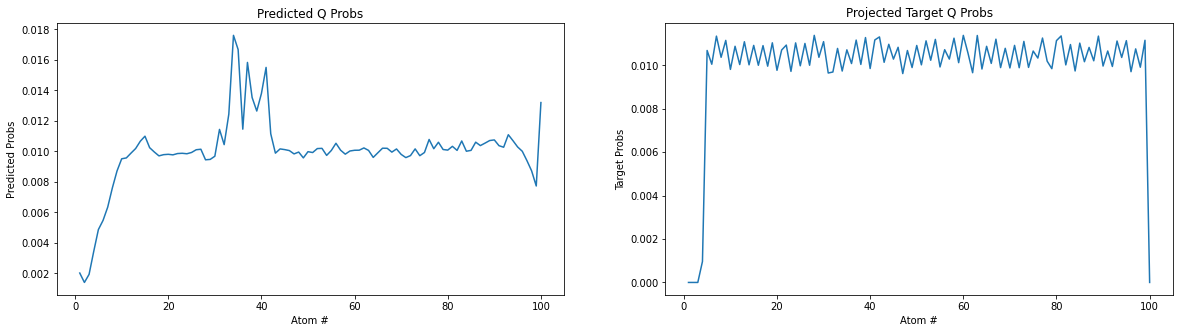

Episode 2: 	Actor Loss: -0.03 	Critic Loss: 4.23 
		Average Score: 1.10

SCORES (this eps):  [2.04376984 0.37930214 3.71700871 1.59062558 0.83585868 0.69401924
 0.12639123 1.55996018 0.14133302 0.29876158 1.16154776 0.65771124] 



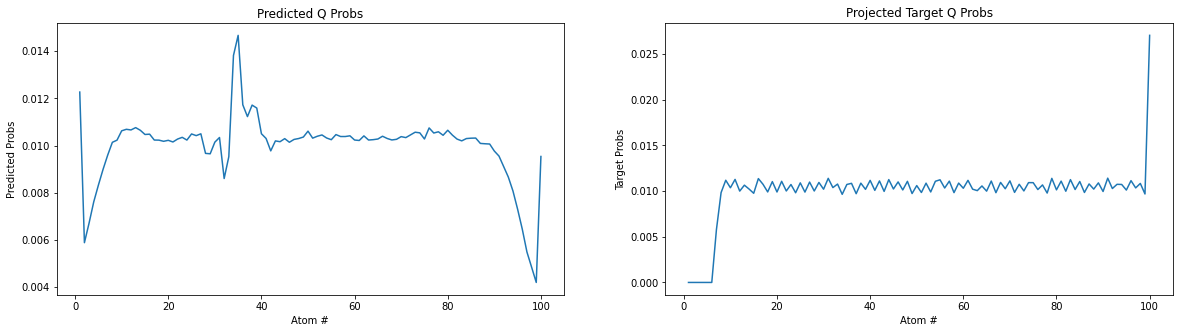

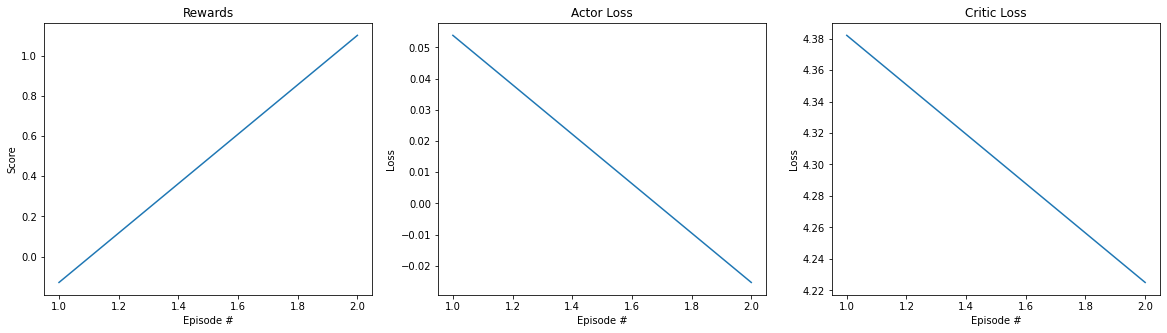

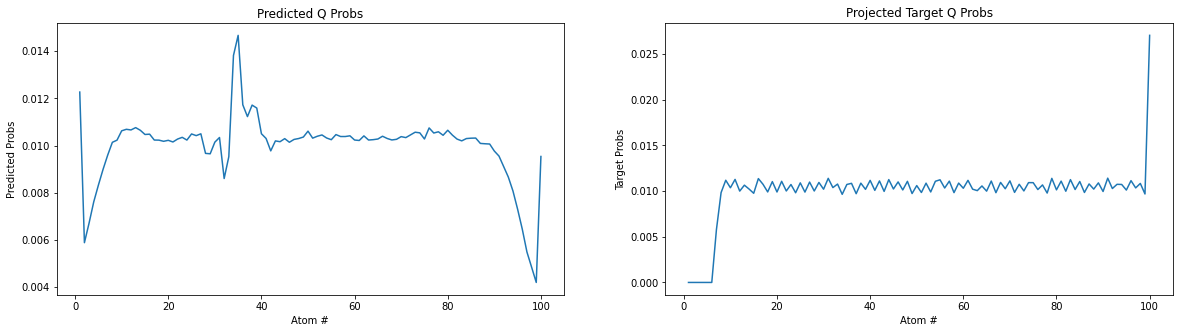

[-0.12839741197725138, 1.1005241002421826]

In [7]:
##################
# QUICK TEST
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=2
params.max_t = 50
params.print_every = 1
params.save_every = 1
params.log_weights_every = 1
params.prefill_memory_qty=0
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-4                  
params.lr_critic = 1e-3
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'
params.vmin = -3
params.vmax = 3


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

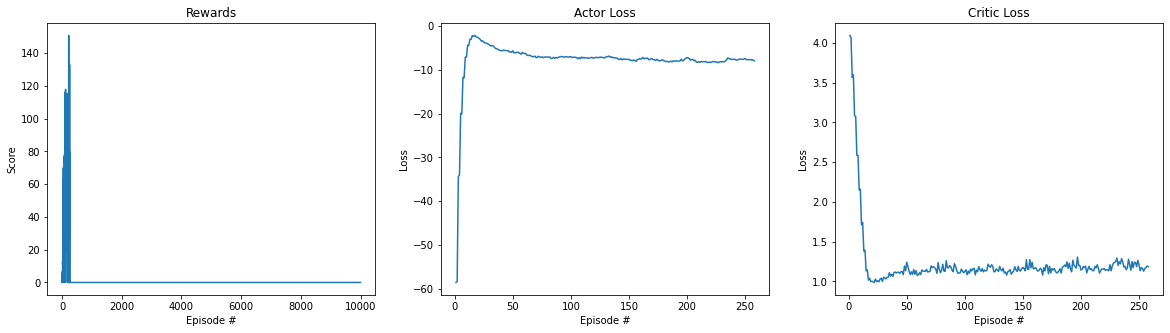

In [105]:
def plot_graph(logger):
    
    score_arr  = np.array(logger.scores_list)
    score_arr[score_arr < 0] = 0
    _, axs = plt.subplots(1, 3, figsize=(20, 5))

    # Scores
    axs[0].plot(np.arange(1, len(logger.scores_list)+1), score_arr)
    axs[0].set(xlabel='Episode #', ylabel='Score')
    axs[0].set_title('Rewards')
        
    # Actor Loss
    axs[1].plot(np.arange(1, len(logger.actor_loss_list)+1), logger.actor_loss_list)
    axs[1].set(xlabel='Episode #', ylabel='Loss')
    axs[1].set_title('Actor Loss')
    
    # Critic Loss
    axs[2].plot(np.arange(1, len(logger.critic_loss_list)+1), logger.critic_loss_list)
    axs[2].set(xlabel='Episode #', ylabel='Loss')
    axs[2].set_title('Critic Loss')
    plt.show()
    
plot_graph(logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -2
VMAX:  2
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.14 	Critic Loss: 3.83 
		Average Score: 3.31

SCORES (this eps):  [0.         0.18586762 0.18781589 4.91786596 0.32156897 0.27364761
 0.66349444 4.46155315 2.57993309 3.60006285 3.43509428 3.45403221] 



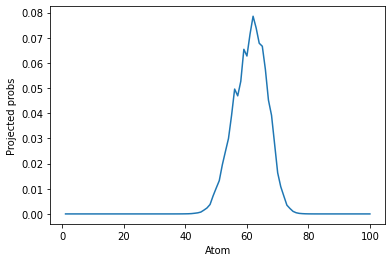

Episode 20: 	Actor Loss: -0.47 	Critic Loss: 3.63 
		Average Score: 3.36

SCORES (this eps):  [ 2.57516862  3.17451189  0.46693217  0.07922503  5.564624   12.13195447
  2.81854155  2.39018161  2.20975653  0.12296586  2.45316236  0.90063324] 



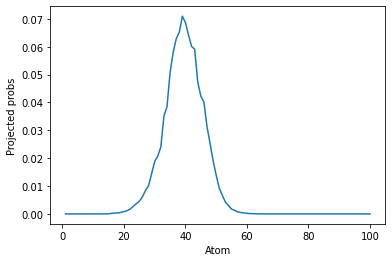

Episode 30: 	Actor Loss: -0.90 	Critic Loss: 3.32 
		Average Score: 9.46

SCORES (this eps):  [17.71689714  0.34908045  3.51957793 11.31296962  6.15221967  2.29455877
  2.05489846  8.53540981  4.41563733  0.07169021  9.92597251  2.09831346] 



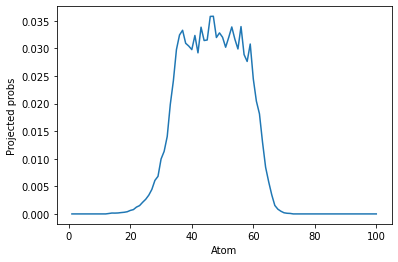

Episode 40: 	Actor Loss: -1.14 	Critic Loss: 2.96 
		Average Score: 9.03

SCORES (this eps):  [10.96229334 10.12718591 12.29180975  9.91860334  2.00473328  6.69236193
  9.7542256  17.11337151  2.91353213  7.0290861  14.18687061 12.29773657] 



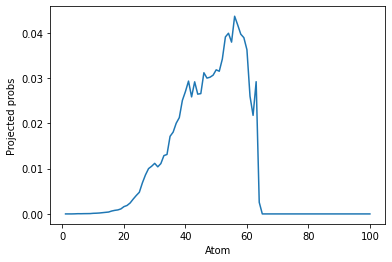

Episode 50: 	Actor Loss: -1.24 	Critic Loss: 2.65 
		Average Score: 10.53

SCORES (this eps):  [ 11.47943796 -12.82529258  13.18292046  14.0181106   12.32446132
   5.75198882  14.20385874   6.4100047    6.34132881   2.97272309
  13.99443524   2.37405397] 



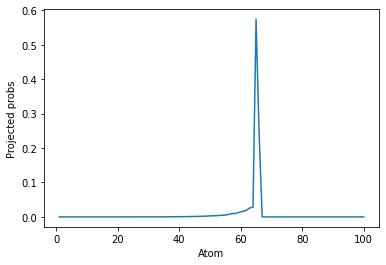

Episode 60: 	Actor Loss: -1.30 	Critic Loss: 2.49 
		Average Score: 13.16

SCORES (this eps):  [ 9.54498356 27.90109435  3.11765912  5.39922535  9.46090406  4.37732155
 14.60787352  6.17460481  6.6748245  24.97311987 45.17000544  3.7647182 ] 



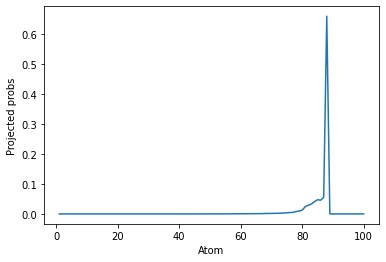

Episode 70: 	Actor Loss: -1.36 	Critic Loss: 2.31 
		Average Score: 16.19

SCORES (this eps):  [51.02578137 14.56518344 62.96690766 50.001803   22.79712374 27.06189511
 13.48268392  6.85169314 22.12771247  1.01461987 18.70085967 44.2330993 ] 



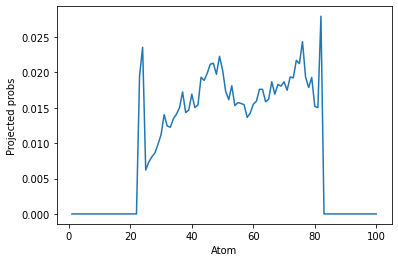

Episode 80: 	Actor Loss: -1.44 	Critic Loss: 2.14 
		Average Score: 19.17

SCORES (this eps):  [40.49905536 38.64163614  5.22901002 42.13669271  6.92708144  4.25443585
  6.53302442 45.12929942  3.90122059  2.52358248  4.71217014  5.01990166] 



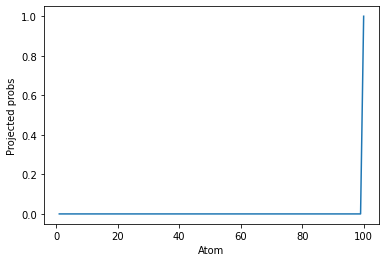

Episode 90: 	Actor Loss: -1.52 	Critic Loss: 1.91 
		Average Score: 24.32

SCORES (this eps):  [ 2.92030001  8.54788984 11.27854122 10.09045275 11.89337797 11.78497504
 46.34588758  5.19191939  0.         27.23103247  9.27157123  4.65589623] 



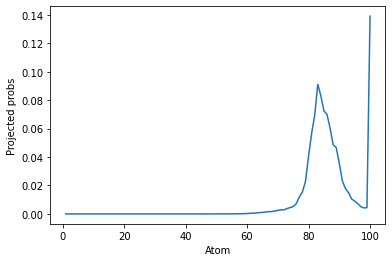

Episode 100: 	Actor Loss: -1.63 	Critic Loss: 1.59 
		Average Score: 23.36

SCORES (this eps):  [111.50693925  21.07318996   9.81267913  21.9004324   26.91342956
  28.97439829   5.2276932    8.2303556   65.06271709  43.47204635
  21.62948105  10.80702001] 



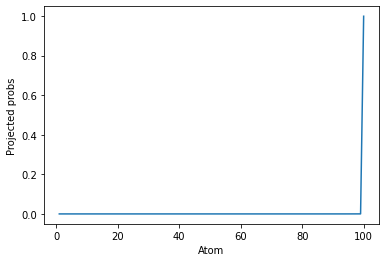

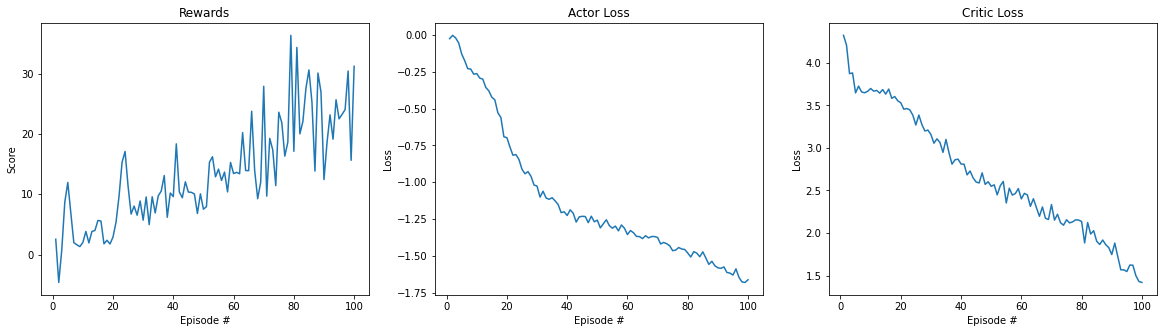

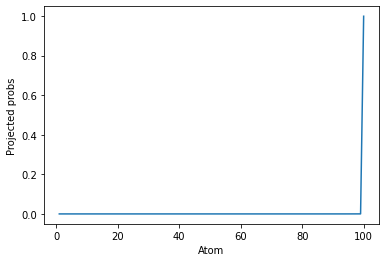

[2.531138189656,
 -4.627917923401886,
 0.764199839051192,
 8.677270784358067,
 11.948230314437145,
 6.906347084188989,
 1.9700123351067305,
 1.6211440834449604,
 1.3165993820099782,
 2.006744671962224,
 3.834877892707785,
 1.9323424469427362,
 3.8247035837266594,
 3.990450586619166,
 5.654060917169166,
 5.555374063939477,
 1.7796045910023774,
 2.368124367746835,
 1.7500692643225193,
 2.907304777375733,
 5.370251698923918,
 9.677908066854192,
 15.291278733871877,
 17.09162691968959,
 11.328756280903084,
 6.710092737863306,
 8.040875483852384,
 6.527927532636871,
 8.879774033674039,
 5.70393544769225,
 9.546915864727149,
 4.955659109555806,
 9.582948654618425,
 6.894040136384622,
 9.725159903561385,
 10.529548016143963,
 13.102559644728899,
 6.177061278528224,
 10.195103505820347,
 9.607650838249052,
 18.354878537279244,
 10.381240988140538,
 9.4168377975584,
 12.063554795924574,
 10.36446404400825,
 10.312605268671177,
 10.049668433105884,
 6.814845278975554,
 10.063461283842722,
 7.519

In [24]:
##################
# Vmax = -Vmin = 2
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_2'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_2'
params.num_atoms = 100
params.vmin = -2
params.vmax = 2


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -5
VMAX:  5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.09 	Critic Loss: 3.46 
		Average Score: -1.84

SCORES (this eps):  [ 0.94236293  0.44802137  0.97641426  0.91901076  1.06776543 17.64876091
  0.76071538  0.49145962  1.05551678  0.46184647  0.25544391  0.7669073 ] 



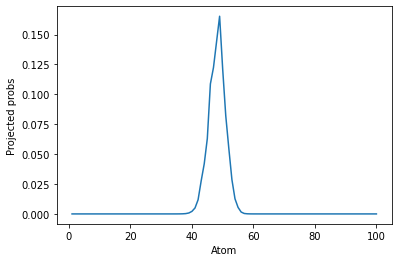

Episode 20: 	Actor Loss: -0.75 	Critic Loss: 2.98 
		Average Score: 3.45

SCORES (this eps):  [ 5.38858248  0.87526961  5.82314635 16.34254459  1.25826387  0.84870289
  2.93873842  1.06380316  0.97008278  2.93891869  0.05891044  1.11360322] 



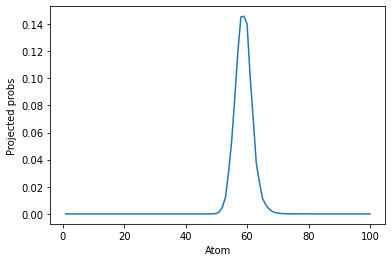

Episode 30: 	Actor Loss: -1.53 	Critic Loss: 3.07 
		Average Score: 5.62

SCORES (this eps):  [2.57457972e+00 3.92896533e-02 2.67915116e+00 2.36453346e+01
 3.78618698e+00 1.68427341e-02 1.24166843e+01 2.33288534e-01
 6.28062114e-02 1.18897786e+01 5.44619630e+00 1.40637742e+01] 



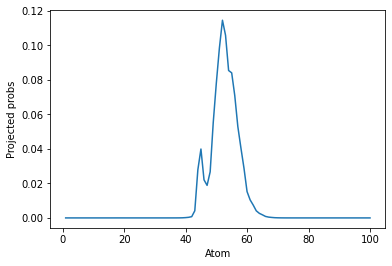

Episode 40: 	Actor Loss: -2.06 	Critic Loss: 3.05 
		Average Score: 11.26

SCORES (this eps):  [13.47893887 30.0048569   5.63940105 11.05898678 11.09638577 29.65855336
  2.22287624 24.56597782 24.76017143 14.21578178  5.44832241  8.15614547] 



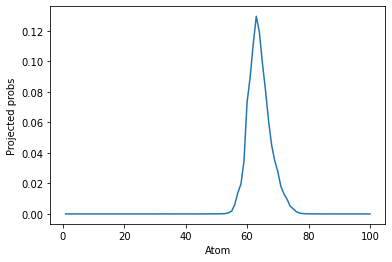

Episode 50: 	Actor Loss: -2.42 	Critic Loss: 2.94 
		Average Score: 12.96

SCORES (this eps):  [18.0597099  10.35430314  9.74294411 14.30692717  4.82840408  5.51277662
 12.51191662 10.48046449 39.10779939  0.08797283 20.25282829 16.33218889] 



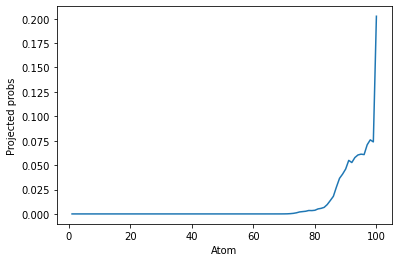

Episode 60: 	Actor Loss: -2.66 	Critic Loss: 2.87 
		Average Score: 17.72

SCORES (this eps):  [1.46152166e+01 1.08484358e+01 2.57343635e-01 8.20244822e+01
 7.53605950e+00 1.11392761e+01 9.23998430e-02 9.51263721e+00
 3.12598147e+01 1.54372551e+01 2.38382258e-02 1.42627516e+01] 



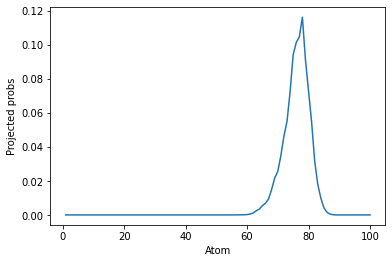

Episode 70: 	Actor Loss: -2.82 	Critic Loss: 2.78 
		Average Score: 18.50

SCORES (this eps):  [ 20.3811757    0.21214299   2.98562485   5.17048045   1.1866641
  11.23750015   4.89276861   4.19640952 110.03147605   2.99241219
   7.83717296   8.39296657] 



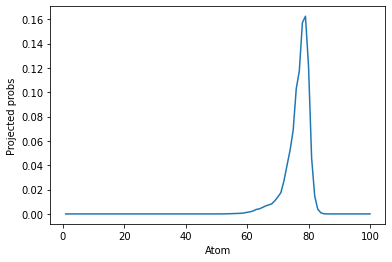

Episode 80: 	Actor Loss: -2.99 	Critic Loss: 2.73 
		Average Score: 22.78

SCORES (this eps):  [ 83.72942113  22.7533843  120.9917224    8.66776267   1.93648494
  88.04614136   0.           1.12213396   1.2297461   18.66808037
   7.83074382  66.8974436 ] 



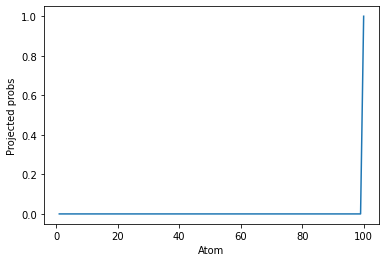

Episode 90: 	Actor Loss: -3.15 	Critic Loss: 2.65 
		Average Score: 26.94

SCORES (this eps):  [ 1.35592326e+01  1.93677278e+01  3.07423621e+01  1.82553283e+01
  6.07052870e+00  2.62948717e+01  1.60190228e+01 -1.33703374e+01
  1.06172257e+01  3.21999380e+01 -1.91885233e-02  3.16547271e+01] 



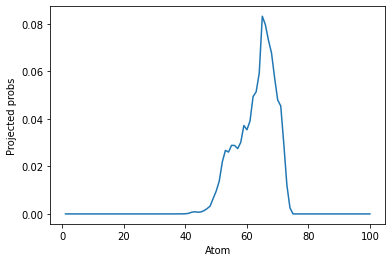

Episode 100: 	Actor Loss: -3.46 	Critic Loss: 2.52 
		Average Score: 31.30

SCORES (this eps):  [ 24.16126858   7.55202582  44.94044347  31.89756151 106.55539134
   3.91193252  16.54596015   0.25277775  23.41529608  10.94988385
  40.95198424  26.60465124] 



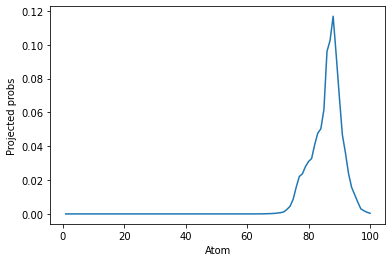

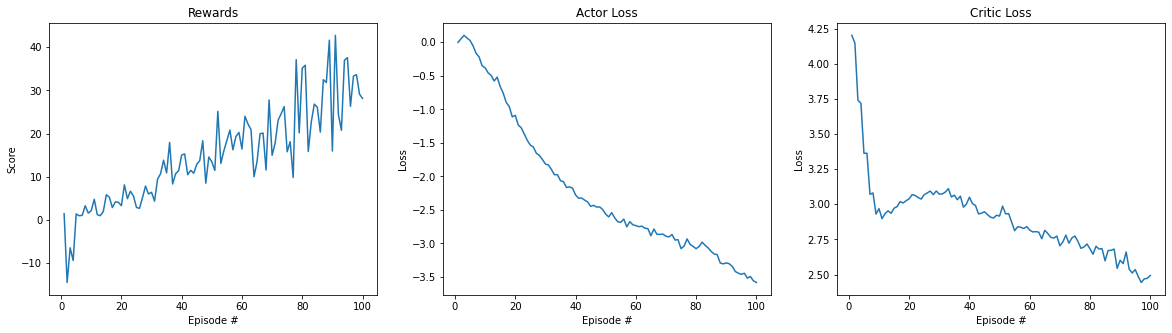

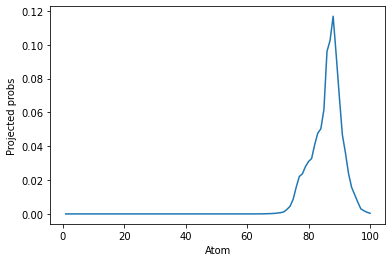

[1.4288723260069673,
 -14.475138469248728,
 -6.447534060105681,
 -9.387789559075221,
 1.3845240904095892,
 0.9607462104953205,
 1.0733349584043026,
 3.2860649546297886,
 1.5913779638552417,
 2.149518759921193,
 4.772654525392379,
 1.2278054618897538,
 0.9809587324659029,
 1.960111877337719,
 5.827904016400377,
 5.283544434389721,
 2.8608720738751194,
 4.192382634306948,
 4.077378602388005,
 3.3017138732442013,
 8.130975213445103,
 4.919357223513846,
 6.660393110010773,
 5.533511726884171,
 2.894200465253865,
 2.6779457178587713,
 5.142935609134535,
 7.834053911268711,
 6.016445546464335,
 6.404492746883382,
 4.352224099993085,
 9.423222701686123,
 10.717399239831138,
 13.825029101998856,
 10.890753724806322,
 17.938867794931866,
 8.330109757681688,
 10.704143172479235,
 11.409516010278216,
 15.025533156624684,
 15.27937022363767,
 10.481991667804929,
 11.480048421925554,
 10.820086754315222,
 12.860795805812813,
 13.758066087883586,
 18.347520638102043,
 8.509667816300256,
 14.56901009

In [25]:
##################
# Vmax = -Vmin = 5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_5'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_5'
params.num_atoms = 100
params.vmin = -5
params.vmax = 5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -10
VMAX:  10
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.23 	Critic Loss: 3.28 
		Average Score: 9.35

SCORES (this eps):  [ 1.905939    7.88530333  8.27647731 20.6359955  23.26489683 13.69319645
  1.45613457  0.28228954  0.92498702  5.89917324  7.62962972  0.        ] 



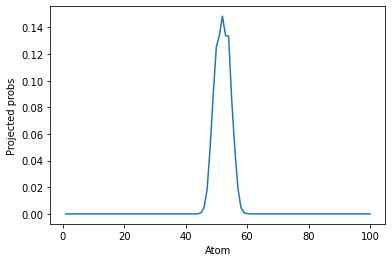

Episode 20: 	Actor Loss: -1.22 	Critic Loss: 2.56 
		Average Score: 4.57

SCORES (this eps):  [ 3.91945288 18.92383274  0.33052016  5.03363822  1.99430179  0.11848765
  0.05230379  5.76268058  2.1557624   0.28262769  3.15159368  0.40484414] 



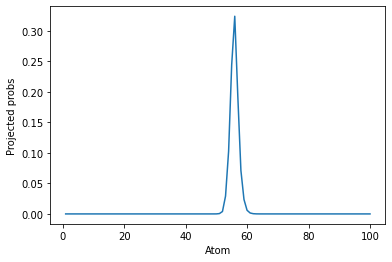

Episode 30: 	Actor Loss: -1.88 	Critic Loss: 2.70 
		Average Score: 11.69

SCORES (this eps):  [18.4906898   8.50851772  0.68243101 14.49184502  1.14191242  0.52495383
  2.09791808 51.79214847 29.44555232 15.58787178  8.4097856   3.67199275] 



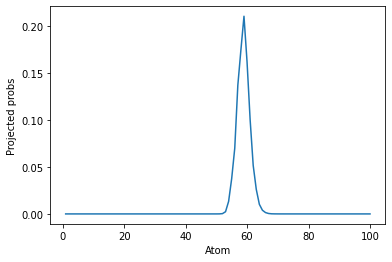

Episode 40: 	Actor Loss: -2.51 	Critic Loss: 2.77 
		Average Score: 13.87

SCORES (this eps):  [13.46684615 27.95952972  0.51596803  6.35423225  6.58802256  9.08788976
 18.09460035 21.1806765   5.46226962 31.26094396 50.7944175   1.09112813] 



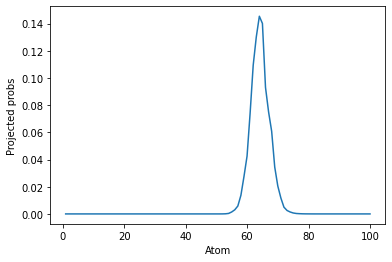

Episode 50: 	Actor Loss: -2.91 	Critic Loss: 2.78 
		Average Score: 8.76

SCORES (this eps):  [32.79304355  0.79620005  4.59849397 28.29309762  5.78993225  3.60773532
 12.59555029 18.61252003 17.04026808  7.44924525 46.93438328 42.14856081] 



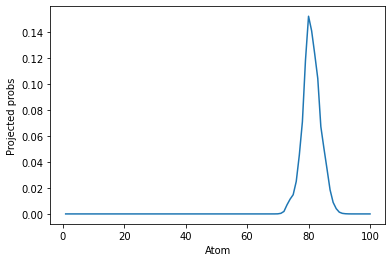

Episode 60: 	Actor Loss: -3.14 	Critic Loss: 2.85 
		Average Score: 15.60

SCORES (this eps):  [ 9.03059791 12.73257528  1.11150846 10.86587656  3.53239991 36.28339738
 21.9304292   3.33517013  0.17435681 11.65068024 31.82887781 16.22429722] 



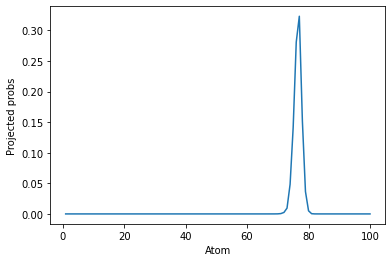

Episode 70: 	Actor Loss: -3.40 	Critic Loss: 2.86 
		Average Score: 14.54

SCORES (this eps):  [39.23998193 22.08133996 11.25461482  9.77362056  0.         10.32684018
 29.44484776 12.89947471  9.64604431 19.3962867  20.85882857 21.76665042] 



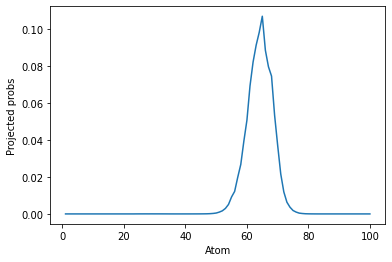

Episode 80: 	Actor Loss: -3.46 	Critic Loss: 2.83 
		Average Score: 18.25

SCORES (this eps):  [19.28110634  0.92689126 13.48911911 15.43507521 11.54258222 36.58917288
  9.36465623 44.95957095 26.10549306 32.3141777   7.30517905  6.50456852] 



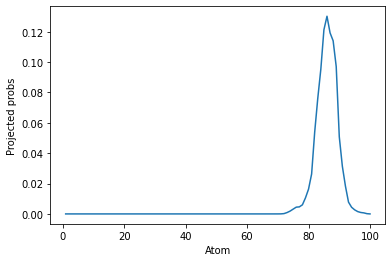

Episode 90: 	Actor Loss: -3.71 	Critic Loss: 2.84 
		Average Score: 23.39

SCORES (this eps):  [ 0.         47.23449485  0.21236733 16.65489489  5.58754459 23.38983357
 12.1356293   9.91852496 21.5843565   1.83436238 11.47808062 36.0345664 ] 



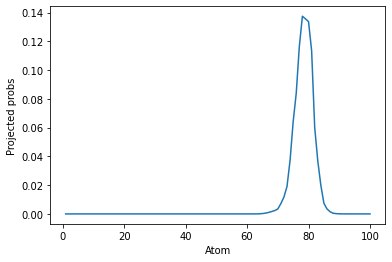

Episode 100: 	Actor Loss: -4.01 	Critic Loss: 2.86 
		Average Score: 20.64

SCORES (this eps):  [ 7.7057967   2.03580176  0.46628672  8.3969636  10.94821382 16.67783216
  6.15585068  0.26578383 44.53612778 54.20643388  2.64405899 37.91387901] 



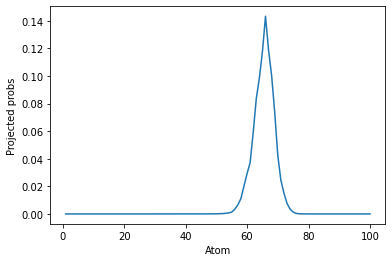

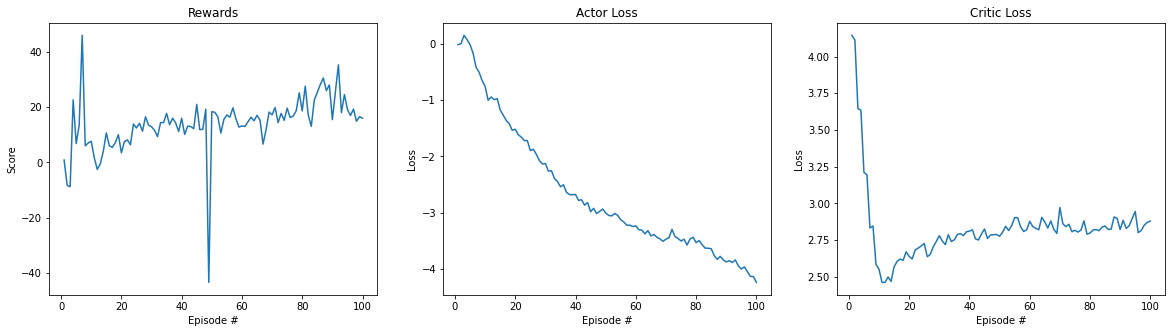

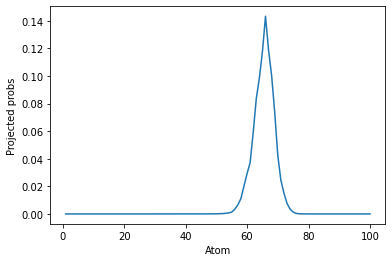

[0.8772191131477788,
 -8.271143450440528,
 -8.75354919861032,
 22.633520751978114,
 6.823762371845078,
 13.488521445697794,
 45.966911757617105,
 6.026027904260748,
 7.062678202909107,
 7.654501876638581,
 1.718315473680074,
 -2.522332686232403,
 -0.48252403584774584,
 4.027632837649435,
 10.707215216942132,
 5.9998286449893685,
 5.464391379966401,
 7.175048991067645,
 10.062593854342898,
 3.5108371449944875,
 7.528627692566563,
 8.173399994693076,
 6.382884453710479,
 13.905115671940925,
 12.462809284819135,
 14.178559257493665,
 11.315160984639078,
 16.510230293807883,
 13.52031784267941,
 12.903801568046523,
 11.617643889427805,
 9.329463933128864,
 14.445873635859849,
 14.398992758477107,
 17.741191952760953,
 13.659391130281923,
 16.028347268817015,
 14.321950314139636,
 11.185616904345807,
 15.988043711249096,
 10.127296096955737,
 13.139851822052151,
 12.991373631870374,
 12.2196360269445,
 21.01743327830142,
 11.846098882941684,
 12.00294992319929,
 19.27567651429369,
 -43.3891

In [26]:
##################
# Vmax = -Vmin = 10
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_10'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_10'
params.num_atoms = 100
params.vmin = -10
params.vmax = 10


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -20
VMAX:  20
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.00 	Critic Loss: 3.15 
		Average Score: -0.52

SCORES (this eps):  [-0.73062578  0.46301526  0.33236915  1.9418207   6.85292186  2.0642787
  1.83127954  7.40193838 15.27050787 10.61772952 -1.74969727  1.00144953] 



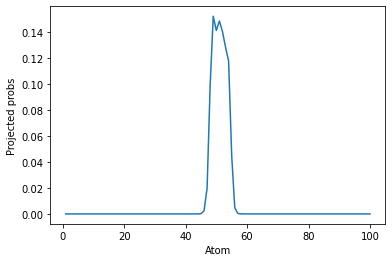

Episode 20: 	Actor Loss: -0.21 	Critic Loss: 1.68 
		Average Score: 1.96

SCORES (this eps):  [-0.39778248  2.37935225 -2.75069384  0.          2.33246436  0.
 28.7603595   0.          0.67138334 -4.43835725  0.13693545 -3.40263993] 



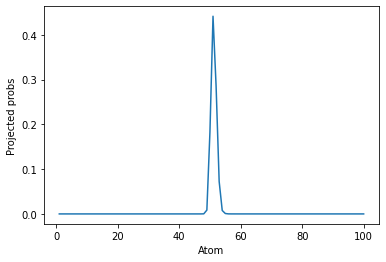

Episode 30: 	Actor Loss: -0.37 	Critic Loss: 1.59 
		Average Score: 1.98

SCORES (this eps):  [19.62325521  5.61333272  0.38503923  1.14367466  1.72667996 -0.77597512
  6.30990977  1.02179574  3.34672682  1.84221537  3.09520771  0.66070719] 



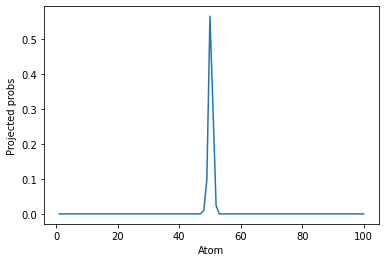

Episode 40: 	Actor Loss: -0.52 	Critic Loss: 1.63 
		Average Score: 5.41

SCORES (this eps):  [ 3.06934987 16.86180392 -3.86143779  5.57436052  7.27207953  1.24775032
  1.76446026  1.09648088  5.64519447  9.63185996  8.60549763  5.21582932] 



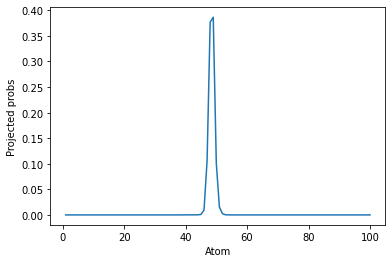

Episode 50: 	Actor Loss: -0.74 	Critic Loss: 1.72 
		Average Score: 7.76

SCORES (this eps):  [ 3.6637178   3.75316278  5.87247094  0.63084483 16.47609942  9.5657201
  4.99374331  0.531583   15.21698117  6.88961377  2.10580474  5.58425455] 



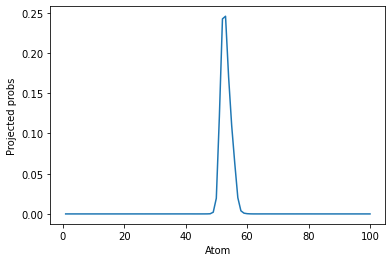

Episode 60: 	Actor Loss: -1.02 	Critic Loss: 1.79 
		Average Score: 8.66

SCORES (this eps):  [ 2.19947984 10.4217497   4.38584729  2.30718842  4.31184879 67.06763492
  0.53809574 23.68555629  0.          4.70323875  5.26782572 13.97110736] 



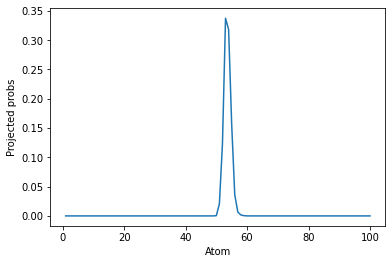

Episode 70: 	Actor Loss: -1.38 	Critic Loss: 1.90 
		Average Score: 9.73

SCORES (this eps):  [ 1.30883718  8.00632678  2.86311771  5.30503203  0.49246303  5.48084921
 11.65188168 25.24860219  8.52555893 11.11291874 15.85210652 11.61315867] 



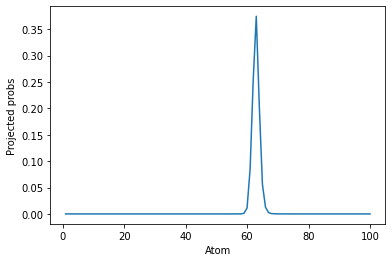

Episode 80: 	Actor Loss: -1.68 	Critic Loss: 1.94 
		Average Score: 13.21

SCORES (this eps):  [ 9.47962982  3.45457087 32.83419537  8.64257596  7.96032881 12.94724806
 25.36715601  3.00473477 20.22452457 10.04988719  0.42631844 13.98801376] 



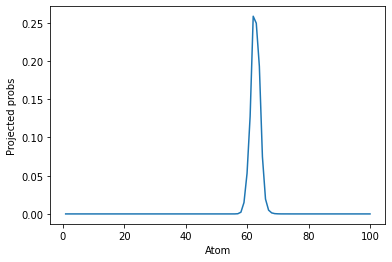

Episode 90: 	Actor Loss: -1.99 	Critic Loss: 1.99 
		Average Score: 11.54

SCORES (this eps):  [13.39324475  0.15636194 17.44859705  0.16982637  1.13580433  3.66945978
 24.76889814 36.50071334 13.43447639 39.85729359 12.84512484 13.39512964] 



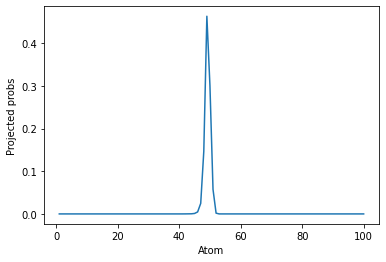

Episode 100: 	Actor Loss: -2.37 	Critic Loss: 2.04 
		Average Score: 16.17

SCORES (this eps):  [10.65587563  2.44950888 16.29844843 20.35430552 20.9332303   0.39662603
 23.30097235 19.23228537  6.02198975 20.41115729 28.94063883 47.24147447] 



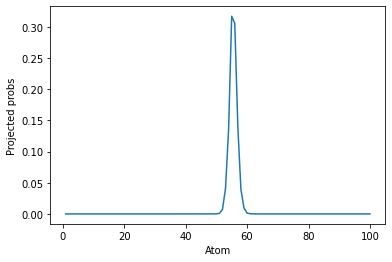

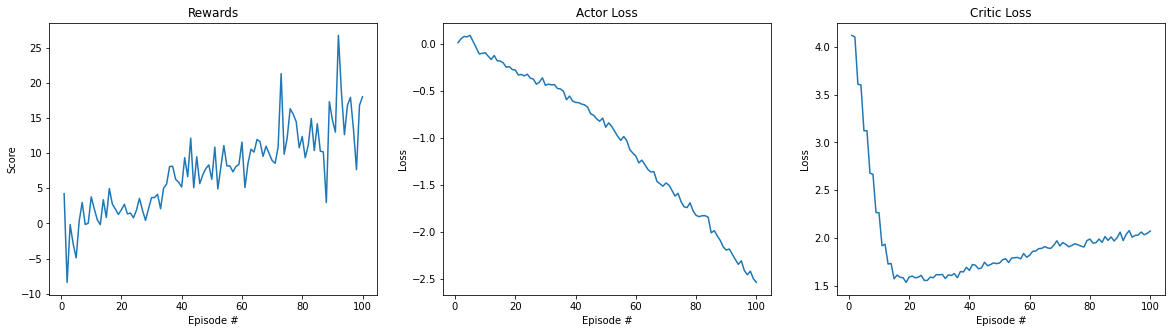

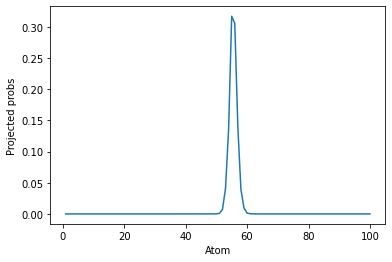

[4.224524705898754,
 -8.39553207330755,
 -0.16151179351921505,
 -2.903703821861806,
 -4.90036028578955,
 0.33910143468528986,
 2.9743369872157928,
 -0.15542751904771043,
 0.03201175994884883,
 3.7747489559696987,
 2.0775639509859807,
 0.5260925905313343,
 -0.18019736868639788,
 3.3691430111648515,
 0.8448219085500265,
 4.957834284364556,
 2.7623580006572106,
 2.0409010426374152,
 1.2839313455624506,
 1.9409184506318222,
 2.728440667366764,
 1.345002797471049,
 1.475723729216649,
 0.7986968098169503,
 1.8881226350010063,
 3.551914562432406,
 1.8757609314731478,
 0.43783818260514334,
 2.0755208577417457,
 3.6660474373202305,
 3.6920997799995043,
 4.144092821050435,
 2.0907658882788382,
 5.01093069636651,
 5.601687478968718,
 8.093187416355553,
 8.132278132834472,
 6.278549537955162,
 5.854188488893366,
 5.176935740940583,
 9.355685082632894,
 6.643333001974194,
 12.116203936709402,
 5.080181456267989,
 9.478495621743301,
 5.6574500714389915,
 6.908999722218141,
 7.7917312291295575,
 8.31

In [27]:
##################
# Vmax = -Vmin = 20
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_20'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_20'
params.num_atoms = 100
params.vmin = -20
params.vmax = 20


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  1
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.08 	Critic Loss: 4.02 
		Average Score: -0.60

SCORES (this eps):  [  8.01517027   6.48406217  -2.75612858 -12.64666858  25.20109191
 -21.99321894 -26.9668658    8.26694862  -0.09087685  20.12881933
   2.2583941  -34.58130432] 



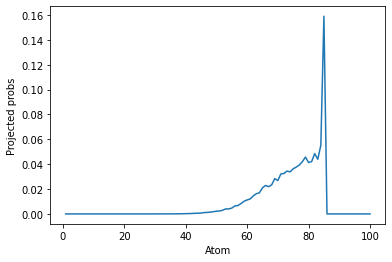

Episode 20: 	Actor Loss: -0.12 	Critic Loss: 3.89 
		Average Score: -0.43

SCORES (this eps):  [-4.97008981  1.95355826  1.40890478  0.         13.41645721  6.23558551
  0.4360254   1.52359001  4.03561327  7.63296215 -4.02011383  0.        ] 



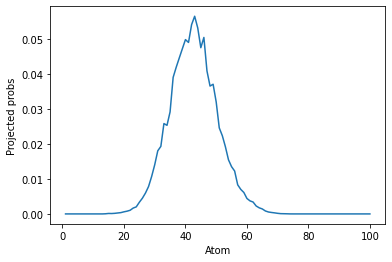

Episode 30: 	Actor Loss: -0.23 	Critic Loss: 3.53 
		Average Score: 3.91

SCORES (this eps):  [ 8.90157521 12.20458168 11.35367103  4.19726375  6.21686297  1.70222394
  0.85783017  3.66014106  1.48589117 10.83525407 12.89773459  4.18672938] 



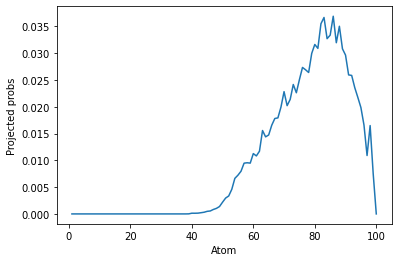

Episode 40: 	Actor Loss: -0.32 	Critic Loss: 3.28 
		Average Score: 6.40

SCORES (this eps):  [ 3.315421    4.69789003  4.02645117  3.61164028 15.24553119 15.23042482
  4.22482263  3.15090067  6.20390144  8.5078827   2.05965219  9.53759919] 



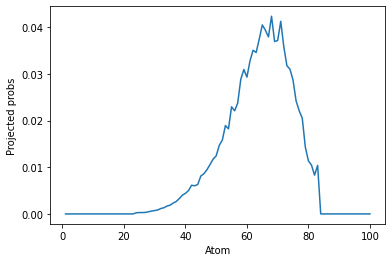

Episode 50: 	Actor Loss: -0.40 	Critic Loss: 3.11 
		Average Score: 10.95

SCORES (this eps):  [ 7.36383173 10.16062493  7.83878212  0.41718042 28.48645155 23.0851019
 12.23992347 39.1864989   6.56126074 12.76960032  4.40947911  2.55282361] 



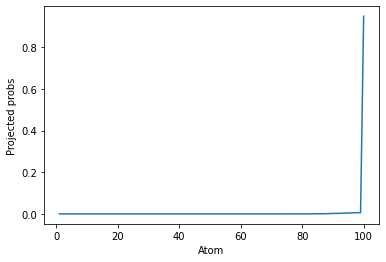

Episode 60: 	Actor Loss: -0.46 	Critic Loss: 2.92 
		Average Score: 10.41

SCORES (this eps):  [40.10589591  6.83877345  0.2084822   1.4297581  12.2736525  23.26145469
  7.44246621 43.68986807  5.20495005 32.69029714 11.62604002  2.61709133] 



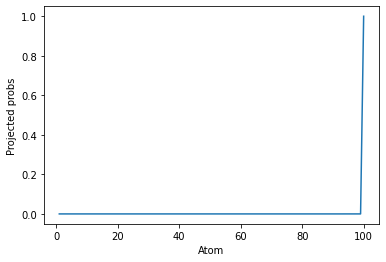

Episode 70: 	Actor Loss: -0.51 	Critic Loss: 2.74 
		Average Score: 13.68

SCORES (this eps):  [ 0.62356542  8.25292864  4.61186321 23.26649903  7.7726746  21.6822681
 14.09199604 11.67389294  6.48188841  8.38583825 23.39313478 67.41105078] 



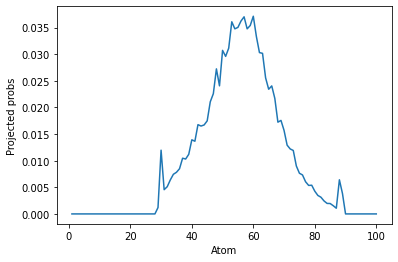

Episode 80: 	Actor Loss: -0.54 	Critic Loss: 2.65 
		Average Score: 16.29

SCORES (this eps):  [ 5.70546439 71.63685645  8.39717492  3.32171958 20.87954327 36.47006667
 40.45659443  5.38636648 59.58715333  2.77411908 10.42691134  6.91912031] 



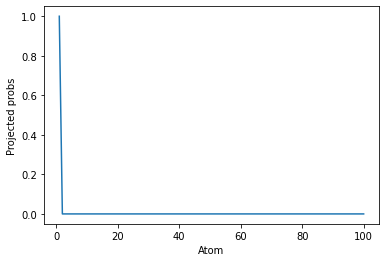

Episode 90: 	Actor Loss: -0.59 	Critic Loss: 2.42 
		Average Score: 20.79

SCORES (this eps):  [12.78132495 23.44807268 37.54011793 38.63372962  4.9543417   3.50528567
 14.53610637  6.32622955 16.7959347   4.14679977  7.31596852 15.14644239] 



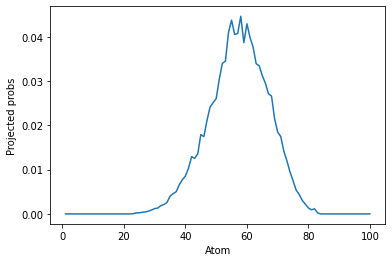

Episode 100: 	Actor Loss: -0.66 	Critic Loss: 2.04 
		Average Score: 25.55

SCORES (this eps):  [11.09623839  5.46180243  6.3832874  21.80794947 81.47162403 50.21488556
 18.02012903 69.31902625  8.53488011  3.65683538 19.60959193 27.1297087 ] 



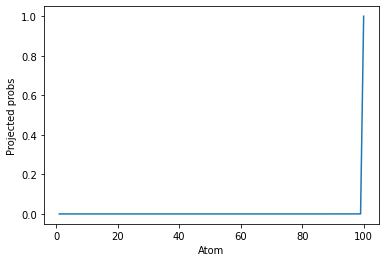

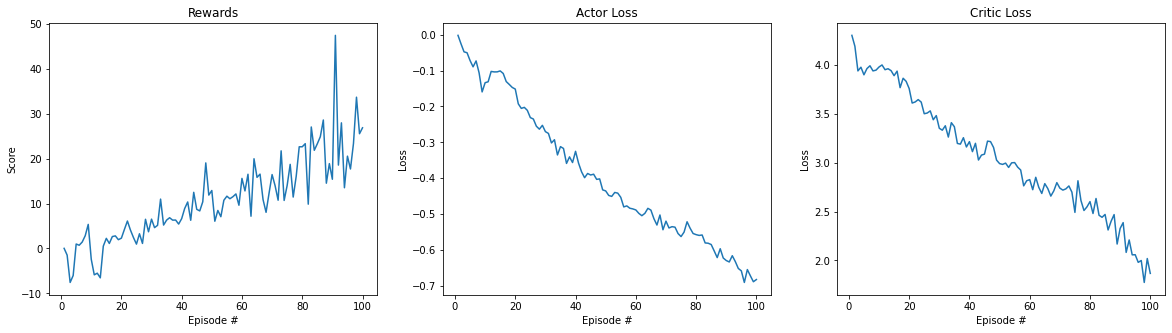

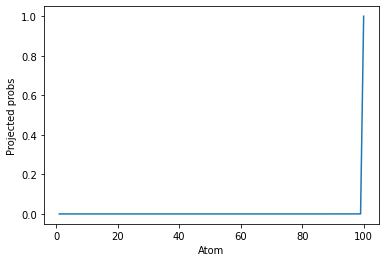

[0.03207848084275611,
 -1.474068019791351,
 -7.563114530062497,
 -6.020841776781405,
 0.9981714589521289,
 0.7232401491686081,
 1.4375345967321966,
 2.8472941190023753,
 5.36899702163646,
 -2.3900480566517217,
 -5.86533207220297,
 -5.499730483114642,
 -6.536568251218948,
 0.5285677599022165,
 2.259750133360891,
 1.124830438162462,
 2.662453904078575,
 2.8072735615908946,
 1.9626926834656235,
 2.3043744126916863,
 4.244624494002589,
 6.121337632512829,
 4.121901134620809,
 2.4536062510014744,
 0.9763891185478618,
 3.2811003157742866,
 1.1282137727345496,
 6.508356589481991,
 3.729079146811273,
 6.541646583815843,
 4.6469159257248975,
 5.160705070748615,
 11.004279018753246,
 5.226514603535179,
 6.323594570159912,
 6.857574635146496,
 6.32060444977833,
 6.338926599593833,
 5.445784834202641,
 6.651009775416848,
 8.917298240897557,
 10.364468775544083,
 6.2901761636312585,
 12.516604505023375,
 8.727924794501936,
 8.374164807062092,
 10.404999032150954,
 19.067548851055715,
 11.8978601547

In [28]:
##################
# Vmax = -Vmin = 1
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_1'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_1'
params.num_atoms = 100
params.vmin = -1
params.vmax = 1


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.5
VMAX:  0.5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.08 	Critic Loss: 2.49 
		Average Score: -3.16

SCORES (this eps):  [ 0.          2.08782317 -1.00095013  0.81460006  3.26481951 -4.67749704
  3.77535623  7.10588116  0.36963854 -9.4944245  -1.56890606 -1.73609999] 



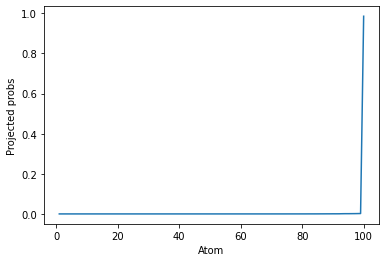

Episode 20: 	Actor Loss: -0.05 	Critic Loss: 2.95 
		Average Score: 2.70

SCORES (this eps):  [-12.74444548  -4.58289458   3.39552583  -2.2822616    0.07021045
  -8.3123256    3.77758837   0.42694323   1.27485519   9.0144441
  -4.83611555   0.55555914] 



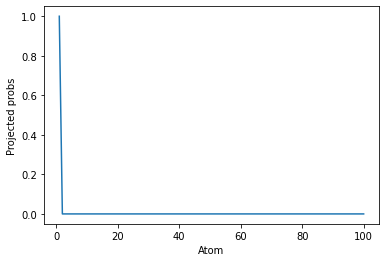

Episode 30: 	Actor Loss: -0.07 	Critic Loss: 3.15 
		Average Score: 6.33

SCORES (this eps):  [ 7.53040468  2.26885952 17.65001691 13.37028617 19.12084868  8.51160576
 35.15502565  1.96120629  3.27832633 11.23947764 18.90539927 11.85707678] 



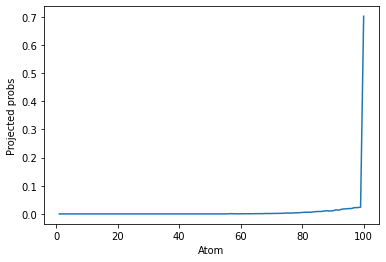

Episode 40: 	Actor Loss: -0.12 	Critic Loss: 3.19 
		Average Score: 15.16

SCORES (this eps):  [ 2.42933773  0.79576406  0.73716448 17.44186701  5.76792971  1.96595355
 10.09424541 20.51709608  3.66498304  0.52929427  7.6215971   7.64935621] 



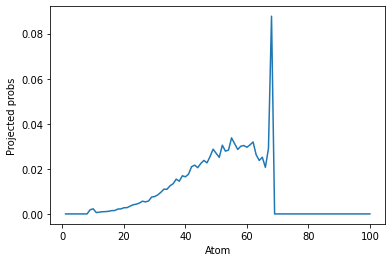

Episode 50: 	Actor Loss: -0.18 	Critic Loss: 3.10 
		Average Score: 9.03

SCORES (this eps):  [ 7.59603768  2.37391086 11.32382649  2.79028006  6.45693567  4.52815213
  8.01721119  6.44965946 19.51746362  2.19583691  6.87357103  1.38971202] 



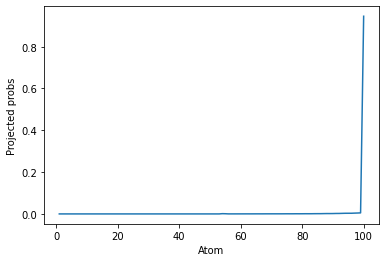

Episode 60: 	Actor Loss: -0.22 	Critic Loss: 2.93 
		Average Score: 7.87

SCORES (this eps):  [ 4.40461092  0.87932106  0.78319871 14.24754792 18.6496637   2.73461553
  1.62910944  4.20839138  2.72188458 10.93611463  3.3401519  24.53075453] 



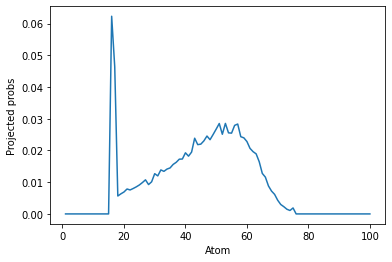

Episode 70: 	Actor Loss: -0.25 	Critic Loss: 2.74 
		Average Score: 11.28

SCORES (this eps):  [ 3.73862544  2.60770692  4.19492464 29.60669896 24.56057264 34.16017983
 33.5409155   2.1727012  23.08813561 14.7621641  15.5911882  25.57229645] 



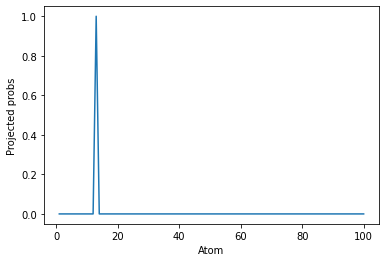

Episode 80: 	Actor Loss: -0.29 	Critic Loss: 2.53 
		Average Score: 16.70

SCORES (this eps):  [44.21041201 19.85175499 18.98166302 11.76859746 18.57979172 37.57628345
  5.51291662 42.4676744  32.63909574  7.89289355 12.36531476 17.19578388] 



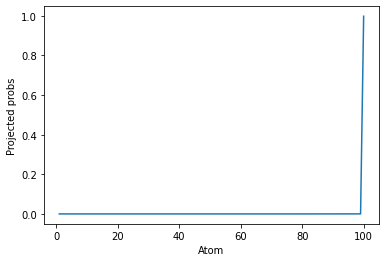

Episode 90: 	Actor Loss: -0.32 	Critic Loss: 2.37 
		Average Score: 25.06

SCORES (this eps):  [  9.002796    17.0787252   11.45765697  18.45830677 104.80464918
  23.09941681  42.16023502  14.82315836  20.19770162  13.56117364
  70.03814526  64.36001914] 



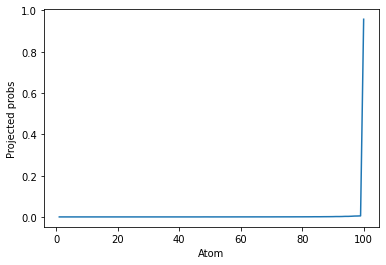

Episode 100: 	Actor Loss: -0.35 	Critic Loss: 2.11 
		Average Score: 50.60

SCORES (this eps):  [  1.31715403  42.97949543 141.73019979 142.39325715  57.34276628
  15.84153893 122.38722862  62.01106206  76.4860307   20.61805017
  31.75904738 133.1338641 ] 



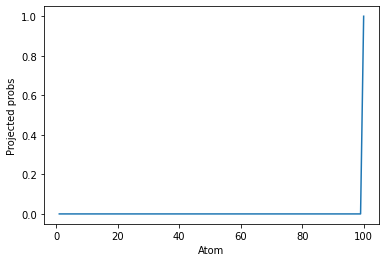

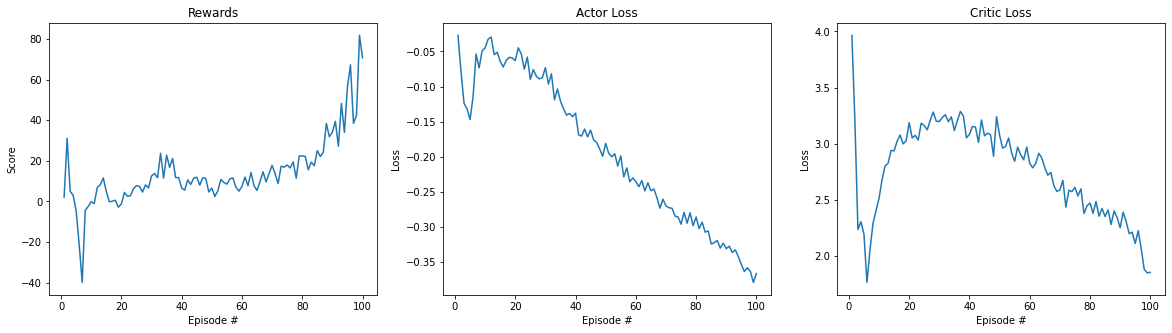

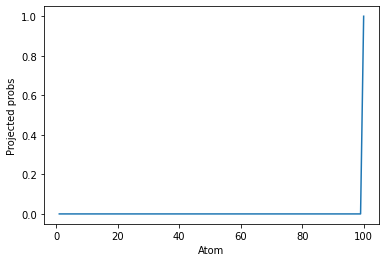

[2.129581238805258,
 31.08678520747344,
 5.052751330619988,
 3.0091456145358584,
 -4.844684168832221,
 -21.29970469334997,
 -39.870663065245026,
 -4.343843388812577,
 -2.413333450250017,
 -0.08831325512922679,
 -1.0278445339984803,
 6.872994544634518,
 8.254887373961537,
 11.575737388021176,
 4.833358791511273,
 -0.1923285304607513,
 0.14177891674141088,
 0.608855165153121,
 -2.8414267011685297,
 -1.186909708068318,
 4.458836241921138,
 2.568832735923934,
 2.798363227843462,
 6.302520966487161,
 7.775913385751967,
 7.445548876596149,
 4.61230750879137,
 8.148247654588582,
 6.63136541043059,
 12.57071114044326,
 13.766142065792033,
 11.670328284890275,
 23.748363646610716,
 11.526086740586228,
 22.813781291756943,
 16.76934934307792,
 21.192338768477686,
 11.748180086763265,
 11.734608538952065,
 6.601215721275366,
 5.568235772427822,
 10.612569964844928,
 8.390497012221507,
 11.454486415658417,
 11.9671995679455,
 8.041695197597923,
 11.655700049091442,
 11.333824299302554,
 4.67995540

In [29]:
##################
# Vmax = -Vmin = 0.5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.5'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.5'
params.num_atoms = 100
params.vmin = -0.5
params.vmax = 0.5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -3
VMAX:  3
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.31 	Critic Loss: 3.71 
		Average Score: 4.58

SCORES (this eps):  [ 0.58396529  1.0296138   4.92815056  0.76412331 19.10368703  0.45806252
  0.1385428   0.42352421  0.61107032  0.96083194  0.59809611 27.73643821] 



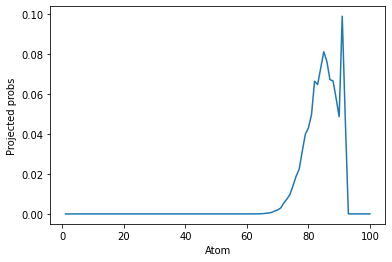

Episode 20: 	Actor Loss: -0.71 	Critic Loss: 3.49 
		Average Score: 6.67

SCORES (this eps):  [ 2.89952437 26.38051365  4.51971888 18.9072589   1.58700826  0.2332052
  0.18936073 36.87048025  2.60537294  9.39909129  0.          2.80489299] 



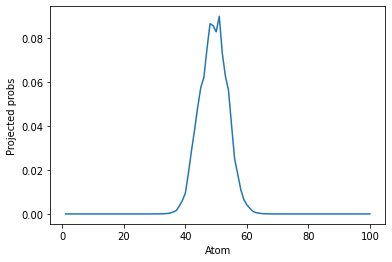

Episode 30: 	Actor Loss: -1.26 	Critic Loss: 3.24 
		Average Score: 15.17

SCORES (this eps):  [ 2.88920881 32.70653648 14.30052326  5.93961219  0.06014626  3.9394429
  7.00643639 37.46380475 32.33754491  2.83740846 14.20339818 34.54401035] 



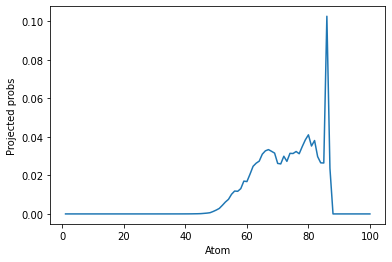

Episode 40: 	Actor Loss: -1.65 	Critic Loss: 2.91 
		Average Score: 17.58

SCORES (this eps):  [14.00867043  0.69958828 29.68590619 12.85219121  5.9247587  17.40327279
 16.50832764  9.10020412 23.97747803 30.8098438  12.86888339  2.97876586] 



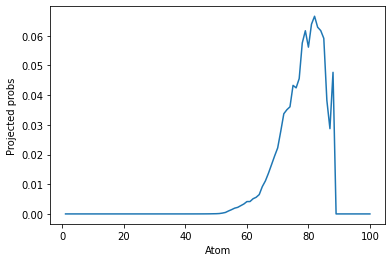

Episode 50: 	Actor Loss: -1.86 	Critic Loss: 2.58 
		Average Score: 34.76

SCORES (this eps):  [  0.25745793  98.96725256 122.05411618   7.3763481  102.75382429
   2.82689134 113.32301861   1.63483436  39.3896426   44.1830127
  46.7069297   24.45222302] 



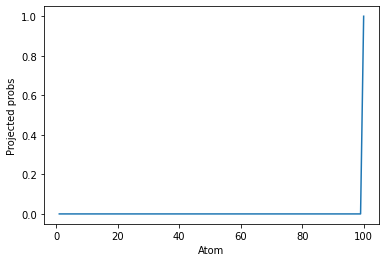

Episode 60: 	Actor Loss: -2.00 	Critic Loss: 2.41 
		Average Score: 35.15

SCORES (this eps):  [83.19988944  0.65596654  4.58019344  3.0482455  11.19690377 11.07524224
 21.09365833 20.55333125 12.32097646 41.68848964 37.83105752 29.68579405] 



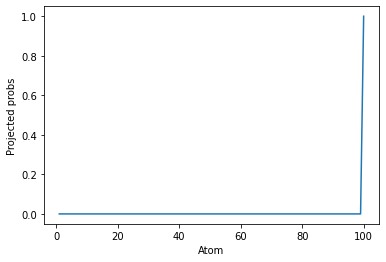

Episode 70: 	Actor Loss: -2.09 	Critic Loss: 2.28 
		Average Score: 28.43

SCORES (this eps):  [ 24.01710785  38.02898312  36.95220003  16.0699624   54.53047862
  14.17270804  28.34623902   0.62028073 129.0136482   25.27802359
   5.25620563  12.55219827] 



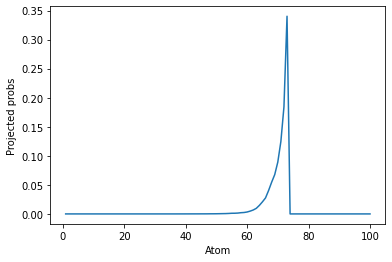

Episode 80: 	Actor Loss: -2.19 	Critic Loss: 2.10 
		Average Score: 33.09

SCORES (this eps):  [ 38.05142353   3.02730985   0.44221269   0.          75.99546677
 119.5351369    2.64994369  44.65880429  20.64938729   6.49249151
  93.17810523  77.7918313 ] 



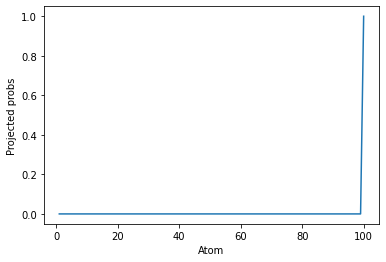

Episode 90: 	Actor Loss: -2.29 	Critic Loss: 1.96 
		Average Score: 31.06

SCORES (this eps):  [33.52272355 12.20488627 71.61732294 44.67192788  6.89496731 21.05743587
 41.22647677  0.41300453 41.33175773 91.89145215 49.70516511 61.49254266] 



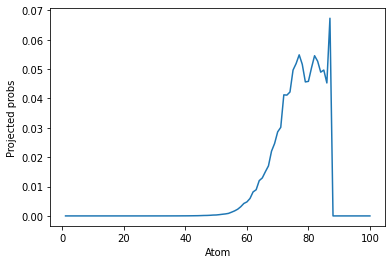

Episode 100: 	Actor Loss: -2.47 	Critic Loss: 1.69 
		Average Score: 34.55

SCORES (this eps):  [94.73088777 29.46077923 80.1161993  22.78425137 34.47056279 81.95186707
 17.27447583  1.87351729 14.27833401 44.44819472 33.88176187 43.3975274 ] 



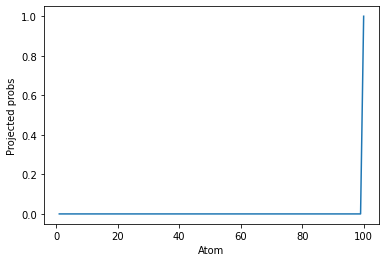

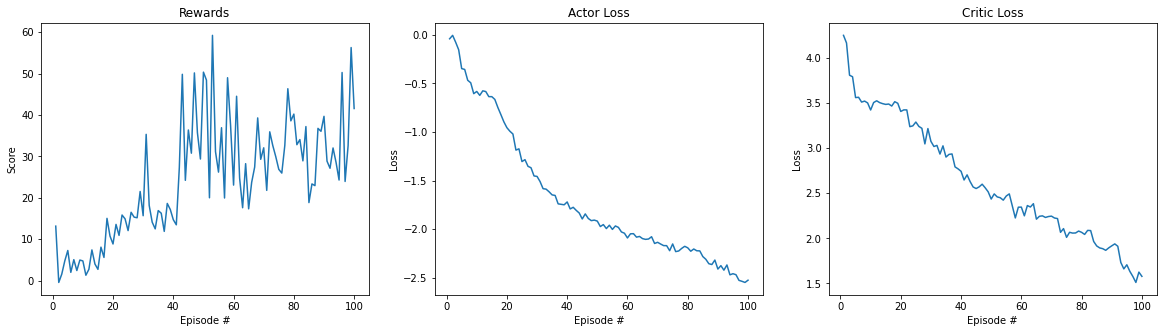

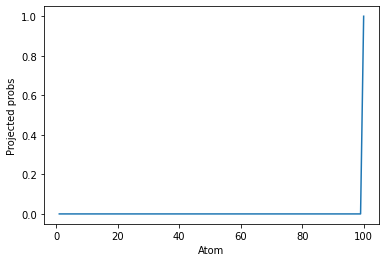

[13.169618048123084,
 -0.41426967195487424,
 1.5983409230830148,
 4.7832698970257,
 7.294767836710283,
 2.0241556794693074,
 5.082918498199433,
 2.461980660834039,
 4.9901577772106975,
 4.778008842481843,
 1.3250028955905389,
 2.763841016800143,
 7.433034607985367,
 4.037255522911437,
 2.7482100050353133,
 8.102181453839876,
 5.619202231571156,
 15.049098140831726,
 10.77614481432829,
 8.866368953313213,
 13.589215234310055,
 10.940940232287781,
 15.854547524979958,
 14.932638250058517,
 12.097034174395958,
 16.513735306449234,
 15.34718047749872,
 15.19414489363165,
 21.535539337666705,
 15.685672746660808,
 35.3197851445002,
 18.189070709592972,
 14.127385993604548,
 12.5106472656286,
 16.92719651547183,
 16.287717697404634,
 11.906933251574324,
 18.648703011878144,
 17.190674034024898,
 14.7348242016742,
 13.494346543874903,
 27.305371957850486,
 49.808689688681625,
 24.223362917546183,
 36.369713431146614,
 30.773604653930914,
 50.14400684086528,
 35.741651912763096,
 29.3693384964

In [30]:
##################
# Vmax = -Vmin = 3
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_3'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_3'
params.num_atoms = 100
params.vmin = -3
params.vmax = 3


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -7.5
VMAX:  7.5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: 0.02 	Critic Loss: 3.33 
		Average Score: 0.53

SCORES (this eps):  [2.47768446 2.30408969 0.19712734 2.08607591 0.76365248 2.02072234
 0.39811182 2.04685278 0.71980869 0.60489631 6.67384455 0.40070391] 



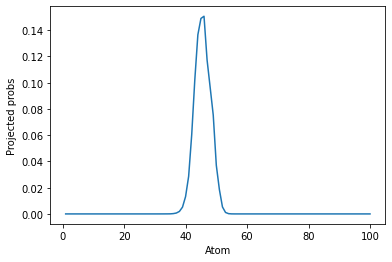

Episode 20: 	Actor Loss: -0.25 	Critic Loss: 2.47 
		Average Score: 3.36

SCORES (this eps):  [ 0.64238304  7.0332646   0.67024481  2.98530058  0.74273335  6.18430234
 15.1928294   3.41470279 -3.97392953 -0.88777342  0.79964198  0.09135   ] 



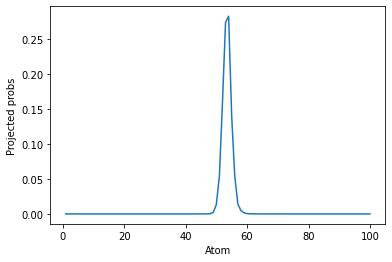

Episode 30: 	Actor Loss: -0.40 	Critic Loss: 2.47 
		Average Score: 5.25

SCORES (this eps):  [ 1.72528776 13.8561957   0.76101594  1.85832517 12.46746817  0.60278357
  4.74868088  7.96711928  9.41961751 11.23387094  0.91547409 19.15064202] 



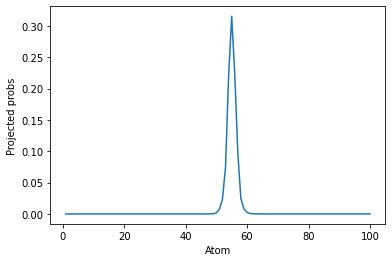

Episode 40: 	Actor Loss: -0.57 	Critic Loss: 2.52 
		Average Score: 3.25

SCORES (this eps):  [1.52298517 0.8622725  0.80383871 1.22345015 0.04927734 0.72354341
 0.54277528 0.28296314 0.2490248  0.29767983 6.20494063 1.64375721] 



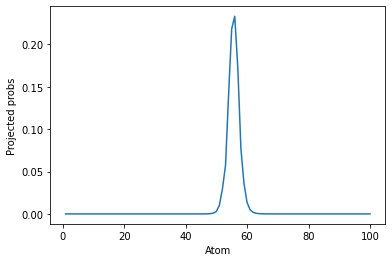

Episode 50: 	Actor Loss: -0.83 	Critic Loss: 2.64 
		Average Score: 4.83

SCORES (this eps):  [18.60571968  2.93070757 -2.94256163 29.26772715  2.1814213   9.78608062
  7.60497975  2.64428772  2.62515096  5.24593026 -0.12307986  0.21416164] 



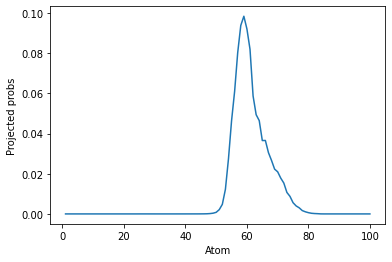

Episode 60: 	Actor Loss: -1.03 	Critic Loss: 2.74 
		Average Score: 7.91

SCORES (this eps):  [9.22044206e-01 1.24553768e-02 2.35240448e+01 6.92299560e+00
 2.75822095e+01 9.25593683e-01 1.61208897e+01 4.67594092e+00
 1.50212934e+01 4.49684234e+00 2.56039418e+00 6.03703069e-01] 



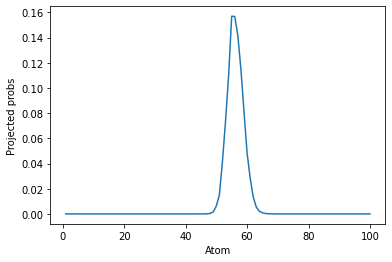

Episode 70: 	Actor Loss: -1.24 	Critic Loss: 2.80 
		Average Score: 10.12

SCORES (this eps):  [ 1.54354115e+01  1.77004722e+01  3.49509373e-01  1.05803128e+01
  1.02564586e+01  3.54382709e+00  6.16186098e+00  1.06768016e+01
  2.97785446e+00 -3.85224819e-04  2.01175511e-02  9.85295134e+00] 



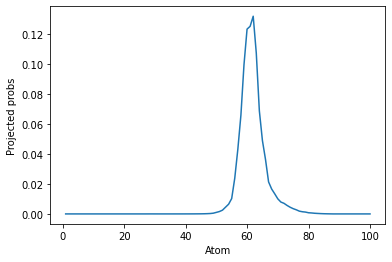

Episode 80: 	Actor Loss: -1.40 	Critic Loss: 2.85 
		Average Score: 12.18

SCORES (this eps):  [22.07072837  6.44604998 25.73697478  7.05140024  7.47527749  0.99673755
  7.88475678  0.59184883 19.40642118  0.81330593 15.10447583 46.48201056] 



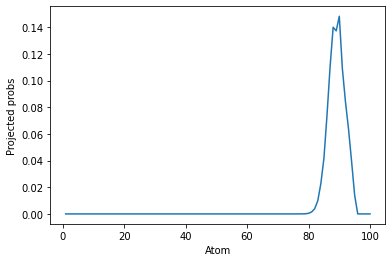

Episode 90: 	Actor Loss: -1.71 	Critic Loss: 2.93 
		Average Score: 15.07

SCORES (this eps):  [ 5.52720034 28.44660227  0.24335442 19.7838152  17.7730032   4.93159534
  2.08597222  2.38771456  4.84773907 10.8031294  32.11568615  0.4625996 ] 



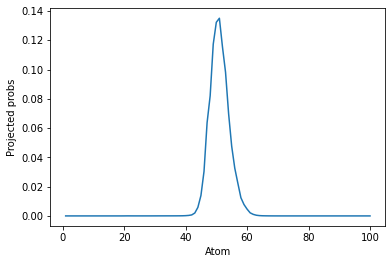

Episode 100: 	Actor Loss: -2.08 	Critic Loss: 2.97 
		Average Score: 23.90

SCORES (this eps):  [1.59934957e-01 5.45219004e+00 9.95920312e+01 5.40575626e+00
 6.31663102e+00 1.46422839e-01 1.73117546e+00 7.17506651e-02
 1.97110716e+01 1.77468951e+01 2.54083256e+00 0.00000000e+00] 



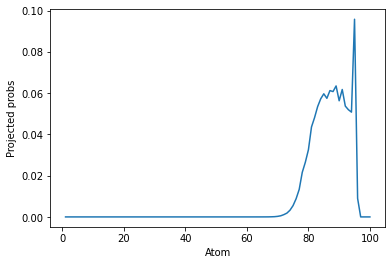

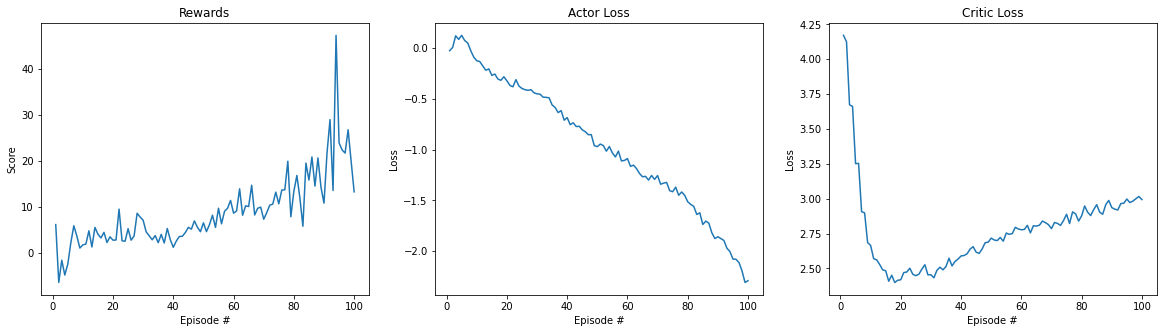

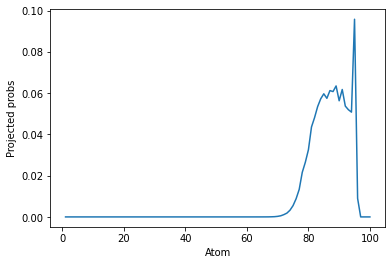

[6.123749904480064,
 -6.43038972299352,
 -1.5966937646492927,
 -4.81802414553628,
 -2.4549823994457256,
 2.1629926102068566,
 5.877693699595208,
 3.645824313396588,
 1.031756986087809,
 1.7244641905417666,
 1.9027889449304591,
 4.772803692554589,
 1.2687923888249013,
 5.518752059064961,
 4.045506257816062,
 3.2332097845695293,
 4.4438139831957715,
 2.231405749664797,
 3.476699148837118,
 2.741254162399855,
 2.7859316192819583,
 9.486706891936288,
 2.6151587911735987,
 2.5078202080003393,
 5.234449502701561,
 2.7459907181037124,
 3.6677970706659835,
 8.58423034681861,
 7.778752112450699,
 7.058873419484978,
 4.5506109484122135,
 3.712381262642642,
 2.8270694869182385,
 3.745540185753877,
 2.2007086638283604,
 4.00374435451037,
 2.1351804486863935,
 5.282713610494587,
 2.867637370189186,
 1.2005423475056887,
 2.558757231628988,
 3.5417359001003206,
 3.5865776255959645,
 4.407623362805073,
 5.5277650110656396,
 5.138256510319479,
 6.926160340507825,
 5.552647890639491,
 4.587769641725269,

In [31]:
##################
# Vmax = -Vmin = 7.5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_7.5'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_7.5'
params.num_atoms = 100
params.vmin = -7.5
params.vmax = 7.5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.1
VMAX:  0.1
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.04 	Critic Loss: 0.92 
		Average Score: 6.97

SCORES (this eps):  [-0.94756257  5.79682834 -8.33892053  0.01677716 -1.80458871  0.1205317
 -4.2834417  -3.30157089 -2.90149866  7.30100595  2.93315669  1.13324125] 



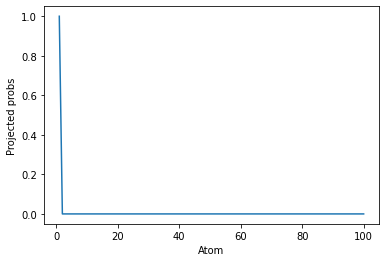

Episode 20: 	Actor Loss: -0.02 	Critic Loss: 0.86 
		Average Score: -6.53

SCORES (this eps):  [  5.43210332  -1.72368333 -11.39298778 -12.05446629  -8.13776714
  -3.80050093   5.42794953  18.98958824   8.77740922 -18.60404532
  -9.63278925  -4.33970081] 



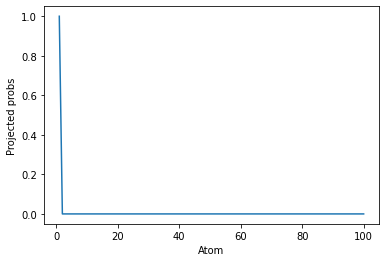

Episode 30: 	Actor Loss: -0.02 	Critic Loss: 1.02 
		Average Score: 0.56

SCORES (this eps):  [-12.87615171   0.90856028  -1.84614228  -0.94626231  -2.59678759
  -6.5348048  -10.02878148   0.87922746  -1.34044729   0.61096436
  -1.38826074   5.97377045] 



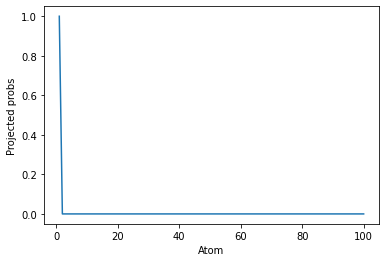

Episode 40: 	Actor Loss: -0.02 	Critic Loss: 1.02 
		Average Score: 0.34

SCORES (this eps):  [ 3.59819445  0.77243601 -2.61079567  0.06279051  0.53343935  5.08701501
  4.51691837  0.53135859  0.11039192  2.69861049  1.40557003 10.98558758] 



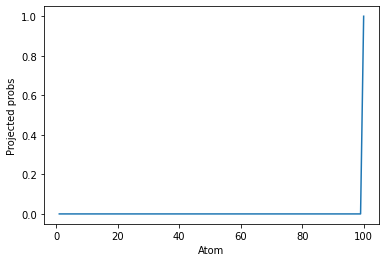

Episode 50: 	Actor Loss: -0.03 	Critic Loss: 0.97 
		Average Score: 2.81

SCORES (this eps):  [0.34043666 1.96652041 2.00267188 1.21579943 1.97583832 2.38713976
 6.78844178 8.90098915 0.23566347 7.44064786 4.25690482 2.27641981] 



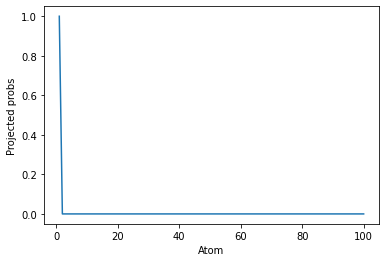

Episode 54\ Score: 1.77

==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([0.5346, 0.5349, 0.5410, 0.5794, 0.6276, 0.5746, 0.5855, 0.5827, 0.5768,
        0.5671, 0.5346, 0.5519, 0.5386, 0.5365, 0.5348, 0.5352, 0.5350, 0.5346,
        0.5486, 0.5410, 0.5374, 0.5352, 0.5353, 0.5387, 0.5431, 0.5393, 0.5579,
        0.5354, 0.5378, 0.5346, 0.5372, 0.5405, 0.5454, 0.5424, 0.5353, 0.5354,
        0.5350, 0.5362, 0.5504, 0.5445, 0.5541, 0.5409, 0.5346, 0.5346, 0.5410,
        0.5346, 0.5494, 0.5403, 0.5383, 0.5364, 0.5359, 0.5390, 0.5411, 0.5375,
        0.5417, 0.5352, 0.5377, 0.5346, 0.5360, 0.5373, 0.5427, 0.5426, 0.5348,
        0.5351, 0.5359, 0.5376, 0.5537, 0.5407, 0.5442, 0.5394, 0.5346, 0.5346,
        0.5363, 0.5346, 0.5520, 0.5405, 0.5380, 0.5357, 0.5359, 0.5413, 0.5388,
        0.5373, 0.5401, 0.5354, 0.5367, 0.5346, 0.5355, 0.5448, 0.5428, 0.5414,
        0.5353, 0.5358, 0.5352, 0.5350, 0.5434, 0.5405, 0.5395, 0.5380, 0.534

Critic/bn1.bias Parameter containing:
tensor([ 5.2053e-02,  2.0952e-02, -1.5467e-02,  2.3899e-02, -1.1610e-02,
         7.4280e-03,  1.8805e-01,  2.7103e-02, -9.8006e-02,  6.6704e-02,
         2.7525e-02, -9.1142e-02, -1.1129e-01, -1.8348e-02, -3.5026e-03,
        -4.3888e-02,  5.8884e-02,  1.4079e-02,  6.7331e-02, -6.8108e-03,
         1.8749e-01,  4.9626e-02,  5.2648e-02,  7.6761e-02,  1.5861e-01,
         2.6168e-01, -9.6042e-02, -2.5806e-02, -3.3082e-02,  3.0455e-02,
         7.6882e-02,  5.3600e-02,  5.2040e-02, -2.4521e-02,  2.7987e-03,
        -3.0641e-02, -2.0996e-02, -9.7458e-02, -1.4047e-01,  5.5277e-02,
        -6.4864e-02,  1.0849e-01,  2.5686e-02,  3.5209e-02, -7.0233e-02,
         6.1165e-02,  4.8854e-02,  3.6306e-02,  3.9597e-02, -7.0249e-02,
         1.8309e-04, -8.4198e-03, -3.9588e-02,  3.8281e-02,  1.1003e-02,
        -1.1143e-01, -1.3853e-01,  1.6535e-02,  9.4515e-03, -7.7184e-02,
         7.0222e-02, -5.1153e-02, -5.0381e-03,  7.5631e-02, -5.0969e-02,
        -2.84

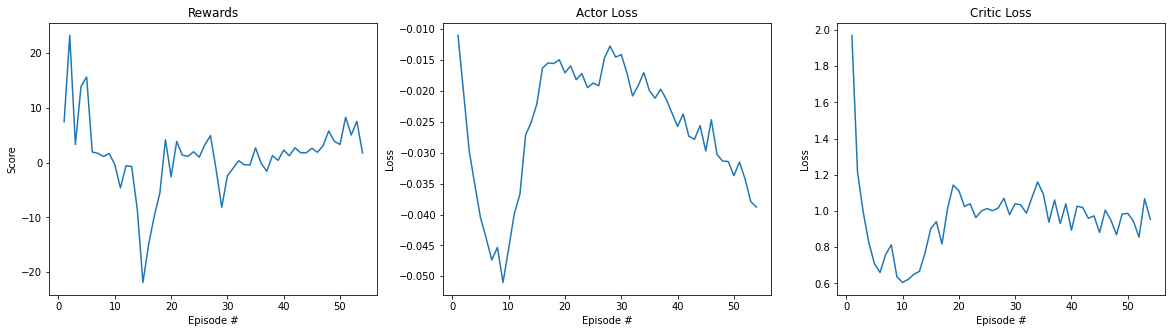

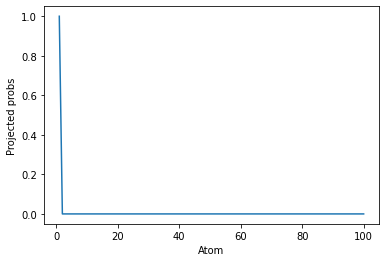

[7.469194573825614,
 23.253153988179594,
 3.3159084873429188,
 13.904195552449286,
 15.652415883130743,
 1.9351660708974425,
 1.6969722212525085,
 1.1226259041577578,
 1.6585888878131907,
 -0.3563368311927964,
 -4.615814999948877,
 -0.5600575836530576,
 -0.7167331444021935,
 -8.621466335452473,
 -21.903968302271096,
 -15.019650448632698,
 -9.839239315978679,
 -5.603920027373533,
 4.178790398713318,
 -2.588240878918441,
 3.8748047751626777,
 1.3560213817108888,
 1.1476187383717236,
 1.9820111744920723,
 0.981998452412275,
 3.2619726205787933,
 4.922567370629015,
 -1.2960883605313331,
 -8.15874093818517,
 -2.4320929694416313,
 -1.0445585100872752,
 0.34108469980613637,
 -0.3832383491098881,
 -0.45148619334213436,
 2.6966043045201027,
 -0.13499340469328067,
 -1.5781607686173327,
 1.2752614832522038,
 0.40939878034987487,
 2.3076263856686032,
 1.2501075464921694,
 2.709665880751951,
 1.8045460631450017,
 1.783770779108939,
 2.6217652272995715,
 1.8860525060736109,
 3.0911117685803524,
 5.7

In [32]:
##################
# Vmax = -Vmin = 0.1
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.1'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.1'
params.num_atoms = 100
params.vmin = -0.1
params.vmax = 0.1


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.25
VMAX:  0.25
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.04 	Critic Loss: 1.83 
		Average Score: 1.10

SCORES (this eps):  [ 0.58791866  2.69589556  5.02184226  2.57364848 29.25243833  5.68175721
  0.07554481 -0.22656945  0.52121231  1.70495737  6.65312792  0.31664857] 



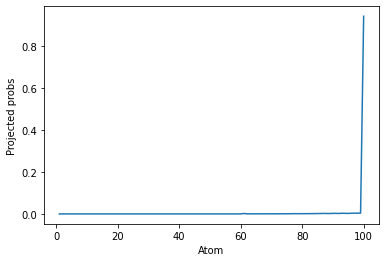

Episode 20: 	Actor Loss: -0.06 	Critic Loss: 1.63 
		Average Score: 0.65

SCORES (this eps):  [-2.06330587  0.99455159  1.69675348  0.54837577  0.14893599  2.19251914
  0.11651315  2.98755234  0.77289309  2.61388184  0.3736462  -1.6054482 ] 



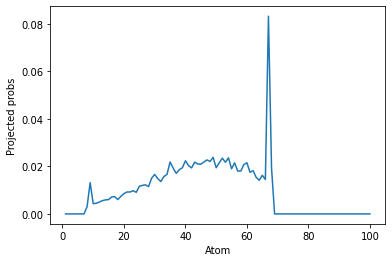

Episode 30: 	Actor Loss: -0.06 	Critic Loss: 2.16 
		Average Score: -4.28

SCORES (this eps):  [ 13.57967332  12.81993597 -14.13146284  10.74281829  10.6169815
   2.49648269   1.60690722  -1.82116981  11.27849647   4.06381451
   6.24416986   3.44490858] 



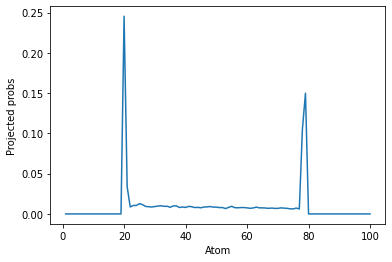

Episode 40: 	Actor Loss: -0.07 	Critic Loss: 2.33 
		Average Score: 12.39

SCORES (this eps):  [ 7.65902088 39.42717404 18.79854573  0.41950665  7.78723551 29.04964539
 13.14972099 16.58184128  1.70834328 38.42843119  3.64078532  6.3330828 ] 



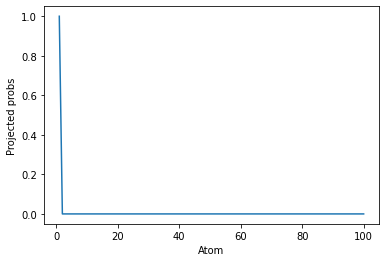

Episode 50: 	Actor Loss: -0.10 	Critic Loss: 2.32 
		Average Score: 23.93

SCORES (this eps):  [ 4.00874013 51.09069383 62.21216063 44.42022512 52.623658    4.20790923
 17.56769732 10.38538145 29.71666278 58.58523004  0.         24.85883167] 



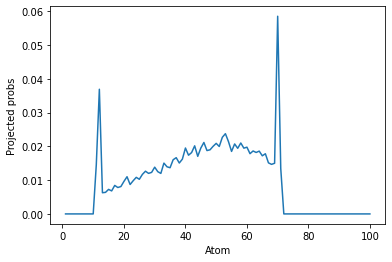

Episode 60: 	Actor Loss: -0.12 	Critic Loss: 2.14 
		Average Score: 28.91

SCORES (this eps):  [13.42531224 36.24979781 86.03776737 18.78264173 23.64404915 23.61146379
  7.57433449 11.31908154 12.86347092 13.04005232 10.86987098 72.5664596 ] 



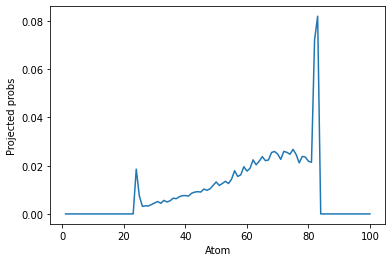

Episode 70: 	Actor Loss: -0.14 	Critic Loss: 1.95 
		Average Score: 26.65

SCORES (this eps):  [  5.31393428  33.18545845  65.53324876  56.33521536  31.9775603
  45.18496126 101.42946162  11.23451439  15.31005341  26.52502936
  23.86306608  30.737385  ] 



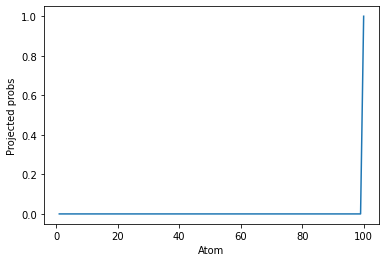

Episode 80: 	Actor Loss: -0.15 	Critic Loss: 1.74 
		Average Score: 34.00

SCORES (this eps):  [ 37.24978231  26.11767501 116.45561871   4.93236317  44.27876222
   2.87472055  41.05176396  32.26115711  47.50449739   7.35248195
   6.4841399   98.38253519] 



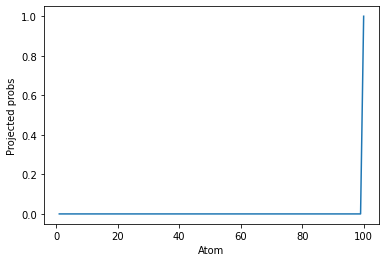

Episode 90: 	Actor Loss: -0.16 	Critic Loss: 1.63 
		Average Score: 44.30

SCORES (this eps):  [ 36.28193351  74.89657975  11.077598     9.22103438   9.18711866
  25.65889159 110.55164021  19.47090282  49.96730985  26.1302538
  34.51254679   3.45902302] 



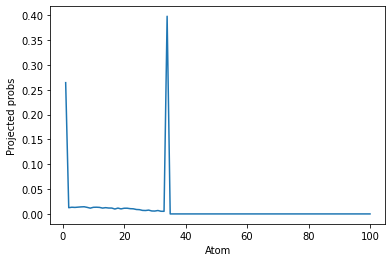

Episode 100: 	Actor Loss: -0.17 	Critic Loss: 1.51 
		Average Score: 57.38

SCORES (this eps):  [ 77.84602959 113.2864492  109.57239891  65.68526906  21.21620012
  97.06022948  47.44373874  79.0255822   35.40333732  98.02028865
  93.47089148 107.26975114] 



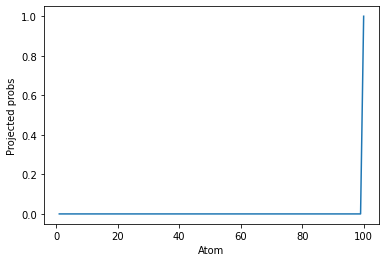

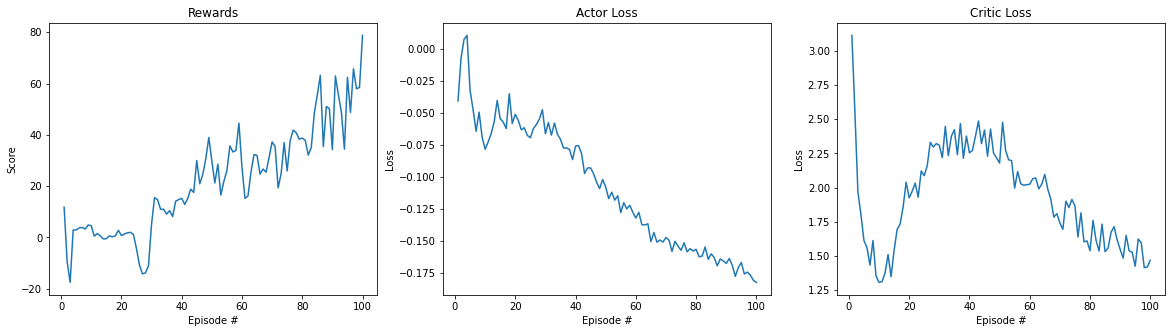

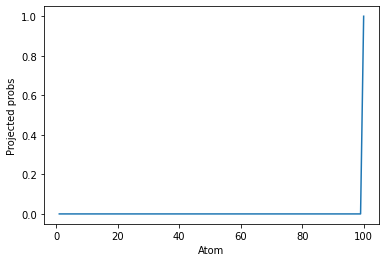

[11.78390031994301,
 -9.378222824200444,
 -17.55189378120849,
 2.8799226440799734,
 2.9007252799735093,
 3.73364605991325,
 3.899321770935785,
 3.26304053333782,
 4.850323584706833,
 4.571535169496201,
 0.5040270758715147,
 1.496981331690525,
 0.6199002344316492,
 -0.5793098320912881,
 -0.5096942709169525,
 0.5915628250416679,
 0.24804192168327668,
 0.5943071646033786,
 2.7731824793299893,
 0.7314057093656933,
 1.3267019994867344,
 1.7968418166662257,
 1.986324304365553,
 1.1137603431125171,
 -4.33596492294843,
 -10.78651954860834,
 -14.225168180603456,
 -13.826313622640251,
 -10.94906449819488,
 5.078462979702938,
 15.501428706911005,
 14.715310582997821,
 10.990373986559765,
 10.980760503327474,
 9.091840672733573,
 10.436121886023708,
 8.116963235428557,
 14.107299506911659,
 14.753455892505977,
 15.248611087474274,
 12.868463353486732,
 15.135249679364884,
 18.817768157590763,
 17.554489521193318,
 29.98714434336095,
 20.877032378552638,
 24.53637133635736,
 30.634754235157743,
 38

In [34]:
##################
# Vmax = -Vmin = 0.25
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.25'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.25'
params.num_atoms = 100
params.vmin = -0.25
params.vmax = 0.25


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.75
VMAX:  0.75
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.02 	Critic Loss: 3.40 
		Average Score: -1.62

SCORES (this eps):  [0.87494889 3.38793795 2.92216905 1.22829646 1.44069943 0.43259007
 1.25332318 2.79370089 0.11711715 1.8837858  1.86316748 2.44887953] 



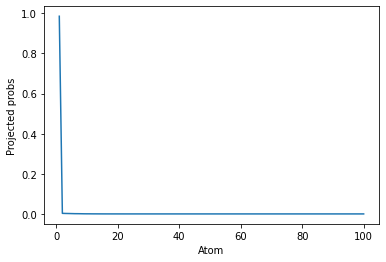

Episode 20: 	Actor Loss: -0.26 	Critic Loss: 3.05 
		Average Score: 2.98

SCORES (this eps):  [-9.88458005  0.38733949  3.9644308   0.80959877  3.60322048  0.13446978
 -1.6234351   1.96801613  2.89325059  0.93805375  0.          4.90863696] 



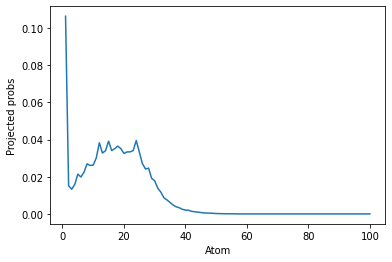

Episode 30: 	Actor Loss: -0.38 	Critic Loss: 2.55 
		Average Score: 6.71

SCORES (this eps):  [ 0.82214527  4.39810624  2.33979919  2.35005641  4.22927208  5.47908987
  9.92397518  8.48931353  5.55795204  5.11406411 11.32479369  2.42716236] 



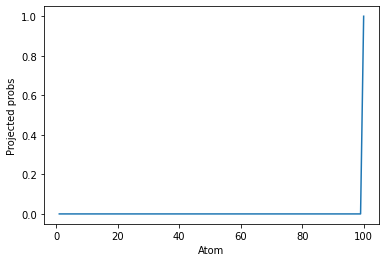

Episode 38\ Score: 16.22NaN Reward Found! Setting to 0...

NaN found in states. Skipping this episode.
Episode 39\ Score: 7.53
NaN found in actions. Skipping this episode.


==== An exception occurred: The histogram is empty, please file a bug report.

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, n

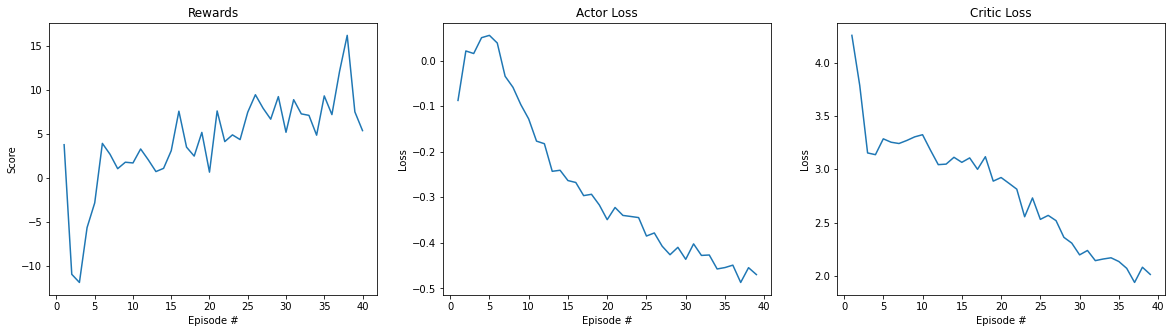

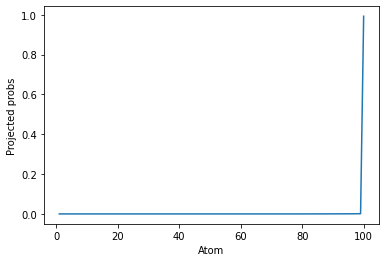

[3.7930394115513386,
 -10.935757037009656,
 -11.85889062502732,
 -5.626111121693005,
 -2.8161325418429137,
 3.943151611233285,
 2.7046986635929593,
 1.068924840927745,
 1.8025646027332793,
 1.7205513236888994,
 3.3077619290755442,
 2.076160409643004,
 0.7385919817412893,
 1.1070215974662763,
 3.113748132251203,
 7.600668211118318,
 3.516386763580764,
 2.4976017074659467,
 5.1905910614489885,
 0.674916798947379,
 7.627435868702984,
 4.1453680243964,
 4.909104377108936,
 4.374926639177526,
 7.48846758781777,
 9.470644367936378,
 7.943463497601139,
 6.693312989703069,
 9.256808896258008,
 5.20464416500181,
 8.908949932044683,
 7.296009023169366,
 7.126554792708096,
 4.875708007059681,
 9.338678959485454,
 7.213402021288251,
 12.127456162551729,
 16.218714376407053,
 7.527703233810219,
 5.395551540190354]

In [35]:
##################
# Vmax = -Vmin = 0.75
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=100
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.75'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.75'
params.num_atoms = 100
params.vmin = -0.75
params.vmax = 0.75


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

## Training for longer periods of time...


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.5
VMAX:  0.5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.08 	Critic Loss: 3.27 
		Average Score: 7.21

SCORES (this eps):  [ -3.48394353 -19.87779433   1.7940252  -15.80512514 -15.34040895
  39.06676207  87.6680508   57.18090585 -25.08116238   0.31233507
   0.41529899   2.70780096] 



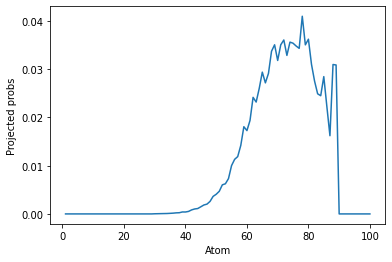

Episode 20: 	Actor Loss: -0.10 	Critic Loss: 3.26 
		Average Score: 2.45

SCORES (this eps):  [ -3.49798899  -8.55690674   4.11266258   4.8060932    2.0393074
  -9.7282432   -0.15070048 -10.6432631   -2.04432643  -9.97472336
   6.16256687 -18.34497729] 



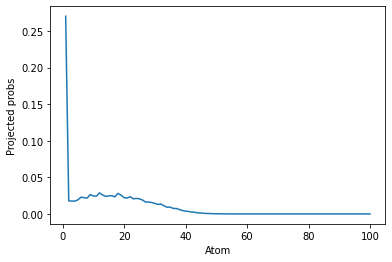

Episode 30: 	Actor Loss: -0.13 	Critic Loss: 3.20 
		Average Score: 10.45

SCORES (this eps):  [ 6.45323554  4.70770375  2.414364   16.30676805  5.12713869 13.02865802
  3.69726859 12.90557237 20.65260598  4.55970784  0.30276256 38.95801656] 



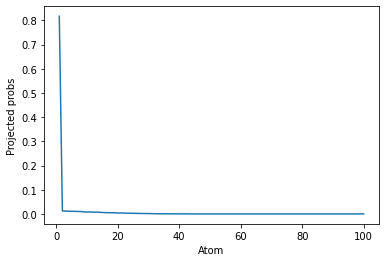

Episode 40: 	Actor Loss: -0.21 	Critic Loss: 2.85 
		Average Score: 9.60

SCORES (this eps):  [ 4.62976391 40.37523878  6.35072548 14.27846236  3.15776049  7.38158808
  8.07082698 10.52049946  6.35784263  3.70827106  3.14778104  0.17615863] 



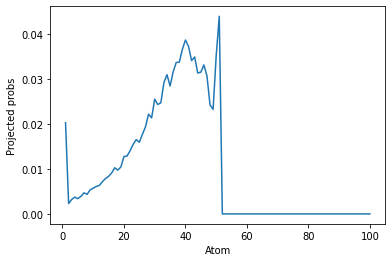

Episode 50: 	Actor Loss: -0.26 	Critic Loss: 2.60 
		Average Score: 10.91

SCORES (this eps):  [ 1.53146289 43.74338761 12.71837249 17.35071088  4.15746615  0.72396746
  6.78394602  5.50596352  2.59441425  4.12899301 17.09269726 30.50230336] 



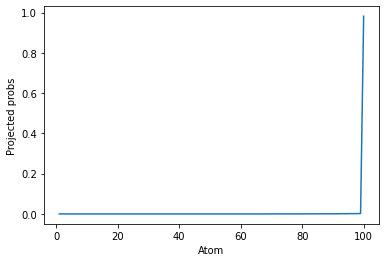

Episode 60: 	Actor Loss: -0.28 	Critic Loss: 2.32 
		Average Score: 10.92

SCORES (this eps):  [45.97339718 13.03351714  4.3139362   3.09269554 16.7495758  23.62348398
 15.10267819  6.37359986 26.15870892  6.80334357  6.11691633 17.25049578] 



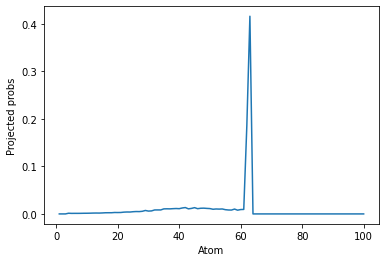

Episode 70: 	Actor Loss: -0.31 	Critic Loss: 2.11 
		Average Score: 11.69

SCORES (this eps):  [ 8.53961374  9.76921666 20.57199625 15.29314678  8.00042779 14.46832661
 10.9571419   5.56429402 37.3956532   7.27220761 14.74846128 28.85410624] 



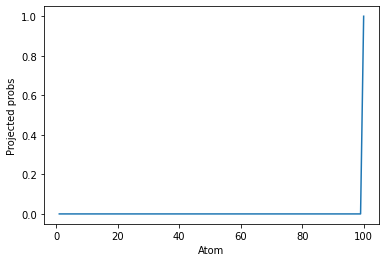

Episode 80: 	Actor Loss: -0.33 	Critic Loss: 1.87 
		Average Score: 14.79

SCORES (this eps):  [31.63404431 20.71262117 11.39819497 10.82093759 27.8540293  46.09816082
  2.25064353  0.16967498 16.29837876 32.23290619 18.62802807  9.23348456] 



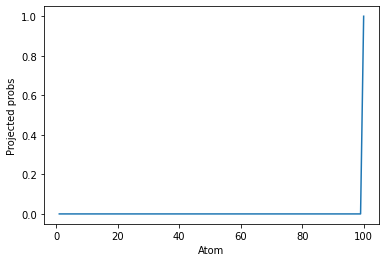

Episode 90: 	Actor Loss: -0.35 	Critic Loss: 1.75 
		Average Score: 10.70

SCORES (this eps):  [ 7.94214362 17.9814706   0.61546823 11.84973833 14.8333348  13.99391051
 15.27614992 18.68187952 12.18344573 11.55092987 19.93060386 27.5033874 ] 



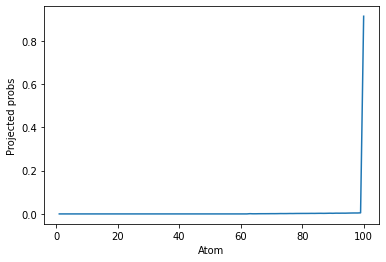

Episode 100: 	Actor Loss: -0.38 	Critic Loss: 1.42 
		Average Score: 15.34

SCORES (this eps):  [ 1.75641626 37.78800835 25.2111018  20.02899054 12.41899616 29.84614785
 96.4269407  29.00639506 13.88390903  8.43421294 46.15036292 19.70526   ] 



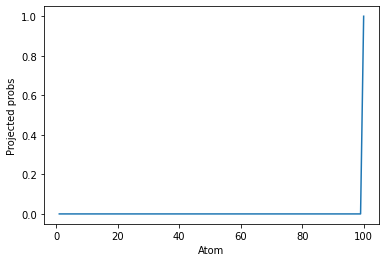

Episode 110: 	Actor Loss: -0.40 	Critic Loss: 1.06 
		Average Score: 21.73

SCORES (this eps):  [ 0.31636296 73.52721169  5.37077008 21.63368253 34.24662153  2.66583904
  4.7377348  25.07791054 15.60219922  8.20423482 19.63761583  1.69414343] 



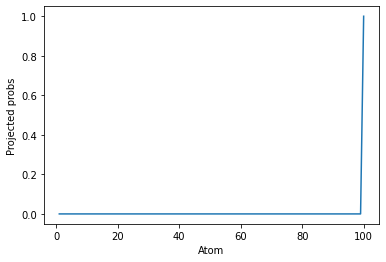

Episode 120: 	Actor Loss: -0.42 	Critic Loss: 0.87 
		Average Score: 23.77

SCORES (this eps):  [26.28883395  2.70912702 56.82959252 16.84977129 23.43012253  7.92479606
 23.36720756 51.13277285 17.32448426  5.5104001  12.70287269 15.39716752] 



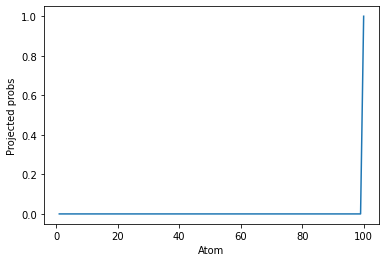

Episode 130: 	Actor Loss: -0.43 	Critic Loss: 0.68 
		Average Score: 37.68

SCORES (this eps):  [ 40.37171062   2.16783297  89.01286932   4.66851422  81.11468692
 102.46917551   8.57541      3.3002219    2.3376436   38.28601758
  33.1660007   22.19665763] 



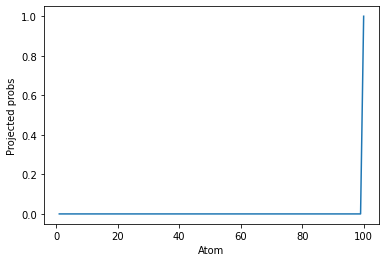

Episode 140: 	Actor Loss: -0.45 	Critic Loss: 0.58 
		Average Score: 55.15

SCORES (this eps):  [ 36.21019755   9.8521631    1.57743781 168.73653377 203.06241209
  85.31051438  20.81701185  80.03869629  26.82774071  29.32553696
   7.69588038  42.25179227] 



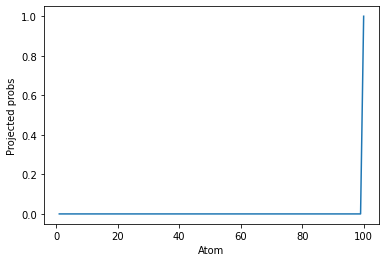

Episode 150: 	Actor Loss: -0.46 	Critic Loss: 0.46 
		Average Score: 63.69

SCORES (this eps):  [ 36.23542127  16.51856947   3.05844437  36.08112206   1.27060422
  58.00122     69.93517232  31.08550641 135.65916867  45.56173324
  12.2695584   18.2611841 ] 



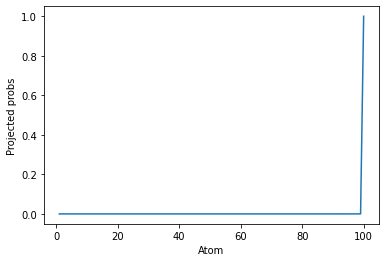

Episode 160: 	Actor Loss: -0.46 	Critic Loss: 0.42 
		Average Score: 64.77

SCORES (this eps):  [  7.22468107  30.90114417  25.61543429 117.81404791   9.14679847
  36.65584336  11.30789944  96.65011858  38.19182843  58.02563795
  89.12079969  45.8229497 ] 



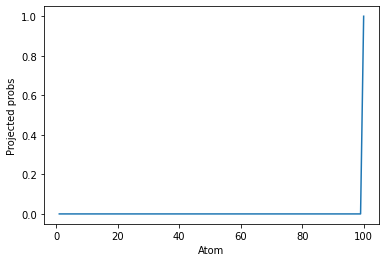

Episode 170: 	Actor Loss: -0.47 	Critic Loss: 0.34 
		Average Score: 55.80

SCORES (this eps):  [ 73.39105388  24.94467806   6.13173331  90.63271931  47.01187171
  29.58755914 168.15877151 176.49021399 107.25526351  34.56157576
  79.39595427  40.53431933] 



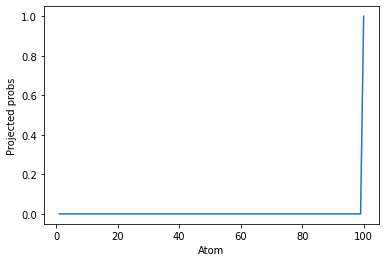

Episode 180: 	Actor Loss: -0.48 	Critic Loss: 0.32 
		Average Score: 65.87

SCORES (this eps):  [51.81739089 33.21370626 57.68183768 10.33492981 86.98748145 42.73891993
 10.49054171  9.96734778 76.23664286 36.01891551 46.26105169 56.17076485] 



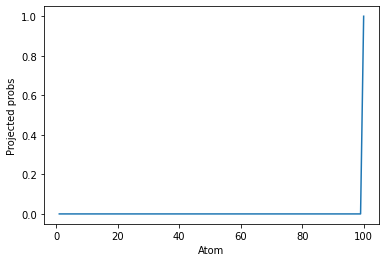

Episode 190: 	Actor Loss: -0.48 	Critic Loss: 0.31 
		Average Score: 83.60

SCORES (this eps):  [ 32.65261603  19.82274833  19.9629011   93.21750554  83.28892815
  47.26357366  12.40585977 108.93288369  14.88589497 107.1788845
  66.82762402 145.11424543] 



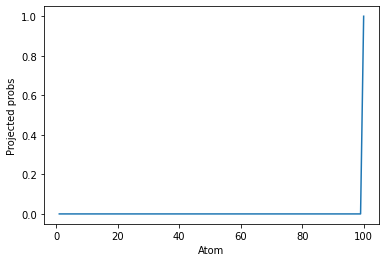

Episode 200: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 71.64

SCORES (this eps):  [134.37782541  24.38417636 175.20734952  22.20284784  14.14531769
  10.49168018  88.18131686  15.94862012   5.45869103 155.89257601
 118.47802194  88.03293956] 



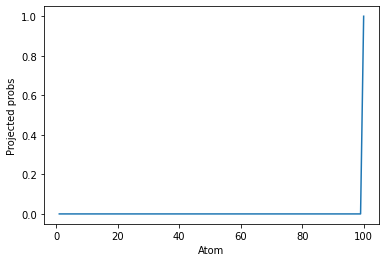

Episode 210: 	Actor Loss: -0.48 	Critic Loss: 0.28 
		Average Score: 68.81

SCORES (this eps):  [129.76673233  85.61244496  43.76155634   0.         132.26630961
   0.53801237  94.42148621  96.13719668   0.14182854  62.72871563
  32.88964036  42.08243957] 



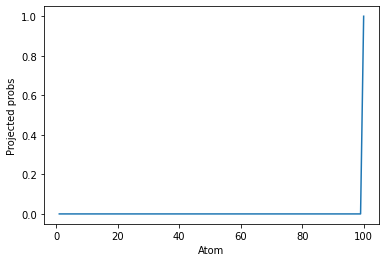

Episode 220: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 84.87

SCORES (this eps):  [ 78.44615095 135.47210121   4.35384543  87.66798307  72.93858727
  47.95579079 134.12842373  45.87557911 166.32532537  99.16366609
  10.54910242  47.23264478] 



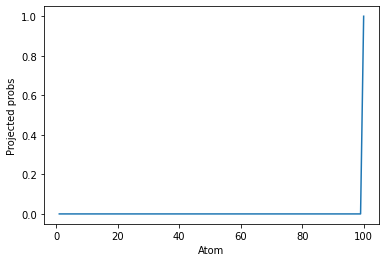

Episode 230: 	Actor Loss: -0.48 	Critic Loss: 0.30 
		Average Score: 73.19

SCORES (this eps):  [  8.74320032  68.67913863  23.12914974  21.61344317 176.51910012
  23.20307027  35.72677627  30.76566023  72.37394877  77.32015934
  36.99165408   4.08324207] 



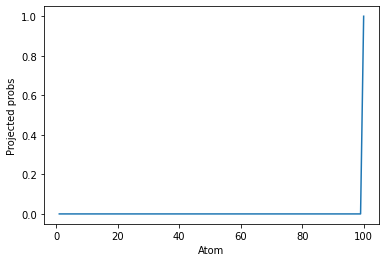

Episode 240: 	Actor Loss: -0.48 	Critic Loss: 0.31 
		Average Score: 103.54

SCORES (this eps):  [ 79.84442562 131.99486464 109.20588674 175.88333085  72.75763513
 158.76378779  54.02524808 152.05969335 150.75621753  27.3302083
 112.91979117 116.44665794] 



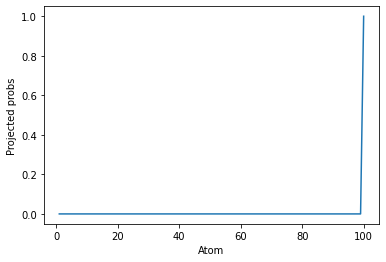

Episode 250: 	Actor Loss: -0.48 	Critic Loss: 0.32 
		Average Score: 89.24

SCORES (this eps):  [147.86050072  71.61784858  61.36039512  88.70627312 169.3130773
  14.9931093  158.0703741  169.62215263 172.5466701  122.1788478
 148.82572913  29.63899437] 



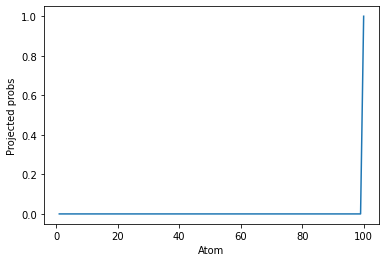

Episode 260: 	Actor Loss: -0.48 	Critic Loss: 0.29 
		Average Score: 82.78

SCORES (this eps):  [152.90041703  33.48950279 156.19061187 129.72666875  21.27158007
 122.35112341 196.44190577 150.1350908   55.37200818 128.16349561
  26.1674432   32.61206575] 



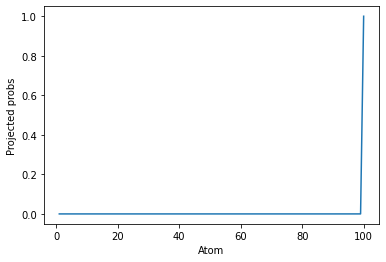

Episode 270: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 86.39

SCORES (this eps):  [150.05121433 167.24328053 156.09694752  16.30205935 170.96188585
 137.15509501 156.71288684  26.77722057 151.02427767  13.0001607
 163.57695083 181.0973041 ] 



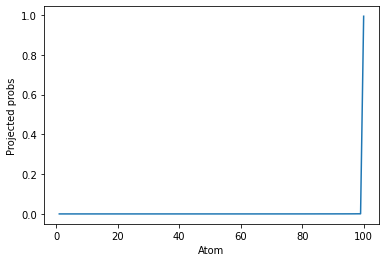

Episode 280: 	Actor Loss: -0.49 	Critic Loss: 0.24 
		Average Score: 122.01

SCORES (this eps):  [163.56832568 168.97016147  12.64904448 180.85556995 164.21288174
 118.46878285 161.20407698 151.33362283 167.58095952 111.17451851
 169.59861099  58.61031277] 



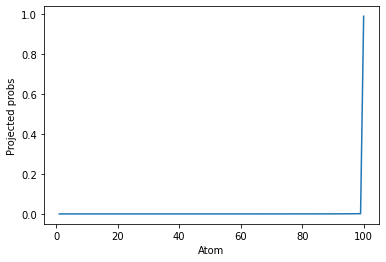

Episode 290: 	Actor Loss: -0.49 	Critic Loss: 0.23 
		Average Score: 120.38

SCORES (this eps):  [149.73460494 154.73568737  61.79924485  90.24667322  26.14267835
 163.90454705   3.98402206 127.26604417  23.48681999 141.00851855
 163.87111121 165.75697838] 



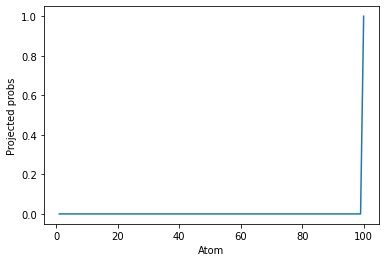

Episode 300: 	Actor Loss: -0.49 	Critic Loss: 0.22 
		Average Score: 109.14

SCORES (this eps):  [164.08342004 176.12077947  95.37996747  78.47539338  35.30338161
  92.56756612 160.67192323 164.58656977 153.58703759 153.41872878
  58.04457858 162.28854543] 



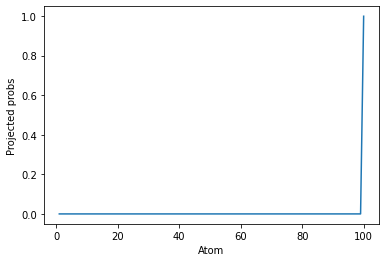

Episode 310: 	Actor Loss: -0.49 	Critic Loss: 0.20 
		Average Score: 93.35

SCORES (this eps):  [168.66037997 175.05297335  52.11508087  19.45923189 174.23867452
  17.6459559  104.03500358  85.74056596  33.28304047  61.07348007
  99.97712441  97.53930151] 



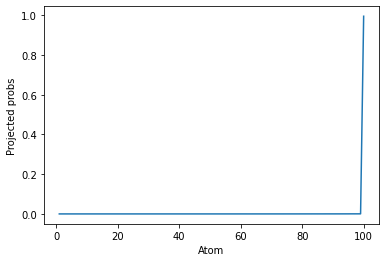

Episode 320: 	Actor Loss: -0.49 	Critic Loss: 0.18 
		Average Score: 90.51

SCORES (this eps):  [149.46278711   9.21491133  80.2417546   10.61997054 135.67479806
   9.4791004   77.61492872  25.66427493  43.44307768  27.57323548
  71.51225213  83.65412033] 



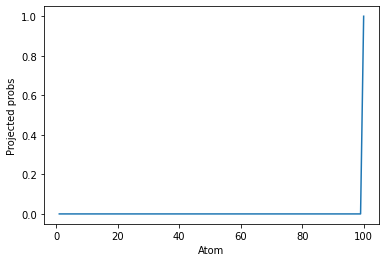

Episode 330: 	Actor Loss: -0.49 	Critic Loss: 0.18 
		Average Score: 87.29

SCORES (this eps):  [ 42.66763852 100.8248827  150.70488788 110.65302339 157.28900842
  49.18580997   6.37278819 164.78130937  18.15454924  36.53240092
  38.33455706  83.87597044] 



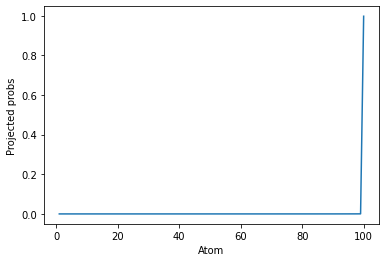

Episode 340: 	Actor Loss: -0.49 	Critic Loss: 0.18 
		Average Score: 57.53

SCORES (this eps):  [ 38.39333868 170.22635795   3.41540099  51.69600782  17.68087066
  67.82386407  42.10442793   0.77367102 113.90862614  33.30508817
   3.7078326  158.09766431] 



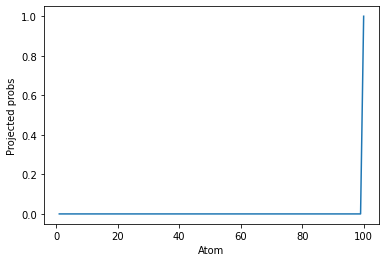

Episode 350: 	Actor Loss: -0.49 	Critic Loss: 0.19 
		Average Score: 87.52

SCORES (this eps):  [ 26.70807073  14.25526615  87.08981876  61.77531518 164.03398812
 145.33217683 106.35530223 138.27459879  99.73585267   9.41872812
 123.65594158 125.90037971] 



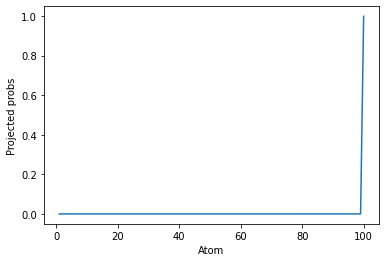

Episode 360: 	Actor Loss: -0.49 	Critic Loss: 0.23 
		Average Score: 77.49

SCORES (this eps):  [ 55.42563682 110.89005664  42.99545926  18.38659997 115.83125618
  16.06275099  11.71173172 161.52001616  41.03177131 126.83658334
   8.36535692  57.77265249] 



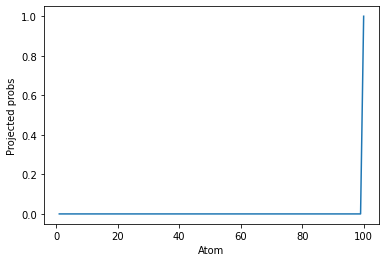

Episode 370: 	Actor Loss: -0.48 	Critic Loss: 0.24 
		Average Score: 96.88

SCORES (this eps):  [139.83015534  31.89646161  40.0774725   43.41001658  11.51091563
  99.74992733 155.59765628 151.16815966  16.72143281 150.72231802
  56.64261672  22.77909522] 



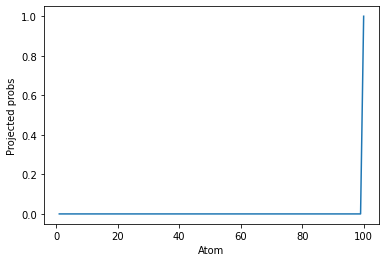

Episode 380: 	Actor Loss: -0.48 	Critic Loss: 0.23 
		Average Score: 69.52

SCORES (this eps):  [ 22.44691638 151.69090399  20.88099706  53.8073021   49.81538957
   5.09992159   5.0560903   41.12765815  32.80474667 153.78772892
 170.70292643  31.23969487] 



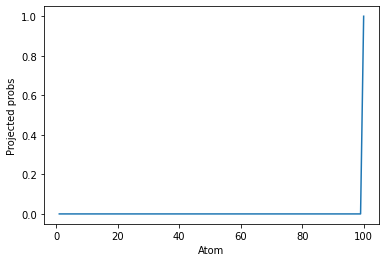

Episode 390: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 75.45

SCORES (this eps):  [ 60.29489584  75.14581278  14.33638655 111.09162055  27.38465834
  62.34919699  54.62248406 160.90777302  24.93785509 131.27016096
  80.91406638  72.11722549] 



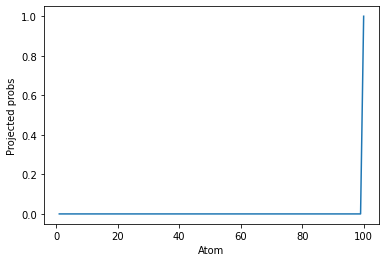

Episode 400: 	Actor Loss: -0.48 	Critic Loss: 0.30 
		Average Score: 65.24

SCORES (this eps):  [26.19770241 42.42894167 62.96053446 23.76446187 47.70727557 26.58903412
 31.01698548 39.90690923  5.83791481 76.30604169 99.77678125 23.09334911] 



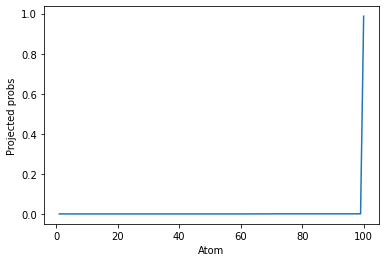

Episode 410: 	Actor Loss: -0.48 	Critic Loss: 0.29 
		Average Score: 87.74

SCORES (this eps):  [157.93911155  28.4292174  161.13345687  22.40597346 184.124127
 133.78753162 163.96829222  86.39296912  23.55593127 154.20758583
  25.62331085 172.37464762] 



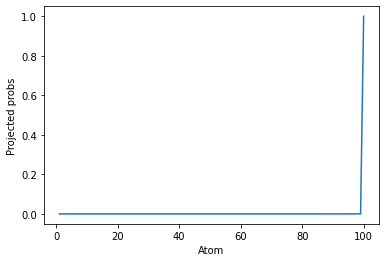

Episode 420: 	Actor Loss: -0.47 	Critic Loss: 0.31 
		Average Score: 93.26

SCORES (this eps):  [165.2452449   49.58589872 163.51188881  87.76045054  62.59574586
  75.87122393 164.6884866  161.30806405 110.31751793 146.91554424
 105.18741696  40.38166826] 



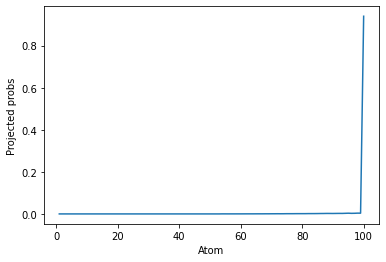

Episode 430: 	Actor Loss: -0.48 	Critic Loss: 0.29 
		Average Score: 105.16

SCORES (this eps):  [154.65246416  91.25952552  28.07411471 173.67342939 157.98993861
 161.72808212 160.32567151 166.73590987  23.23177116 158.54006784
 167.21163254   5.26288273] 



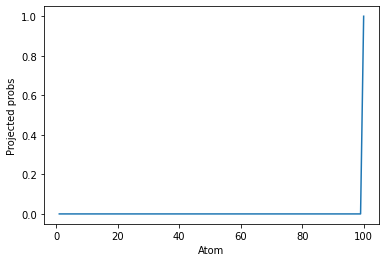

Episode 440: 	Actor Loss: -0.48 	Critic Loss: 0.29 
		Average Score: 97.35

SCORES (this eps):  [ 17.18724632  30.70370101 162.29420659 137.35986489 153.64531582
 132.22558453 143.41212955 100.12726905   3.2061107  125.3225304
 163.80577113  38.61474782] 



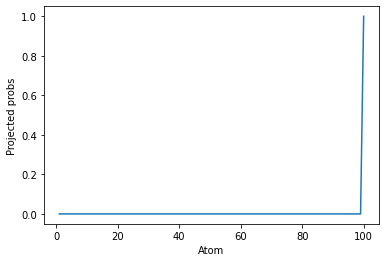

Episode 444\ Score: 62.185

==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([1.3394e-14, 6.3572e-12, 4.8541e-02, 2.3332e-01, 1.8078e-01, 1.5905e-01,
        1.5148e-01, 2.1463e-01, 1.9068e-01, 1.1236e-01, 1.4665e-15, 8.0809e-02,
        6.1363e-02, 2.2936e-02, 4.1477e-02, 4.6219e-02, 6.5838e-02, 1.4665e-15,
        1.0834e-01, 7.7225e-02, 3.8626e-02, 3.4286e-02, 3.4753e-02, 5.5307e-02,
        4.7908e-02, 7.5290e-02, 3.8525e-02, 4.6691e-02, 2.5371e-02, 1.4665e-15,
        3.9355e-02, 5.3516e-02, 7.0310e-02, 7.0610e-02, 4.4014e-02, 3.8977e-02,
        3.9870e-02, 5.2165e-02, 7.9669e-02, 9.9382e-02, 7.9022e-02, 4.7932e-02,
        1.4665e-15, 1.4665e-15, 4.0131e-02, 1.4665e-15, 9.6430e-02, 9.1350e-02,
        5.4758e-02, 4.0161e-02, 4.4567e-02, 3.6568e-02, 6.3861e-02, 4.7865e-02,
        4.5181e-02, 4.0860e-02, 4.4975e-02, 1.4665e-15, 3.7554e-02, 5.3464e-02,
        7.6425e-02, 6.7936e-02, 4.0194e-02, 4.2096e-02, 4.2125e-02, 6.7597

Actor/bn2.bias Parameter containing:
tensor([0.1092, 0.0445, 0.0304, 0.0832, 0.0602, 0.1230, 0.1367, 0.1944, 0.2110,
        0.1637, 0.0480, 0.0706, 0.0112, 0.1128, 0.1008, 0.1482, 0.0316, 0.2275,
        0.0425, 0.0365, 0.1123, 0.1658, 0.0754, 0.1850, 0.0975, 0.0593, 0.0157,
        0.1483, 0.0244, 0.1238, 0.0427, 0.1793, 0.0441, 0.1782, 0.0545, 0.1489,
        0.0752, 0.1404, 0.0918, 0.0212, 0.1498, 0.0563, 0.0186, 0.1087, 0.1551,
        0.0430, 0.0277, 0.1165, 0.1620, 0.0855, 0.0219, 0.0314, 0.1593, 0.0933,
        0.2002, 0.1173, 0.2182, 0.2378, 0.0537, 0.1053, 0.1630, 0.0352, 0.1299,
        0.0437, 0.1210, 0.1190, 0.0209, 0.0856, 0.1208, 0.0233, 0.1146, 0.1360,
        0.1459, 0.1533, 0.0240, 0.1144, 0.1330, 0.0818, 0.1903, 0.0353, 0.0799,
        0.0528, 0.1427, 0.2533, 0.1222, 0.1896, 0.0488, 0.0672, 0.1177, 0.1240,
        0.0904, 0.0616, 0.1647, 0.1812, 0.1128, 0.0273, 0.1855, 0.1752, 0.0779,
        0.0895, 0.0301, 0.1558, 0.0805, 0.1553, 0.0154, 0.0173, 0.1822, 0.0813,
   

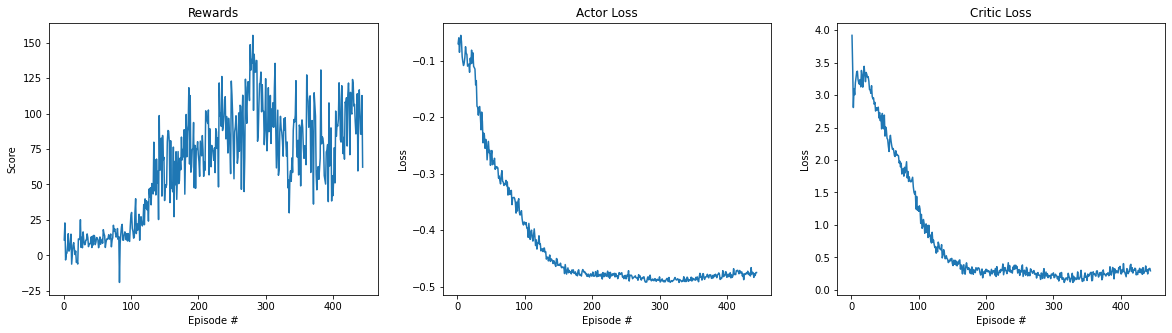

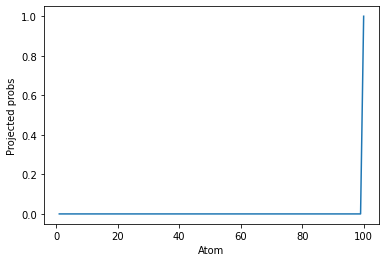

[10.894480807110085,
 22.895678641827544,
 -3.184835626355683,
 0.9681179172669848,
 1.677589703234844,
 7.149371302401657,
 15.323074869794558,
 3.0147943314920362,
 4.21360373646409,
 9.129728716516789,
 14.990681331206966,
 -6.144995602274624,
 -0.028738261433318257,
 7.0421644305606605,
 9.01880077328436,
 4.654277023718653,
 0.658679126935264,
 3.0709100272894525,
 -4.929805992876936,
 -3.8183749626526455,
 -6.080045191351625,
 11.631385336229869,
 11.512972519084238,
 11.166842700700121,
 25.16443404116823,
 5.650748179371779,
 12.793438228487503,
 5.3698989995755255,
 16.57362037144291,
 10.759483495222716,
 7.613856383541133,
 7.6650608967950875,
 10.722933760494925,
 10.913417533777343,
 15.16386744985357,
 12.506572408000162,
 6.175228406277408,
 8.327976326923817,
 7.9342056105379015,
 9.012909907770032,
 13.04226305213524,
 5.548097630977281,
 13.604702825856899,
 7.3227486610218575,
 14.147961626207689,
 13.662518710945733,
 7.61462602832277,
 9.313589319819584,
 12.595198

In [27]:
# ACHIEVED: Max +150 score

##################
# Vmax = -Vmin = 0.5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.5_longest'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.5_longest'
params.num_atoms = 100
params.vmin = -0.5
params.vmax = 0.5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -5
VMAX:  5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.41 	Critic Loss: 4.01 
		Average Score: 11.03

SCORES (this eps):  [126.73221893   7.44472088  88.4728643   58.56750212  33.44669419
  40.05417384  16.05318828  33.45955872  15.85192684  67.6678873
 161.43120457  27.33301995] 



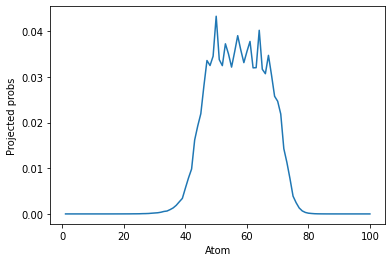

Episode 20: 	Actor Loss: -2.41 	Critic Loss: 2.80 
		Average Score: 78.08

SCORES (this eps):  [ 43.56900744 145.72486152  14.14870923 101.98166513  27.38256977
  11.2400835  273.8884096   10.34924091 108.0899389  226.50193257
  31.36886831 240.12647796] 



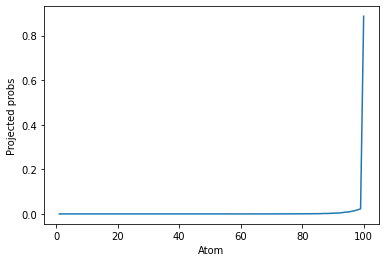

Episode 30: 	Actor Loss: -3.78 	Critic Loss: 1.75 
		Average Score: 107.06

SCORES (this eps):  [7.58470835e+01 4.14817516e+01 1.85087709e+02 1.69191479e+02
 2.53079106e+01 1.08744243e+02 5.05420819e+01 2.32948991e+01
 2.35559383e+02 2.09570842e-01 1.35909033e+02 1.82072276e+02] 



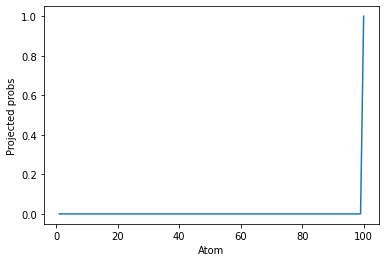

Episode 40: 	Actor Loss: -4.21 	Critic Loss: 1.29 
		Average Score: 128.68

SCORES (this eps):  [ 50.97429803   0.3694636   35.08860238   5.36324563 137.33819973
   5.10977744 213.16966203  48.24376743 133.36321841 215.88545498
 245.26892818  12.94319939] 



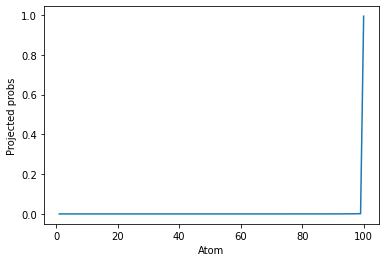

Episode 50: 	Actor Loss: -4.39 	Critic Loss: 1.04 
		Average Score: 138.10

SCORES (this eps):  [ 74.12693083 286.42174284 136.04532588 157.17774756 128.81656451
  26.27150351 256.59996945 118.19500896  77.5178245   16.34438625
 115.71844215  30.27749275] 



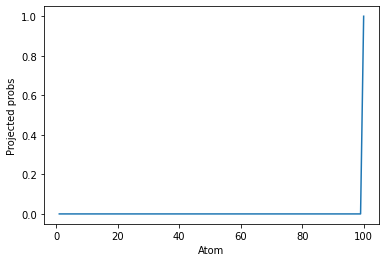

Episode 60: 	Actor Loss: -4.47 	Critic Loss: 0.93 
		Average Score: 163.41

SCORES (this eps):  [115.95639402 299.74607726 175.79307655  36.38888744  40.53525634
 115.73010781  20.66381984 229.36387727   8.6849625  163.68832951
 468.80747177 582.56507996] 



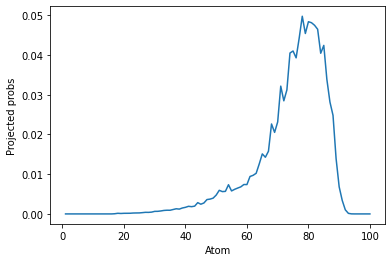

Episode 70: 	Actor Loss: -4.56 	Critic Loss: 0.81 
		Average Score: 141.31

SCORES (this eps):  [146.10459595  52.10207087 135.69025106 276.18588408  40.2091868
  65.82072931 131.05851234  46.14395878   2.23580492 136.1785646
   8.3620033   62.78786152] 



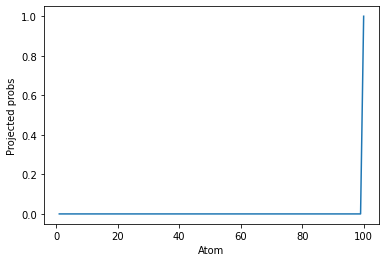

Episode 80: 	Actor Loss: -4.60 	Critic Loss: 0.71 
		Average Score: 162.45

SCORES (this eps):  [100.60929566 449.75183082 219.16733576 247.06010394  38.49397818
 166.03733277 197.66184506  50.83974604 496.40090721 112.87744427
 302.64749227 468.20459265] 



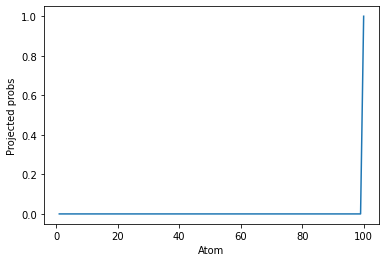

Episode 90: 	Actor Loss: -4.72 	Critic Loss: 0.58 
		Average Score: 146.88

SCORES (this eps):  [ 15.84413285  95.90103731 110.81237955   8.39788391 541.71528317
 182.01789303 157.96178777  31.78699768 192.57973773 138.55306358
   8.12566772 193.51766177] 



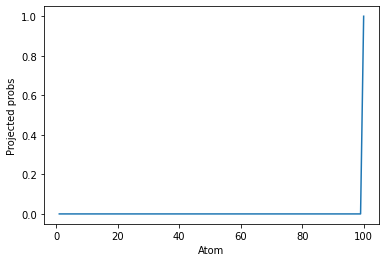

Episode 100: 	Actor Loss: -4.87 	Critic Loss: 0.32 
		Average Score: 178.23

SCORES (this eps):  [104.49259893  27.48135723  17.86910854 500.93465808 133.8002736
 423.05971184 181.05633083  43.61790816  63.84008515  41.44584016
 184.74238234   2.00925306] 



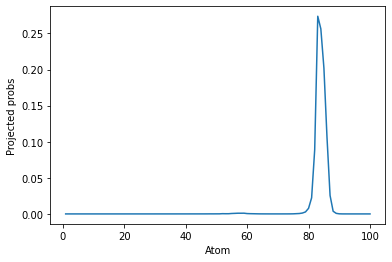

Episode 110: 	Actor Loss: -4.90 	Critic Loss: 0.26 
		Average Score: 176.76

SCORES (this eps):  [ 56.16171455 316.51941775   1.91958312  32.07528866 561.6896793
 457.00585123  65.77062381 274.1181816  152.29871707 176.27296377
 292.94476531 148.96855867] 



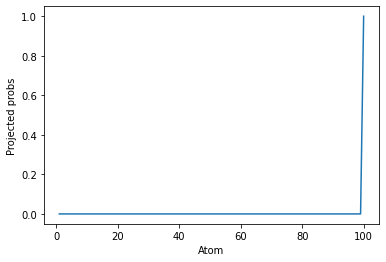

Episode 120: 	Actor Loss: -4.91 	Critic Loss: 0.24 
		Average Score: 225.41

SCORES (this eps):  [ 14.73646803 171.49171086 526.97385673  95.85110599  13.22749067
 498.9941427  113.17310128 162.90085849 468.40958326 350.94597696
 494.19521607  17.46937038] 



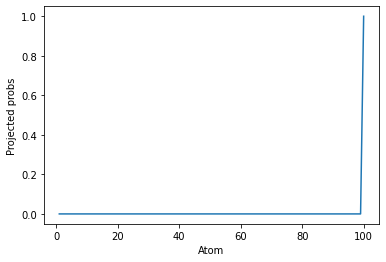

Episode 130: 	Actor Loss: -4.92 	Critic Loss: 0.21 
		Average Score: 236.10

SCORES (this eps):  [342.29955707 263.40359566 142.03148289  22.59410206 534.37358528
 147.52282471 489.80349663  42.84848125 146.87907738 240.65341201
 502.80510493 204.15351608] 



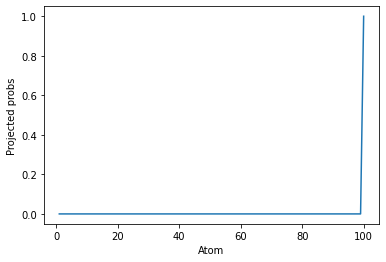

Episode 140: 	Actor Loss: -4.93 	Critic Loss: 0.20 
		Average Score: 203.75

SCORES (this eps):  [151.91654471 415.35524639  34.02417312 443.22863194 125.06735015
 204.34228491 129.66931377 462.86206282 105.19911875 103.21053912
   8.24066278  90.42237946] 



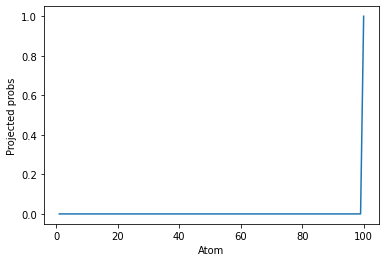

Episode 144\ Score: 196.92

==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([0.0162, 0.1600, 0.7265, 0.9629, 0.8664, 0.7609, 0.8382, 0.7934, 0.8977,
        0.7545, 0.0137, 0.6699, 0.6159, 0.5313, 0.5154, 0.5567, 0.5285, 0.0137,
        0.6738, 0.6401, 0.5861, 0.5093, 0.5314, 0.5280, 0.5536, 0.5861, 0.5573,
        0.5634, 0.5302, 0.0137, 0.5148, 0.5030, 0.6279, 0.5997, 0.5523, 0.5342,
        0.5658, 0.4881, 0.6371, 0.6615, 0.6243, 0.5456, 0.0137, 0.0137, 0.5709,
        0.0137, 0.6797, 0.6270, 0.6083, 0.5212, 0.5520, 0.5046, 0.5468, 0.5687,
        0.5336, 0.5257, 0.5170, 0.0137, 0.5248, 0.5100, 0.6616, 0.6010, 0.5617,
        0.5185, 0.5891, 0.5500, 0.6111, 0.6674, 0.6609, 0.5625, 0.0137, 0.0137,
        0.5367, 0.0137, 0.6950, 0.6599, 0.5707, 0.5142, 0.5560, 0.5143, 0.5349,
        0.5613, 0.5379, 0.4906, 0.5326, 0.0137, 0.5511, 0.4868, 0.6457, 0.6089,
        0.5555, 0.5194, 0.5846, 0.5078, 0.5848, 0.6424, 0.6299, 0.5365, 0.

Actor/bn2.bias Parameter containing:
tensor([-4.0949e-03,  1.4949e-02,  1.5539e-02, -1.9430e-02, -1.1266e-02,
        -9.4739e-03, -2.7617e-02, -2.8310e-02, -2.4540e-02, -1.1967e-02,
         3.8266e-03, -2.2368e-02,  4.3512e-02, -2.4189e-02, -1.3115e-02,
        -1.8778e-03, -1.8540e-02,  1.8405e-05, -2.0567e-02, -2.4407e-02,
         2.7286e-02, -1.1215e-02,  9.8568e-04, -2.9183e-02, -2.4686e-02,
        -5.9392e-02, -1.3754e-02, -2.5171e-02, -1.8533e-02,  2.0407e-02,
        -6.0636e-03, -1.2588e-03, -1.6666e-02, -2.2723e-02, -1.8190e-02,
        -1.3644e-02, -1.4356e-02, -1.5107e-03, -4.5088e-02, -6.0137e-03,
        -8.4260e-03, -1.3015e-02, -1.7304e-02, -1.1491e-02, -2.2753e-02,
        -5.1875e-03, -2.4962e-02, -2.3575e-02, -2.3784e-02, -4.5853e-02,
        -2.5471e-02, -2.4393e-02,  6.8744e-04, -3.1760e-02, -1.5376e-02,
         1.2345e-02,  1.3467e-03, -6.0314e-02, -2.4996e-02,  1.8968e-02,
        -1.1347e-02, -6.4382e-03, -2.2674e-02, -1.4845e-02, -2.9548e-02,
        -1.853

Critic/fc2.weight Parameter containing:
tensor([[ 0.0040, -0.0188, -0.0501,  ..., -0.0104,  0.0173,  0.0094],
        [ 0.0002,  0.0203, -0.0204,  ...,  0.0268, -0.0004, -0.0129],
        [ 0.0325, -0.0399,  0.0037,  ...,  0.0242, -0.0153, -0.0465],
        ...,
        [-0.0209, -0.0073, -0.0127,  ..., -0.0799, -0.0347, -0.0373],
        [ 0.0360,  0.0104, -0.0131,  ...,  0.0147,  0.0005,  0.0428],
        [ 0.0065,  0.0211, -0.0221,  ...,  0.0434,  0.0003,  0.0078]],
       device='cuda:0', requires_grad=True)
Critic/fc2.bias Parameter containing:
tensor([ 1.9810e-02,  5.7467e-03,  1.2780e-02,  7.4255e-02,  1.1168e-02,
         2.4064e-02, -1.1591e-03,  6.2718e-02,  2.0383e-02, -6.9476e-03,
         5.0036e-02, -3.5407e-02, -2.3596e-02, -1.3566e-03,  3.8222e-02,
         1.1511e-01,  2.0722e-02, -3.2957e-02, -6.3023e-03, -2.0046e-02,
         5.7276e-03,  2.1459e-02,  4.0003e-02,  1.3555e-02,  8.1739e-03,
         3.9996e-02,  2.1277e-02, -2.2476e-02,  2.2337e-04, -5.4125e-05,
      

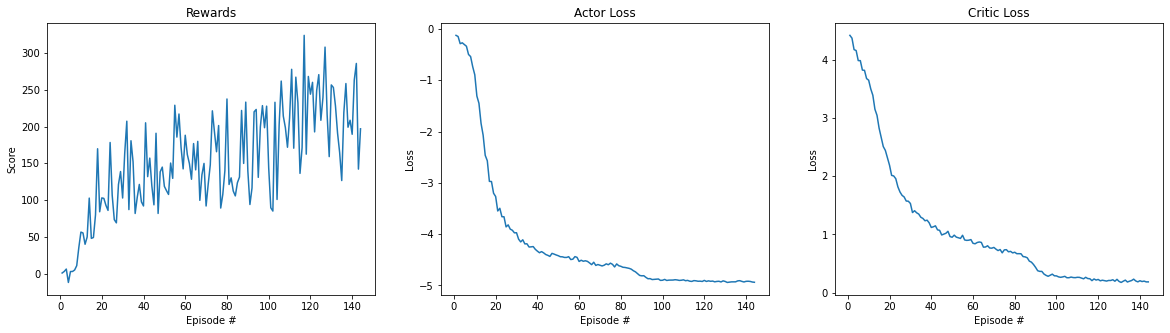

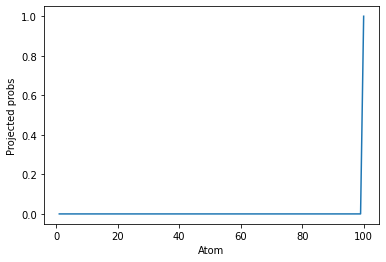

[0.7139316862060999,
 2.8153066724092546,
 6.0713402985275025,
 -12.11294744165813,
 2.7304601816188856,
 2.823982669156976,
 4.832230974124589,
 10.731313004497983,
 35.30781811210909,
 56.376246661064215,
 55.22696306444899,
 39.81241519896624,
 49.73839148234887,
 102.6478403187939,
 47.84208791365381,
 49.03760712229026,
 79.8018351177064,
 169.7745530218041,
 84.03454120769068,
 102.86431373826538,
 102.27579831886881,
 92.76009756252945,
 85.91503684218817,
 178.2995585956766,
 106.44739680279356,
 73.32057075000678,
 68.96068943458765,
 121.06671405548695,
 138.7799777945232,
 102.77061836029559,
 163.7250120852841,
 207.26410905869366,
 86.99846668570535,
 180.68584862952898,
 152.02172210866897,
 81.72960818539529,
 103.65995588770602,
 121.2502822271005,
 97.52746789817077,
 91.92648476876396,
 205.0726105980284,
 131.83081835065968,
 157.04949517175555,
 119.13360936761212,
 93.46840707041945,
 190.8491527964749,
 81.76057107979432,
 138.3746282388262,
 144.80821716040373,
 

In [30]:
# 3 layers network instead...
# ACHIEVED: Max +300 score

##################
# Vmax = -Vmin = 5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_5_longest'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_5_longest'
params.num_atoms = 100
params.vmin = -5
params.vmax = 5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -5
VMAX:  5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.55 	Critic Loss: 3.95 
		Average Score: 2.76

SCORES (this eps):  [ 6.86068074  6.18176314  7.67070238  0.          0.          8.24541638
  3.76741252 83.63797687  0.53621069  1.05897773  4.01650658 11.95876638] 



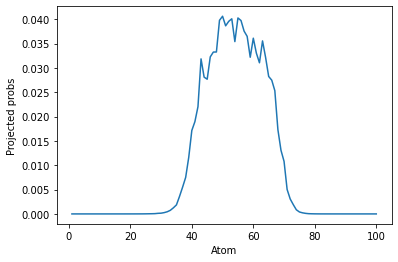



==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([0.9117, 0.9133, 0.9128, 0.9705, 0.9422, 0.9492, 0.9153, 0.9333, 0.9413,
        0.9389, 0.9117, 0.9415, 0.9190, 0.9151, 0.9128, 0.9122, 0.9133, 0.9117,
        0.9293, 0.9184, 0.9161, 0.9139, 0.9125, 0.9164, 0.9128, 0.9147, 0.9133,
        0.9119, 0.9124, 0.9117, 0.9129, 0.9135, 0.9263, 0.9163, 0.9131, 0.9131,
        0.9130, 0.9146, 0.9261, 0.9256, 0.9314, 0.9168, 0.9117, 0.9117, 0.9232,
        0.9117, 0.9351, 0.9215, 0.9178, 0.9128, 0.9117, 0.9147, 0.9171, 0.9120,
        0.9170, 0.9127, 0.9165, 0.9117, 0.9112, 0.9118, 0.9246, 0.9167, 0.9139,
        0.9152, 0.9128, 0.9145, 0.9265, 0.9169, 0.9310, 0.9292, 0.9117, 0.9117,
        0.9137, 0.9117, 0.9368, 0.9247, 0.9151, 0.9122, 0.9115, 0.9137, 0.9127,
        0.9170, 0.9123, 0.9151, 0.9139, 0.9117, 0.9157, 0.9134, 0.9217, 0.9159,
        0.9147, 0.9146, 0.9121, 0.9131, 0.9186, 0.9210, 0.9201, 0.9154, 0.9117,
        0.9117, 0.91

KeyboardInterrupt: 

In [57]:
# 3 layers network instead...
# ACHIEVED: -

##################
# Vmax = -Vmin = 5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_5_longest_half_noise'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_5_longest_half_noise'
params.num_atoms = 100
params.vmin = -5
params.vmax = 5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -3.5
VMAX:  3.5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -1.65 	Critic Loss: 3.22 
		Average Score: 8.21

SCORES (this eps):  [ 0.27633985  6.71426087  2.44137075  2.35552711  8.29932565  2.07806055
 11.82359442 18.10283855 18.8521597   8.38057359 11.57660526  9.90121715] 



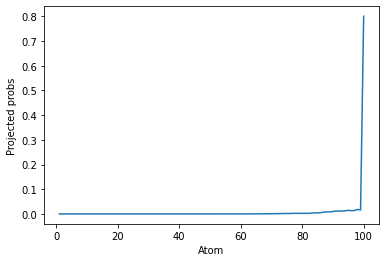

Episode 20: 	Actor Loss: -2.98 	Critic Loss: 1.46 
		Average Score: 13.31

SCORES (this eps):  [2.06304789e-02 2.10119729e+01 7.48621010e+01 7.96813916e-01
 2.65510335e+01 0.00000000e+00 4.06221801e+01 7.35947965e+00
 7.13958223e+00 8.42622423e+00 5.48255067e+00 2.83620917e+01] 



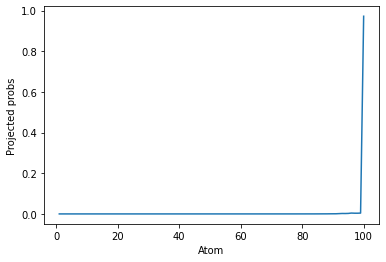

Episode 30: 	Actor Loss: -3.10 	Critic Loss: 1.14 
		Average Score: 18.75

SCORES (this eps):  [ 1.82204514 13.5262196  37.10966137 18.97277586 24.83248102 12.30422266
 18.9969826  14.24296607 15.90451683  0.         10.48379542 48.96504917] 



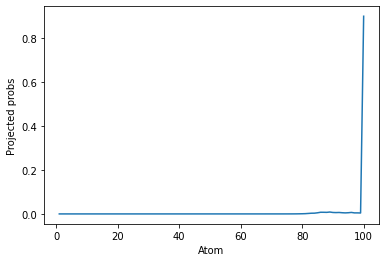

Episode 40: 	Actor Loss: -3.19 	Critic Loss: 0.97 
		Average Score: 18.07

SCORES (this eps):  [ 0.71550266 14.18086981 18.85305447  4.58057258  3.68472368 20.31988093
  7.49579955 84.25542478  2.85163686 10.4261573   0.08857606 15.34640683] 



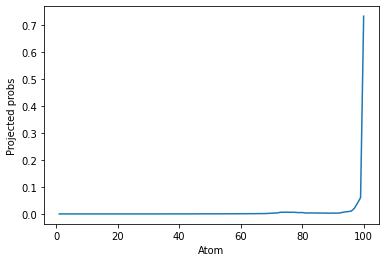

Episode 50: 	Actor Loss: -3.21 	Critic Loss: 0.90 
		Average Score: 19.55

SCORES (this eps):  [ 0.15402615 17.32604022  8.33330343  5.28105718  1.86368924  3.3552394
 15.13120661  2.61224976 22.62233231  7.12919205 23.30218317 67.64425388] 



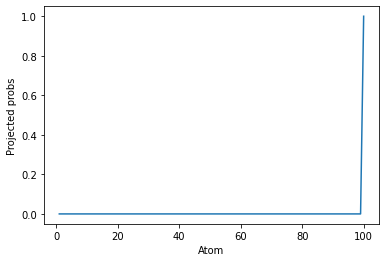

Episode 60: 	Actor Loss: -3.24 	Critic Loss: 0.84 
		Average Score: 19.07

SCORES (this eps):  [3.95705647e+00 6.47758357e-02 4.21532919e+00 1.12078516e+02
 2.04322855e+01 6.22833383e+00 3.48579261e+01 1.35790737e+01
 1.56001490e+01 2.07995414e+01 2.91412068e+01 1.54586426e+01] 



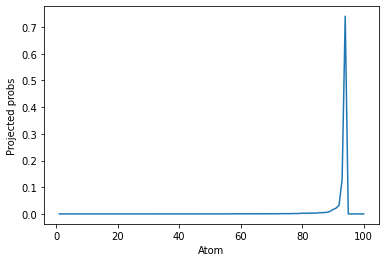

Episode 70: 	Actor Loss: -3.25 	Critic Loss: 0.80 
		Average Score: 22.69

SCORES (this eps):  [19.44068241  1.91102402 56.84701964 27.71552344 28.51869969 62.83771904
  8.04655325 33.25842048 36.62605561 30.92519496  3.23894059 42.27915967] 



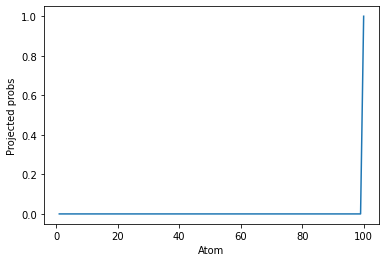

Episode 73\ Score: 20.59
NaN found in states. Skipping this episode.
Episode 74\ Score: 32.03

scripts\d4pg_agent.py:187: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), self.params.gradient_clip)    # ADDED: Gradient Clipping to prevent exploding grad issue
scripts\d4pg_agent.py:180: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), self.params.gradient_clip)    # ADDED: Gradient Clipping to prevent exploding grad issue



NaN found in actions. Skipping this episode.
Episode 75\ Score: 23.72
NaN found in states. Skipping this episode.
Episode 76\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 77\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 78\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 79\ Score: 0.00
NaN found in states. Skipping this episode.


==== An exception occurred: The histogram is empty, please file a bug report.

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

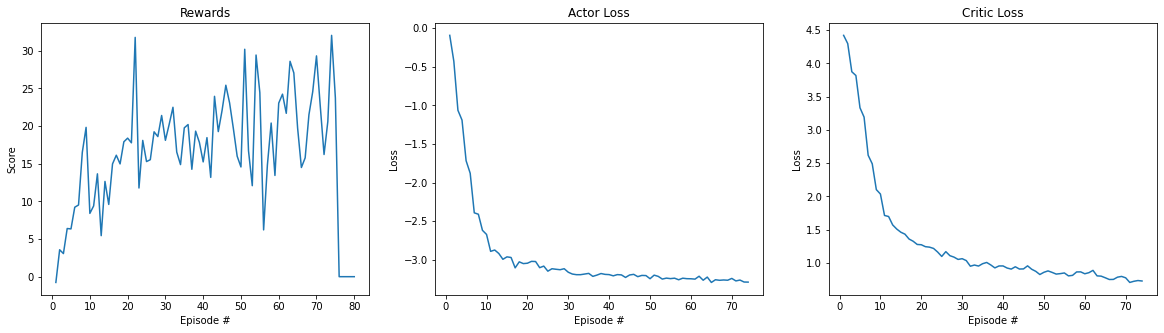

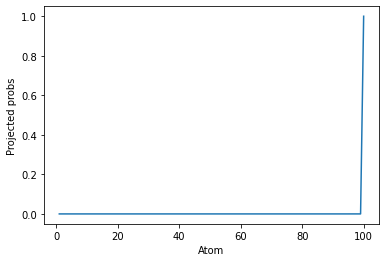

[-0.7653927054489031,
 3.5724222999221333,
 3.067178448429331,
 6.39154003180253,
 6.340089439530857,
 9.21792087618572,
 9.513989388981523,
 16.502787556499243,
 19.816440829696756,
 8.400156121080121,
 9.391104483045638,
 13.64940812609469,
 5.4446129847783595,
 12.640444393424938,
 9.589378589997068,
 14.96709225551846,
 16.118992873234674,
 14.967415910136575,
 17.902622447737183,
 18.386221705547843,
 17.76707833283581,
 31.75776463545238,
 11.768789817967141,
 18.08418355676501,
 15.27860865307351,
 15.524658235178018,
 19.225314912153408,
 18.59309417641877,
 21.392483092766877,
 18.096726310749847,
 20.22213848559962,
 22.482109426287934,
 16.537506907712668,
 14.875106342059249,
 19.756899336197723,
 20.18823207806175,
 14.252417779061943,
 19.314567882257204,
 17.815420758677647,
 15.233217125564503,
 18.45305610347229,
 13.179380419741696,
 23.93506583819787,
 19.25572869577445,
 22.060317630510934,
 25.409024939484272,
 23.043805410309385,
 19.630568515198927,
 15.987261441

In [52]:
# 3 layers network instead...
# ACHIEVED: -

##################
# Vmax = -Vmin = 3.5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-6                  
params.lr_critic = 1e-5 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 0.5        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_3.5_longest'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_3.5_longest'
params.num_atoms = 100
params.vmin = -3.5
params.vmax = 3.5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  5e-05
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -6.5
VMAX:  6.5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.99 	Critic Loss: 3.99 
		Average Score: 4.36

SCORES (this eps):  [12.17134684  5.07447295  5.02708752  4.72300027  6.42647637 10.4527736
  2.82470942  1.54223951 11.87307999  3.71736074  4.64035438  8.04167779] 



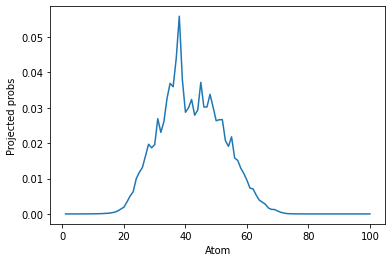

Episode 20: 	Actor Loss: -3.82 	Critic Loss: 2.95 
		Average Score: 11.23

SCORES (this eps):  [ 6.34538737  5.62830256  0.92587153  0.07454944 18.83887487  9.89018936
  3.79095073 10.22062979  3.28400837  0.43135344 35.87925485  9.81241342] 



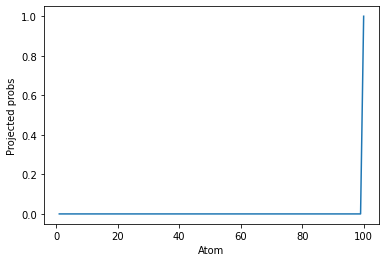

Episode 30: 	Actor Loss: -5.05 	Critic Loss: 2.13 
		Average Score: 14.95

SCORES (this eps):  [12.44493967 21.37458142 50.25228828  3.86832977 27.68493423 36.79301891
  0.         49.68536282  5.61752651  1.21170773  9.33202955  0.        ] 



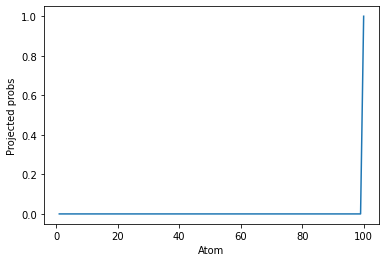

Episode 40: 	Actor Loss: -5.36 	Critic Loss: 1.83 
		Average Score: 19.84

SCORES (this eps):  [60.59036766 32.73341021 10.83229879  9.89041152 46.30872388 22.92259001
  8.14197444  7.96058957  1.889726   32.63463684 32.30431448 39.57263729] 



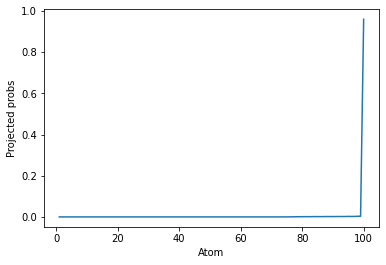

Episode 50: 	Actor Loss: -5.55 	Critic Loss: 1.64 
		Average Score: 21.57

SCORES (this eps):  [32.60541045 45.27589236 12.80357808 31.94444647 17.27717035  3.51836165
  1.14249897 47.30152293 -0.07991636  0.7559555  29.78181016 13.01311653] 



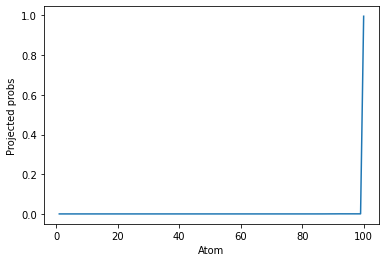

Episode 60: 	Actor Loss: -5.66 	Critic Loss: 1.53 
		Average Score: 25.60

SCORES (this eps):  [ 11.96450763  14.42915409   9.04418951  64.84565784  28.16529118
  10.35701075  23.9210471   57.55416352  16.83285475 142.15247016
  68.40347523  26.3120215 ] 



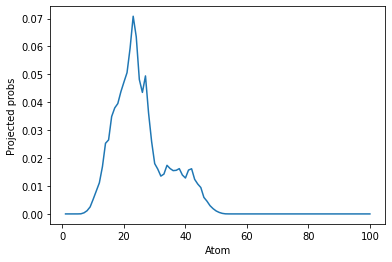

Episode 70: 	Actor Loss: -5.75 	Critic Loss: 1.39 
		Average Score: 28.53

SCORES (this eps):  [42.20929363 31.23863189  2.13598354 59.55375753 36.18680448 49.72168722
 69.18481042 23.74271848 23.05611736 63.87803661 32.08890028 30.97693468] 



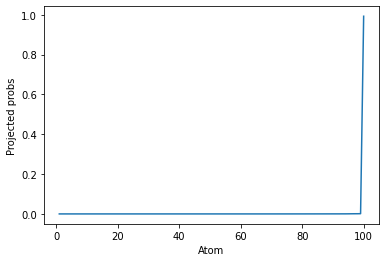

Episode 80: 	Actor Loss: -5.81 	Critic Loss: 1.31 
		Average Score: 27.78

SCORES (this eps):  [ 11.94766889  42.35676137  47.84096022   1.66048761  91.7604254
  13.52506186  32.15199997  45.45862265 101.12406103  19.55130113
   7.4247016   72.69313074] 



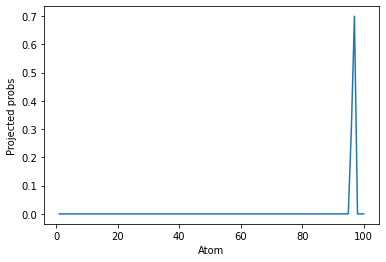

Episode 88\ Score: 27.51NaN Reward Found! Skipping this episode.
Episode 90: 	Actor Loss: -5.91 	Critic Loss: 1.22 
		Average Score: 27.96

SCORES (this eps):  [4.36075244e+01 5.39123859e+00 1.08517977e+02 1.14574765e+02
 9.73348277e+01 3.87725767e+01 3.88821640e+00 5.05415598e+01
 5.29521396e+00 6.18038350e+00 1.15328294e+01 8.91981926e-03] 



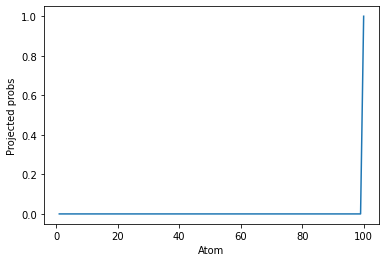

Episode 100: 	Actor Loss: -6.02 	Critic Loss: 1.04 
		Average Score: 31.83

SCORES (this eps):  [10.11719231 76.08292168 34.27055377 60.82853731 31.27449762 18.75804772
 24.81386849 45.55196925 26.92880027 33.89109331 26.7938486  10.33118663] 



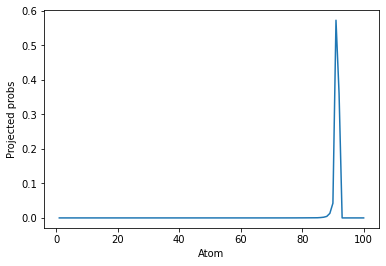

Episode 110: 	Actor Loss: -6.07 	Critic Loss: 0.93 
		Average Score: 34.39

SCORES (this eps):  [3.38184258e+01 5.29151147e+00 3.37066346e+00 1.67451786e-01
 1.85319178e+01 5.13370535e+01 1.44026942e+01 2.42415964e+02
 3.88513166e+01 9.94783715e+01 5.96381756e+01 1.31548768e+02] 



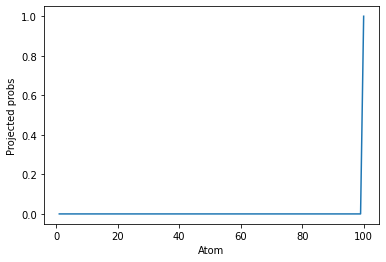

Episode 120: 	Actor Loss: -6.12 	Critic Loss: 0.84 
		Average Score: 32.74

SCORES (this eps):  [ 12.87000519  19.74630878  27.94335929  32.62689395   8.19131713
  15.24837148  10.0740502   35.26237912   7.90020356  19.18398811
  19.02117784 107.07517263] 



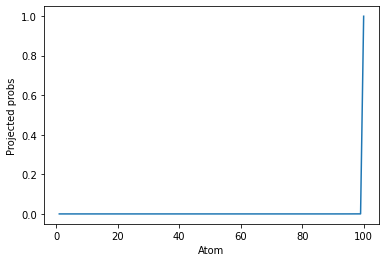

Episode 130: 	Actor Loss: -6.16 	Critic Loss: 0.78 
		Average Score: 37.35

SCORES (this eps):  [ 2.49449165e+01  8.20423710e+01  5.98666957e+01  6.69185547e+00
  2.78547696e+01 -5.02060354e-02  3.38363283e+01  3.68100596e+01
  2.45983748e+01  1.17668266e+02  1.00173426e+01  2.25294203e+00] 



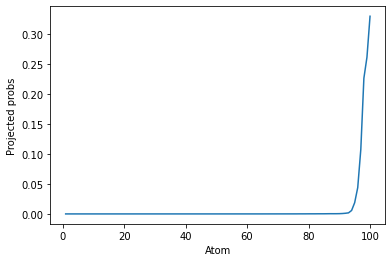

Episode 140: 	Actor Loss: -6.19 	Critic Loss: 0.71 
		Average Score: 44.97

SCORES (this eps):  [ 69.41690742 164.73498735  26.95093608   5.48306834  10.64848355
  22.19364168  82.28090793  68.99366904  27.18380118   9.35496497
   2.05770018  23.30774774] 



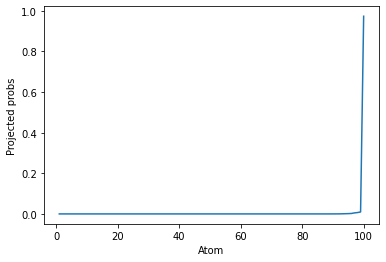

Episode 142\ Score: 33.39

==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([0.0183, 0.6478, 0.4682, 1.0387, 0.8484, 0.8145, 0.6995, 0.8353, 0.9212,
        0.7363, 0.0178, 0.6659, 0.6575, 0.4393, 0.4059, 0.3794, 0.3755, 0.0178,
        0.7233, 0.7628, 0.4799, 0.4063, 0.3833, 0.4360, 0.4302, 0.4998, 0.4336,
        0.3920, 0.4219, 0.0178, 0.4202, 0.5208, 0.6435, 0.6431, 0.4010, 0.3888,
        0.3996, 0.4392, 0.5290, 0.5353, 0.6133, 0.4701, 0.0178, 0.0178, 0.4379,
        0.0178, 0.7339, 0.7429, 0.4719, 0.4090, 0.3897, 0.4188, 0.4417, 0.5543,
        0.4905, 0.4397, 0.3991, 0.0178, 0.4114, 0.5465, 0.6348, 0.6416, 0.3798,
        0.4179, 0.4141, 0.4183, 0.6761, 0.6034, 0.6239, 0.4319, 0.0178, 0.0178,
        0.4504, 0.0178, 0.7468, 0.7483, 0.4756, 0.3888, 0.3793, 0.4270, 0.4093,
        0.5086, 0.4492, 0.4366, 0.4043, 0.0178, 0.4423, 0.4783, 0.6335, 0.6306,
        0.4378, 0.4110, 0.4127, 0.4266, 0.5170, 0.6617, 0.4863, 0.4740, 0.0

Actor/fc3.weight Parameter containing:
tensor([[-4.6947e-03,  1.6792e-03, -2.4763e-03,  ..., -6.0121e-03,
         -6.6857e-03,  3.3964e-03],
        [-3.7668e-03,  2.5943e-04, -1.6714e-03,  ..., -2.1207e-03,
         -1.6995e-03, -1.7046e-03],
        [-4.2168e-03, -5.7167e-03,  9.2809e-04,  ..., -2.1380e-03,
         -2.2058e-03, -3.0670e-03],
        ...,
        [-3.5040e-03,  2.2047e-04,  2.5460e-03,  ..., -2.5869e-03,
          1.1341e-02, -1.5836e-03],
        [ 1.4459e-05,  5.1858e-03,  3.9285e-03,  ..., -1.5831e-04,
          4.7861e-03,  5.3482e-03],
        [ 3.8553e-04, -9.8895e-04,  1.7089e-03,  ..., -2.7679e-03,
         -5.0347e-03,  5.3622e-03]], device='cuda:0', requires_grad=True)
Actor/fc3.bias Parameter containing:
tensor([-2.5708e-09, -5.4759e-08,  1.4565e-07, -5.9344e-08, -6.9282e-08,
        -1.1845e-07, -3.4511e-08, -2.2420e-08,  5.4128e-08, -2.3203e-08,
        -4.6894e-08, -6.4609e-08, -4.3306e-08, -1.1042e-08, -4.4763e-08,
         1.4371e-07, -7.1294e-08,  1

Critic/bn1.bias Parameter containing:
tensor([ 7.1720e-02,  7.0570e-02, -1.2387e-01,  3.0008e-02,  6.3659e-02,
        -8.3364e-02, -1.6192e-02, -8.2238e-03,  6.2607e-02,  5.1825e-03,
         1.0112e-01, -1.5335e-01, -1.6637e-02, -2.1163e-02, -1.2615e-02,
         1.2974e-01, -2.9127e-01,  1.3116e-01,  1.3932e-01, -2.6612e-02,
         5.6336e-02,  9.0343e-02,  1.6651e-01, -1.3063e-02,  1.0403e-01,
         1.2191e-02,  6.1054e-02,  6.1433e-02,  1.6701e-02,  5.3493e-02,
         7.7891e-02,  4.5947e-03,  2.2094e-01,  1.8504e-01, -2.6513e-02,
         8.2421e-02,  2.3523e-02,  1.7335e-01, -2.8250e-02,  4.1189e-03,
        -7.2819e-03, -1.5456e-01,  3.8673e-02,  1.1690e-01,  9.8913e-02,
        -1.6063e-01,  8.7592e-02, -5.8946e-02, -3.7321e-02,  1.2496e-01,
         2.8480e-02, -1.2225e-01,  9.9344e-02,  1.2311e-02,  1.2242e-01,
        -6.8842e-02, -1.2142e-01, -3.2214e-02,  1.3827e-01,  3.3357e-01,
         2.3835e-02,  4.8408e-02,  3.7128e-02, -1.1064e-02, -2.5556e-02,
         7.76

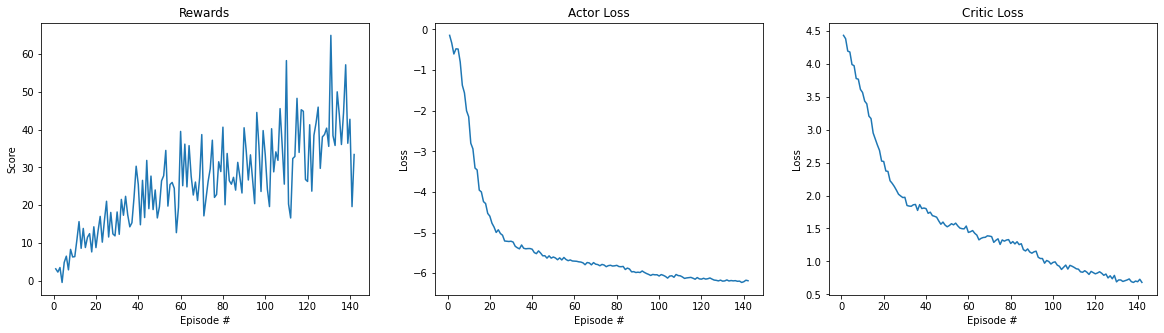

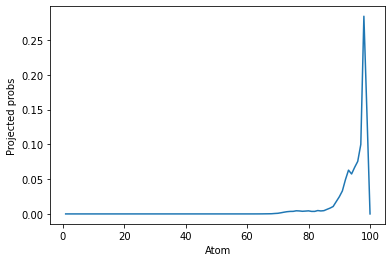

[3.1456396896004057,
 2.2860201008540266,
 3.494377234960363,
 -0.45457141066435724,
 4.837507235041509,
 6.497907907663223,
 2.8810203496056297,
 8.291826138544517,
 6.284645064966753,
 6.376214949181303,
 10.825659626318762,
 15.63523006225781,
 8.570911777671427,
 13.834680889888356,
 8.7884920744303,
 11.509336664826455,
 12.460499691970957,
 7.621056733652949,
 14.267862864149114,
 8.76014881033916,
 13.171292278527593,
 17.01926033485991,
 10.203647527261637,
 15.949199017641755,
 21.020900437647168,
 11.568128750892356,
 18.067376893091325,
 12.39043445365193,
 11.871431454162424,
 18.188726574570563,
 12.280737916085249,
 21.517016798451852,
 17.318794276642922,
 22.328385352622718,
 17.456319514506806,
 14.261585661908612,
 15.347131203782434,
 22.093391772980493,
 30.293043704315398,
 25.481806724099442,
 14.801986030302942,
 26.554665982878458,
 16.716848658320185,
 31.828362186982606,
 19.05857544458316,
 27.686166445724666,
 18.82116798334755,
 24.011954016168602,
 16.6130

In [53]:
# 3 layers network instead...
# ACHIEVED: -

##################
# Vmax = -Vmin = 6
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 5e-5 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 0.5        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_6.5_longest'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_6.5_longest'
params.num_atoms = 100
params.vmin = -6.5
params.vmax = 6.5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -10
VMAX:  10
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -1.06 	Critic Loss: 3.94 
		Average Score: 4.02

SCORES (this eps):  [12.83884506 10.64934212 16.39494148  0.98737643  0.94056359  0.71847675
 24.30875996 19.74972123 16.69268939 12.15102711  1.04339658  7.08278053] 



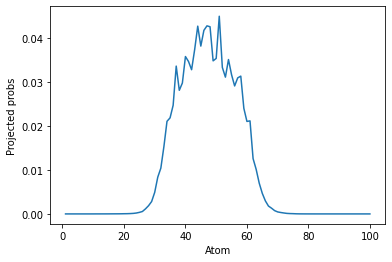

Episode 20: 	Actor Loss: -4.52 	Critic Loss: 3.27 
		Average Score: 13.72

SCORES (this eps):  [ 4.7419823  14.3676923   3.4051143  20.81792763  8.80973495 17.84319001
  1.38521549 64.01602002  0.13340607 23.4640775  35.77969943 27.37486624] 



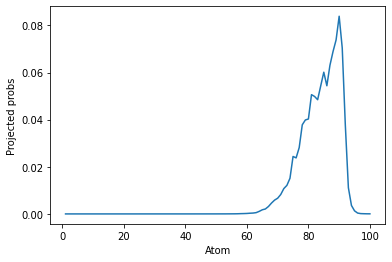

Episode 30: 	Actor Loss: -6.87 	Critic Loss: 2.75 
		Average Score: 21.29

SCORES (this eps):  [11.02652048 12.00160539  7.02222326 30.03190182 29.12219154 12.57970998
 33.16025493  2.30433471 30.67365748 18.49401698 46.35727217  6.19567384] 



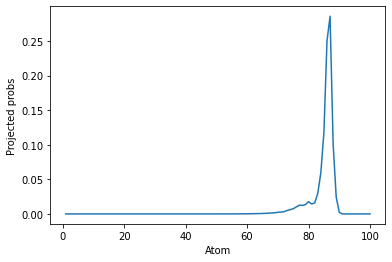

Episode 40: 	Actor Loss: -7.77 	Critic Loss: 2.23 
		Average Score: 21.70

SCORES (this eps):  [56.02771264  6.92033958  5.35348113 33.90784519  9.9475829   2.34565152
 27.29114678  6.82089083 28.19340624  4.31289554  5.41725846  7.01579598] 



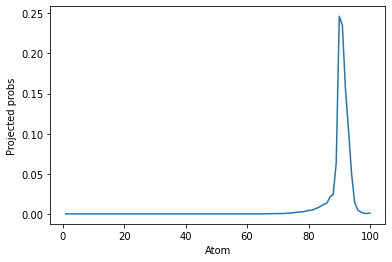

Episode 50: 	Actor Loss: -8.17 	Critic Loss: 1.97 
		Average Score: 23.10

SCORES (this eps):  [ 49.28051673  40.76344085   5.76865519   8.98985314  34.98347689
  10.50578028  20.68332131  87.31348757  27.70017546 109.41636152
   0.14525604  34.09129016] 



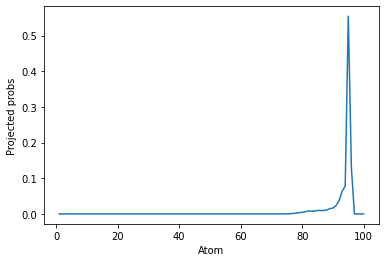

Episode 60: 	Actor Loss: -8.40 	Critic Loss: 1.82 
		Average Score: 29.27

SCORES (this eps):  [ 8.78416850e+01  4.01973984e+01  3.19568287e+01  6.44152823e+00
 -5.32817356e-02  2.27562126e+00  1.87044275e+01  3.31899405e+01
  2.21236272e+01  2.05876912e+01  2.26935566e+01  8.96598752e+01] 



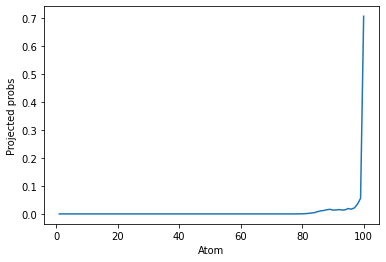

Episode 69\ Score: 34.33

==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([0.4107, 0.9135, 0.8271, 1.1202, 0.9803, 0.9638, 0.9192, 0.9804, 1.0311,
        0.9767, 0.4070, 0.8730, 0.8658, 0.7361, 0.7115, 0.6959, 0.7139, 0.4070,
        0.9135, 0.9033, 0.7942, 0.7567, 0.7111, 0.7492, 0.7566, 0.7799, 0.7340,
        0.7442, 0.7170, 0.4070, 0.7362, 0.7709, 0.8054, 0.8614, 0.7407, 0.7274,
        0.7304, 0.7253, 0.8262, 0.8484, 0.8732, 0.7527, 0.4070, 0.4070, 0.7480,
        0.4070, 0.9085, 0.9056, 0.8001, 0.7192, 0.7000, 0.7214, 0.7420, 0.8176,
        0.7101, 0.7291, 0.6925, 0.4070, 0.7614, 0.8119, 0.8016, 0.8425, 0.7270,
        0.7303, 0.7399, 0.7137, 0.8479, 0.8362, 0.8673, 0.7445, 0.4070, 0.4070,
        0.7391, 0.4070, 0.9123, 0.8985, 0.7492, 0.7139, 0.6980, 0.7113, 0.7014,
        0.7770, 0.7605, 0.7070, 0.6576, 0.4070, 0.7323, 0.7277, 0.8009, 0.8049,
        0.7181, 0.7149, 0.7112, 0.7184, 0.7324, 0.8502, 0.8026, 0.7392, 0.40

Actor/fc3.weight Parameter containing:
tensor([[ 2.7699e-03, -3.0324e-04,  1.2599e-03,  ...,  6.9185e-05,
          1.7978e-03,  5.5688e-04],
        [ 2.2598e-03, -2.9187e-04,  3.8583e-03,  ...,  7.5348e-04,
         -7.2313e-03,  1.5576e-03],
        [-2.0390e-03, -1.0284e-03,  7.4289e-03,  ...,  7.1808e-03,
          3.4514e-03,  6.4516e-04],
        ...,
        [ 1.5109e-03, -6.7256e-03,  1.2584e-03,  ...,  2.7899e-03,
         -4.0101e-03, -5.1211e-03],
        [ 5.3814e-03,  2.1223e-03, -7.8648e-03,  ...,  5.0184e-03,
         -1.4500e-03,  1.5508e-03],
        [-5.6772e-04, -9.4996e-04, -5.2354e-03,  ...,  2.4513e-03,
          4.2476e-03, -3.3769e-03]], device='cuda:0', requires_grad=True)
Actor/fc3.bias Parameter containing:
tensor([ 2.1621e-05,  9.2848e-06,  5.7641e-05, -3.3049e-05, -1.5948e-05,
         8.2222e-06, -1.2674e-05,  4.6583e-05,  8.9772e-06,  1.1646e-05,
         3.2650e-05, -1.3169e-05, -1.9320e-05,  5.0610e-05,  2.6388e-05,
        -1.7888e-05,  2.4336e-06, -3

Critic/bn1.bias Parameter containing:
tensor([-9.1908e-02,  1.8647e-02, -1.8922e-01, -4.8443e-02,  7.9425e-03,
        -8.4505e-02, -4.1563e-02,  1.7130e-03,  4.2999e-02,  3.0555e-02,
         1.9738e-02,  2.2885e-02, -4.4608e-02,  5.3433e-02, -2.4446e-01,
         1.4367e-01, -2.8906e-01, -3.3682e-03,  1.1564e-01,  8.9950e-03,
         2.0550e-01,  5.1232e-02,  1.4825e-01,  7.1987e-02,  5.5385e-02,
         4.6391e-03,  6.0368e-02, -2.8986e-02, -1.1506e-02, -3.7214e-02,
        -7.2212e-02, -6.0183e-02,  4.7461e-02,  7.4682e-02,  6.9943e-02,
         1.0791e-01, -2.5075e-02,  2.6583e-01,  5.1171e-02, -6.2243e-02,
        -4.8012e-02, -5.3357e-02,  2.8175e-01,  2.8046e-01,  9.9770e-02,
        -7.0168e-02, -3.6858e-02, -1.1393e-01, -9.7860e-02,  1.2901e-01,
        -8.3865e-03, -4.0227e-02,  6.1416e-02, -5.7925e-02, -2.7793e-02,
         1.6502e-02, -1.6877e-01, -1.9678e-02,  4.4610e-02,  3.0613e-01,
        -6.7523e-03, -4.4478e-02,  6.7606e-02,  2.2740e-02, -3.1441e-03,
         5.58

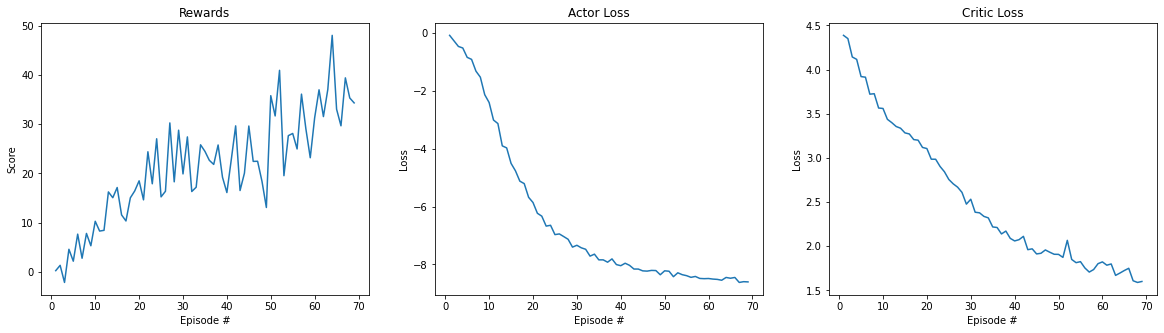

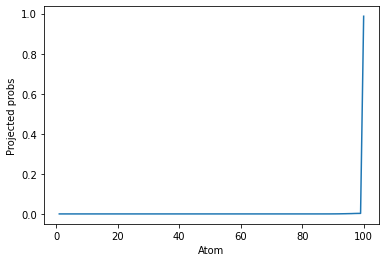

[0.2692471876895676,
 1.346395599641255,
 -2.126276380770529,
 4.607641854401057,
 2.190398827563816,
 7.68351420845526,
 2.7874312391504645,
 7.827298967516981,
 5.322689426713623,
 10.296493353244538,
 8.307349493106207,
 8.45787711899417,
 16.25725889671594,
 15.080927900737152,
 17.152333641657606,
 11.591782710437352,
 10.359336755626524,
 15.058948868342364,
 16.45954829803668,
 18.51157718714482,
 14.647040342524027,
 24.41357248229906,
 17.91064431008029,
 27.05279755204295,
 15.253742264292669,
 16.38703423831612,
 30.26990603892288,
 18.307717291638255,
 28.79260794321696,
 19.9141135471873,
 27.431158729052793,
 16.338249570612486,
 17.21046605752781,
 25.827901995081145,
 24.495343688021723,
 22.673451856011525,
 21.841057845856994,
 25.791251372313127,
 19.237524105080713,
 16.12950056504148,
 22.79498315928504,
 29.673361097074423,
 16.541902567609213,
 20.067823765566573,
 29.642791234034423,
 22.457934542326257,
 22.483049974932026,
 18.400682543132763,
 13.095910024906

In [51]:
# 3 layers network instead...
# ACHIEVED: -

##################
# Vmax = -Vmin = 10
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_10_longest'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_10_longest'
params.num_atoms = 100
params.vmin = -10
params.vmax = 10


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -50
VMAX:  50
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.03 	Critic Loss: 3.82 
		Average Score: 1.17

SCORES (this eps):  [-0.57629287  9.12715119  1.70146878  0.02355363  4.4652369   6.38247001
 12.06942415  6.07748436  2.92636929 11.28483857 15.88524808  5.50494313] 



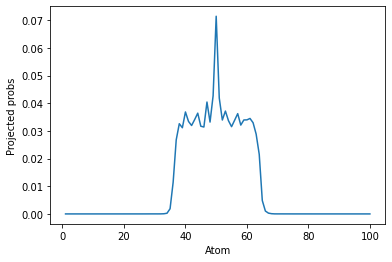

Episode 20: 	Actor Loss: -0.33 	Critic Loss: 2.68 
		Average Score: 4.65

SCORES (this eps):  [0.39760317 0.48012386 0.50730961 0.49679858 3.75196222 3.84662699
 4.77334663 4.85358892 6.00300071 2.46127524 5.03915865 1.01539481] 



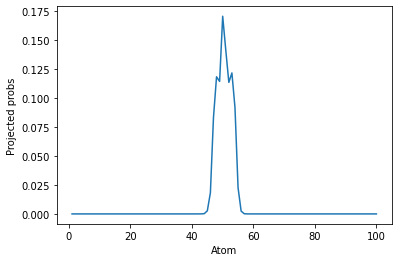

Episode 30: 	Actor Loss: -1.34 	Critic Loss: 1.89 
		Average Score: 14.49

SCORES (this eps):  [10.15598288 11.30976681 10.61254921  1.76138238 18.05986767 41.22998866
 22.30229562 42.82833958 38.22091608  0.23042956 16.10668443  3.02531543] 



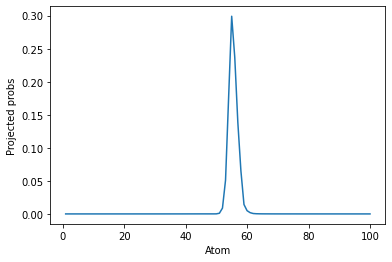

Episode 40: 	Actor Loss: -3.96 	Critic Loss: 1.95 
		Average Score: 26.27

SCORES (this eps):  [ 1.36205101e+01  3.07115712e+01  0.00000000e+00  5.81761891e+01
  8.15119476e+01  6.86751491e+01  1.04407591e+01  8.34487183e+01
  9.28269186e+01 -7.51009881e-02  3.13282592e+01  4.80126223e+01] 



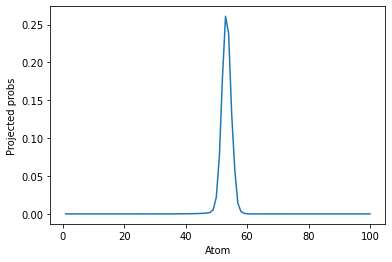

Episode 50: 	Actor Loss: -6.52 	Critic Loss: 2.10 
		Average Score: 26.07

SCORES (this eps):  [  5.46018738  41.41115224 133.10065936 111.32702461   4.04849646
  13.92750955   8.88096106  39.58548042   2.17397855   4.45704525
  21.0085312   26.86384493] 



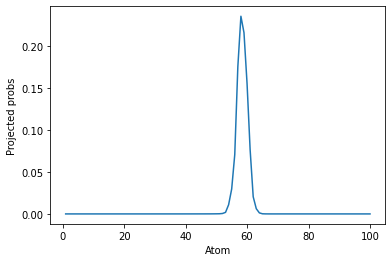

Episode 60: 	Actor Loss: -8.44 	Critic Loss: 2.16 
		Average Score: 34.11

SCORES (this eps):  [29.16474127 52.1825999   8.27265848 14.21898355 88.86647628 10.16830992
 74.84761686 14.49079414 77.00390655 64.94576459  2.38204842 20.73238638] 



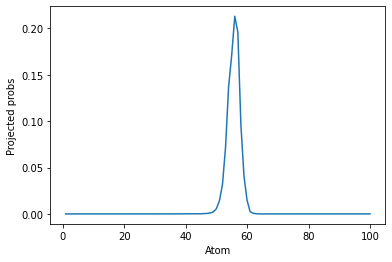

Episode 70: 	Actor Loss: -9.78 	Critic Loss: 2.20 
		Average Score: 38.97

SCORES (this eps):  [ 63.6829964    6.45716009  29.11625868  66.2440669   98.77653108
  27.12418283  23.53270406   7.66480914   5.4067401  102.2713836
  48.22285808   6.91925209] 



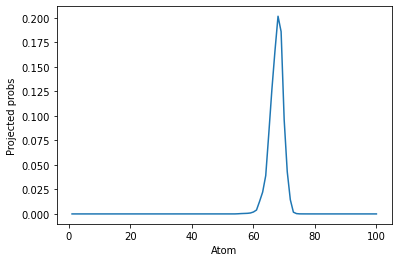

Episode 80: 	Actor Loss: -10.76 	Critic Loss: 2.23 
		Average Score: 53.42

SCORES (this eps):  [ 65.15292008  43.00117779  13.52184598  16.29769822  25.90592654
  30.35907052   8.72672761  16.72871651 107.67918066 130.75477319
  12.37027073  82.6326298 ] 



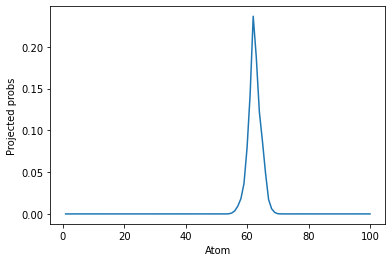

Episode 83\ Score: 58.57NaN Reward Found! Skipping this episode.
Episode 90: 	Actor Loss: -11.58 	Critic Loss: 2.26 
		Average Score: 29.69

SCORES (this eps):  [  0.14886833  10.89946584  66.30986966 131.84977701  63.40173397
 141.07260778  16.59905724  24.40661079 110.24637637  69.90353341
  55.79683241   3.17844506] 



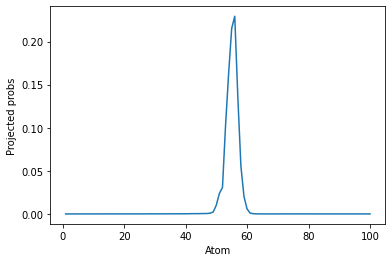

Episode 93\ Score: 45.22NaN Reward Found! Skipping this episode.
Episode 100: 	Actor Loss: -13.01 	Critic Loss: 2.33 
		Average Score: 58.72

SCORES (this eps):  [3.95539294e+01 1.85584216e+01 1.04663136e+02 1.95084326e-02
 6.69591622e+01 6.68335171e+00 1.99179720e+00 4.77081066e+00
 2.74898549e+01 2.05736695e+01 1.53503572e+02 3.30490841e+01] 



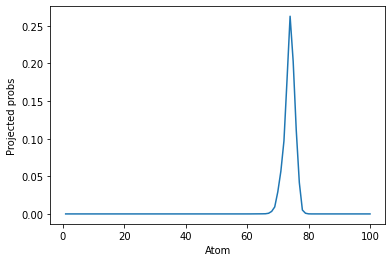

Episode 110: 	Actor Loss: -14.43 	Critic Loss: 2.33 
		Average Score: 65.44

SCORES (this eps):  [115.920406   181.32724107  95.09530965  70.74772657  21.08059693
   2.71939461  54.10398146  88.23986825 261.74484965 170.8414198
   1.4364497    8.22864894] 



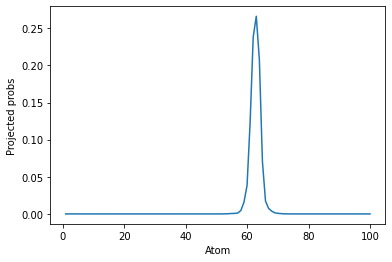

Episode 116\ Score: 120.51NaN Reward Found! Skipping this episode.
Episode 120: 	Actor Loss: -15.43 	Critic Loss: 2.33 
		Average Score: 74.93

SCORES (this eps):  [116.46838731   7.43469088  65.57334276  11.71139934  10.26691337
  31.17644561 125.52113725  41.21017791   0.16279295   5.91509568
  12.22320774  36.28486339] 



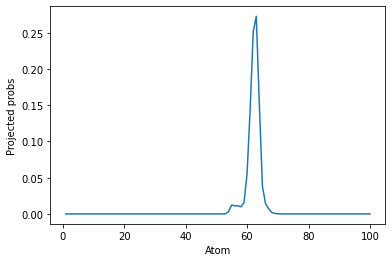

Episode 121\ Score: 76.86Errorneously low Reward = -30.01 Found! Doing nothing...
[0.6062036752700806, -30.012939453125, 0.8977750539779663, 0.8090731501579285, 1.3008666038513184, 1.297224998474121, 0.6920950412750244, 0.6867803335189819, 1.131056785583496, 0.7823432087898254, 1.2475073337554932, 0.04377990961074829]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.10 Found! Doing nothing...
[0.8014316558837891, -30.101158142089844, 1.0667260885238647, 0.941697895526886, 1.2259849309921265, 1.3176764249801636, 0.7856904864311218, 0.4677891135215759, 1.1943250894546509, 0.6224051713943481, 1.1721305847167969, 0.042228762060403824]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.21 Found! Doing nothing...
[-0.15094058215618134, -30.205705642700195, 1.089004397392273, 1.0094821453094482, 1.3080958127975464, 0.9392309784889221, 0.7807002663612366, 0.4547654688358307, 1.2818951606750488, 0.717633068561554, 1.2209010124206543, 0.580990195274353]
SKIPPING TRA

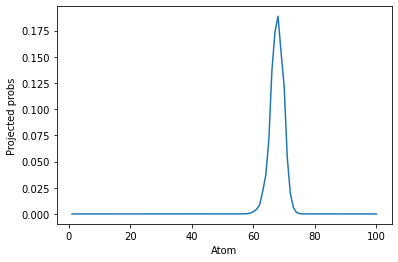

Episode 140: 	Actor Loss: -16.92 	Critic Loss: 2.34 
		Average Score: 87.48

SCORES (this eps):  [5.83330772e+01 2.56557196e+01 4.22219336e-02 4.38284785e+01
 7.68453913e+01 2.05090216e+01 1.07730987e+01 8.30487888e+01
 1.53913690e+01 5.62457331e-02 8.00173562e-02 1.93258859e-02] 



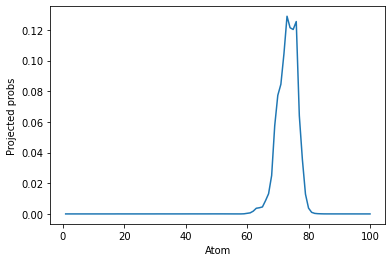

Episode 144\ Score: 72.500NaN Reward Found! Skipping this episode.
Episode 147\ Score: 81.885NaN Reward Found! Skipping this episode.
Episode 150: 	Actor Loss: -17.76 	Critic Loss: 2.36 
		Average Score: 102.50

SCORES (this eps):  [3.70713256e+01 0.00000000e+00 4.78375039e+02 9.04101119e-02
 6.42114252e+01 7.43443635e+01 2.84504097e+01 1.12442813e+02
 3.07437517e+02 8.53088956e+01 1.51012723e+01 9.42632322e+01] 



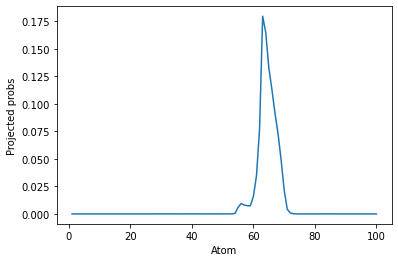

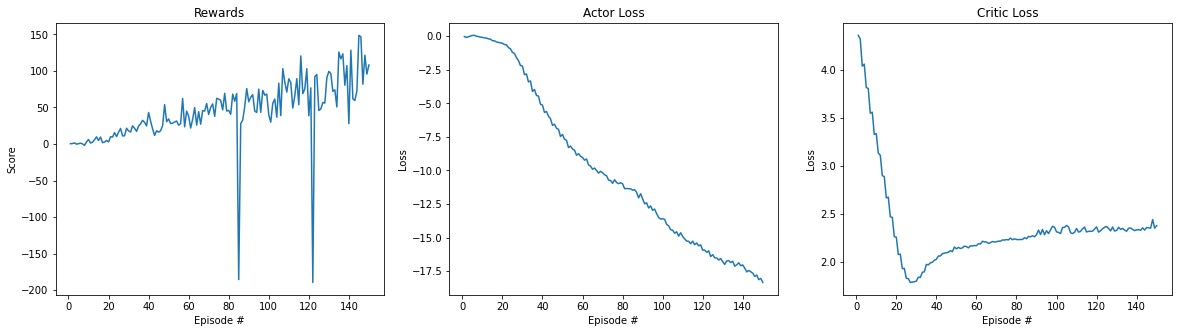

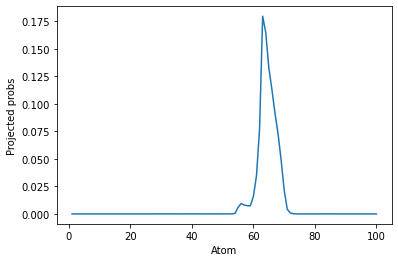

[0.4867976730844627,
 0.604431412415579,
 1.5712767586422463,
 -0.17699864010016123,
 0.4320108127625038,
 1.2297854961749788,
 0.24636144801237,
 -1.8545873401647743,
 2.9420906519517303,
 6.23932460170666,
 1.3505902297947614,
 2.6399815573507417,
 5.77298988676436,
 9.840440285314495,
 4.9280225474697845,
 9.552699035033584,
 1.9114796110467676,
 2.7666588089681077,
 4.9760385086992756,
 2.802182448717455,
 10.04727758289664,
 9.520105422144601,
 15.561526465928182,
 10.19297725680129,
 16.23927344168381,
 21.25782543459597,
 11.110843778665489,
 11.366237480659038,
 21.570169658749364,
 17.98695986031089,
 16.37725159987652,
 24.907017855439335,
 21.51645093364641,
 17.359031678526662,
 24.666414953108568,
 27.717118195180472,
 32.459416006497726,
 29.67152154255503,
 24.825379162095487,
 43.223128626006655,
 31.25453297207908,
 20.784900188368436,
 11.764418994969068,
 18.182633773889393,
 16.276075548880424,
 18.254664660664275,
 25.29343345637123,
 53.90905017328138,
 30.6183382

In [68]:
# 3 layers network instead...
# ACHIEVED: -

##################
# Vmax = -Vmin = 50
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=150
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_50_longest'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_50_longest'
params.num_atoms = 100
params.vmin = -50
params.vmax = 50


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -75
VMAX:  75
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.25 	Critic Loss: 3.81 
		Average Score: 1.59

SCORES (this eps):  [ 1.7974367   5.1334389   0.46406728 18.86386971  0.21168384  9.46270995
  2.39191057 26.66169466 -5.83475193  0.37632669  3.86674562 -6.68979993] 



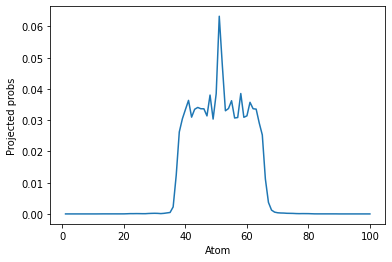

Episode 20: 	Actor Loss: -1.09 	Critic Loss: 2.66 
		Average Score: 7.86

SCORES (this eps):  [ 3.85340281  9.709712    1.75127686  1.0924296   6.31834242 10.28878728
 10.7639713  11.50255453 19.21976882  0.80500362  5.81094758  0.5111013 ] 



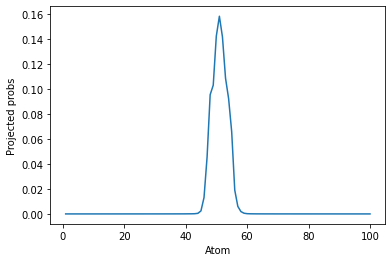

Episode 30: 	Actor Loss: -3.67 	Critic Loss: 1.94 
		Average Score: 17.78

SCORES (this eps):  [39.38460415 23.48645875  0.90734113 64.60021695  3.12077225 49.20343132
 14.51394294 20.83811248  1.92959881 14.03868296 33.61921162  3.06631138] 



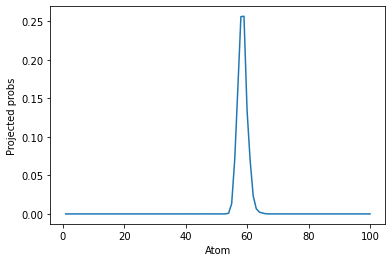

Episode 40: 	Actor Loss: -7.12 	Critic Loss: 1.87 
		Average Score: 25.05

SCORES (this eps):  [22.11479209  3.31330928  0.90079598  3.37584101  6.15640143  2.27934786
  6.299067   44.11997352 26.07065513 31.07343242 16.65297217 37.86823731] 



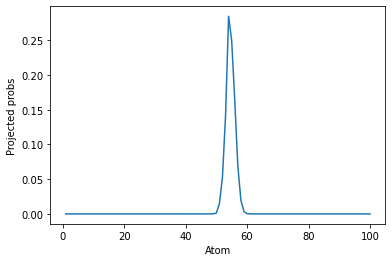

Episode 44\ Score: 30.08Errorneously low Reward = -30.10 Found! Doing nothing...
[1.1214083433151245, 0.045796457678079605, -30.103862762451172, 0.9781389236450195, 0.11340413987636566, 0.3949173390865326, 1.0075653791427612, 1.3329099416732788, 1.1327234506607056, 0.3073621392250061, 1.049618124961853, 0.7777517437934875]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.25 Found! Doing nothing...
[1.0987290143966675, 0.1375831663608551, -30.25211524963379, 0.9674798846244812, 0.22262124717235565, 0.46583834290504456, 1.080000638961792, 1.1888192892074585, 1.1785974502563477, 0.30098262429237366, 1.1599663496017456, 0.8640950918197632]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.22 Found! Doing nothing...
[1.1557577848434448, 0.08047971874475479, -30.22323989868164, 0.9397156834602356, 0.37399014830589294, -0.7879226803779602, 1.0626561641693115, 1.1707746982574463, -0.6789628863334656, 0.326336532831192, 1.057875156402588, 0.8115761280059814]
SKIPP

Errorneously low Reward = -33.47 Found! Doing nothing...
[-0.07090988755226135, 0.8327922821044922, -33.4664192199707, 0.9446687698364258, 0.849234938621521, 0.11398620903491974, 1.4738816022872925, 0.24927502870559692, 1.3293946981430054, 0.7178816199302673, 0.39448437094688416, 1.0675793886184692]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.65 Found! Doing nothing...
[0.25549301505088806, 0.8649997711181641, -33.64692306518555, 0.8199838995933533, 0.9504997730255127, 0.0932442843914032, -0.3703352212905884, 0.02246580459177494, 1.1723731756210327, 0.9289652705192566, 0.3222067356109619, 1.119894027709961]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.77 Found! Doing nothing...
[0.035200316458940506, 0.9085710644721985, -33.76835632324219, 0.9203217029571533, 0.9007951021194458, 0.17185699939727783, -0.03714191913604736, 0.2155136615037918, 1.1921939849853516, 0.753841757774353, 0.39188268780708313, -1.0]
SKIPPING TRAINING OF THIS TIMESTEP
Error

Errorneously low Reward = -36.94 Found! Doing nothing...
[0.34405434131622314, 0.6610284447669983, -36.935508728027344, 0.09552446752786636, 1.0996127128601074, 1.2579630613327026, 1.1853241920471191, 1.2909424304962158, 1.250093936920166, 0.3217245936393738, 0.04387281835079193, 0.7519930005073547]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -37.01 Found! Doing nothing...
[0.3310949206352234, 0.6706751585006714, -37.00844192504883, 0.15144406259059906, 0.862612783908844, 1.2984905242919922, 1.3717436790466309, 1.308700680732727, 1.3283640146255493, 0.1974991261959076, 0.05421934276819229, 0.7619595527648926]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -37.04 Found! Doing nothing...
[0.3166215419769287, 0.6773919463157654, -37.04307174682617, 0.2000097781419754, 0.9460704922676086, 1.2027031183242798, 1.2763473987579346, 1.1797895431518555, 1.1915318965911865, 0.30499422550201416, -0.053326886147260666, 0.9661567211151123]
SKIPPING TRAINING OF THIS TIM

Errorneously low Reward = -40.20 Found! Doing nothing...
[1.0130767822265625, 1.2117711305618286, -40.19736099243164, 1.2765604257583618, 0.9760813117027283, 1.1926127672195435, 0.8340408205986023, 0.8701555728912354, 1.082714557647705, 0.41628506779670715, -0.7510917782783508, 0.17132465541362762]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -40.26 Found! Doing nothing...
[1.0675379037857056, 1.1777825355529785, -40.258697509765625, 1.2191184759140015, 0.6557673215866089, 1.2620887756347656, 0.826749324798584, 0.919215738773346, 1.1851000785827637, 0.3777918815612793, -0.07830008864402771, 0.3775099515914917]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -40.33 Found! Doing nothing...
[1.122490644454956, 1.1698132753372192, -40.32957458496094, 1.148962140083313, 0.7029667496681213, 1.324836254119873, 0.9554563164710999, 0.995291531085968, 1.0418264865875244, 0.33034849166870117, 0.05349277704954147, 0.5310049653053284]
SKIPPING TRAINING OF THIS TIMESTEP


Errorneously low Reward = -43.34 Found! Doing nothing...
[0.055724844336509705, 0.18341343104839325, -43.34381866455078, 0.11596658080816269, 0.23256513476371765, 0.990936815738678, 0.8699904084205627, 1.126584768295288, 0.30966073274612427, 1.0378841161727905, 0.649412214756012, 0.46687203645706177]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -43.49 Found! Doing nothing...
[0.06515216827392578, 0.03558971732854843, -43.48923110961914, -0.029920727014541626, 0.13157916069030762, 0.9437249898910522, 0.5955652594566345, 1.0238535404205322, -0.5626642107963562, 0.908240556716919, 0.7461115121841431, 0.48924022912979126]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -43.59 Found! Doing nothing...
[0.14448215067386627, 0.09901739656925201, -43.58802032470703, 0.1429518759250641, 0.23455794155597687, 0.9728233814239502, 1.0096992254257202, 1.1869418621063232, 0.05818812921643257, 1.0103567838668823, 0.7721949219703674, 0.3833906948566437]
SKIPPING TRAINING OF 

Errorneously low Reward = -46.47 Found! Doing nothing...
[1.139559030532837, 1.2172203063964844, -46.47309875488281, 1.2360137701034546, 0.32968834042549133, 0.43527019023895264, 0.9609862565994263, 0.19773699343204498, 0.9149603843688965, 0.31251227855682373, -0.9618805646896362, 0.08950816839933395]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -46.42 Found! Doing nothing...
[1.1889704465866089, 1.1042345762252808, -46.42058563232422, 1.1441222429275513, 0.1986987143754959, 0.37454405426979065, 0.8589629530906677, 0.3004645109176636, 0.9179311990737915, 0.3635619580745697, 0.017833305522799492, 0.09015841037034988]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -46.59 Found! Doing nothing...
[1.2854710817337036, 1.0212812423706055, -46.58864212036133, 1.1650441884994507, 0.45494839549064636, 0.3500347137451172, 0.7655996084213257, 0.09271063655614853, 0.8465290069580078, 0.37502384185791016, 0.19654043018817902, -0.23530414700508118]
SKIPPING TRAINING OF 

Errorneously low Reward = -49.49 Found! Doing nothing...
[0.7684506177902222, 0.2114662081003189, -49.48747253417969, 1.1335241794586182, 0.9940165281295776, 0.9659940600395203, 0.07474708557128906, 1.0105997323989868, 0.9819556474685669, 1.154899001121521, 0.22313210368156433, -0.22746996581554413]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -49.63 Found! Doing nothing...
[0.8022001385688782, 0.1348818987607956, -49.6348876953125, 1.0959161520004272, 1.018428921699524, 1.002399206161499, 0.25306186079978943, 0.9101656079292297, 1.2695040702819824, 1.0960674285888672, 0.5932765007019043, -0.21119481325149536]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -49.80 Found! Doing nothing...
[0.7283771634101868, 0.1531096249818802, -49.80305862426758, 1.2903861999511719, 1.1738810539245605, 1.0381968021392822, 0.06234879046678543, 1.0713285207748413, 1.0063353776931763, -0.7774041295051575, 0.7390393018722534, -0.21347208321094513]
SKIPPING TRAINING OF THIS TIM

Errorneously low Reward = -52.73 Found! Doing nothing...
[0.08969324082136154, 0.1049719974398613, -52.73356246948242, -0.024514544755220413, 0.9311529397964478, 0.021208634600043297, 0.6634361147880554, 1.244488000869751, -0.02810027450323105, 0.8635212779045105, 1.0651288032531738, 0.09780622273683548]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -52.83 Found! Doing nothing...
[0.08137660473585129, 0.1617458164691925, -52.834739685058594, 0.25841784477233887, 1.222362995147705, 0.07411027699708939, 0.7185986638069153, 1.1780977249145508, -0.0017148414626717567, 0.9992770552635193, -0.45739510655403137, -0.02348914183676243]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -52.92 Found! Doing nothing...
[0.036218032240867615, 0.046894773840904236, -52.92036056518555, 0.02187863364815712, 1.0147147178649902, 0.006064936518669128, -0.7481736540794373, 1.1975446939468384, 0.049016837030649185, 0.8007746338844299, -0.0811515599489212, 0.1411353498697281]
SKIPPI

Errorneously low Reward = -55.79 Found! Doing nothing...
[1.1304465532302856, 0.9482281804084778, -55.79342269897461, 0.644660472869873, 0.8355072736740112, 1.2736736536026, 0.4212503433227539, 0.1672850102186203, 1.1170620918273926, 0.994925320148468, 0.9019622802734375, -0.8061853051185608]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -55.89 Found! Doing nothing...
[0.8154392242431641, 1.0895369052886963, -55.89307403564453, 0.8439058065414429, 0.9722399711608887, 1.328166127204895, 0.354500412940979, 0.09659220278263092, 1.0370609760284424, 1.0513298511505127, 0.8820580244064331, 0.017420262098312378]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -56.00 Found! Doing nothing...
[0.8265218138694763, 1.0318118333816528, -56.00382995605469, 0.737763524055481, 0.9345638751983643, 1.2483354806900024, 0.581446647644043, 0.12675487995147705, 1.2656028270721436, 1.0684661865234375, 0.9286326169967651, 0.06460639834403992]
SKIPPING TRAINING OF THIS TIMESTEP
Erro

Errorneously low Reward = -58.88 Found! Doing nothing...
[0.9539110064506531, 0.5585362315177917, -58.8791618347168, 0.5557042360305786, 0.11337484419345856, 0.8339185118675232, 0.2522639334201813, 1.0238080024719238, 1.2715424299240112, 0.3161359131336212, 0.8583195209503174, 1.0148407220840454]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -58.99 Found! Doing nothing...
[0.930966317653656, 0.5073750019073486, -58.98933792114258, 0.7272987365722656, 0.19650772213935852, 1.1435505151748657, 0.17469969391822815, -0.6503984928131104, 1.2694201469421387, 0.25239232182502747, 0.8122274279594421, 1.174630045890808]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -59.12 Found! Doing nothing...
[0.9690024256706238, 0.573457658290863, -59.118064880371094, 0.7929192185401917, 0.3038616180419922, 1.0290712118148804, 0.31414589285850525, 0.010549178346991539, -0.7446998357772827, 0.29945942759513855, 0.7071052193641663, 1.0249392986297607]
SKIPPING TRAINING OF THIS TIM

Errorneously low Reward = -61.60 Found! Doing nothing...
[0.7105400562286377, 0.629465639591217, -61.601016998291016, 0.6397373676300049, 0.9935826659202576, 0.3560921847820282, 1.0045166015625, 1.2708520889282227, 1.0065689086914062, 1.2022738456726074, 0.37878111004829407, 1.2172956466674805]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -61.71 Found! Doing nothing...
[0.9442310929298401, 0.7082601189613342, -61.71332931518555, 1.073757290840149, 0.7997287511825562, 0.24913790822029114, 0.9187909364700317, 1.1551686525344849, 0.7428691387176514, 1.3119477033615112, 0.2240096777677536, 1.1647003889083862]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -61.78 Found! Doing nothing...
[0.8897092342376709, 0.6156725883483887, -61.78404998779297, 1.0675727128982544, 0.6005683541297913, 0.36683720350265503, 0.9776163101196289, 1.2294450998306274, 0.9399399161338806, 1.1293352842330933, 0.388857901096344, 1.119118094444275]
SKIPPING TRAINING OF THIS TIMESTEP
Erro

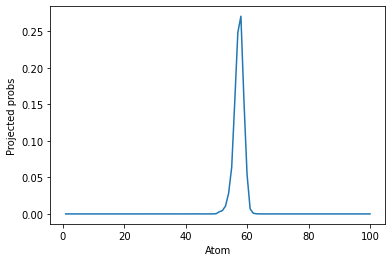

Errorneously low Reward = -30.06 Found! Doing nothing...
[1.0216939449310303, -30.058012008666992, 1.4241927862167358, 0.8018994927406311, 0.4711110591888428, 0.8093796968460083, 0.9851130247116089, 1.2362717390060425, 0.32849523425102234, 1.1300715208053589, 0.14996495842933655, 0.08745106309652328]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.22 Found! Doing nothing...
[1.0119616985321045, -30.2159481048584, 1.2832365036010742, 1.168020486831665, 0.3215002119541168, 0.9183525443077087, 0.871902346611023, 1.333490252494812, 0.49202820658683777, 1.01685631275177, 0.12754996120929718, 0.038282036781311035]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.26 Found! Doing nothing...
[1.0136713981628418, -30.259334564208984, 1.1115068197250366, 1.2312712669372559, 0.3561044931411743, 0.958764910697937, 0.7966174483299255, 1.23349928855896, 0.7213407158851624, 0.7718201279640198, 0.1425967961549759, 0.3031952977180481]
SKIPPING TRAINING OF THIS TIMESTEP
E

Errorneously low Reward = -33.21 Found! Doing nothing...
[0.9295550584793091, -33.20873260498047, 0.3830246031284332, 0.9841410517692566, 0.38894903659820557, -1.0, 0.9086851477622986, 1.4805153608322144, 1.0561084747314453, 1.1872138977050781, 1.0800930261611938, 0.6481924057006836]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.40 Found! Doing nothing...
[-0.7829482555389404, -33.40458679199219, 0.7731515169143677, 1.081041693687439, 0.6964687705039978, 0.019363341853022575, 0.8192232251167297, 1.327113389968872, 1.1694073677062988, 1.4056087732315063, 1.0438331365585327, 0.7960851192474365]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.47 Found! Doing nothing...
[0.052528634667396545, -33.47029113769531, 0.9742162823677063, 1.1253160238265991, 0.6260852217674255, 0.0869116336107254, 0.8770973682403564, 1.4279236793518066, 1.2640305757522583, 1.237528681755066, 1.131077527999878, 0.8683419823646545]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously 

Errorneously low Reward = -36.59 Found! Doing nothing...
[1.1256576776504517, -36.59450149536133, 1.2853124141693115, 1.1677334308624268, 0.7955029606819153, 1.3063316345214844, 0.5489541888237, 0.9568063020706177, 0.6996010541915894, 0.16274277865886688, 0.786464512348175, 0.9568628668785095]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -36.74 Found! Doing nothing...
[1.0960209369659424, -36.73735427856445, 1.2388241291046143, 1.075956106185913, -1.0, 1.2647874355316162, 0.42391645908355713, 0.8336825370788574, 1.0540801286697388, 0.24069148302078247, 0.9350433349609375, 0.9581558108329773]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -36.86 Found! Doing nothing...
[1.1005388498306274, -36.85943603515625, 1.3022725582122803, 1.1292192935943604, -0.03239233419299126, 1.433853030204773, 0.28665921092033386, 0.8155315518379211, 0.7034211158752441, 0.26524895429611206, 0.8274703025817871, 0.928002119064331]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously lo

Errorneously low Reward = -39.77 Found! Doing nothing...
[0.3517109155654907, -39.76676559448242, 0.5981979966163635, 0.8255053758621216, 1.06485915184021, 1.079972267150879, 0.2880549430847168, 0.8671541213989258, 0.8604884743690491, 1.0404607057571411, 0.7935653924942017, 1.441514015197754]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -39.86 Found! Doing nothing...
[0.10509505122900009, -39.860286712646484, 0.2153872698545456, 0.7545228004455566, 1.1052660942077637, 1.031714916229248, 0.46711429953575134, 0.794799268245697, 0.6558789014816284, 1.0211111307144165, 0.7920788526535034, 1.4245753288269043]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -39.85 Found! Doing nothing...
[0.30338048934936523, -39.84749984741211, 0.3821867108345032, 0.7165523767471313, 1.128098726272583, 1.0593898296356201, 0.4186655282974243, 0.955350935459137, 0.7052416205406189, 1.1869380474090576, 0.9205355644226074, 1.5137372016906738]
SKIPPING TRAINING OF THIS TIMESTEP
Error

Errorneously low Reward = -42.91 Found! Doing nothing...
[1.0537574291229248, -42.91349792480469, 0.5337617993354797, 1.2834925651550293, 1.2106454372406006, 0.7585877180099487, 0.12812255322933197, 1.08159601688385, 0.36797189712524414, 1.0331931114196777, 1.5301778316497803, 0.8280109763145447]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -42.97 Found! Doing nothing...
[1.194928526878357, -42.96823501586914, 0.9685141444206238, 1.2000116109848022, 1.5234894752502441, 0.9387189149856567, 0.11544573307037354, 1.010725975036621, 0.5357874035835266, -0.6427954435348511, 1.5217154026031494, 0.793409526348114]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -43.08 Found! Doing nothing...
[1.1611899137496948, -43.07676696777344, 0.6698166728019714, 1.1010421514511108, 1.4327425956726074, 0.9038182497024536, 0.2757403254508972, 1.1245828866958618, 0.6057969331741333, -0.0002412879839539528, 1.500570297241211, 0.8030251860618591]
SKIPPING TRAINING OF THIS TIMESTEP

Errorneously low Reward = -46.18 Found! Doing nothing...
[0.8757964372634888, -46.18107604980469, 1.1682052612304688, 1.094079613685608, 0.15988674759864807, 0.2803710103034973, 1.0183318853378296, 1.2315165996551514, 1.0086541175842285, 0.32275649905204773, 0.8748836517333984, 1.0233169794082642]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -46.29 Found! Doing nothing...
[1.1871843338012695, -46.288108825683594, 1.1629499197006226, 0.981515109539032, 0.17663520574569702, 0.2097439467906952, 0.7733450531959534, 1.2217739820480347, 0.9681117534637451, 0.6061575412750244, 1.017733097076416, 1.1110451221466064]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -46.43 Found! Doing nothing...
[0.95383220911026, -46.42973327636719, 1.1275509595870972, 1.0381231307983398, 0.13529086112976074, 0.07943321019411087, 0.8183116912841797, 1.354180932044983, 1.3531031608581543, 0.5591343641281128, 1.1790096759796143, 1.0358744859695435]
SKIPPING TRAINING OF THIS TIMESTEP
E

Errorneously low Reward = -49.37 Found! Doing nothing...
[1.0646532773971558, -49.372344970703125, 1.3212883472442627, 1.0631879568099976, 0.9948524236679077, 0.3860550820827484, 1.0906938314437866, 1.0927525758743286, 0.7151927947998047, 1.0537189245224, 1.2149981260299683, 0.9217809438705444]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -49.55 Found! Doing nothing...
[1.0642794370651245, -49.54605484008789, 1.4051271677017212, 1.1160988807678223, 1.0352994203567505, 0.4384293854236603, 1.039726734161377, 1.228832721710205, 0.4384634792804718, 1.2891900539398193, 1.4640491008758545, 0.9441591501235962]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -49.62 Found! Doing nothing...
[1.1293238401412964, -49.62496566772461, 1.1481457948684692, 1.1000709533691406, 1.0930452346801758, 0.4432133734226227, 0.9535430669784546, 1.178791880607605, 0.39573267102241516, 1.3889198303222656, 1.2984963655471802, 1.0329387187957764]
SKIPPING TRAINING OF THIS TIMESTEP
Error

Errorneously low Reward = -52.46 Found! Doing nothing...
[0.24066105484962463, -52.461036682128906, 0.9132355451583862, 1.0319879055023193, 0.29734355211257935, 1.5716556310653687, 0.10060261934995651, 1.2491767406463623, 1.2015894651412964, 0.551537811756134, 0.7095643281936646, 0.23499679565429688]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -52.53 Found! Doing nothing...
[0.23085962235927582, -52.527366638183594, 0.7919631600379944, 0.9328055381774902, 0.3780394196510315, 1.453704833984375, 0.2355395257472992, 1.3983585834503174, 1.0490493774414062, 0.4755157232284546, 0.9356899857521057, 0.3238058388233185]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -52.76 Found! Doing nothing...
[0.21897226572036743, -52.7611083984375, -0.5966296792030334, 0.28387007117271423, 0.36465713381767273, 1.279811143875122, 0.17560794949531555, 1.5237045288085938, 0.9781767725944519, 0.5392582416534424, 1.0620036125183105, 0.344739705324173]
SKIPPING TRAINING OF THIS TIM

Errorneously low Reward = -55.72 Found! Doing nothing...
[0.2945845127105713, -55.71883010864258, 0.24015986919403076, 0.5801502466201782, 0.992188572883606, 0.8014364242553711, 1.543839693069458, 0.9676638245582581, 1.6522741317749023, 0.39402490854263306, 1.1151187419891357, 0.7564802169799805]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -55.81 Found! Doing nothing...
[0.39492884278297424, -55.8115119934082, 0.3600069284439087, 0.7088474631309509, 0.9911851286888123, 0.8787270784378052, 1.2616925239562988, 0.8613955974578857, 1.4918632507324219, 0.5849329233169556, 0.8000501990318298, 0.6438071727752686]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -55.89 Found! Doing nothing...
[0.3952995836734772, -55.88881301879883, 0.35829126834869385, 0.6436882615089417, 0.9936195015907288, 1.0547327995300293, 1.2821274995803833, 0.9627088308334351, 1.4352275133132935, 0.7825855612754822, 0.9233570098876953, 0.7891784906387329]
SKIPPING TRAINING OF THIS TIMESTEP


Errorneously low Reward = -58.75 Found! Doing nothing...
[1.1415538787841797, -58.74884796142578, 0.7676879167556763, 0.8269673585891724, -0.20429137349128723, 0.4513186514377594, 0.2366807609796524, 0.30825698375701904, 0.02623623050749302, 0.38560399413108826, 0.17086809873580933, 0.3745433986186981]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -58.86 Found! Doing nothing...
[1.167710542678833, -58.86270523071289, -1.0, 0.7325072288513184, -0.24314026534557343, 0.4359111785888672, 0.3699595332145691, 0.39871475100517273, 0.13440068066120148, 0.3883604407310486, 0.1616774946451187, 0.22919395565986633]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -59.03 Found! Doing nothing...
[1.006148338317871, -59.03124237060547, 0.034596748650074005, 0.8086696267127991, -1.1274782419204712, 0.6258745193481445, 0.25740280747413635, 0.5815809965133667, -0.011028749868273735, 0.4214610159397125, -0.07502253353595734, 0.3099013864994049]
SKIPPING TRAINING OF THIS TIMEST

Errorneously low Reward = -61.77 Found! Doing nothing...
[0.19949465990066528, -61.77362060546875, 0.9283643364906311, 0.8963435292243958, 1.2335026264190674, 1.0813068151474, 0.9925275444984436, 1.2523820400238037, 1.1449551582336426, 0.5460780262947083, -1.2514466047286987, 0.985887885093689]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -61.84 Found! Doing nothing...
[0.469478577375412, -61.835899353027344, 0.9772515296936035, 1.0964092016220093, 1.2544118165969849, 1.1686757802963257, 0.9773468375205994, 1.3356947898864746, 1.0771150588989258, 0.4901239275932312, 0.03176948428153992, 1.1592257022857666]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -62.05 Found! Doing nothing...
[0.20955199003219604, -62.052085876464844, 0.9435648918151855, 0.9481498003005981, 1.1089569330215454, 1.1576181650161743, 0.924580991268158, 1.2833242416381836, 1.0259037017822266, 0.45340654253959656, 0.015530705451965332, 1.4010803699493408]
SKIPPING TRAINING OF THIS TIMESTE

Errorneously low Reward = -64.88 Found! Doing nothing...
[1.091308832168579, -64.87548065185547, 0.42350345849990845, 0.8565459847450256, 1.1513696908950806, 0.947443962097168, 0.29534170031547546, 1.0665788650512695, 0.9022775292396545, 0.5428652167320251, 0.6751239895820618, 1.6274555921554565]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -65.02 Found! Doing nothing...
[1.1903926134109497, -65.02023315429688, 0.36356016993522644, 0.8998968601226807, 1.1739468574523926, 0.848422110080719, 0.6762943863868713, 1.109930396080017, 0.7205721735954285, 0.31537216901779175, 0.9111055731773376, 1.1747721433639526]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -65.05 Found! Doing nothing...
[1.173540472984314, -65.05335998535156, 0.5602481961250305, 0.9079988598823547, 1.197031021118164, 0.38911136984825134, 0.8331613540649414, 1.0143970251083374, 0.65097975730896, 0.2588018476963043, 0.8077909350395203, 1.2522125244140625]
SKIPPING TRAINING OF THIS TIMESTEP
Erro

Episode 60: 	Actor Loss: -11.77 	Critic Loss: 2.04 
		Average Score: 4.85

SCORES (this eps):  [ 10.97098093  14.01354178  67.94456781 120.33274406   4.58261986
  63.68908369  11.87270571  11.47875475   0.         174.41979766
  89.84445516  16.93992974] 



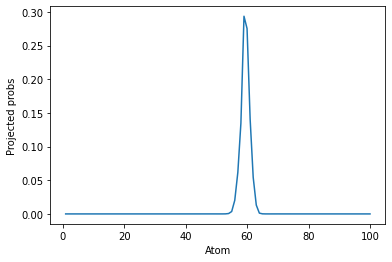

Episode 68\ Score: 56.89NaN Reward Found! Skipping this episode.
Episode 70: 	Actor Loss: -12.89 	Critic Loss: 2.04 
		Average Score: 46.87

SCORES (this eps):  [  1.63416113  39.16360543  22.72129609  14.9783855   97.69108801
  28.18966629  86.29178462  59.0148864   93.38856329  27.89067399
 248.94624536  72.06052772] 



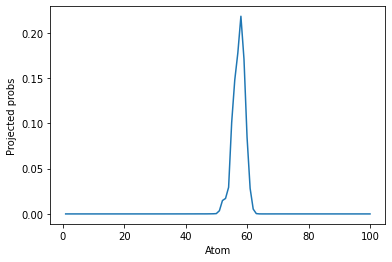

Episode 80: 	Actor Loss: -13.83 	Critic Loss: 2.04 
		Average Score: 47.05

SCORES (this eps):  [ 4.28295519 50.91031909 25.89899832 29.38388895  2.01766577  9.54796392
 73.31529522 17.56542359 15.63539206 48.96167135 89.96260662 71.38889337] 



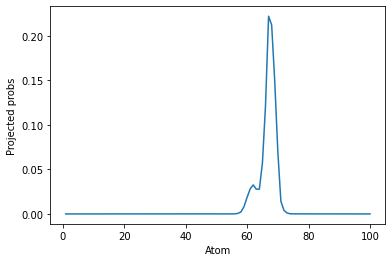

Episode 90: 	Actor Loss: -14.94 	Critic Loss: 2.06 
		Average Score: 64.74

SCORES (this eps):  [25.82175879 50.0400072  17.7554579  56.40943617 20.74336481 45.5185938
 74.44552528 58.60918768 28.6820345  30.21776958 50.07001522 77.36917971] 



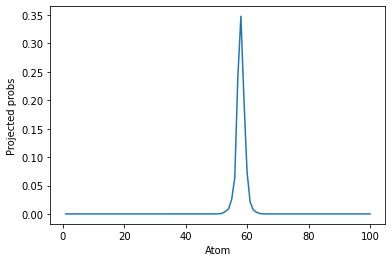

Episode 100: 	Actor Loss: -16.78 	Critic Loss: 2.08 
		Average Score: 84.51

SCORES (this eps):  [ 21.50072063  13.05993544 309.85779404  10.07421902 144.71405664
   9.66081958 165.63905731 112.83484811  54.9699964  217.98749173
  24.9470568  163.408884  ] 



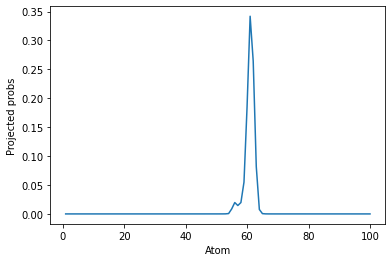

Episode 110: 	Actor Loss: -18.76 	Critic Loss: 2.08 
		Average Score: 88.35

SCORES (this eps):  [ 14.86964079  16.14413756  42.89410617  40.20054059 228.84673005
 409.1747445   25.22687786   3.57652995  54.89199711  59.78615865
  60.05990219   8.01075812] 



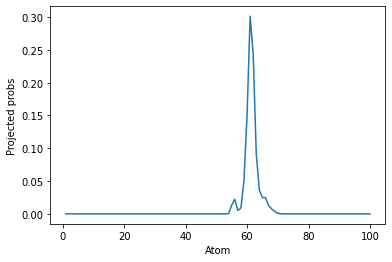

Episode 111\ Score: 90.07
NaN found in states. Skipping this episode.
Episode 112\ Score: 115.81

scripts\d4pg_agent.py:187: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), self.params.gradient_clip)    # ADDED: Gradient Clipping to prevent exploding grad issue
scripts\d4pg_agent.py:180: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), self.params.gradient_clip)    # ADDED: Gradient Clipping to prevent exploding grad issue



NaN found in actions. Skipping this episode.
Episode 113\ Score: 150.82
NaN found in states. Skipping this episode.
Episode 114\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 115\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 116\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 117\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 118\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 119\ Score: 0.00
NaN found in states. Skipping this episode.


==== An exception occurred: The histogram is empty, please file a bug report.

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

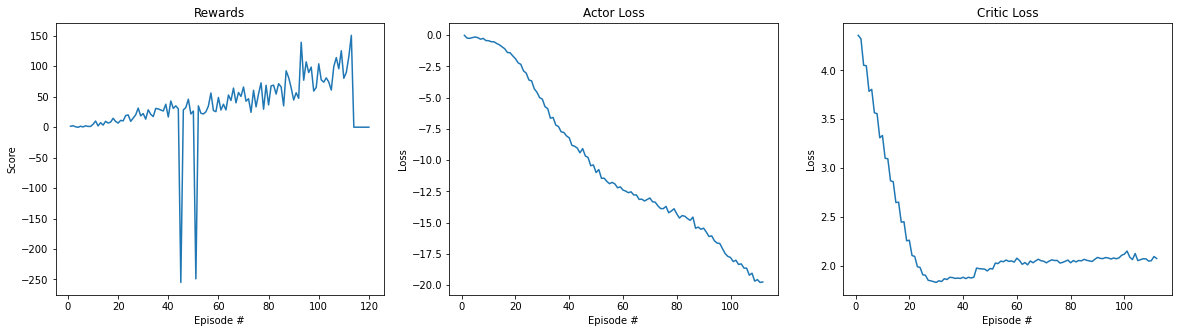

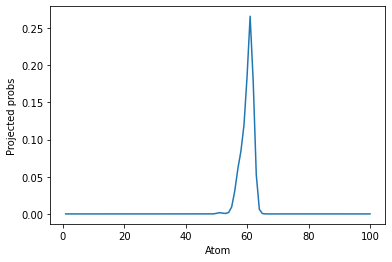

[1.5516655765823089,
 2.297329333416807,
 0.7541008097274849,
 -0.19404044495119402,
 1.5351430862695754,
 0.4630924573381587,
 2.2548394697951153,
 1.2630659128384043,
 1.2642062621501584,
 4.725444338362043,
 10.1162260894392,
 2.067826988262823,
 7.369454017685105,
 3.4057701705411696,
 9.631478032892725,
 6.8204297953828545,
 8.317036394223882,
 14.605662217286104,
 9.448793773228923,
 6.802274842940581,
 11.173455782234669,
 10.393069646088406,
 19.031598791247234,
 20.181591292552184,
 9.56631240337932,
 14.957470902629817,
 20.281020163519617,
 31.33634312140445,
 18.5345102713909,
 22.392390395437058,
 13.235087676284214,
 28.55225412264311,
 21.0982512566261,
 17.423180918907747,
 30.824135214982864,
 30.06593597951966,
 28.24534519125397,
 26.656099308592577,
 37.689163647747286,
 16.685402099431183,
 43.06019848829601,
 30.91606499440968,
 35.047973787800096,
 30.075230155916262,
 -254.98759299955177,
 28.322510415920988,
 32.361162517918274,
 45.933472257961206,
 21.7106504

In [69]:
# 3 layers network instead...
# ACHIEVED: -

##################
# Vmax = -Vmin = 75
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=150
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_75_longest'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_75_longest'
params.num_atoms = 100
params.vmin = -75
params.vmax = 75


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

In [70]:
# 3 layers network instead...
# ACHIEVED: -

##################
# Vmax = -Vmin = 100
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=150
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_100_longest'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_100_longest'
params.num_atoms = 100
params.vmin = -100
params.vmax = 100


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -100
VMAX:  100
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 4\ Score: 2.139

==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([0.9681, 0.9682, 0.9686, 0.9786, 0.9734, 0.9685, 0.9682, 0.9709, 0.9732,
        0.9715, 0.9681, 0.9766, 0.9700, 0.9693, 0.9695, 0.9686, 0.9695, 0.9681,
        0.9742, 0.9696, 0.9686, 0.9688, 0.9689, 0.9697, 0.9694, 0.9683, 0.9679,
        0.9685, 0.9687, 0.9681, 0.9695, 0.9684, 0.9703, 0.9697, 0.9695, 0.9686,
        0.9694, 0.9686, 0.9699, 0.96

Actor/bn2.weight Parameter containing:
tensor([0.9681, 0.9681, 0.9684, 0.9682, 0.9682, 0.9699, 0.9684, 0.9681, 0.9682,
        0.9681, 0.9680, 0.9681, 0.9681, 0.9681, 0.9680, 0.9684, 0.9682, 0.9681,
        0.9681, 0.9684, 0.9682, 0.9681, 0.9681, 0.9681, 0.9680, 0.9681, 0.9680,
        0.9679, 0.9679, 0.9687, 0.9683, 0.9683, 0.9681, 0.9684, 0.9680, 0.9680,
        0.9691, 0.9693, 0.9678, 0.9680, 0.9681, 0.9680, 0.9680, 0.9685, 0.9682,
        0.9681, 0.9679, 0.9683, 0.9682, 0.9684, 0.9681, 0.9682, 0.9682, 0.9681,
        0.9681, 0.9681, 0.9683, 0.9682, 0.9684, 0.9682, 0.9686, 0.9682, 0.9681,
        0.9691, 0.9681, 0.9681, 0.9686, 0.9683, 0.9687, 0.9681, 0.9683, 0.9683,
        0.9680, 0.9681, 0.9680, 0.9681, 0.9679, 0.9684, 0.9681, 0.9683, 0.9683,
        0.9680, 0.9680, 0.9681, 0.9679, 0.9680, 0.9685, 0.9679, 0.9687, 0.9683,
        0.9679, 0.9681, 0.9683, 0.9681, 0.9681, 0.9686, 0.9680, 0.9680, 0.9680,
        0.9681, 0.9682, 0.9681, 0.9694, 0.9678, 0.9684, 0.9680, 0.9678, 0.9682,
 

Critic/bn1.weight Parameter containing:
tensor([0.8340, 0.8721, 0.8809, 0.8280, 0.8175, 0.8575, 0.8482, 0.9009, 0.8402,
        0.8144, 0.8556, 0.8614, 0.8845, 0.8270, 0.8763, 0.8241, 0.8496, 0.8768,
        0.7831, 0.8483, 0.8790, 0.8255, 0.8401, 0.8691, 0.8535, 0.8882, 0.7898,
        0.8201, 0.8411, 0.9002, 0.8792, 0.8777, 0.8625, 0.8173, 0.8328, 0.8767,
        0.8500, 0.8450, 0.8471, 0.8859, 0.8735, 0.8053, 0.8632, 0.8690, 0.8746,
        0.8875, 0.8789, 0.8801, 0.8923, 0.8265, 0.8910, 0.7899, 0.8502, 0.8427,
        0.8218, 0.8369, 0.8819, 0.8638, 0.8433, 0.8258, 0.8769, 0.8338, 0.9039,
        0.8432, 0.8549, 0.8753, 0.8894, 0.8179, 0.8289, 0.8520, 0.8113, 0.8563,
        0.8169, 0.8120, 0.8402, 0.8110, 0.8514, 0.8906, 0.8588, 0.8266, 0.8642,
        0.7934, 0.8659, 0.8432, 0.8636, 0.8852, 0.8291, 0.8807, 0.8666, 0.8783,
        0.8283, 0.7874, 0.8077, 0.8376, 0.8237, 0.8727, 0.8823, 0.8579, 0.8538,
        0.8218, 0.8268, 0.8965, 0.8229, 0.7757, 0.7947, 0.8430, 0.8329, 0.8102,


KeyboardInterrupt: 

## Resuming Training to see how far it goes...


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.5
VMAX:  0.5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 100008 / 100000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 110: 	Actor Loss: -0.45 	Critic Loss: 0.86 
		Average Score: 47.62

SCORES (this eps):  [  5.90077691 140.70757813  60.89671407 161.83428994   4.56916877
   1.33504715   6.47866377 176.79238049   8.47062654  33.03638487
   4.40183288  39.03048738] 



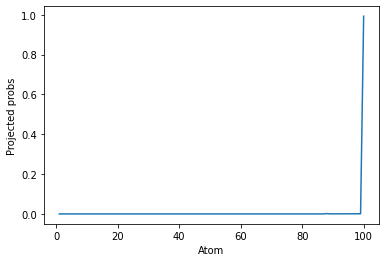

Episode 120: 	Actor Loss: -0.47 	Critic Loss: 0.46 
		Average Score: 54.07

SCORES (this eps):  [ 18.87852341  33.93129474  69.34345039  82.82878725  80.56153248
  40.27978563  38.27727152 143.22867688 126.74404898 178.98902902
 150.80882613  22.30586369] 



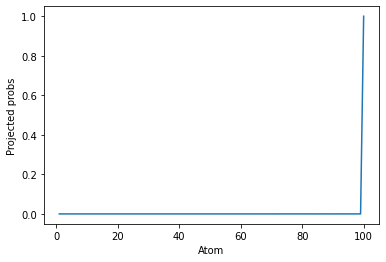

Episode 130: 	Actor Loss: -0.47 	Critic Loss: 0.36 
		Average Score: 61.27

SCORES (this eps):  [169.1167412   28.61660431  76.06040152   9.73994167 127.19028523
  48.70869418 106.54653308   5.99867525  63.10850669  12.15519351
   7.96858325   7.94443865] 



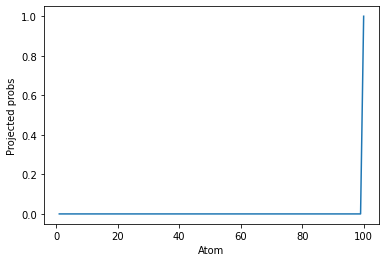

Episode 140: 	Actor Loss: -0.47 	Critic Loss: 0.31 
		Average Score: 87.89

SCORES (this eps):  [ 34.45104993 121.27610699 133.7743747   65.62670719  38.38435401
  46.67082548  41.74338133  23.74299976  89.08693045  50.18539704
 173.1081482   95.13100845] 



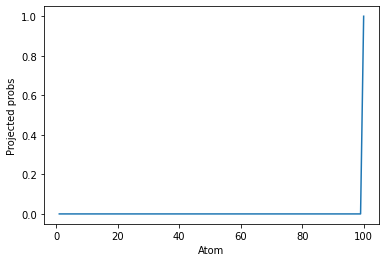

Episode 150: 	Actor Loss: -0.48 	Critic Loss: 0.31 
		Average Score: 82.68

SCORES (this eps):  [155.96517244   1.13954787   1.95932284 180.81472676 175.43829882
  11.9419018  101.60940387  61.12485385  13.39723767 180.20193094
  54.27055328 109.54807556] 



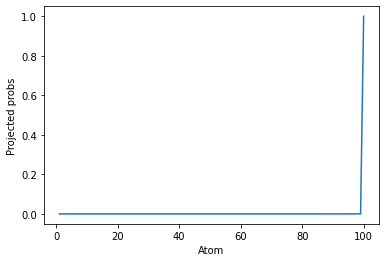

Episode 160: 	Actor Loss: -0.47 	Critic Loss: 0.30 
		Average Score: 101.86

SCORES (this eps):  [180.47916819 185.09464744  26.53858115 111.52873994 200.82051959
 168.56124625  10.54668619  60.46822336  64.42449499 114.01841091
  52.38905277 152.2190986 ] 



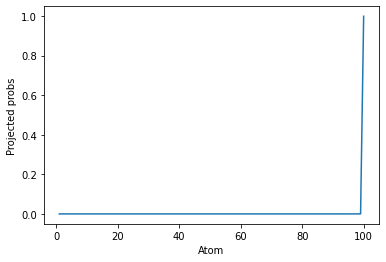

Episode 170: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 86.99

SCORES (this eps):  [ 16.78280648  99.89438636 192.59775856  98.83928826 165.12087281
 131.25696306   4.94366745  15.24601402 134.08257896  68.55631801
 134.87980373 149.09806472] 



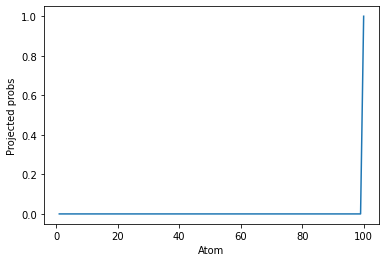

Episode 180: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 84.08

SCORES (this eps):  [139.66399244 139.6921164   61.19506234 124.03565291  21.37120456
  39.97264714 146.81479344 117.65414733  96.3635477   80.11269977
  53.51359812  34.42426608] 



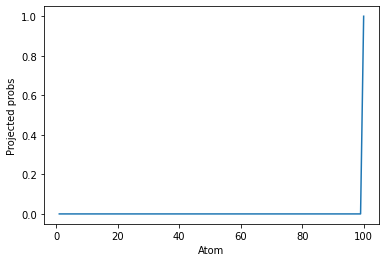

Episode 190: 	Actor Loss: -0.48 	Critic Loss: 0.27 
		Average Score: 102.93

SCORES (this eps):  [  9.83311821 178.44782184  85.59252534  66.32056066  91.35506354
 175.85608276  58.26103059  50.88509681  79.16618649  21.28551543
  55.32338544 142.19126558] 



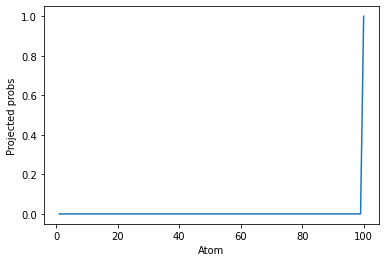

Episode 200: 	Actor Loss: -0.48 	Critic Loss: 0.24 
		Average Score: 94.52

SCORES (this eps):  [150.57441064 169.38935148  86.03974432 132.42358667 127.4823455
  29.39046853  15.59240784  57.3212465   49.3472292  153.10185847
  75.25665091 165.10875407] 



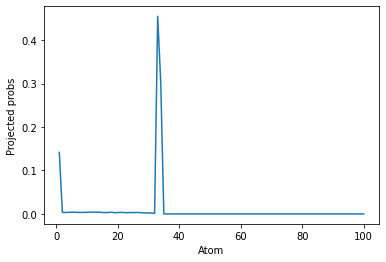

Episode 210: 	Actor Loss: -0.48 	Critic Loss: 0.25 
		Average Score: 77.16

SCORES (this eps):  [132.28322624 105.532945    33.73645934  23.08382655  95.41501233
  41.48089213  92.93533703  38.81468336 120.91548086  23.03889457
 151.88523967 154.58460029] 



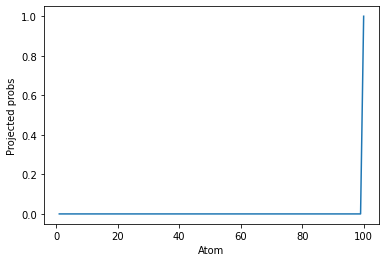

Episode 220: 	Actor Loss: -0.48 	Critic Loss: 0.20 
		Average Score: 66.17

SCORES (this eps):  [ 67.49222592  55.9166164    7.4934891   47.86408116  26.10892171
  49.73740044 141.48025686   3.24735384 143.51171924   4.84988582
 147.35286172 150.19437012] 



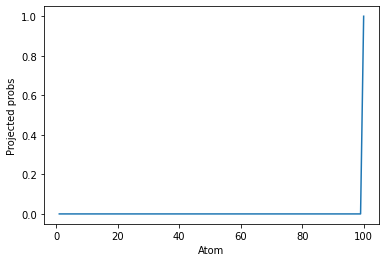

Episode 230: 	Actor Loss: -0.49 	Critic Loss: 0.21 
		Average Score: 83.09

SCORES (this eps):  [154.48964679  12.7354797  178.70388183  43.98323773  40.32708675
  26.09934856  15.89359045  61.5293451   27.25907112  53.59298564
  12.91462703 166.32292614] 



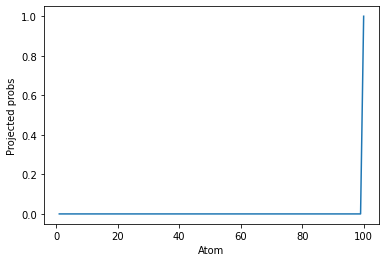

Episode 240: 	Actor Loss: -0.48 	Critic Loss: 0.24 
		Average Score: 91.31

SCORES (this eps):  [ 94.41541984  64.56360462 116.54400885 114.63362495  86.16972712
   8.3361108   59.49120622 103.5504358  150.96589406  53.41170204
  35.91897074  47.13001469] 



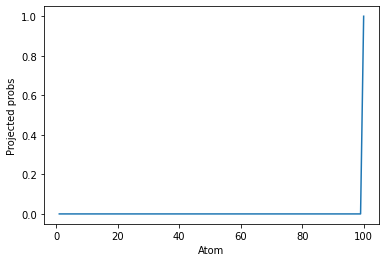

Episode 250: 	Actor Loss: -0.48 	Critic Loss: 0.23 
		Average Score: 85.65

SCORES (this eps):  [135.79723043 189.02067286  29.50328017 177.06165902  59.10052259
 135.33933568   9.40000371  40.93874141 126.35106882  13.90660259
  35.69666455  32.10071167] 



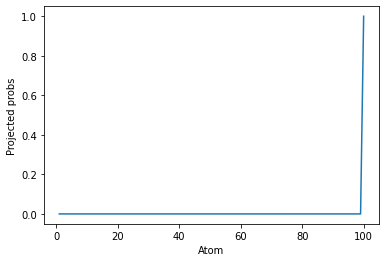

Episode 260: 	Actor Loss: -0.48 	Critic Loss: 0.24 
		Average Score: 75.42

SCORES (this eps):  [ 27.9149785  115.40445854 150.8803315   33.09779383  45.57835836
  16.48065105  65.07822692  44.88144123   3.75207977   4.32168353
 152.70721184  95.65665701] 



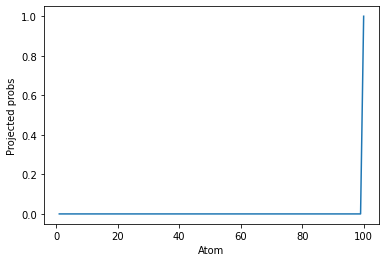

Episode 270: 	Actor Loss: -0.48 	Critic Loss: 0.28 
		Average Score: 69.00

SCORES (this eps):  [4.92761035e+01 1.51447903e+02 1.70232497e+01 1.78696282e+00
 1.50883576e+02 6.87229335e-02 7.91356716e+01 1.37184159e+01
 6.91238909e+01 3.13664215e+01 5.74451298e+01 9.50124270e+01] 



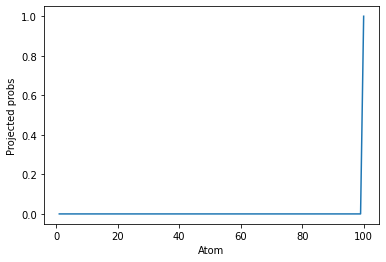

Episode 280: 	Actor Loss: -0.48 	Critic Loss: 0.26 
		Average Score: 66.18

SCORES (this eps):  [137.46468067  28.25969966  38.70649098 179.06207269  12.92466863
 158.19368331  19.38262167  35.62429395   0.82667177 186.17465831
  32.20950072  20.92116426] 



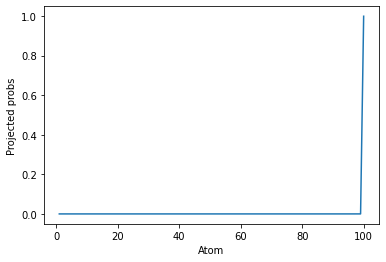

Episode 290: 	Actor Loss: -0.48 	Critic Loss: 0.26 
		Average Score: 73.52

SCORES (this eps):  [115.01296714  28.05317721  30.5236087    3.29843153  28.73971429
  78.64889901 170.9872513  177.05832563  26.78425711 178.2077001
 154.43518738 150.17453331] 



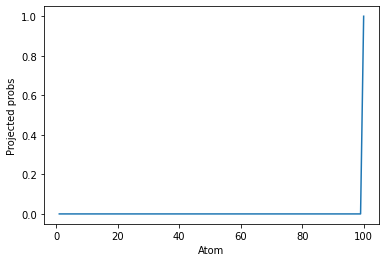

Episode 300: 	Actor Loss: -0.47 	Critic Loss: 0.28 
		Average Score: 71.34

SCORES (this eps):  [ 75.92240547   9.02036673   2.33759372 181.82498771 114.52297644
 137.13996513   9.72129775  50.75270359 176.74913745   3.54658129
 151.60004335  20.82709361] 



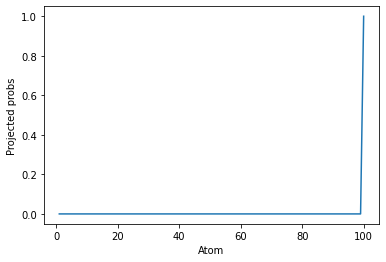

Episode 310: 	Actor Loss: -0.47 	Critic Loss: 0.31 
		Average Score: 53.03

SCORES (this eps):  [131.14625598  13.16595122  16.84698103  46.05535094  31.89693719
 108.04721246  52.95215517  83.37678084  22.14915978 116.52930226
  42.61219196 175.85071858] 



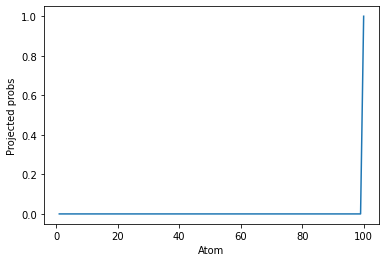

Episode 320: 	Actor Loss: -0.47 	Critic Loss: 0.33 
		Average Score: 73.62

SCORES (this eps):  [104.7771763    9.98973919  61.48526859  87.84905505  97.59051324
 213.4416486  169.11589175 102.22169096 146.07488769 176.11936778
 211.86467134  18.94770915] 



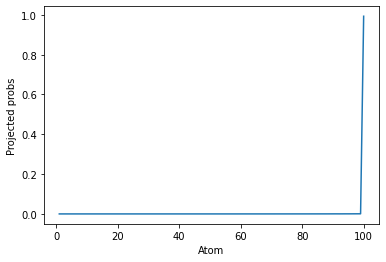

Episode 330: 	Actor Loss: -0.47 	Critic Loss: 0.33 
		Average Score: 59.79

SCORES (this eps):  [104.84541095  79.33536889 123.08944511  21.9191628    3.16441517
  39.55214713   5.75073921  69.80984309  10.37069903  63.23081004
  68.52483145  17.93369663] 



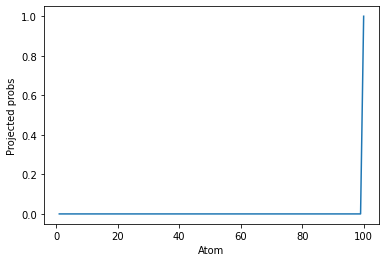

Episode 340: 	Actor Loss: -0.47 	Critic Loss: 0.35 
		Average Score: 62.16

SCORES (this eps):  [ 16.01994568  40.62914308  37.06018426 135.31781147 128.60031373
  82.58096778  27.99571585  67.09224918  26.75261357  30.472013
  77.44895322  42.30947655] 



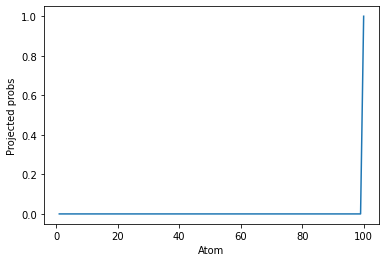

Episode 343\ Score: 79.17NaN Reward Found! Setting to -5.0...

NaN found in states. Skipping this episode.
Episode 348\ Score: 108.25

scripts\d4pg_agent.py:187: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), self.params.gradient_clip)    # ADDED: Gradient Clipping to prevent exploding grad issue
scripts\d4pg_agent.py:180: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), self.params.gradient_clip)    # ADDED: Gradient Clipping to prevent exploding grad issue



NaN found in actions. Skipping this episode.
Episode 349\ Score: 58.21
NaN found in states. Skipping this episode.
Episode 350: 	Actor Loss: nan 	Critic Loss: nan 
		Average Score: 65.50

SCORES (this eps):  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 



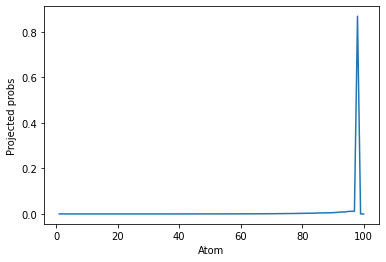


NaN found in actions. Skipping this episode.
Episode 351\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 352\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 353\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 354\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 355\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 356\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 357\ Score: 0.00
NaN found in states. Skipping this episode.


==== An exception occurred: The histogram is empty, please file a bug report.

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

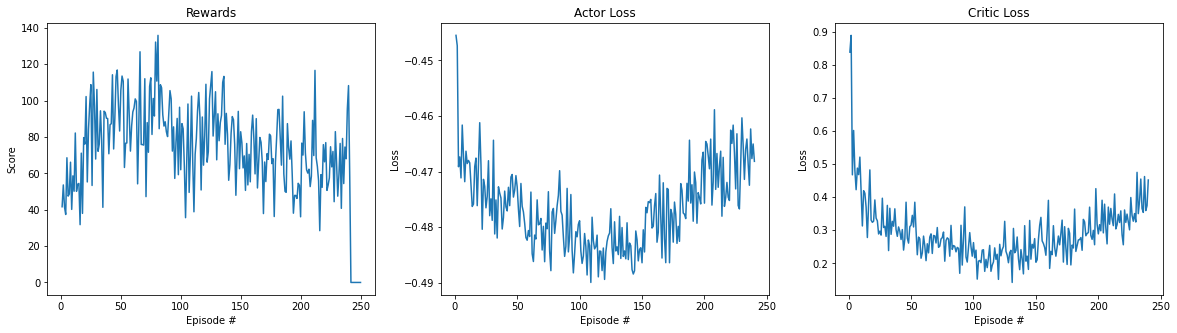

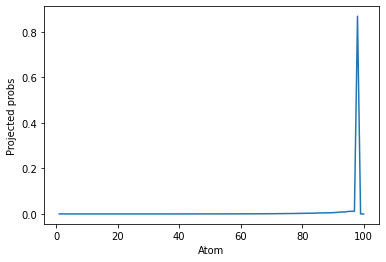

[41.627698211581446,
 53.62116257452484,
 41.430190108076204,
 37.37529083574191,
 68.56759456399595,
 47.47117829254906,
 48.633387713867705,
 66.12177085573785,
 40.16328472077536,
 58.616948367174096,
 50.15206670536039,
 82.18142417583537,
 50.09020728319107,
 54.0167691304329,
 54.46105587334993,
 31.769725351710804,
 71.09874848291899,
 37.98156850389205,
 79.66187109608047,
 76.08139664877672,
 102.22914924713162,
 55.26288321338749,
 84.08501723244262,
 97.6042485795333,
 108.76235551227971,
 53.33366903274631,
 115.67381598784898,
 97.26300429777864,
 67.87171628978103,
 106.1240509555937,
 72.11927513303817,
 76.09844029493009,
 94.38693986216094,
 78.20462109226112,
 41.30762680041759,
 94.1840672174197,
 93.45008823395862,
 90.31032623672702,
 90.14382041924789,
 70.7587057100997,
 86.74237176709964,
 87.28425214148592,
 114.20315428842635,
 73.40699788054917,
 90.3237667476448,
 113.22649310721317,
 116.83889928269006,
 97.57783896850499,
 83.2791387201675,
 105.6564749633

In [39]:
# NOTE: Can try to apply gradual decay after this...

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=1000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=100000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.5'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.5'
params.num_atoms = 100
params.vmin = -0.5
params.vmax = 0.5

params.restart_training = False
params.eps_to_resume_from = 101
params.actor_weights_filename_to_resume = 'checkpoint_actor_ep100.pth'
params.critic_weights_filename_to_resume = 'checkpoint_critic_ep100.pth'

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -0.5
VMAX:  0.5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 100008 / 100000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 190: 	Actor Loss: -0.49 	Critic Loss: 0.10 
		Average Score: 35.50

SCORES (this eps):  [ 11.82836784  19.46165899  67.16538357   3.97810496 111.63337406
   1.5440591   15.78798954 185.11961957   8.22688929  90.64363476
  50.17413858   5.61336711] 



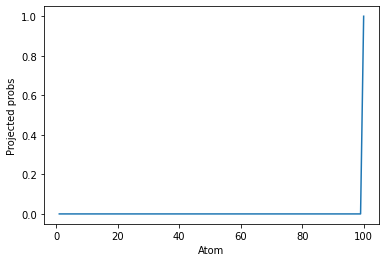

Episode 200: 	Actor Loss: -0.49 	Critic Loss: 0.11 
		Average Score: 67.43

SCORES (this eps):  [ 26.39244662  21.02323865 103.91716517 127.71069172  78.69250985
  45.3522153  115.34911971  20.97775023 111.69678276  15.63124856
  93.11186614 116.67775373] 



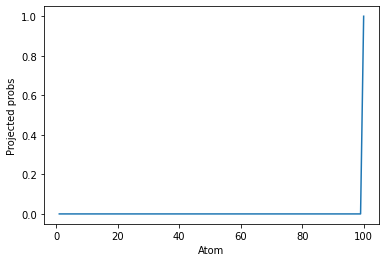

Episode 210: 	Actor Loss: -0.48 	Critic Loss: 0.25 
		Average Score: 36.58

SCORES (this eps):  [12.54103765  3.65511068  5.88712378  5.37260985 19.87742734  1.98402725
  5.15314113 18.03019536  3.01564004  8.1490626  23.45681134  5.12510192] 



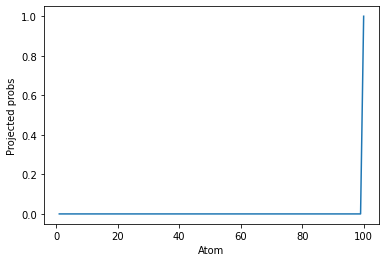

Episode 211\ Score: 3.47

In [ ]:
# NOTE: Tried to reduce OU-Noise to action space by half to reduce randomness (i.e. reduce exploration, exploit more)

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=1000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=100000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512
params.gradient_clip = 0.25        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_0.5'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_0.5'
params.num_atoms = 100
params.vmin = -0.5
params.vmax = 0.5

# REDUCE NOISE NOW
params.action_noise_theta = 0.075
params.action_noise_sigma = 0.1

params.restart_training = False
params.eps_to_resume_from = 181
params.actor_weights_filename_to_resume = 'checkpoint_actor_ep180.pth'
params.critic_weights_filename_to_resume = 'checkpoint_critic_ep180.pth'

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

# Other experimentations


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  400
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -16.26 	Critic Loss: 1.55 
		Average Score: 20.83

Episode 200: 	Actor Loss: -10.93 	Critic Loss: 1.24 
		Average Score: 81.62

Episode 300: 	Actor Loss: -16.14 	Critic Loss: 1.34 
		Average Score: 200.95



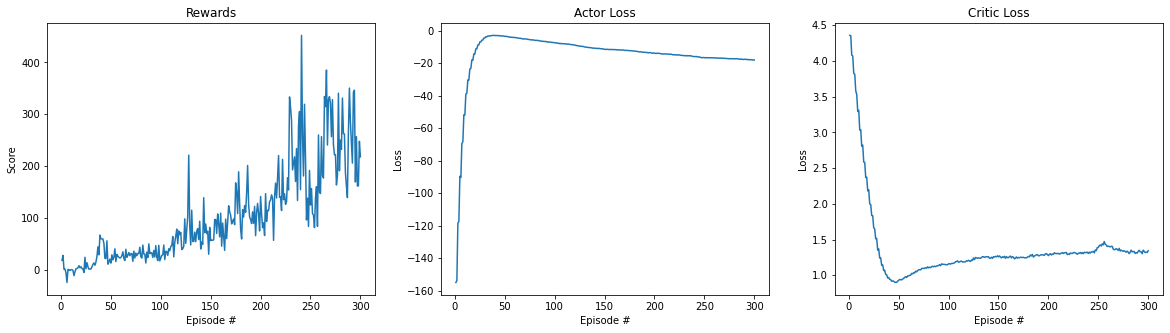


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  100
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -7.40 	Critic Loss: 2.30 
		Average Score: 9.43

Episode 174\ Score: 33.43.67NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Rewar

ValueError: The histogram is empty, please file a bug report.

In [16]:
##################
# Achieved rewards @ eps~=400 in 300 episodes
##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=300
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 400
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


##################
# NaN rewards @ eps~=100
##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=300
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 100
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -5
VMAX:  5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.40 	Critic Loss: 3.84 
		Average Score: 6.63

SCORES (this eps):  [8.57846933e+00 2.68987336e+01 9.71892691e+00 5.01927264e+00
 8.53934322e+00 1.03622665e+00 6.34744889e+01 1.17328656e+01
 1.85618415e+01 1.37661428e+01 4.08987887e-02 3.41279637e+00] 



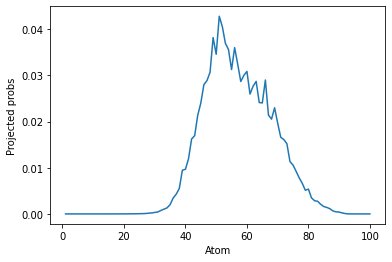

Episode 20: 	Actor Loss: -1.92 	Critic Loss: 2.97 
		Average Score: 27.46

SCORES (this eps):  [23.11023523 74.85645036  1.35724586 16.92381749 10.63971343 66.03640261
 99.58923994 10.94226572 25.99474016 21.7465548  68.58884381 43.52941191] 



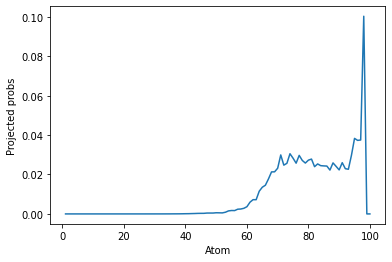

Episode 30: 	Actor Loss: -2.60 	Critic Loss: 2.65 
		Average Score: 54.30

SCORES (this eps):  [150.91668792  34.98054218  58.4395268  180.21751636  76.89925287
 103.36234675  21.37574745   3.56557483  74.7009447  175.64219328
 162.54132013 100.24045126] 



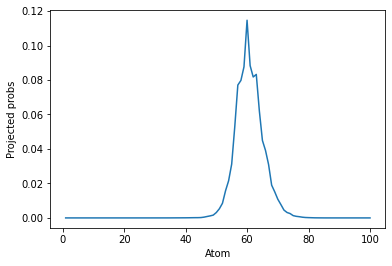

Episode 40: 	Actor Loss: -2.76 	Critic Loss: 2.65 
		Average Score: 68.85

SCORES (this eps):  [ 73.83933355  11.25310125  58.97045533  57.01178284  25.69187298
  73.19926398  58.3969362   26.21540459 105.15657802   3.5032348
  58.33294289  16.77306122] 



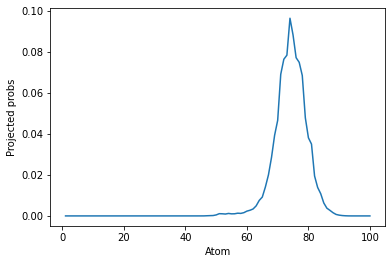

NaN Reward Found! Skipping this episode.
Episode 50: 	Actor Loss: -3.12 	Critic Loss: 2.65 
		Average Score: 80.74

SCORES (this eps):  [124.78754734  47.7589402  171.77335649   2.62544262  70.74877361
 116.09598112  50.51117379  72.44427667  85.3113616   20.56207848
 240.15215156  92.20948737] 



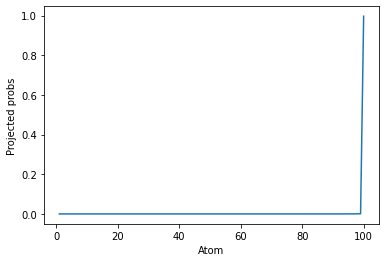

Episode 60: 	Actor Loss: -3.46 	Critic Loss: 2.58 
		Average Score: 103.24

SCORES (this eps):  [ 57.34096104 245.66787027 258.21296363  44.54353142   9.29132588
 166.2120372   65.38201853 166.24149261  49.7415623   49.16394812
 273.01105227   9.68382042] 



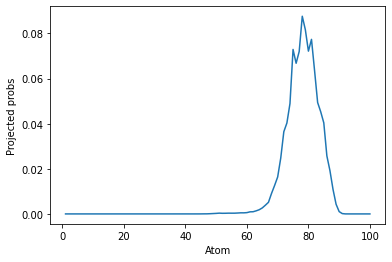

NaN Reward Found! Skipping this episode.
Episode 70: 	Actor Loss: -3.75 	Critic Loss: 2.33 
		Average Score: 188.11

SCORES (this eps):  [199.35318766 366.56337513 301.54358641 338.94111174 370.06902115
 311.71926522 303.03817387 381.57258644 310.06708113 170.68868189
 311.32602777  36.9074204 ] 



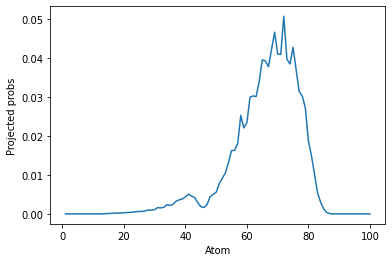

Episode 80: 	Actor Loss: -3.97 	Critic Loss: 2.08 
		Average Score: 249.00

SCORES (this eps):  [317.20222127 397.33529728 214.3886218  403.71848234 392.36870113
 384.7117329  230.36766527 337.97309875 332.90864449  13.71547561
 183.6332088  230.44841479] 



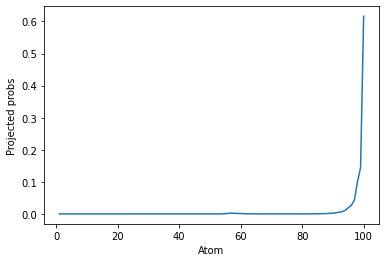

Episode 90: 	Actor Loss: -4.15 	Critic Loss: 1.83 
		Average Score: 307.48

SCORES (this eps):  [ 87.99302189 423.35896415 349.28511368 363.51425092 410.86562651
 154.74704507 387.98274098 379.69478682 388.25358717 295.95695992
 331.75162326 368.91612373] 



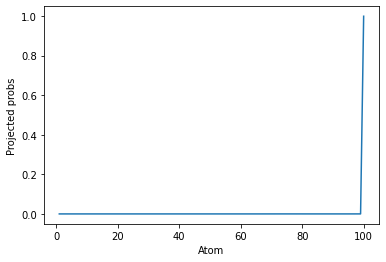

Episode 94\ Score: 309.17NaN Reward Found! Skipping this episode.
Episode 100: 	Actor Loss: -4.36 	Critic Loss: 1.55 
		Average Score: 317.56

SCORES (this eps):  [375.83813552 395.37400556 232.05287104 382.03032788 400.45019723
 403.62696532 376.57472605 374.87842359 236.79823699 369.95818135
 352.44846237 356.08071086] 



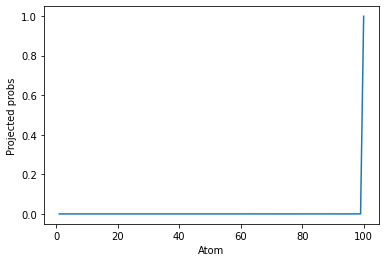

Episode 110: 	Actor Loss: -4.53 	Critic Loss: 1.29 
		Average Score: 332.71

SCORES (this eps):  [259.20870572 368.85487757 137.1660653  275.8440816  398.14436949
 381.68353472 379.55576576 367.66140638 352.58610619 390.45099157
 385.00848303 398.96028173] 



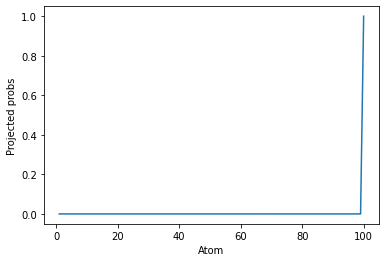

Episode 120: 	Actor Loss: -4.65 	Critic Loss: 1.01 
		Average Score: 362.32

SCORES (this eps):  [368.91618123 416.15978502 435.95490528 415.19666882 382.30263062
 370.50463075 258.14662045 106.02446611 395.72918557 380.88719293
 397.25631028 405.30811372] 



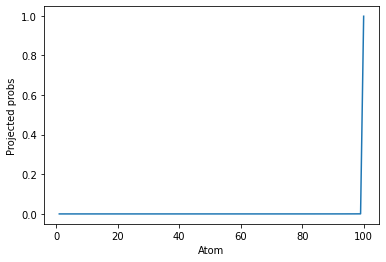

Episode 130: 	Actor Loss: -4.78 	Critic Loss: 0.71 
		Average Score: 334.91

SCORES (this eps):  [368.52226649 370.0831038  349.25613156 395.13678244 386.16409436
 389.63427067 374.03265975 415.79994908 388.44875721 341.49151812
 366.2681451  351.73434076] 



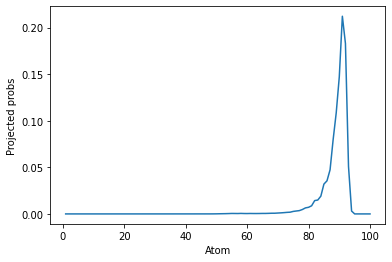

Episode 140: 	Actor Loss: -4.86 	Critic Loss: 0.50 
		Average Score: 337.44

SCORES (this eps):  [382.73749375 393.82874781 325.02215754 353.66768217 378.99032887
 249.34201452 392.53084081 394.58630562 365.13639876 338.43802395
 388.20226683 387.87183212] 



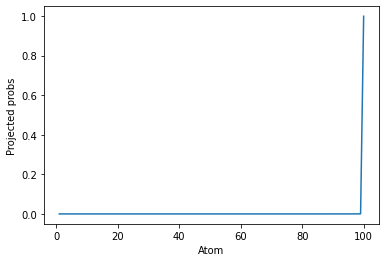

Episode 143\ Score: 279.55NaN Reward Found! Skipping this episode.
Episode 146\ Score: 351.18

==== An exception occurred: 


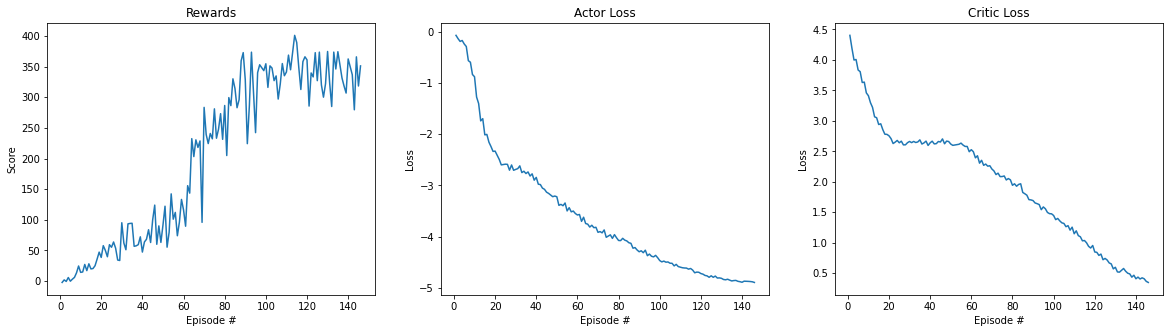

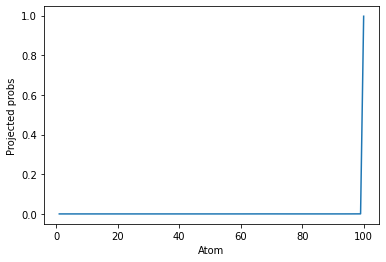

[-2.215621034100574,
 1.9407152093869324,
 -0.5691613245241266,
 5.832029695234572,
 -0.17459535656962544,
 3.1417680350132287,
 6.030559794070238,
 13.519319494225783,
 24.61230617576075,
 14.231667195640815,
 14.884948091853099,
 27.161177933235496,
 17.089859499770682,
 28.218496810324723,
 19.86923373898996,
 20.496732499819093,
 25.10953337327616,
 35.87547937269361,
 47.286669229642335,
 38.60957677631328,
 57.81064424075157,
 50.14975656101402,
 39.73347335644454,
 59.40899885150187,
 55.1888623181876,
 63.8039041023009,
 53.66123228619108,
 34.39026372492905,
 33.61868190117335,
 95.24017537782493,
 62.09862948757169,
 51.16117297836657,
 93.4458778808621,
 94.08206383301876,
 94.35266958493351,
 56.75654180637988,
 57.566670612276845,
 59.45903673151042,
 72.24053115824547,
 47.361997302990254,
 63.869107973626036,
 68.32325755040317,
 83.7813307538745,
 62.99509012211153,
 99.90017493697815,
 124.00186312609003,
 60.05191927789807,
 90.07621204419411,
 63.14505731356621,
 91.

In [28]:
# 3 layers network instead...
# ACHIEVED: Max +300 score

##################
# Vmax = -Vmin = 5
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_5_longest_refactor'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_5_longest_refactor'
params.num_atoms = 100
params.vmin = -5
params.vmax = 5


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -50
VMAX:  50
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.66 	Critic Loss: 3.54 
		Average Score: 4.35

SCORES (this eps):  [ 4.30807307 23.1710887  10.86706937  0.13312462  5.60528818  3.39735931
  1.71765802  7.70061239  0.48225511  6.55547967  2.23774724  2.91580904] 



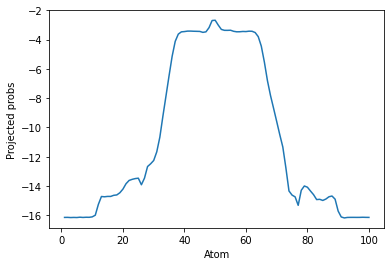

Episode 20: 	Actor Loss: -2.99 	Critic Loss: 2.36 
		Average Score: 27.19

SCORES (this eps):  [ 15.09735966   5.67725174 131.75663083  54.02851167 115.33043569
  18.94315184  26.20857689  36.5538465   35.94087489  28.53864994
   5.06182468  28.89898241] 



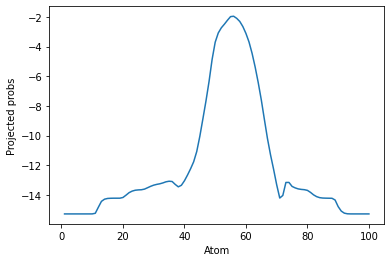

Episode 30: 	Actor Loss: -4.85 	Critic Loss: 1.99 
		Average Score: 40.24

SCORES (this eps):  [ 42.14014086  30.364785    23.47637935  19.77485546 117.12597082
   9.29592125 101.59161819  50.15679159   5.64113043  21.71765448
  20.60023     94.82466677] 



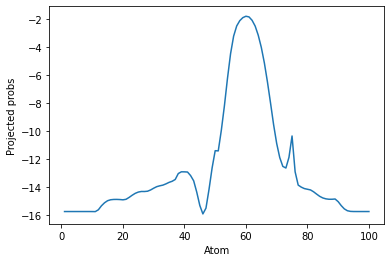

Episode 40: 	Actor Loss: -5.87 	Critic Loss: 1.93 
		Average Score: 102.48

SCORES (this eps):  [ 69.9430301  193.84042546 156.48309386 196.33252793  93.25351832
  26.50453977 172.74689478 196.76622521 199.59955676 160.85393783
  75.73661103 154.46927691] 



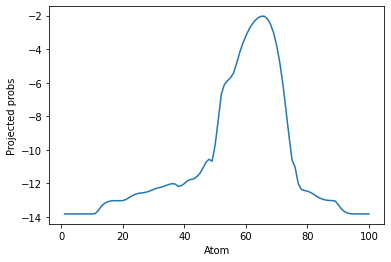

NaN Reward Found! Skipping this episode.
Episode 50: 	Actor Loss: -6.28 	Critic Loss: 1.90 
		Average Score: 122.40

SCORES (this eps):  [102.0216912  287.5570903  100.18194075  78.28368697  78.24734379
 109.04175284  50.47043427  33.4927622  287.53501774  67.7157111
  93.70856782  97.17194622] 



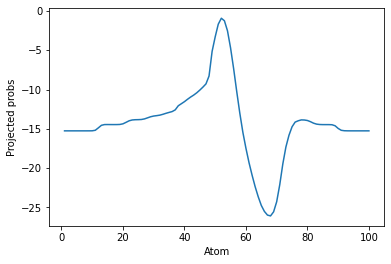

Episode 60: 	Actor Loss: -6.59 	Critic Loss: 1.89 
		Average Score: 132.83

SCORES (this eps):  [ 10.77368388 351.41877481 202.28470332  72.32772049  88.20676439
  78.91077754 216.47254208  43.33967753 166.05529409  20.81111469
 311.70889609  74.3221804 ] 



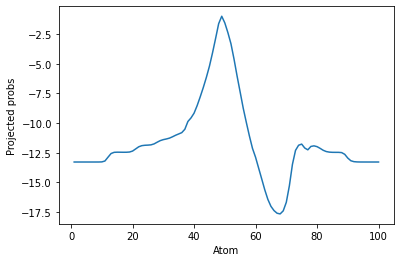

Episode 68\ Score: 145.25NaN Reward Found! Skipping this episode.
Episode 70: 	Actor Loss: -7.03 	Critic Loss: 1.88 
		Average Score: 148.34

SCORES (this eps):  [ 77.85061342 240.14502327 337.49091806 283.38843508 112.19706684
 149.49123179  23.88064635 355.8053853  322.53767285  67.35102967
 156.25306912 168.35974574] 



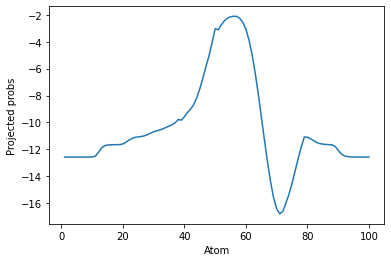

Episode 80: 	Actor Loss: -7.48 	Critic Loss: 1.89 
		Average Score: 175.95

SCORES (this eps):  [ 62.92538068 138.54325585 207.0405134  263.97679802 460.79518344
 106.52055387 209.93163842   2.36728604 305.46181857  19.19384495
 221.82429336 331.63437512] 



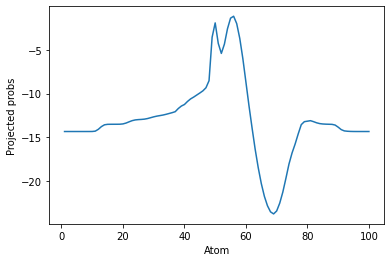

Episode 87\ Score: 155.17NaN Reward Found! Skipping this episode.
Episode 90: 	Actor Loss: -7.86 	Critic Loss: 1.92 
		Average Score: 204.92

SCORES (this eps):  [209.13573187  93.59849806   0.51771961  91.59455447 159.08114045
 163.37627741  86.75243895  36.55723526 448.10578992 455.19706204
  66.50595947 112.31405747] 



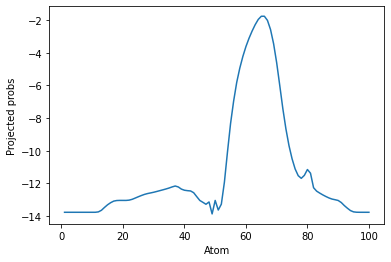

Episode 100: 	Actor Loss: -8.43 	Critic Loss: 1.90 
		Average Score: 232.83

SCORES (this eps):  [464.4652063  424.35163777  30.94301503 235.88754002  45.1887075
  22.9622866   31.23655732 179.08337379 499.63856852 241.2452476
 139.88943435  51.98601507] 



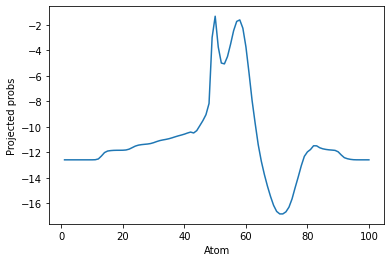

Episode 102\ Score: 299.88Errorneously low Reward = -30.06 Found! Doing nothing...
[0.15103380382061005, -30.055376052856445, 0.682612955570221, -0.866203248500824, 0.27902165055274963, 1.1643377542495728, 0.01270360965281725, 1.0181081295013428, 1.2958853244781494, -0.011971557512879372, 0.2586629092693329, 0.3601086437702179]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.17 Found! Doing nothing...
[0.21027494966983795, -30.171539306640625, 0.922203540802002, 0.045910321176052094, 0.16228421032428741, 0.8330753445625305, 0.07331357151269913, 1.170593023300171, 0.9559525847434998, 0.13050983846187592, 0.3103935122489929, 0.7559321522712708]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.34 Found! Doing nothing...
[0.24106591939926147, -30.340116500854492, 0.536938488483429, 0.04635671153664589, -0.829759955406189, 0.6583777070045471, 0.4047729969024658, 1.3190513849258423, 1.1521573066711426, 0.14046278595924377, 0.3480663597583771, 0.88326013088226

Errorneously low Reward = -33.75 Found! Doing nothing...
[0.1326117068529129, -33.752723693847656, 0.41541457176208496, 1.217068076133728, 1.0230250358581543, 1.2175012826919556, 1.2247419357299805, 0.6556940674781799, 0.9414443373680115, 0.8760550618171692, 0.03356674686074257, 0.402269572019577]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.84 Found! Doing nothing...
[-0.05898234620690346, -33.8385009765625, 0.15999683737754822, 1.135975956916809, 1.0546680688858032, 1.0902559757232666, 1.1192651987075806, 0.7665250301361084, 1.1017769575119019, 0.9527638554573059, 0.27348223328590393, 0.49864062666893005]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.95 Found! Doing nothing...
[0.12649202346801758, -33.949317932128906, 0.1959037184715271, 0.9199526309967041, 0.8617889285087585, 0.3703632950782776, 1.129818320274353, 0.6094924211502075, 1.4164575338363647, 1.02666437625885, 0.22525018453598022, 0.30837833881378174]
SKIPPING TRAINING OF THIS TIMES

Errorneously low Reward = -37.28 Found! Doing nothing...
[1.4802300930023193, -37.28047180175781, 0.32016995549201965, -0.2667487561702728, 0.22346684336662292, 0.535151481628418, 1.140146255493164, 0.0572081096470356, 0.16463392972946167, 0.2570840120315552, 1.1087247133255005, 0.26197493076324463]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -37.40 Found! Doing nothing...
[1.3010860681533813, -37.403778076171875, -0.48989593982696533, -0.30288881063461304, 0.38866621255874634, 0.8893343806266785, 1.1124032735824585, 0.045556217432022095, 0.3299889862537384, 0.2101110816001892, 1.385689616203308, 0.20467889308929443]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -37.52 Found! Doing nothing...
[1.2278540134429932, -37.51973342895508, 0.07336431741714478, -0.2700444161891937, 0.35350632667541504, 0.7575573325157166, 1.2858682870864868, 0.17725078761577606, 0.3637543022632599, 0.2315731793642044, 1.389095664024353, 0.3811284005641937]
SKIPPING TRAINING OF T

Errorneously low Reward = -40.63 Found! Doing nothing...
[0.15792018175125122, -40.62717056274414, 0.8678585290908813, 0.0392073392868042, 0.40546801686286926, 0.4146176278591156, 0.19306518137454987, 0.41340115666389465, 0.9907068014144897, 0.07258100062608719, 1.0928515195846558, 1.3676875829696655]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -40.74 Found! Doing nothing...
[0.36548668146133423, -40.73854446411133, 0.6780170798301697, 0.1977088302373886, 0.42629218101501465, 0.36911311745643616, 0.23657304048538208, -0.4823981821537018, 1.0605316162109375, 0.08835571259260178, 1.1906076669692993, 1.1316752433776855]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -40.88 Found! Doing nothing...
[0.38996466994285583, -40.878719329833984, 0.6113386154174805, 0.2450416535139084, 0.4104304015636444, 0.44873079657554626, 0.21072892844676971, 0.13801385462284088, 1.3698828220367432, 0.22479502856731415, 1.1868879795074463, 1.3483049869537354]
SKIPPING TRAINING O

Errorneously low Reward = -43.87 Found! Doing nothing...
[0.5801231861114502, -43.87132263183594, 1.2672430276870728, -1.0, 0.5783871412277222, 1.1696035861968994, 1.4106178283691406, 1.3623522520065308, 0.7796653509140015, 0.9866423010826111, -0.8071311116218567, 1.146803855895996]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -44.03 Found! Doing nothing...
[0.4611271917819977, -44.03070068359375, 1.3484021425247192, 0.005921371281147003, 0.46670112013816833, 0.8232664465904236, 0.9527339339256287, 1.3379640579223633, 0.5958049893379211, 1.0496082305908203, 0.006338649429380894, 1.3692532777786255]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -44.12 Found! Doing nothing...
[0.17368990182876587, -44.12328338623047, 1.0370306968688965, 0.013604307547211647, 0.5060867667198181, 1.0067875385284424, 0.9453710317611694, 1.3576945066452026, 0.566028892993927, 1.1128449440002441, 0.07575679570436478, 1.2973170280456543]
SKIPPING TRAINING OF THIS TIMESTEP
Errorne

Errorneously low Reward = -46.97 Found! Doing nothing...
[-0.00896949227899313, -46.97062683105469, 0.12675461173057556, 1.087874174118042, 1.0770739316940308, 1.0246386528015137, 0.9348316192626953, 1.1255203485488892, 0.5477325320243835, 1.5066345930099487, 1.2235069274902344, 0.8246786594390869]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -47.03 Found! Doing nothing...
[0.024164194241166115, -47.025325775146484, 0.15629173815250397, 1.2350620031356812, 1.0114036798477173, 1.3317127227783203, 1.0276799201965332, 0.9576912522315979, 0.5928279161453247, 1.5206282138824463, 1.035735011100769, 0.8078182935714722]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -47.11 Found! Doing nothing...
[0.03917643055319786, -47.11381530761719, -0.07030379772186279, 1.141157627105713, 1.009714961051941, 1.2704010009765625, 0.9983316659927368, 1.0715693235397339, 0.76686030626297, 1.7073159217834473, 1.072272539138794, 0.8813719153404236]
SKIPPING TRAINING OF THIS TIMESTE

Errorneously low Reward = -49.89 Found! Doing nothing...
[0.6710701584815979, -49.88811492919922, 0.30817896127700806, 0.3920699954032898, 1.5414930582046509, -0.7887697815895081, 0.9277323484420776, 0.7314688563346863, 0.38020768761634827, 1.2241486310958862, 1.073683738708496, 0.43044793605804443]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -49.97 Found! Doing nothing...
[0.45671042799949646, -49.97334289550781, 0.3881804943084717, 0.4322947561740875, 1.5995893478393555, 0.13726922869682312, 1.1113224029541016, 0.8623619675636292, 0.37788885831832886, 1.1406766176223755, 1.21079683303833, 0.2962791621685028]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -50.07 Found! Doing nothing...
[0.5543796420097351, -50.06509017944336, 0.25514018535614014, 0.6608278751373291, 1.70888352394104, 0.05785609036684036, 1.0220341682434082, 0.8590531349182129, 0.47980210185050964, 1.0015407800674438, 1.0753687620162964, 0.3239140808582306]
SKIPPING TRAINING OF THIS TIMES

Errorneously low Reward = -52.98 Found! Doing nothing...
[0.7557477355003357, -52.979278564453125, 0.1313895583152771, 0.2366756945848465, 1.3987884521484375, 0.7858936786651611, 1.2354801893234253, 0.5367390513420105, 0.21703088283538818, 0.06728522479534149, 0.5733826160430908, 0.898508608341217]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -53.16 Found! Doing nothing...
[0.6617339849472046, -53.161598205566406, 0.15826933085918427, 0.28564104437828064, 1.3438206911087036, 0.7910545468330383, 1.294137716293335, 0.3195401132106781, 0.32413578033447266, 0.2341150939464569, 0.6259679198265076, -0.8196780681610107]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -53.23 Found! Doing nothing...
[0.7549524307250977, -53.23072814941406, 0.22095295786857605, 0.19260524213314056, 1.4241477251052856, 0.9005518555641174, 1.5770448446273804, 0.35281607508659363, 0.3019046187400818, 0.07151374965906143, 0.5650501251220703, 0.0563168004155159]
SKIPPING TRAINING OF THIS 

Errorneously low Reward = -56.13 Found! Doing nothing...
[0.409294992685318, -56.12766647338867, 1.2926753759384155, 1.1851688623428345, 0.12351009994745255, 0.3405560851097107, 1.1626253128051758, 0.013733292929828167, -0.20867033302783966, 0.9550203680992126, 1.2882980108261108, 0.8952906727790833]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -56.25 Found! Doing nothing...
[0.38865968585014343, -56.253204345703125, 1.2858989238739014, 0.9331170916557312, 0.24453014135360718, 0.23426930606365204, 1.2083044052124023, 0.16913579404354095, -0.04901349917054176, 1.4889411926269531, 1.3196418285369873, 0.8410671949386597]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -56.37 Found! Doing nothing...
[0.3212663233280182, -56.365482330322266, 1.2980372905731201, 1.072355031967163, 0.4213305115699768, 0.3436180651187897, 1.2293795347213745, 0.12529723346233368, -0.14879846572875977, 1.4319199323654175, 1.272382140159607, 0.7911438345909119]
SKIPPING TRAINING OF TH

Errorneously low Reward = -59.17 Found! Doing nothing...
[0.15134477615356445, -59.171669006347656, 0.8523378372192383, 1.0200963020324707, 1.122867226600647, 1.0259361267089844, 0.32858121395111084, 0.798622727394104, 0.20041154325008392, 0.12762536108493805, 0.8309476375579834, 0.5678220391273499]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -59.27 Found! Doing nothing...
[-0.05120764672756195, -59.27382278442383, 0.9514317512512207, 1.0044419765472412, 1.0776329040527344, 0.7916469573974609, 0.3243563771247864, 0.99360191822052, 0.13663071393966675, 0.1727159172296524, 0.6377590298652649, 0.5679911375045776]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -59.37 Found! Doing nothing...
[0.02487761527299881, -59.366783142089844, 0.7470573782920837, 0.9574639797210693, 1.1972639560699463, 0.7347774505615234, 0.29511988162994385, 1.107724666595459, 0.20555740594863892, 0.17085403203964233, 0.7369333505630493, 0.287181556224823]
SKIPPING TRAINING OF THIS TIM

Errorneously low Reward = -62.39 Found! Doing nothing...
[1.1674883365631104, -62.391502380371094, 0.3015246093273163, 0.023509858176112175, 0.037325918674468994, 1.1289803981781006, 0.3494671881198883, 1.4163697957992554, -0.9852280616760254, 1.2138837575912476, 0.8074660301208496, 1.3769229650497437]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -62.50 Found! Doing nothing...
[1.1718076467514038, -62.49801254272461, 0.2458130419254303, 0.034705761820077896, 0.007126161828637123, 0.9855039715766907, 0.21415464580059052, 1.5432435274124146, 0.020806770771741867, 1.456578016281128, 0.17292165756225586, 1.3711475133895874]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -62.64 Found! Doing nothing...
[1.244585394859314, -62.64458084106445, 0.3795362412929535, 0.16464076936244965, 0.31613385677337646, 1.1266969442367554, 0.22438211739063263, 1.54581880569458, 0.06255625188350677, 1.2777084112167358, -1.0, 1.4443700313568115]
SKIPPING TRAINING OF THIS TIMESTEP
E

Errorneously low Reward = -65.38 Found! Doing nothing...
[1.8092161417007446, -65.38162231445312, 1.1554052829742432, 0.29239583015441895, 1.0485628843307495, 0.9415105581283569, 0.04400762543082237, 1.2242448329925537, 1.142968773841858, 0.07758748531341553, 1.26995849609375, 0.6715113520622253]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -65.51 Found! Doing nothing...
[1.094386100769043, -65.51249694824219, 1.0636398792266846, 0.2430022805929184, 0.7810220718383789, 0.9142293334007263, 0.11218047887086868, 0.9679134488105774, 1.1511344909667969, 0.13639356195926666, 1.1279399394989014, 1.2151707410812378]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -65.60 Found! Doing nothing...
[1.1129608154296875, -65.60357666015625, 1.236117959022522, 0.3213256895542145, 1.0531480312347412, 0.8431151509284973, 0.34314343333244324, 1.2254784107208252, 1.2001538276672363, 0.20258808135986328, 1.1402474641799927, 1.0469940900802612]
SKIPPING TRAINING OF THIS TIMESTEP

Errorneously low Reward = -68.27 Found! Doing nothing...
[-0.6011419892311096, -68.26998138427734, 0.48638156056404114, 1.0724947452545166, 0.5172776579856873, 0.9337680339813232, 1.0494450330734253, 0.7134955525398254, 1.034103274345398, 1.1121177673339844, 1.2851718664169312, 0.09427119046449661]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -68.37 Found! Doing nothing...
[0.02547554299235344, -68.36888122558594, 0.6290560364723206, 0.9785076975822449, 0.580803632736206, 0.8747616410255432, 1.145011305809021, 0.8953630924224854, 0.8274389505386353, 1.0750031471252441, 1.0437229871749878, -0.02963291108608246]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -68.43 Found! Doing nothing...
[0.09107241034507751, -68.43125915527344, -0.4056493639945984, 1.0101053714752197, -0.9474024176597595, 0.8536405563354492, 1.0957568883895874, 0.9249309301376343, 0.9744477272033691, 1.0495816469192505, 0.8726413249969482, 0.14906810224056244]
SKIPPING TRAINING OF THIS TIM

Errorneously low Reward = -71.23 Found! Doing nothing...
[1.1952091455459595, -71.23413848876953, 0.481159508228302, 0.05942591279745102, 0.8594009876251221, 1.1736466884613037, 0.8166907429695129, 0.22228410840034485, 0.8075128793716431, 0.5622697472572327, 0.703011691570282, 1.279803991317749]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -71.31 Found! Doing nothing...
[1.2469321489334106, -71.31238555908203, 0.43012574315071106, 0.09608690440654755, 0.9810219407081604, 0.9950785040855408, 1.0979706048965454, 0.09475559741258621, 0.7261568903923035, 0.4403245151042938, 0.43989622592926025, 1.3876646757125854]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -71.41 Found! Doing nothing...
[1.1303529739379883, -71.4085464477539, 0.4716068208217621, 0.1844727098941803, 0.9466184377670288, 0.9751712679862976, 1.1567044258117676, 0.1829165816307068, 1.0696959495544434, 0.4180356562137604, 0.6425504684448242, 1.6026254892349243]
SKIPPING TRAINING OF THIS TIMESTEP

Errorneously low Reward = -73.78 Found! Doing nothing...
[0.4342588782310486, -73.77765655517578, 0.9418343305587769, -1.0, 0.43190085887908936, 0.13987934589385986, 0.630370557308197, 0.32960501313209534, 1.34335196018219, 1.3152564764022827, 1.0764039754867554, 1.0214033126831055]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -73.89 Found! Doing nothing...
[0.41375699639320374, -73.88558959960938, 0.8530957698822021, 0.09121326357126236, 0.6249374747276306, 0.08713211864233017, 0.5973262786865234, 0.2755044400691986, 1.392448902130127, 1.288611888885498, 1.2571980953216553, 0.8637141585350037]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -74.02 Found! Doing nothing...
[0.5281354784965515, -74.01963806152344, 0.6773104071617126, 0.06650078296661377, 0.5645830035209656, 0.21398389339447021, 0.6821861863136292, 0.40586599707603455, 1.3342130184173584, 1.30543851852417, 1.3854938745498657, 1.0549468994140625]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously 

Errorneously low Reward = -76.52 Found! Doing nothing...
[0.06539405137300491, -76.51803588867188, 0.4637817442417145, 0.20943671464920044, 0.7084658145904541, 1.0753114223480225, 0.4206794798374176, 1.3339940309524536, 1.362439751625061, 0.8846256136894226, 0.948241651058197, -0.08938964456319809]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -76.71 Found! Doing nothing...
[0.039357371628284454, -76.70683288574219, -0.8371806740760803, 0.24975378811359406, 0.7306804656982422, 0.7856441140174866, 0.5486600399017334, 1.2460827827453613, 1.2177245616912842, 0.8448167443275452, 0.9924480319023132, 0.017079349607229233]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -76.81 Found! Doing nothing...
[0.11337315291166306, -76.80925750732422, 0.126193106174469, 0.25392839312553406, 0.6863732933998108, 0.9745513796806335, 0.6609530448913574, 1.5089926719665527, 1.0608866214752197, 0.840187132358551, 0.9260993003845215, 0.2415298968553543]
SKIPPING TRAINING OF THIS TI

Errorneously low Reward = -79.56 Found! Doing nothing...
[1.3983471393585205, -79.55855560302734, 0.5669062733650208, 0.9777984619140625, 0.29038459062576294, 1.1931487321853638, 1.152550458908081, 1.1307145357131958, 1.190015196800232, 1.1399747133255005, -0.07510007917881012, 1.4667938947677612]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -79.58 Found! Doing nothing...
[1.2049494981765747, -79.57716369628906, 0.7230080962181091, 1.0477705001831055, 0.403102308511734, 1.005595088005066, 1.1640421152114868, 1.088924765586853, 1.0278433561325073, 1.0938005447387695, 0.10671034455299377, 1.4092832803726196]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -79.77 Found! Doing nothing...
[1.3140721321105957, -79.77001953125, 0.6288012862205505, 1.1247628927230835, 0.45230433344841003, 0.8834360241889954, 1.0952712297439575, 0.9077674150466919, 1.0312979221343994, 1.1683813333511353, 0.19183680415153503, 1.4476889371871948]
SKIPPING TRAINING OF THIS TIMESTEP
Err

SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -82.60 Found! Doing nothing...
[1.084790825843811, -82.59759521484375, 1.2102535963058472, 1.315198302268982, 1.581230878829956, 1.0673673152923584, 0.740695595741272, 1.1152502298355103, 1.1931557655334473, 1.4867433309555054, 1.0674498081207275, 0.5007920265197754]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -82.75 Found! Doing nothing...
[1.1788837909698486, -82.75334167480469, 1.3332442045211792, 1.2185111045837402, 1.5907248258590698, 1.2481613159179688, 0.7422887682914734, 0.8681816458702087, 1.373897671699524, 1.49266517162323, 1.2635173797607422, 0.36725059151649475]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -82.76 Found! Doing nothing...
[0.9141544699668884, -82.76207733154297, 1.3099260330200195, 1.0582499504089355, 1.6854126453399658, 1.3917438983917236, 0.2654488682746887, 0.7408504486083984, 1.3651789426803589, 1.1685932874679565, 1.2458219528198242, 0.44887423515319824]
SKIPPI

Errorneously low Reward = -85.51 Found! Doing nothing...
[1.5303725004196167, -85.50955200195312, 1.3354541063308716, 1.1342835426330566, 1.8793996572494507, 1.2842895984649658, 0.5721602439880371, 0.2984873950481415, 1.2386832237243652, 0.904187023639679, 0.9284999370574951, 1.1662113666534424]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -85.55 Found! Doing nothing...
[1.4159812927246094, -85.5521011352539, 1.3675615787506104, 1.216792106628418, 1.7806371450424194, 1.403698444366455, 0.8039898872375488, 0.32148703932762146, 1.1565697193145752, 0.8142591714859009, 0.8418810367584229, 1.443302035331726]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -85.71 Found! Doing nothing...
[1.4841805696487427, -85.70501708984375, 1.0876026153564453, 1.028295874595642, 1.7743269205093384, 1.262947916984558, 0.6936166882514954, 0.32579684257507324, 0.9896116852760315, 0.809568464756012, 1.0424281358718872, 1.5836255550384521]
SKIPPING TRAINING OF THIS TIMESTEP
Errorne

Errorneously low Reward = -88.48 Found! Doing nothing...
[1.6464108228683472, -88.48341369628906, 0.6472145318984985, 0.05571427196264267, 0.09717732667922974, 1.013375163078308, 0.06772875040769577, 0.2195519208908081, 1.3175761699676514, 0.5127138495445251, 0.7341554760932922, 0.20350278913974762]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -88.57 Found! Doing nothing...
[1.2421159744262695, -88.56739807128906, 0.7928387522697449, 0.14947101473808289, 0.16317518055438995, 0.9901083707809448, 0.06594333052635193, 0.24198490381240845, 1.3591134548187256, 0.5230904221534729, 0.9401007294654846, 0.19544291496276855]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -88.68 Found! Doing nothing...
[1.252512812614441, -88.67684936523438, 0.9445772767066956, 0.07020867615938187, 0.15475504100322723, 0.7419581413269043, 0.048853397369384766, 0.2600231468677521, 1.405651330947876, 0.7124117612838745, 0.7347882390022278, 0.25608402490615845]
SKIPPING TRAINING OF THIS

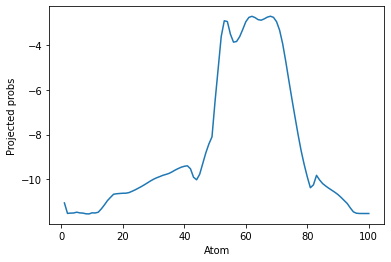

Episode 120: 	Actor Loss: -9.93 	Critic Loss: 1.99 
		Average Score: 66.82

SCORES (this eps):  [  3.09814081  60.70397256   0.43190663  41.32647125  13.35353277
  83.25235911 199.83901315  11.95904639  70.90555355   8.27431091
  13.35219641  73.82488842] 



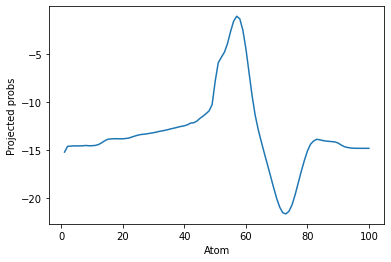

Episode 122\ Score: 73.12NaN Reward Found! Skipping this episode.
Episode 130: 	Actor Loss: -10.88 	Critic Loss: 2.01 
		Average Score: 77.93

SCORES (this eps):  [ 51.89450606  22.8756819    6.13958476 155.00563537 192.7253858
 113.40732157  90.09378169  57.62920604  61.36483194  91.97933217
 286.25173199  48.9506867 ] 



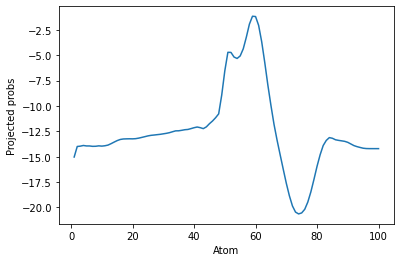

Episode 133\ Score: 87.356
NaN found in states. Skipping this episode.
Episode 134\ Score: 74.54

scripts\d4pg_agent.py:187: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), self.params.gradient_clip)    # ADDED: Gradient Clipping to prevent exploding grad issue
scripts\d4pg_agent.py:180: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), self.params.gradient_clip)    # ADDED: Gradient Clipping to prevent exploding grad issue



NaN found in actions. Skipping this episode.
Episode 135\ Score: 73.63
NaN found in states. Skipping this episode.
Episode 136\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 137\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 138\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 139\ Score: 0.00
NaN found in states. Skipping this episode.


==== An exception occurred: The histogram is empty, please file a bug report.


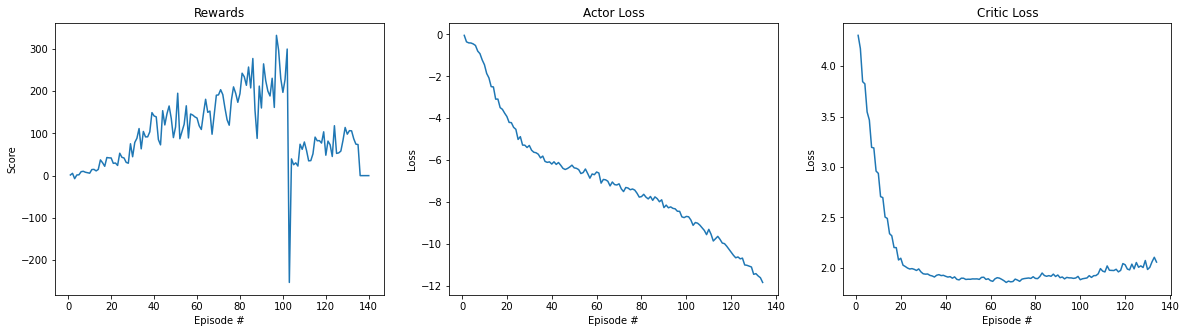

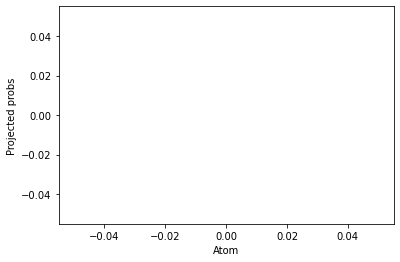

[1.5018947045318782,
 5.449606182325321,
 -7.209713413244269,
 1.4946127056221787,
 1.9876661333643522,
 9.31503133563092,
 10.258940247197947,
 8.035889762511943,
 6.860504696950859,
 5.75763039298666,
 14.422040255934311,
 14.779288928490132,
 11.215793064484993,
 14.678176025277935,
 37.2735655309516,
 30.52666033404724,
 22.080891133363668,
 42.93354116506331,
 42.11454132121677,
 41.83634139614878,
 29.091162662157632,
 29.904285415036913,
 24.114152738514047,
 53.0918450896473,
 43.43713340149649,
 41.787424408626975,
 31.346328382147476,
 29.401692827678442,
 75.52719063699867,
 44.725845349642135,
 78.56805779341327,
 88.5495216480728,
 111.5256386627055,
 63.437925549582964,
 104.63761584289993,
 91.78816474106861,
 91.93800084738177,
 103.71972967669232,
 149.2832487785296,
 141.3774698303047,
 139.24221301944394,
 85.41413727817901,
 72.89238595531788,
 153.87130457093008,
 120.08242424436564,
 146.52291546602888,
 165.02483957339427,
 135.37236081067144,
 90.10022249552033,

In [35]:
# 3 layers network instead...
# ACHIEVED: Max +300 score

##################
# Vmax = -Vmin = 50
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_50_longest_refactor'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_50_longest_refactor'
params.num_atoms = 100
params.vmin = -50
params.vmax = 50


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -10
VMAX:  10
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.12 	Critic Loss: 3.51 
		Average Score: 1.31

SCORES (this eps):  [ 4.74952316  6.68668457 12.04325435 10.60866531  3.49797    11.05383534
  6.52831901  8.57136849  4.91060774  7.70282338  0.43417348  0.51167626] 



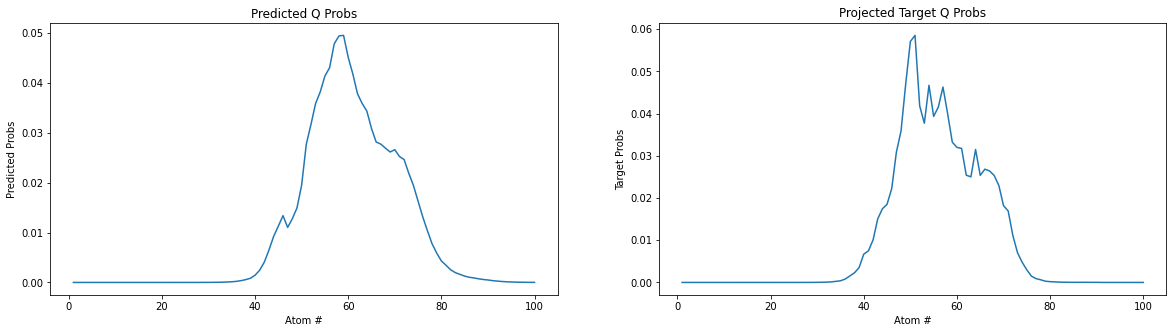

Episode 20: 	Actor Loss: -2.04 	Critic Loss: 2.95 
		Average Score: 7.69

SCORES (this eps):  [16.73934793 24.7934813   8.15867561 12.7200511   4.45849645 21.27195768
  5.54232801  0.22094676  7.51643173 16.11211001  5.23363806  6.44394575] 



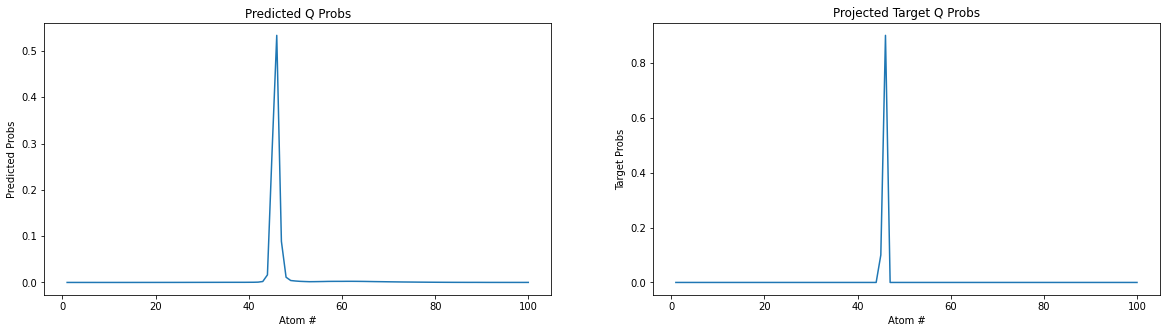

Episode 30: 	Actor Loss: -3.57 	Critic Loss: 3.07 
		Average Score: 12.71

SCORES (this eps):  [10.66916367 11.63231296  4.60780805 10.28230593  2.18556099 17.70228199
 12.44176369 15.69830473 15.18402119  7.81658644 29.18024183  5.66987627] 



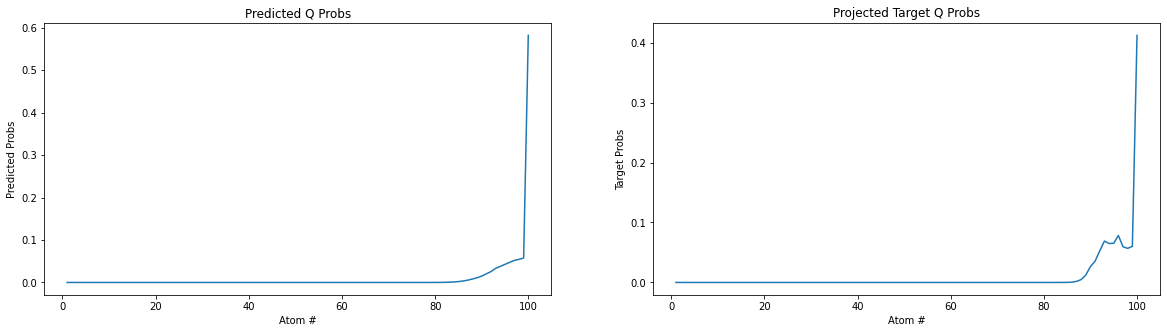

Episode 40: 	Actor Loss: -4.53 	Critic Loss: 3.04 
		Average Score: 21.25

SCORES (this eps):  [65.11383654 26.29735886 51.39464828 61.05666072 26.58697207  0.
 16.45197326 18.16437086  5.39302941 16.04053742 57.41782009 20.2927629 ] 



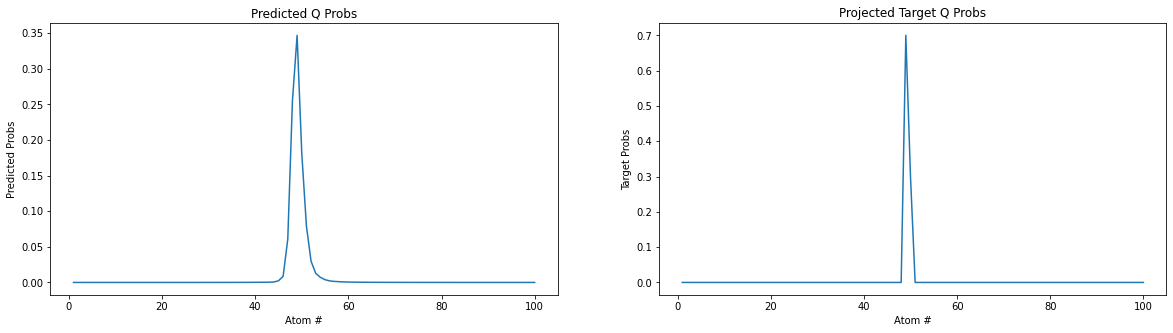

Episode 50: 	Actor Loss: -4.99 	Critic Loss: 2.96 
		Average Score: 25.81

SCORES (this eps):  [ 0.12843531 38.62391663  0.29076731 40.21912171  4.49381281 45.14884269
  7.46401399 84.56823705 16.38077565 34.12659043 51.68304275  0.        ] 



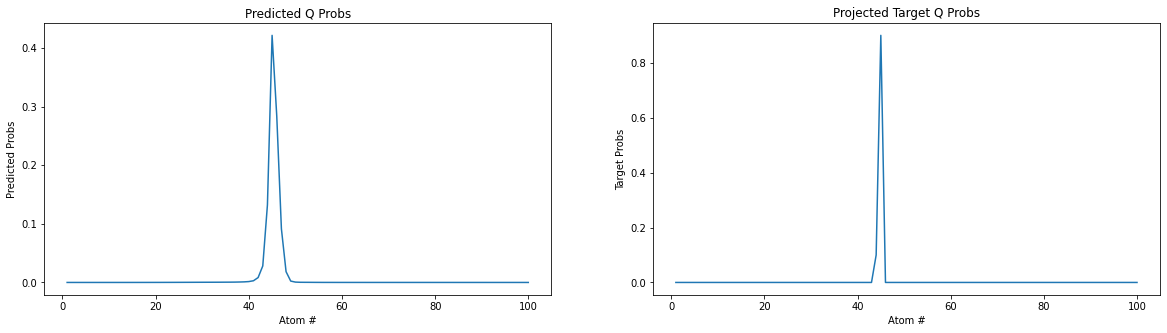

Episode 60: 	Actor Loss: -5.28 	Critic Loss: 2.89 
		Average Score: 25.30

SCORES (this eps):  [21.00388025 33.18554536 17.05888451 22.44746544 23.30982839 46.16697576
 57.9553543  27.07088422 11.84640278 70.41824624 14.84703945 16.82538114] 



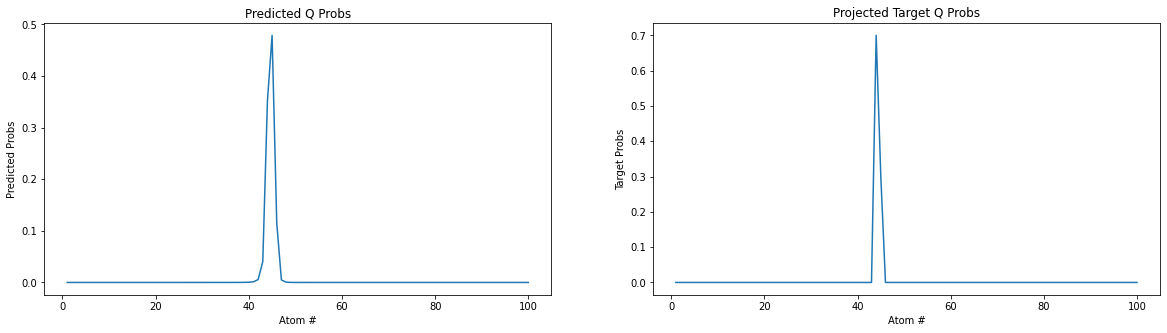

Episode 61\ Score: 47.89NaN Reward Found! Skipping this episode.
Episode 70: 	Actor Loss: -5.58 	Critic Loss: 2.84 
		Average Score: 34.92

SCORES (this eps):  [70.63840825 82.45920388 33.70186659 22.62233073 24.18617731 47.38222469
  9.98880753  5.72812434 58.16706268 39.41431027 19.70636144 31.62038914] 



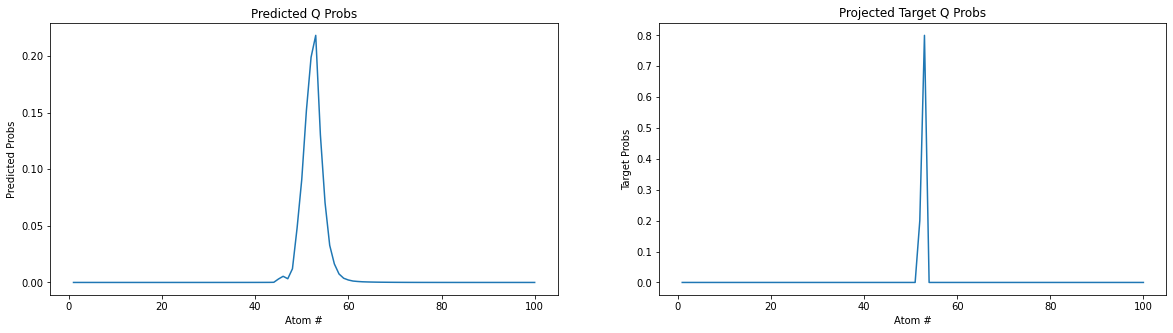

Episode 79\ Score: 31.35Errorneously low Reward = -30.03 Found! Doing nothing...
[0.6844662427902222, -30.02957534790039, -0.9074227809906006, 0.3852670192718506, 0.2647444009780884, 0.7115450501441956, 0.6817458868026733, 0.91402268409729, 1.0131025314331055, -0.9678036570549011, 1.242895483970642, 0.19883304834365845]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.15 Found! Doing nothing...
[0.6729363799095154, -30.1474609375, 0.1192917674779892, 0.6252310872077942, -0.07356325536966324, 0.7994219064712524, 0.7492728233337402, 0.8657596111297607, 0.8436534404754639, 0.08434024453163147, 0.8244209885597229, 0.24709121882915497]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.28 Found! Doing nothing...
[0.6807571649551392, -30.2784481048584, 0.13661319017410278, 0.2822328507900238, 0.2756893038749695, 0.6165794134140015, 0.6704359650611877, 0.9692116975784302, 0.7262097001075745, 0.17651964724063873, 1.0172669887542725, 0.38473859429359436]
SKIPPING T

Errorneously low Reward = -34.15 Found! Doing nothing...
[1.075830101966858, -34.15097427368164, 0.17979128658771515, 0.7469609379768372, 0.43172308802604675, 0.049351077526807785, 0.927704393863678, 0.9170113205909729, 0.5181096792221069, 0.8067119121551514, 0.7236025333404541, 0.02705514430999756]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -34.32 Found! Doing nothing...
[1.158044457435608, -34.31522750854492, 0.20406439900398254, 0.706802487373352, 0.3199821412563324, -0.061718687415122986, 0.7419958710670471, 0.5908889174461365, 0.5985108613967896, 0.8045927286148071, 0.6547060012817383, 0.009334311820566654]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -34.42 Found! Doing nothing...
[1.0737276077270508, -34.41792678833008, 0.09657697379589081, 0.7931903004646301, 0.3695245385169983, 0.022131726145744324, 0.5348353385925293, 0.6139894723892212, 0.549388587474823, 0.8203279376029968, 0.8574387431144714, 0.016552580520510674]
SKIPPING TRAINING OF THIS

Errorneously low Reward = -38.25 Found! Doing nothing...
[0.34309011697769165, -38.248008728027344, 0.5796222686767578, 0.7283094525337219, 0.3307841122150421, 0.7096612453460693, -0.02141626924276352, 0.28513845801353455, 0.7197659611701965, 0.0823448896408081, 0.43568411469459534, 0.6558331251144409]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -38.36 Found! Doing nothing...
[0.31069478392601013, -38.364871978759766, 0.46168431639671326, 0.530650794506073, 0.4496890902519226, 0.6783310770988464, -1.0317292213439941, 0.2830245792865753, 0.6399550437927246, 0.20437057316303253, 0.4425863027572632, 0.643571138381958]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -38.49 Found! Doing nothing...
[0.37540850043296814, -38.491485595703125, 0.4960440993309021, 0.6329845190048218, 0.3552389442920685, 0.4711613655090332, 0.18133263289928436, 0.26158788800239563, 0.4102693200111389, 0.15580952167510986, 0.4896315634250641, 0.7101536393165588]
SKIPPING TRAINING OF T

Errorneously low Reward = -42.17 Found! Doing nothing...
[0.6652780175209045, -42.166603088378906, 0.24739845097064972, 0.7262488007545471, 0.5913957953453064, 0.26379507780075073, 0.3233998417854309, 0.6124961972236633, 0.19048047065734863, 0.5789394974708557, 1.0298595428466797, 0.5567013025283813]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -42.33 Found! Doing nothing...
[0.5565313100814819, -42.33158493041992, 0.12820954620838165, 0.6002905368804932, 0.5227173566818237, 0.20870813727378845, 0.3928111493587494, 0.833075761795044, 0.390995055437088, 0.36245208978652954, 0.975563108921051, 0.7520301938056946]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -42.45 Found! Doing nothing...
[0.7975518107414246, -42.4547004699707, 0.21820630133152008, 0.8520504832267761, 0.36105769872665405, 0.41915950179100037, 0.5309724807739258, 0.6278077363967896, 0.36625003814697266, 0.30168449878692627, 1.0194199085235596, 0.7926011085510254]
SKIPPING TRAINING OF THIS TI

Errorneously low Reward = -46.29 Found! Doing nothing...
[1.0114612579345703, -46.29439926147461, 0.10520035773515701, 0.5976330041885376, 0.5286521315574646, 0.31306037306785583, 0.4600568413734436, 1.0087817907333374, 0.8348294496536255, 0.14681988954544067, 0.8578202724456787, 0.39968833327293396]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -46.40 Found! Doing nothing...
[1.0028655529022217, -46.397891998291016, 0.06747210025787354, 0.474774569272995, 0.39898812770843506, 0.4048756957054138, 0.3442526161670685, 1.4194481372833252, 0.6488991975784302, 0.293913334608078, 0.8003900051116943, 0.5462389588356018]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -46.48 Found! Doing nothing...
[0.9209259152412415, -46.47971725463867, 0.20664019882678986, 0.36579519510269165, 0.4367446005344391, 0.34424999356269836, 0.21344101428985596, 1.3081386089324951, 0.7406953573226929, 0.32826703786849976, 0.8154537677764893, 0.6926614046096802]
SKIPPING TRAINING OF THIS 

Errorneously low Reward = -50.22 Found! Doing nothing...
[-1.09221613407135, -50.22245407104492, 0.6624364852905273, 0.27954408526420593, -0.013153734616935253, 0.5369073748588562, 0.01153804175555706, 0.629356324672699, 0.6705990433692932, 0.10480548441410065, 0.8402093648910522, 0.03378046676516533]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -50.36 Found! Doing nothing...
[0.15467070043087006, -50.355918884277344, 0.7343801856040955, 0.2747443914413452, 0.26910534501075745, 0.33638378977775574, 0.05463225767016411, 0.5146983861923218, 0.5889225006103516, -0.06358745694160461, 0.8245803117752075, -0.030725782737135887]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -50.46 Found! Doing nothing...
[0.130144864320755, -50.45865249633789, 0.6236239075660706, 0.24375376105308533, 0.17558489739894867, 0.6184399127960205, 0.13574981689453125, 0.39863598346710205, 0.6096259355545044, 0.14527596533298492, 0.9453352689743042, 0.6061719655990601]
SKIPPING TRAINING

Errorneously low Reward = -53.92 Found! Doing nothing...
[1.0525622367858887, -53.92449951171875, 0.5578376054763794, 0.744206428527832, 0.18856564164161682, 0.7961044907569885, 0.5949109196662903, 0.19007061421871185, 0.15387295186519623, 0.5891062617301941, 0.5305071473121643, 0.2949599027633667]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -54.05 Found! Doing nothing...
[0.72300785779953, -54.050086975097656, 0.7159312963485718, 0.9097370505332947, 0.3244369924068451, 0.7495023608207703, 0.5798548460006714, 0.32758381962776184, 0.13423024117946625, 0.7349242568016052, 0.5112367868423462, 0.10592344403266907]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -54.15 Found! Doing nothing...
[0.8732969164848328, -54.14690399169922, 0.6445042490959167, 0.952415943145752, 0.22421246767044067, 0.5682695508003235, 0.6482331156730652, 0.1554248183965683, 0.08403565734624863, 0.5661910772323608, 0.8108183145523071, 0.008586474694311619]
SKIPPING TRAINING OF THIS TIM

Errorneously low Reward = -57.80 Found! Doing nothing...
[0.10848148167133331, -57.79627227783203, 0.37399908900260925, -0.18076668679714203, 0.4180445671081543, 0.8183965682983398, 0.438685804605484, 0.33932775259017944, 0.7743786573410034, 0.5052057504653931, 0.5794083476066589, 0.15844272077083588]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -57.89 Found! Doing nothing...
[0.2646167576313019, -57.88700485229492, 0.5781476497650146, -0.14613522589206696, 0.40573590993881226, 0.7775636315345764, 0.662455141544342, 0.4959736764431, 0.8493523597717285, 0.655897319316864, 0.5015470385551453, 0.2123061567544937]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -58.04 Found! Doing nothing...
[0.37081971764564514, -58.03833770751953, 0.667181670665741, -0.18620628118515015, 0.5320974588394165, 0.8014054298400879, 0.8154796361923218, 0.41529321670532227, 0.6095550060272217, 0.26949208974838257, 0.21401292085647583, 0.019875243306159973]
SKIPPING TRAINING OF THIS 

Errorneously low Reward = -61.51 Found! Doing nothing...
[0.16544564068317413, -61.50699996948242, 0.46816590428352356, 0.5071139335632324, 0.0749211385846138, 0.7573977708816528, 0.6180884838104248, 0.4684228301048279, 0.14783769845962524, 0.7353760004043579, 0.4329291880130768, 0.9839993715286255]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -61.64 Found! Doing nothing...
[0.14024768769741058, -61.64458084106445, 0.291691392660141, 0.41584503650665283, 0.5872803926467896, 0.7177162170410156, 0.7088026404380798, 0.29536598920822144, 0.4011443555355072, 0.778266966342926, 0.3264217674732208, 0.9868484139442444]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -61.73 Found! Doing nothing...
[0.2803809940814972, -61.73231887817383, 0.1524345874786377, 0.4994683265686035, 0.9426054358482361, 0.3272375464439392, 0.8168591856956482, 0.04587753489613533, 0.358826220035553, 0.9676387310028076, 0.5063165426254272, 0.9556511044502258]
SKIPPING TRAINING OF THIS TIMEST

Errorneously low Reward = -65.33 Found! Doing nothing...
[0.5713412761688232, -65.3255386352539, 0.46345990896224976, -0.2222919464111328, 0.04114604368805885, 0.4177190661430359, 0.1556883305311203, 1.0169782638549805, 0.7410338521003723, 0.2324269562959671, 0.8162015676498413, 0.07830491662025452]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -65.41 Found! Doing nothing...
[0.53846275806427, -65.40737915039062, 0.517822802066803, -0.09304901957511902, -0.1014510840177536, 0.8301740288734436, 0.14061997830867767, 0.9322309494018555, 0.6648277640342712, 0.19404521584510803, 0.796256959438324, 0.07470864802598953]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -65.51 Found! Doing nothing...
[0.3632335364818573, -65.50979614257812, 0.6067949533462524, 0.018459105864167213, -0.15788288414478302, 0.7884049415588379, 0.07465662062168121, 0.8524605631828308, 0.5848950147628784, 0.2577633857727051, -0.9139137864112854, 0.17256306111812592]
SKIPPING TRAINING OF THI

Errorneously low Reward = -68.83 Found! Doing nothing...
[0.7254348993301392, -68.83358001708984, 0.44714364409446716, 0.7643533945083618, 0.2592981457710266, 0.530669629573822, 0.37732288241386414, 0.035628292709589005, 0.6761547327041626, 0.6548995971679688, 1.1746083498001099, 0.5682711601257324]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -68.86 Found! Doing nothing...
[0.8371705412864685, -68.86408996582031, 0.6367535591125488, 0.534949004650116, 0.179961696267128, 0.7138910889625549, 0.5073477029800415, 0.05308285728096962, 0.7446094751358032, 0.5604863166809082, 1.1104867458343506, 0.8091204166412354]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -68.97 Found! Doing nothing...
[0.5589009523391724, -68.97469329833984, 0.7229458689689636, 0.4518839120864868, 0.30821818113327026, 0.7971932888031006, 0.6349421739578247, 0.22466471791267395, 0.6789840459823608, 0.543359100818634, 1.0602567195892334, 0.6248080730438232]
SKIPPING TRAINING OF THIS TIMESTE

Errorneously low Reward = -72.56 Found! Doing nothing...
[0.7016263604164124, -72.55620574951172, 0.3932981491088867, 0.28529614210128784, 0.13378508388996124, 0.7947449684143066, 0.6304894089698792, 0.13665476441383362, 1.0713545083999634, 0.790666401386261, 0.45046472549438477, 0.8488008379936218]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -72.63 Found! Doing nothing...
[0.4199245274066925, -72.62599182128906, 0.5047915577888489, 0.1356031894683838, 0.08099880069494247, 0.8160249590873718, 0.6351606845855713, -0.0359884537756443, 1.0472431182861328, 1.070893406867981, 0.5133474469184875, 0.7333587408065796]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -72.73 Found! Doing nothing...
[0.2527959942817688, -72.725830078125, 0.4404847025871277, 0.06331010907888412, 0.017807912081480026, 0.780499279499054, 0.686622679233551, -0.9516662359237671, 1.336351752281189, 1.1081618070602417, 0.5541336536407471, 0.7335608601570129]
SKIPPING TRAINING OF THIS TIMESTE

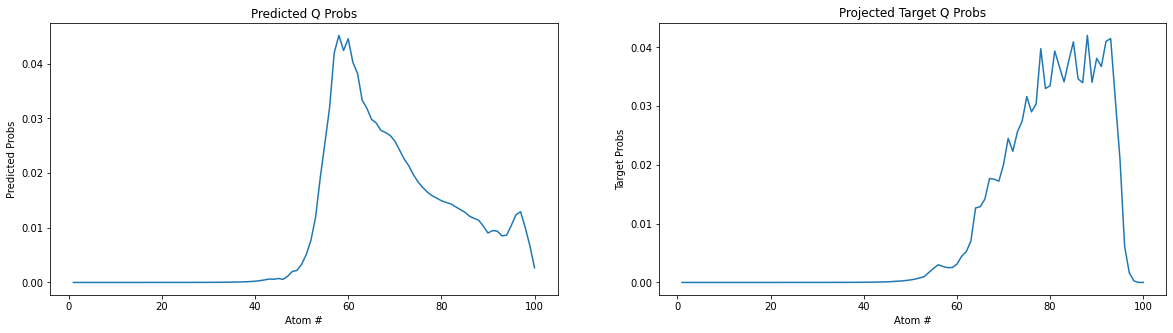

Episode 90: 	Actor Loss: -6.20 	Critic Loss: 2.64 
		Average Score: 43.22

SCORES (this eps):  [ 56.76031003  44.46720612  42.19171097  47.56723653  13.73069355
  34.76733982  42.04221966  75.58771569  78.76553388   8.37398731
 169.68074938  68.74745229] 



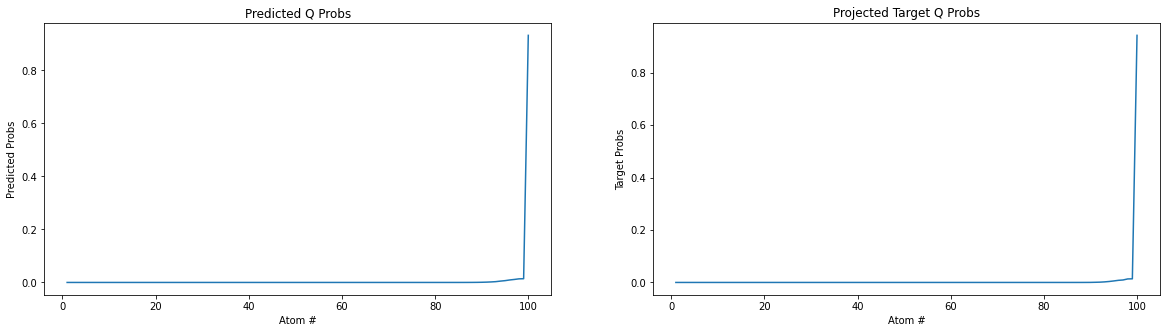

Episode 92\ Score: 56.62NaN Reward Found! Skipping this episode.
Episode 100: 	Actor Loss: -6.33 	Critic Loss: 2.46 
		Average Score: 60.06

SCORES (this eps):  [ 22.72478036  18.30955185 185.81388765  25.46440826  55.13265833
  29.7588073   87.07553902  71.28569525  11.04896059  26.81183667
  77.42262187  20.05948518] 



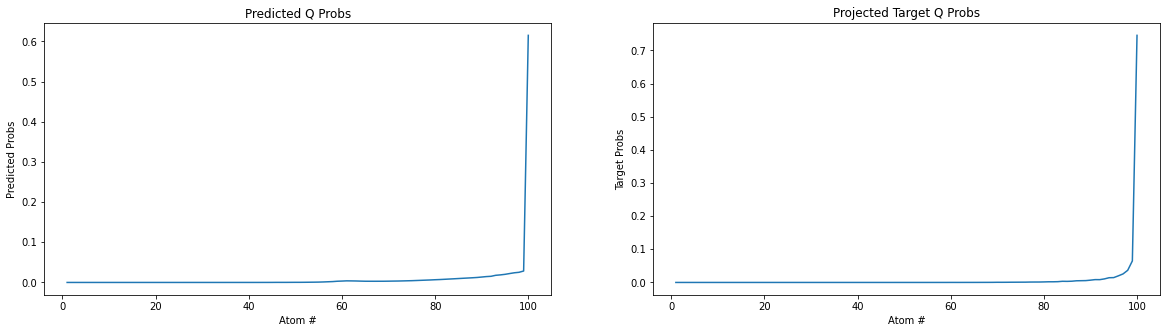

Episode 110: 	Actor Loss: -6.33 	Critic Loss: 2.27 
		Average Score: 65.00

SCORES (this eps):  [ 25.49684603   8.85202978   8.34178986 105.07846734  22.82222858
 154.45439011 126.43472344  70.03035392   0.41767617  29.09892335
   7.15530813 235.81701819] 



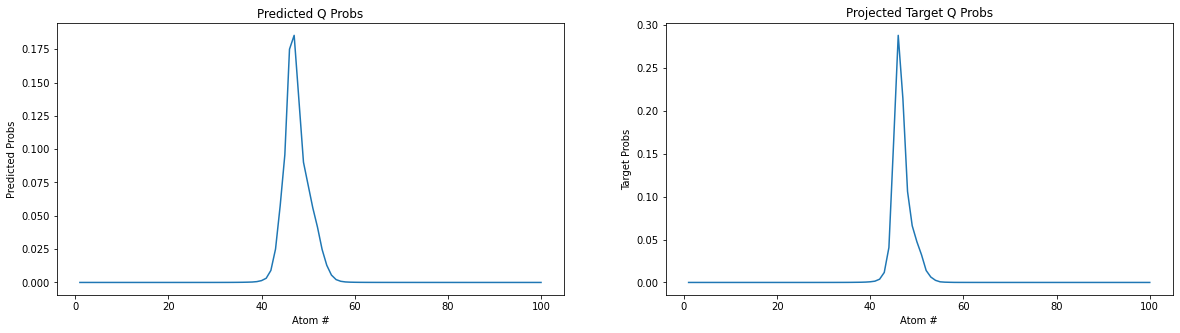

Episode 111\ Score: 95.84NaN Reward Found! Skipping this episode.
Episode 120: 	Actor Loss: -6.22 	Critic Loss: 2.20 
		Average Score: 84.35

SCORES (this eps):  [123.4928493   87.35649444 162.26644819 191.18203682 126.20799038
 208.99174076 123.4116876   61.49355543 151.41005351 145.96097002
 161.38536116 109.68828212] 



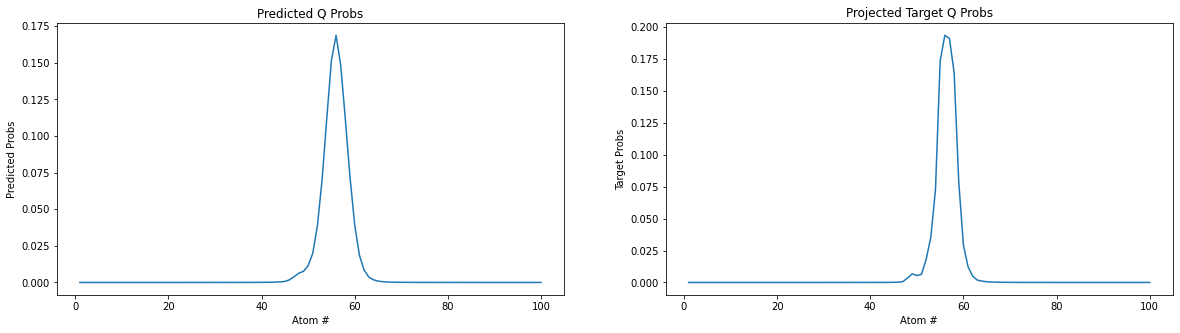

Episode 130: 	Actor Loss: -5.97 	Critic Loss: 2.19 
		Average Score: 124.69

SCORES (this eps):  [158.60850181 134.86405687 163.41612051 161.08441294 221.48828275
  89.15408741 163.6320719  152.60861511 203.79351075  10.9191828
  68.39128036 139.49456496] 



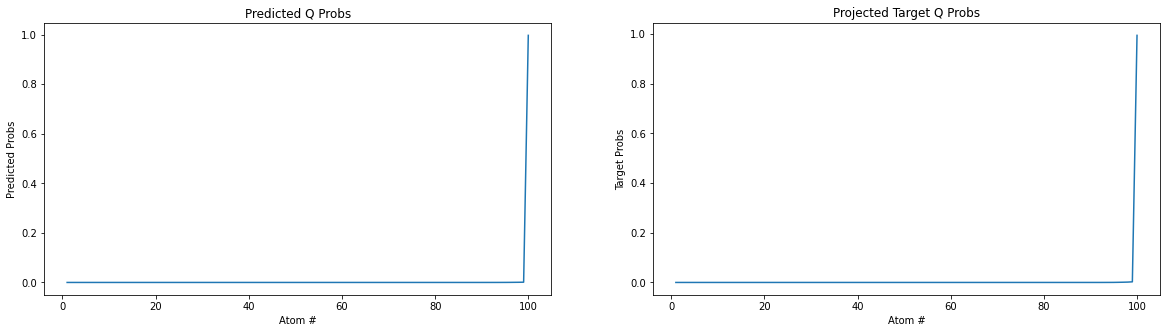

Episode 140: 	Actor Loss: -5.76 	Critic Loss: 2.15 
		Average Score: 157.62

SCORES (this eps):  [ 69.83109625 216.89270826  24.55568825 230.59611991 153.1628281
 173.71218065  72.43533944 102.32480994 153.08198719 169.01078706
 102.34015059 269.12808172] 



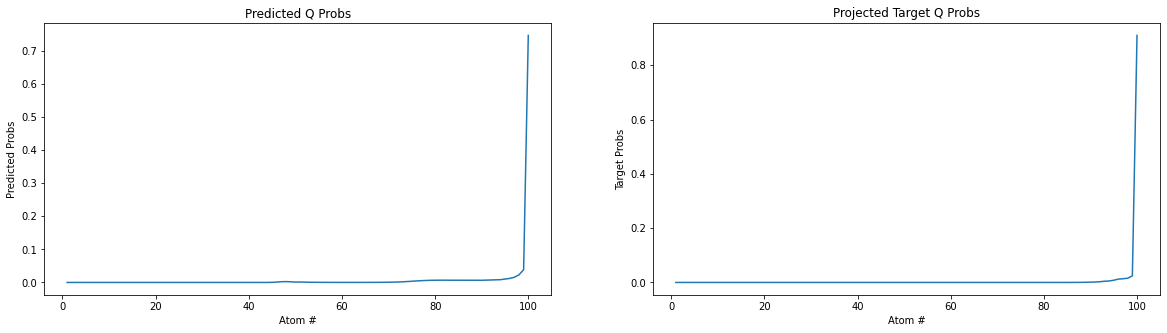

Episode 150: 	Actor Loss: -5.54 	Critic Loss: 2.21 
		Average Score: 156.17

SCORES (this eps):  [106.96205912 191.3130819    8.62374834 237.75947201 499.82181189
 208.71458893  28.13366869 143.40874659 224.44106296 137.56606473
  74.40568628 209.41767658] 



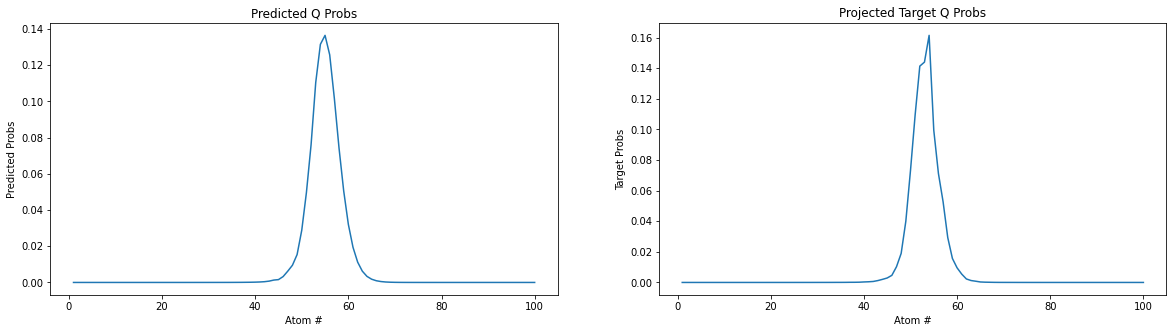

NaN Reward Found! Skipping this episode.
Episode 160: 	Actor Loss: -5.46 	Critic Loss: 2.27 
		Average Score: 163.05

SCORES (this eps):  [166.54108988 326.48978364 148.43665586  75.06008021 193.58887646
 217.97876951 288.05985802 246.42843614 137.42782007 538.54348464
  68.64726479 276.85801978] 



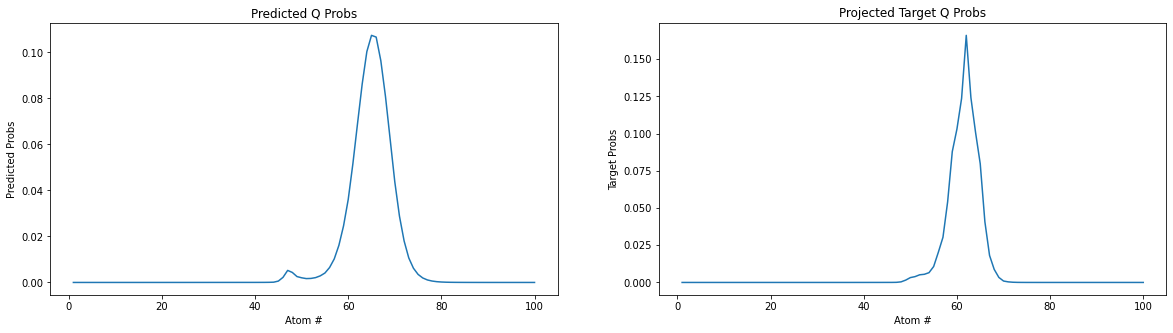

Episode 170: 	Actor Loss: -5.38 	Critic Loss: 2.33 
		Average Score: 185.79

SCORES (this eps):  [163.1619749  300.6360279  226.80747274 336.83820678 212.27631261
 124.93915201 336.71870811  98.51592886 319.15773231  28.81739425
  16.09119005  91.69195863] 



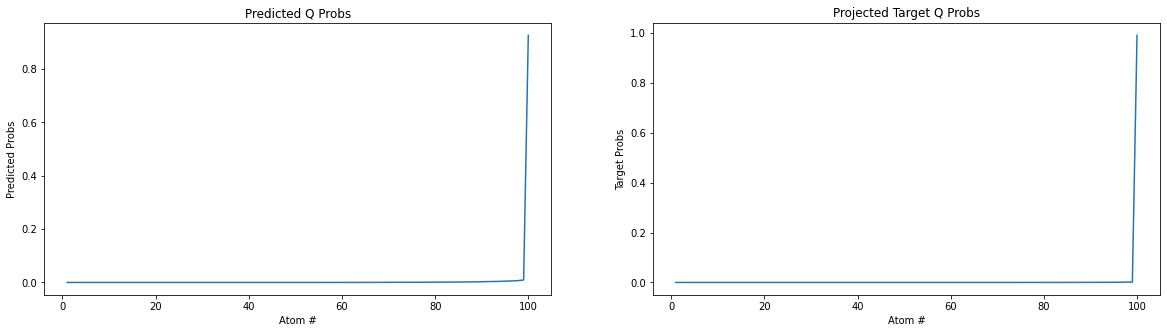

Episode 180: 	Actor Loss: -5.48 	Critic Loss: 2.33 
		Average Score: 197.87

SCORES (this eps):  [319.2482326  208.27734813 196.33996443 135.44999182 263.2448021
 244.42871411 179.52886086 152.33519448 264.86072549 299.40699821
 223.71859924  96.87520026] 



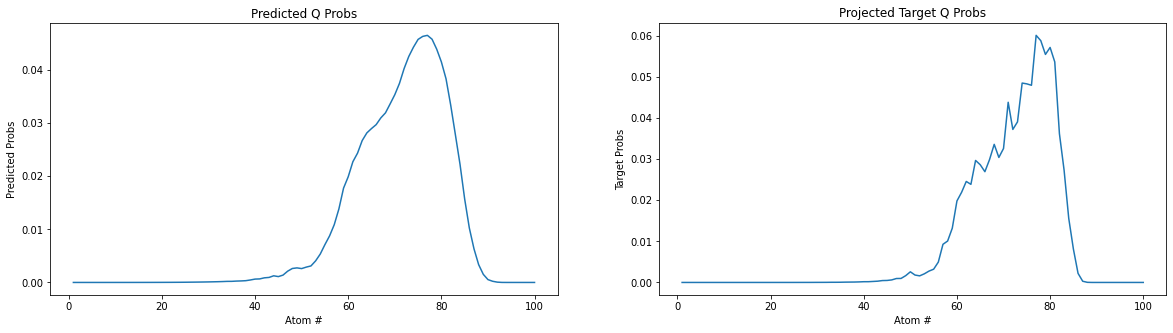

Episode 190: 	Actor Loss: -5.66 	Critic Loss: 2.33 
		Average Score: 198.64

SCORES (this eps):  [2.18228121e+02 9.71643538e+01 4.01268306e+02 2.92677285e+02
 3.20076675e+02 1.96862132e+02 2.46233713e+02 8.63724393e+01
 3.18124190e-01 2.33234856e+02 1.86903066e+01 3.24681766e+02] 



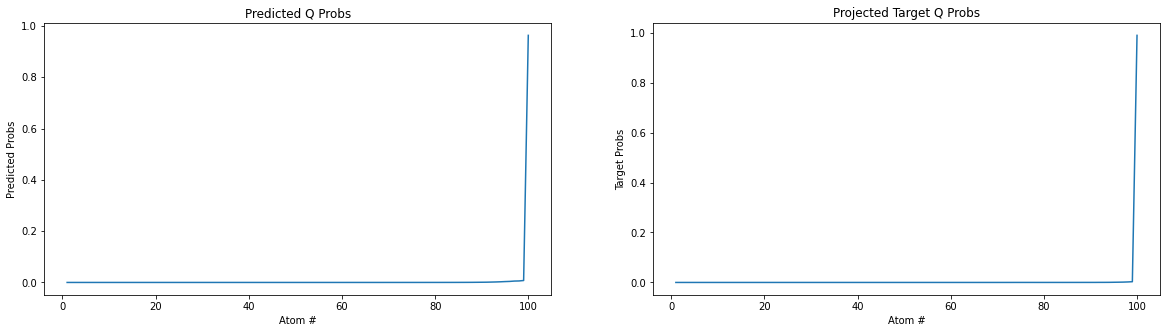

Episode 197\ Score: 176.76NaN Reward Found! Skipping this episode.
Episode 200: 	Actor Loss: -5.78 	Critic Loss: 2.42 
		Average Score: 158.59

SCORES (this eps):  [258.96550193 162.70304634   5.64649826  22.62556373 158.73012345
 135.81312023 238.80893309  50.72380794  70.17758934 409.25459194
 141.14757973 269.46537394] 



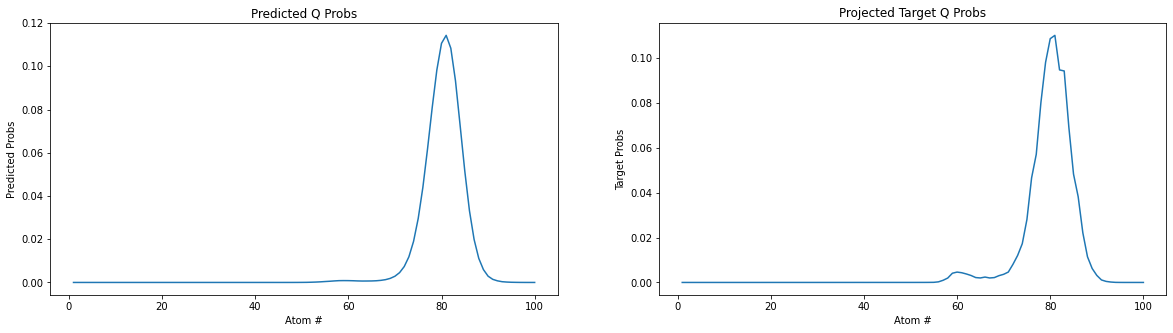

Episode 207\ Score: 129.77

==== An exception occurred: 


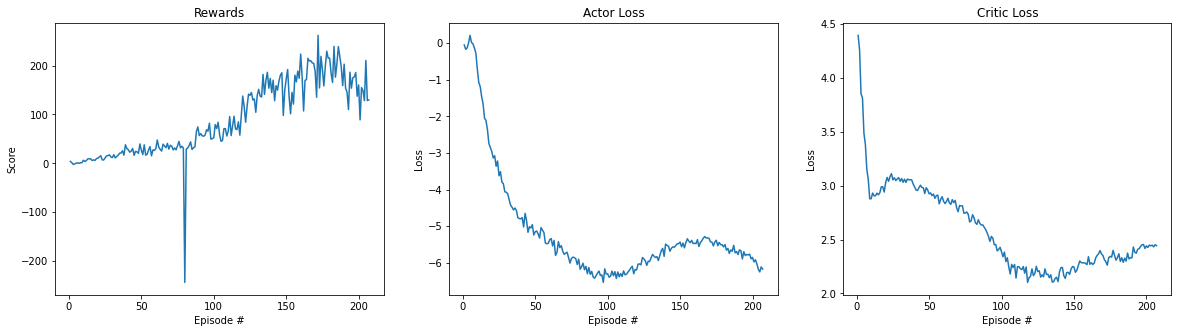

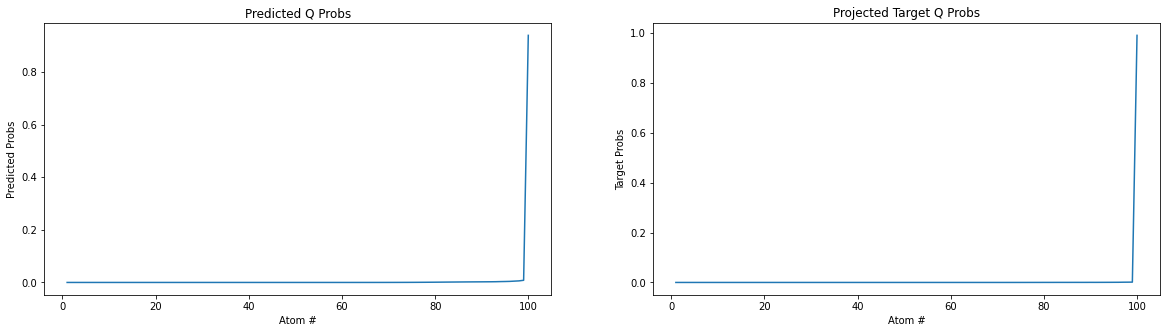

[4.073613124344168,
 1.3411888820895304,
 -2.120982962602284,
 -0.8460936120633656,
 0.22682961965134987,
 1.13477047396979,
 0.18062398924181858,
 1.1510106878510367,
 1.4759266555386905,
 6.441575089818798,
 3.940031066381683,
 5.631109898948732,
 9.056937961606309,
 9.420935893276086,
 9.270142215459297,
 5.83529584936332,
 7.187631899258122,
 6.061875166837126,
 9.730489411119683,
 10.767617533992356,
 13.02636473311577,
 15.586384272862537,
 7.003070397069678,
 6.984955264410625,
 11.020319683322063,
 15.374614393610196,
 15.916887782514095,
 17.443429113792565,
 12.833301756841442,
 11.922518979059532,
 17.73690924766318,
 11.08509611004653,
 14.089585260837339,
 16.599454293842427,
 20.871128037649516,
 21.097638060397003,
 25.825806737761013,
 16.705332555420075,
 38.12215174055503,
 30.350830868759658,
 27.872384389241535,
 22.900521168136038,
 24.92392374202609,
 30.55772470345255,
 16.39032417134149,
 24.64301004889421,
 23.634932830929756,
 20.44657062056164,
 39.7873096222

In [54]:
# 3 layers network instead...
# ACHIEVED: Max +300 score

##################
# Vmax = -Vmin = 10
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 1.0        # TEST: Don't clip
params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_10_longest_refactor'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_10_longest_refactor'
params.num_atoms = 100
params.vmin = -10
params.vmax = 10


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

# Resuming training from previous weights...

In [30]:
##################
# Achieved rewards @ eps~=400 in 300 episodes
##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=3000
params.max_t = 1000
params.print_every = 1
params.save_every = 10
params.log_weights_every = 1
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-6                  
params.lr_critic = 5e-5 
params.vmin = -1
params.vmax = 400
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512

params.restart_training = False
params.eps_to_resume_from = 231
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic'
params.actor_weights_filename_to_resume = 'checkpoint_actor_ep230.pth'
params.critic_weights_filename_to_resume = 'checkpoint_critic_ep230.pth'

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  5e-06
LR_CRITIC:  5e-05
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  400
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

tensor([0.0000e+00, 1.0577e-01, 2.6953e-01, 3.2547e-01, 2.4419e-01, 4.8858e-02,
        3.6379e-03, 3.0371e-04, 1.9448e-04, 1.6048e-04, 1.3094e-04, 1.3376e-04,
        1.1185e-04, 9.2470e-05, 9.1216e-05, 9.1566e-05, 7.0925e-05, 6.5131e-05,
        7.7602e-05, 5.8450e-05, 5.2630e-05, 5.5416e-05, 5.1025e-05, 4.6327e-05,
        4.6095e-05, 4.2831e-05, 3.6946e-05, 3.4031e-05, 3.7154e-05, 3.8842e-05,
        3.0156e-05, 2.5225e-05, 2.8697e-05, 2.3088e-05, 2.2825e-05, 2.6748e-05,
        2.4898e-05, 2.2210e-05, 2.0443e-05, 1.7347e-05, 

tensor([7.1637e-04, 2.5461e-02, 1.9041e-01, 5.1483e-01, 2.5374e-01, 1.1555e-02,
        4.1493e-04, 1.0443e-04, 1.9850e-04, 1.8113e-04, 1.8350e-04, 1.4967e-04,
        1.3577e-04, 1.1169e-04, 1.2027e-04, 1.0332e-04, 8.6456e-05, 8.6825e-05,
        8.9511e-05, 7.2187e-05, 6.4506e-05, 7.3937e-05, 5.9643e-05, 5.7955e-05,
        6.0638e-05, 4.9688e-05, 4.3485e-05, 5.0960e-05, 4.7496e-05, 4.2265e-05,
        4.1389e-05, 3.6672e-05, 3.0006e-05, 3.2761e-05, 3.2342e-05, 3.2644e-05,
        3.2590e-05, 2.8898e-05, 2.7909e-05, 2.0809e-05, 1.8759e-05, 2.2031e-05,
        2.0229e-05, 1.8854e-05, 2.0374e-05, 2.1811e-05, 1.8896e-05, 1.8269e-05,
        1.7617e-05, 1.0372e-05, 1.0005e-05, 1.1760e-05, 1.0890e-05, 1.0015e-05,
        1.0943e-05, 1.1687e-05, 1.0050e-05, 1.0926e-05, 1.0839e-05, 1.1765e-05,
        9.8271e-06, 6.9852e-06, 5.3591e-06, 4.0631e-06, 4.0631e-06, 4.7403e-06,
        4.4017e-06, 4.0631e-06, 4.4016e-06, 4.7403e-06, 4.0631e-06, 4.0631e-06,
        5.0788e-06, 4.0631e-06, 4.4016e-



==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([1.9171e-01, 6.7864e-01, 4.1872e-01, 1.1115e+00, 9.3391e-01, 8.7517e-01,
        8.0484e-01, 8.3174e-01, 1.1408e+00, 8.0735e-01, 3.0553e-41, 7.5992e-01,
        7.1437e-01, 5.4217e-01, 4.3828e-01, 4.0554e-01, 5.0402e-01, 3.0553e-41,
        7.7494e-01, 7.7726e-01, 6.9113e-01, 4.9815e-01, 4.4453e-01, 5.2207e-01,
        5.2519e-01, 6.6595e-01, 5.7145e-01, 5.2822e-01, 4.8950e-01, 3.0553e-41,
        4.7936e-01, 5.6497e-01, 6.9114e-01, 6.8524e-01, 5.5990e-01, 5.1654e-01,
        5.2630e-01, 5.6571e-01, 7.3785e-01, 6.9673e-01, 6.7165e-01, 6.3027e-01,
        3.0553e-41, 3.0553e-41, 4.9219e-01, 3.0553e-41, 7.5465e-01, 7.6710e-01,
        6.1007e-01, 4.9750e-01, 4.4752e-01, 5.4672e-01, 5.4929e-01, 5.9262e-01,
        4.9883e-01, 4.8778e-01, 5.4161e-01, 3.0553e-41, 4.7556e-01, 5.6392e-01,
        7.0884e-01, 6.6669e-01, 4.7856e-01, 5.0000e-01, 4.7839e-01, 5.1477e-01,
        7.2102e-01, 

KeyboardInterrupt: 


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  5e-06
LR_CRITIC:  1e-05
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -5
VMAX:  5
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 100008 / 100000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 160: 	Actor Loss: -4.93 	Critic Loss: 0.15 
		Average Score: 190.55

SCORES (this eps):  [1.21698340e+02 1.83387438e+02 1.66141405e+02 3.61955065e+02
 5.69830658e+01 4.17056839e+02 4.32224747e+02 1.97335689e+02
 1.26426011e-01 4.25586998e+02 3.14546560e+02 8.75430699e+01] 



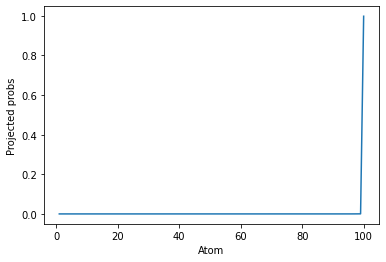

Episode 170: 	Actor Loss: -4.93 	Critic Loss: 0.16 
		Average Score: 265.20

SCORES (this eps):  [422.14522811 146.3728082  130.57892499 339.94595407 463.66088844
 344.93123277 437.66611312  52.66114755 274.42573049 204.01257657
 137.49808839 303.44986608] 



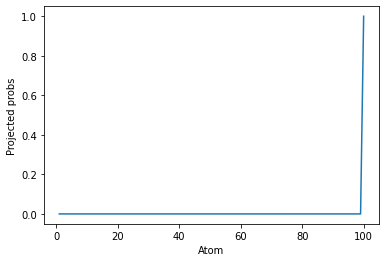

Episode 180: 	Actor Loss: -4.93 	Critic Loss: 0.16 
		Average Score: 276.56

SCORES (this eps):  [342.35024663 444.86199003 115.80531028 280.90104397 182.43677282
  23.39396778 387.26510779 441.66941904 440.14198375 453.69496938
 105.27571786 444.11974493] 



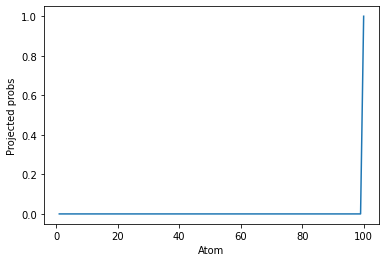

Episode 190: 	Actor Loss: -4.94 	Critic Loss: 0.15 
		Average Score: 278.92

SCORES (this eps):  [106.22010231 309.57628728 430.28593462 131.9223158  167.37346058
 445.35248653 472.70909539  32.23058321 452.66156528 406.47024637
  85.95417654  37.61408391] 



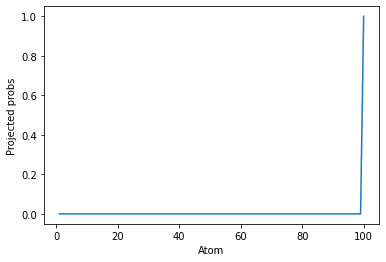

Episode 200: 	Actor Loss: -4.95 	Critic Loss: 0.13 
		Average Score: 301.40

SCORES (this eps):  [437.40626552 431.37104582 286.77310237 195.12896512  98.29427306
  58.62532557 453.52428969  10.08000634 102.99582645 148.85843539
 436.588908    31.34533993] 



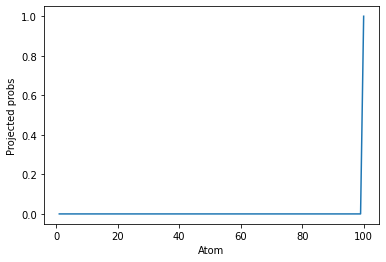

Episode 210: 	Actor Loss: -4.95 	Critic Loss: 0.13 
		Average Score: 322.07

SCORES (this eps):  [ 11.20525886 405.8509133   87.89770785 450.65011414  75.98401749
 323.13648268 423.25791069 437.82603527 418.82526053 429.56155316
 352.1827785  436.16426362] 



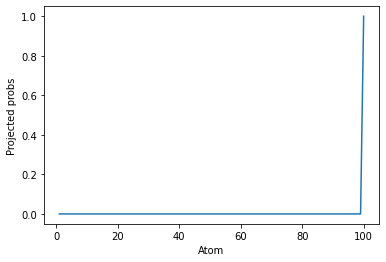

Episode 220: 	Actor Loss: -4.95 	Critic Loss: 0.13 
		Average Score: 303.45

SCORES (this eps):  [419.50549867 297.22935486 431.12486884 423.08474673 393.110287
 411.9530874  456.97488049  35.57642963 425.57558119  85.40516553
 423.91033971 431.70751427] 



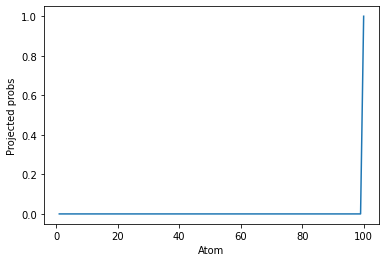

Episode 230: 	Actor Loss: -4.95 	Critic Loss: 0.13 
		Average Score: 323.86

SCORES (this eps):  [398.26592978 414.46992195 140.83946697 205.06808377 264.34378819
 427.44507376 434.96732138 432.21965719 432.24208458 436.54610337
  54.69159324 434.93815837] 



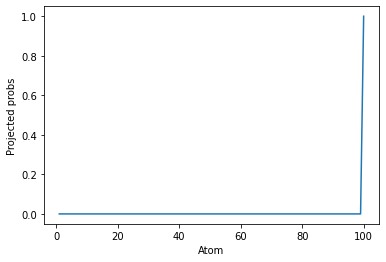

Episode 240: 	Actor Loss: -4.95 	Critic Loss: 0.12 
		Average Score: 307.18

SCORES (this eps):  [408.1201512   89.74254757  19.48443592 420.41788371 422.35290949
  92.33084843 414.44924545 128.38183069  57.55329898 407.30596712
  64.75802814 402.82300364] 



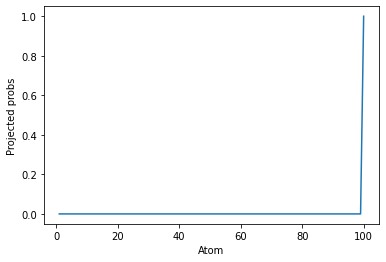

Episode 250: 	Actor Loss: -4.96 	Critic Loss: 0.11 
		Average Score: 317.74

SCORES (this eps):  [393.63903549 409.71289249  11.47816492  37.23171596 191.46473874
  35.39209949 432.16086627 404.02444933 443.4177607  421.53584823
  34.03495708 375.27283054] 



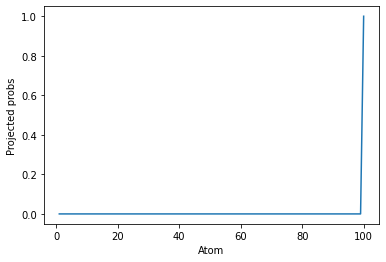

Episode 255\ Score: 306.98

==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([1.2547e-04, 1.1087e-02, 5.4526e-01, 9.1509e-01, 7.4304e-01, 6.4024e-01,
        7.0214e-01, 6.7587e-01, 8.1609e-01, 6.2540e-01, 9.7593e-05, 5.2847e-01,
        4.8200e-01, 3.8870e-01, 3.7212e-01, 4.1871e-01, 3.7937e-01, 9.7593e-05,
        5.4329e-01, 5.1826e-01, 4.3539e-01, 3.5088e-01, 3.9139e-01, 3.7765e-01,
        4.0028e-01, 4.2233e-01, 4.1147e-01, 4.1352e-01, 3.8711e-01, 9.7593e-05,
        3.5289e-01, 3.4053e-01, 4.9660e-01, 4.5127e-01, 4.1064e-01, 3.7138e-01,
        4.3053e-01, 3.4518e-01, 4.7736e-01, 5.4230e-01, 4.5977e-01, 3.9804e-01,
        9.7593e-05, 9.7593e-05, 4.1075e-01, 9.7593e-05, 5.4726e-01, 5.0424e-01,
        4.6783e-01, 3.6834e-01, 3.9312e-01, 3.7582e-01, 4.1342e-01, 4.3157e-01,
        4.1883e-01, 3.9979e-01, 4.0847e-01, 9.7593e-05, 3.8014e-01, 3.5034e-01,
        5.2901e-01, 4.6733e-01, 4.0976e-01, 3.7360e-01, 4.4949e-01, 4.0416

Actor/bn2.bias Parameter containing:
tensor([-8.5918e-03,  4.0760e-04, -2.1055e-04, -1.8584e-02, -1.4872e-02,
         7.3109e-04, -1.3886e-02, -1.4678e-02, -2.6921e-02, -1.6717e-02,
        -3.1736e-03, -1.4788e-02,  3.0246e-02, -2.3312e-02, -1.1326e-02,
        -8.8819e-03, -2.2754e-02, -1.1445e-02, -1.0444e-02, -1.8545e-02,
         2.8739e-02, -9.7279e-03, -1.7933e-03, -1.6027e-02, -2.1404e-02,
        -5.1214e-02, -1.9102e-02, -1.4915e-02, -1.4821e-02,  3.6993e-03,
        -1.3903e-02, -2.3204e-03, -1.2880e-02, -1.6006e-02, -4.8579e-03,
        -2.0277e-02, -4.4969e-03, -1.0201e-02, -4.2019e-02, -1.5682e-02,
        -8.7574e-03, -1.7494e-02, -1.3824e-02, -3.9230e-03, -1.4395e-02,
        -5.6327e-03, -1.5186e-02, -1.9943e-02, -1.8511e-02, -2.9643e-02,
        -1.9141e-02, -2.1494e-02,  1.0568e-03, -2.1284e-02, -1.2611e-02,
         9.6577e-03, -9.1738e-03, -3.6465e-02, -1.2357e-02,  3.3587e-03,
        -1.0106e-02, -1.1438e-02, -1.7541e-02, -6.4658e-03, -2.2305e-02,
        -1.625

Critic/bn1.bias Parameter containing:
tensor([ 6.6073e-02, -3.3916e-02, -4.4514e-02, -4.1041e-02, -3.1898e-02,
        -9.6882e-03, -6.2811e-02,  8.9416e-02, -5.5508e-02,  7.3364e-02,
        -3.5520e-02, -1.3822e-01,  5.9050e-02, -1.3860e-01,  3.3609e-02,
         1.3714e-02, -2.2263e-01,  5.2547e-02,  4.8475e-03, -4.0699e-02,
        -3.7510e-02,  1.7744e-01,  9.2279e-02, -6.2861e-02,  3.4752e-02,
        -6.9522e-02,  1.6051e-01, -1.8484e-01, -7.6526e-05, -1.9493e-01,
         1.0782e-01,  2.8557e-02,  3.5969e-01,  7.6227e-02, -5.3342e-02,
         8.0747e-02,  3.4840e-03,  2.7874e-01, -4.9664e-03, -2.8060e-02,
        -7.7052e-02, -1.1405e-01,  1.2100e-01,  3.1364e-02,  3.0234e-02,
        -5.7427e-02,  2.5657e-04,  2.4697e-02, -1.0220e-01,  4.1369e-02,
         1.0749e-01, -5.2825e-02,  5.2304e-02,  8.0243e-03,  3.4759e-02,
         8.8178e-03, -1.8076e-01, -8.1479e-02,  5.2492e-03,  1.6981e-01,
         4.3106e-02,  2.3452e-02, -5.8292e-03,  6.9240e-03, -8.7515e-02,
         9.55

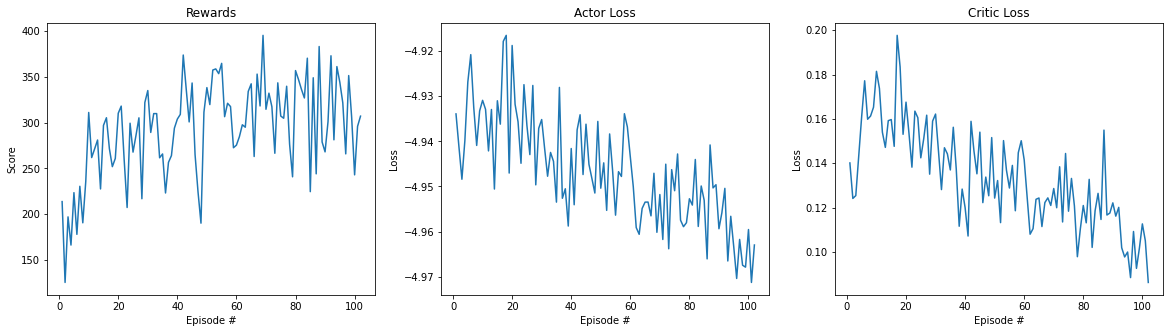

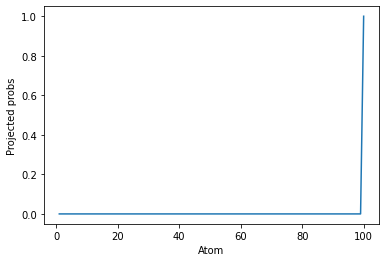

[213.64718425906418,
 125.3406277213168,
 196.9657710583415,
 166.17868986873268,
 223.43113685116018,
 177.89346397996027,
 230.3821369060121,
 190.47661393430704,
 235.5301377569946,
 311.01622027612757,
 261.7633311083385,
 271.2385544395074,
 280.91854885797756,
 227.48974428341413,
 296.9129464243694,
 305.2501363068198,
 271.44571323044755,
 251.83423377022459,
 260.8017542869008,
 310.17136515424744,
 317.96793286669225,
 259.46866165745695,
 207.21231709921267,
 299.2780427444377,
 267.70282172737643,
 285.95497917663306,
 305.1596895221931,
 216.78290018726452,
 321.9116078013515,
 334.9540625279381,
 289.2018026160076,
 309.7760600481027,
 309.7785533935142,
 261.5134380579305,
 265.6849687253125,
 223.0731126537721,
 256.5308614844883,
 263.88852308597416,
 293.86164735762094,
 303.7735140043466,
 308.906122871597,
 373.76344085655484,
 336.7268095755717,
 300.6916096879868,
 343.20446828294854,
 264.88797488055815,
 224.24931527072718,
 190.0898680811127,
 311.2926089996472

In [65]:
##################
# Continue training for +300 score
##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=3000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=100000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-6                     # 10x less
params.lr_critic = 1e-5                    # 10x less
params.vmin = -5
params.vmax = 5
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size =2048
params.gradient_clip = 0.25                # 1/4 original
params.optimizer_eps = 1e-5
params.action_noise_theta = 0.075          # 1/2 original
params.action_noise_sigma = 0.1            # 1/2 original
        
params.restart_training = False
params.eps_to_resume_from = 146
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_5_longest'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_5_longest'
params.actor_weights_filename_to_resume = 'checkpoint_actor_ep145.pth'
params.critic_weights_filename_to_resume = 'checkpoint_critic_ep145.pth'

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  7.5e-06
LR_CRITIC:  2.5e-05
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -75
VMAX:  75
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 100008 / 100000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 110: 	Actor Loss: -15.30 	Critic Loss: 2.22 
		Average Score: 33.95

SCORES (this eps):  [  9.01957166  32.52900244 185.43664344  16.91552888  65.55303475
  24.4036549    4.39782109  55.84587463  29.74130679  14.97966806
  15.81132808   0.84056999] 



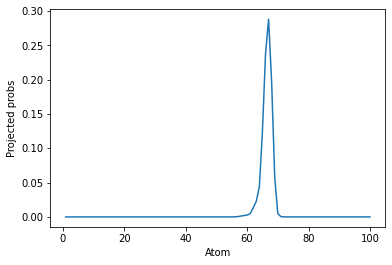

Episode 120: 	Actor Loss: -15.64 	Critic Loss: 2.18 
		Average Score: 48.06

SCORES (this eps):  [ 46.10663908   0.9514909   63.12385545 155.51823637  78.00520425
  34.84647323  47.86478631  86.71898408  21.21581005  42.18477718
  36.53172941  42.15141886] 



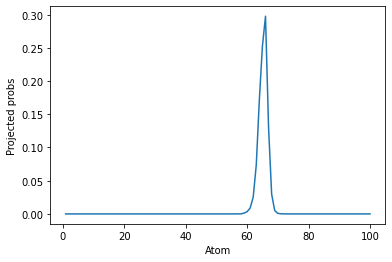

Episode 130: 	Actor Loss: -16.39 	Critic Loss: 2.12 
		Average Score: 64.03

SCORES (this eps):  [4.42367883e+01 9.63496358e+00 7.15168881e+01 2.74976304e+02
 7.11466508e+01 1.14932656e+02 1.38581929e+02 5.69304542e+01
 5.95084115e+01 7.47591608e+01 9.67833931e+00 2.37669025e-01] 



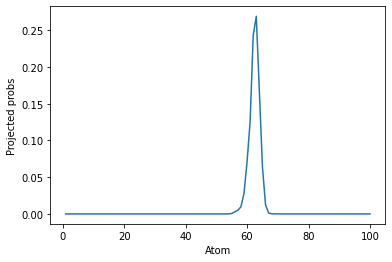

Episode 140: 	Actor Loss: -17.25 	Critic Loss: 2.11 
		Average Score: 63.45

SCORES (this eps):  [ 18.33983655  25.75328328  23.77969015  64.47568334  16.69994864
  12.36770866  45.41186971  62.0022955    3.00815875   0.21103354
   9.4149688  173.63429905] 



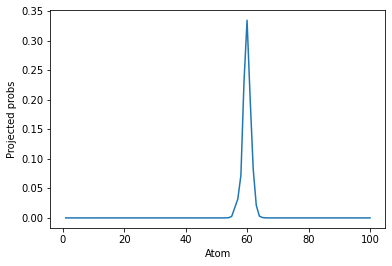

Episode 150: 	Actor Loss: -17.93 	Critic Loss: 2.15 
		Average Score: 67.60

SCORES (this eps):  [ 80.52237464  34.5909635    3.36090041   2.10693493   6.03590865
  83.50398484 164.68847062 187.42380398 148.63054506  21.7473181
  72.30124916  80.80528583] 



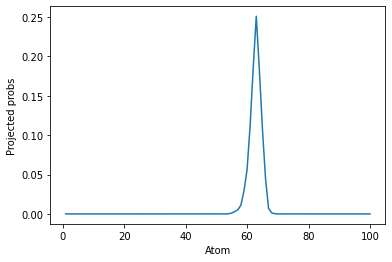

Episode 157\ Score: 106.75Errorneously low Reward = -30.02 Found! Doing nothing...
[1.0711873769760132, 1.2377375364303589, -30.018836975097656, 1.0901840925216675, 0.6037709712982178, 1.157069206237793, 0.5468171834945679, 1.1050103902816772, 0.49725228548049927, 1.3293153047561646, 1.36756432056427, 1.3069405555725098]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.17 Found! Doing nothing...
[1.07693350315094, 1.3690177202224731, -30.166749954223633, 1.2828216552734375, 0.5779405832290649, 1.08780837059021, 0.5747736096382141, 1.1441562175750732, 0.3606957197189331, 1.1396708488464355, 1.1487840414047241, 1.1900869607925415]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.29 Found! Doing nothing...
[0.9566349387168884, 1.25108003616333, -30.285049438476562, 1.0717483758926392, 0.42276012897491455, 1.0945172309875488, 0.6302255392074585, 1.1471621990203857, 0.4547744691371918, 1.22526216506958, 1.1896305084228516, 1.083559513092041]
SKIPPING TRAINING

Errorneously low Reward = -33.77 Found! Doing nothing...
[1.5257575511932373, 1.331203818321228, -33.77359390258789, 1.5707347393035889, -0.9393613934516907, 0.5868422389030457, 0.8841081857681274, 0.4982234537601471, 1.2500172853469849, 0.9264384508132935, 0.8025425672531128, 1.0193631649017334]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.86 Found! Doing nothing...
[1.700405478477478, 1.406368613243103, -33.86274337768555, 1.421850323677063, 0.00033721793442964554, 0.52295982837677, 0.9788780212402344, 0.482088178396225, 1.2933902740478516, 0.7252455353736877, 0.6876661777496338, 0.9819475412368774]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.98 Found! Doing nothing...
[1.631758689880371, 1.4346739053726196, -33.97564697265625, 1.6046079397201538, 0.08772490173578262, 0.5801361203193665, 1.0233908891677856, 0.48544129729270935, 1.1900441646575928, 0.747437059879303, 0.780272901058197, 1.0910395383834839]
SKIPPING TRAINING OF THIS TIMESTEP
Erro

Errorneously low Reward = -37.02 Found! Doing nothing...
[0.927746057510376, 1.2008647918701172, -37.02427673339844, 0.4109359085559845, 1.3700982332229614, 1.62386953830719, 1.127109408378601, 0.9468011856079102, 1.4099583625793457, 0.2952038645744324, 0.9472717046737671, 1.024178385734558]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -37.15 Found! Doing nothing...
[0.8973892331123352, 1.1692839860916138, -37.148475646972656, 0.37279096245765686, 1.4301894903182983, 1.560675024986267, 1.016405701637268, 1.0309655666351318, 1.479151725769043, 0.5897783637046814, 0.8380231857299805, 1.048434853553772]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -37.33 Found! Doing nothing...
[0.8885066509246826, 1.0740855932235718, -37.33112716674805, 0.4075544774532318, 1.3167636394500732, 1.281744360923767, 1.130324125289917, 1.0409595966339111, 1.5397140979766846, 0.3741292357444763, 0.7566014528274536, 1.0145364999771118]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneous

Errorneously low Reward = -40.53 Found! Doing nothing...
[0.8970259428024292, 0.6839401721954346, -40.53470993041992, 1.2594332695007324, 1.2721476554870605, 0.5765652656555176, 0.1008419618010521, 1.3850467205047607, 1.1915780305862427, 1.1095359325408936, 0.05841153860092163, 1.0296086072921753]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -40.61 Found! Doing nothing...
[0.9823572635650635, 0.7338110208511353, -40.6109504699707, 1.144349455833435, 1.1687445640563965, 0.4722643494606018, -0.023046458140015602, 1.281851887702942, 0.8936276435852051, 1.2881401777267456, 0.07441271096467972, 1.0520378351211548]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -40.80 Found! Doing nothing...
[1.2193223237991333, 0.8071417212486267, -40.80131912231445, 1.2145150899887085, 1.4881631135940552, 0.7271357774734497, 0.11684153974056244, 1.2825536727905273, 1.1720415353775024, 1.6034877300262451, 0.1246243268251419, 1.1095170974731445]
SKIPPING TRAINING OF THIS TIMESTE

Errorneously low Reward = -43.91 Found! Doing nothing...
[0.07991930842399597, 1.4671313762664795, -43.9128532409668, 0.34424686431884766, 1.0059372186660767, 0.14230993390083313, 1.4516810178756714, 0.41054102778434753, 1.3624271154403687, 0.9022105932235718, 1.3789594173431396, 1.0607681274414062]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -44.02 Found! Doing nothing...
[0.10551998764276505, 1.331934928894043, -44.017208099365234, 0.6674429774284363, 1.0858348608016968, 0.09631966054439545, 1.4683603048324585, 0.3801213502883911, 1.2101174592971802, 1.0123090744018555, 1.3310900926589966, 1.0507198572158813]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -44.11 Found! Doing nothing...
[0.05909119173884392, 1.2507076263427734, -44.11083984375, 1.1832846403121948, 1.0604135990142822, 0.02693641185760498, 1.4259494543075562, 0.5095673203468323, -1.0, 0.8393481969833374, 1.4659838676452637, 1.120314598083496]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously

Errorneously low Reward = -47.12 Found! Doing nothing...
[1.3084417581558228, 0.8858879208564758, -47.12392807006836, 1.5761234760284424, 1.4250106811523438, 1.2464094161987305, 1.2104979753494263, 0.9857598543167114, 0.6347022652626038, 0.9943742752075195, 0.855425238609314, 0.9018682837486267]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -47.25 Found! Doing nothing...
[1.2831732034683228, 1.0119338035583496, -47.25201416015625, 1.531582236289978, 1.4612812995910645, 1.1407889127731323, 1.1749191284179688, 1.2113529443740845, 0.7068555951118469, 0.886104166507721, 1.0486598014831543, 1.0099847316741943]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -47.40 Found! Doing nothing...
[1.5762828588485718, 1.0198365449905396, -47.40259552001953, 1.546288251876831, 1.4791045188903809, 1.2459642887115479, 1.1794495582580566, 0.875122606754303, 0.6016860008239746, 0.9944604635238647, 0.9961444735527039, 1.094460368156433]
SKIPPING TRAINING OF THIS TIMESTEP
Errorne

Errorneously low Reward = -50.44 Found! Doing nothing...
[1.1220176219940186, 0.4552913308143616, -50.4379768371582, 1.199385643005371, 0.3128962218761444, 1.187917947769165, 1.498720407485962, 1.6030491590499878, 1.127817988395691, 1.1651253700256348, 0.7468005418777466, 1.1903363466262817]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -50.56 Found! Doing nothing...
[1.0919731855392456, 0.5897068977355957, -50.5622444152832, 1.0655784606933594, 0.2897942364215851, 1.27467679977417, 1.5795506238937378, 1.4310436248779297, 1.1480196714401245, 1.1695224046707153, 0.8453329801559448, 1.2270997762680054]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -50.63 Found! Doing nothing...
[1.0427452325820923, 1.095895767211914, -50.62685775756836, 1.1047377586364746, 0.32268691062927246, 1.380696177482605, 1.4044251441955566, 1.487328290939331, 1.1888352632522583, 1.123233675956726, 0.717835545539856, 1.2421014308929443]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously 

Errorneously low Reward = -53.77 Found! Doing nothing...
[0.22049842774868011, 0.13973714411258698, -53.767120361328125, 0.7294754981994629, 1.2601882219314575, 1.4105150699615479, 0.2701278328895569, 0.5286788940429688, 0.5112550854682922, 1.1913503408432007, 1.4909945726394653, 1.2208763360977173]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -53.92 Found! Doing nothing...
[-0.029715321958065033, 0.09683030843734741, -53.919151306152344, 0.8213464021682739, 1.3203272819519043, 1.4595633745193481, 0.4293328523635864, 0.5560277700424194, 0.794887363910675, 1.2370104789733887, 1.4852863550186157, 1.2477799654006958]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -54.03 Found! Doing nothing...
[0.0526566244661808, 0.07927762717008591, -54.032012939453125, 0.4919123351573944, 1.4114748239517212, 1.4575839042663574, 0.4080561101436615, 0.5635537505149841, 1.024757742881775, 1.24897301197052, 1.3562322854995728, 1.1534150838851929]
SKIPPING TRAINING OF THIS TIME

Errorneously low Reward = -57.07 Found! Doing nothing...
[0.959221363067627, 1.025077223777771, -57.071197509765625, 0.5793589949607849, 0.8790370225906372, 1.3989068269729614, 1.2441471815109253, 1.2691199779510498, 0.7637915015220642, 0.8666898012161255, 0.9763153791427612, 0.476856529712677]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -57.25 Found! Doing nothing...
[1.1540247201919556, 0.9252609610557556, -57.24507522583008, 0.7915747165679932, 1.1126657724380493, 1.407232403755188, 1.226683497428894, 1.235133409500122, 0.8847180008888245, 0.788355827331543, 1.0359135866165161, 0.7249923348426819]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -57.30 Found! Doing nothing...
[0.9999199509620667, 1.0058342218399048, -57.297271728515625, 0.7160868048667908, 1.032954454421997, 1.0746779441833496, 1.403753638267517, 0.9396911263465881, 0.8241094350814819, 0.7441194653511047, 1.047621250152588, 0.8246738910675049]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneou

Errorneously low Reward = -60.28 Found! Doing nothing...
[0.32501569390296936, 0.9987592101097107, -60.280460357666016, 0.9795694351196289, 1.0726279020309448, 1.0638877153396606, 0.9483602046966553, 0.7221788763999939, 0.9108086824417114, 1.0859932899475098, 0.39187538623809814, 0.7400677800178528]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -60.40 Found! Doing nothing...
[0.15527792274951935, 0.9640945792198181, -60.40255355834961, 1.1986557245254517, 1.0891697406768799, 1.0828355550765991, 0.9513960480690002, 0.5837075114250183, 0.8989973664283752, 1.058853268623352, 0.45129719376564026, 0.5684987306594849]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -60.45 Found! Doing nothing...
[0.19894415140151978, 0.932887077331543, -60.452701568603516, 0.9313852190971375, 0.9734912514686584, 1.1356899738311768, 0.7011045217514038, 0.5431936979293823, 0.9927912354469299, 1.2270655632019043, 0.45713844895362854, 0.6814488172531128]
SKIPPING TRAINING OF THIS TIME

Errorneously low Reward = -63.47 Found! Doing nothing...
[0.8480424880981445, 1.3337812423706055, -63.47457504272461, 0.31102848052978516, 1.3343859910964966, 1.271591305732727, 0.3114689588546753, 1.4524009227752686, 0.781583309173584, 0.17400707304477692, 1.6108078956604004, 1.3254680633544922]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -63.60 Found! Doing nothing...
[0.9384663105010986, 1.4290494918823242, -63.60318374633789, 0.4721663296222687, 1.3643380403518677, 1.2800980806350708, 0.46027320623397827, 1.3734633922576904, 0.662036120891571, 0.08033570647239685, 1.4487285614013672, 1.38034188747406]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -63.62 Found! Doing nothing...
[1.0156550407409668, 1.4414969682693481, -63.62210464477539, 0.7676951289176941, 1.534712791442871, 1.4193226099014282, 0.5718390345573425, 1.3810837268829346, 0.6932269334793091, 0.6566996574401855, 1.4766640663146973, 1.2611653804779053]
SKIPPING TRAINING OF THIS TIMESTEP
Err

Errorneously low Reward = -66.75 Found! Doing nothing...
[0.30049562454223633, 0.6853238940238953, -66.75225830078125, 0.09896425902843475, 0.5896844863891602, 1.5951189994812012, 1.0658714771270752, 1.8463143110275269, 1.2309815883636475, 1.2490434646606445, 1.5838292837142944, 0.602889895439148]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -66.84 Found! Doing nothing...
[0.2420315146446228, 1.0232973098754883, -66.83590698242188, 0.121001236140728, 0.5644139647483826, 1.5699208974838257, 1.2817182540893555, 1.6556909084320068, 1.3610661029815674, 0.787691593170166, 1.5218595266342163, 0.7218858003616333]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -66.87 Found! Doing nothing...
[0.2693396806716919, 1.0857117176055908, -66.87198638916016, 0.19202812016010284, 0.609142005443573, 1.4824529886245728, 1.2903116941452026, 1.5397666692733765, 1.4995815753936768, 1.123308539390564, 1.6360739469528198, 1.0218980312347412]
SKIPPING TRAINING OF THIS TIMESTEP
Err

Errorneously low Reward = -69.89 Found! Doing nothing...
[0.304207444190979, 1.1085187196731567, -69.88862609863281, 0.47335997223854065, 1.3484219312667847, 1.6738914251327515, 0.7812880873680115, 0.37105709314346313, 0.052876174449920654, 1.289912223815918, 0.025225095450878143, 0.7269282937049866]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -69.98 Found! Doing nothing...
[0.3848305344581604, 1.1513471603393555, -69.98146057128906, 0.44342976808547974, 1.1774258613586426, 1.7470972537994385, 0.8772268891334534, 0.4038502871990204, 0.1743667721748352, 1.376290202140808, 0.09874952584505081, 0.6472868919372559]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -70.07 Found! Doing nothing...
[1.119327425956726, 1.3182789087295532, -70.06864166259766, 0.4067264795303345, 1.1477103233337402, 1.68010675907135, 0.9168394804000854, 0.5397423505783081, 0.5169644355773926, 1.4334756135940552, 0.1751968264579773, 0.7536797523498535]
SKIPPING TRAINING OF THIS TIMESTEP

Errorneously low Reward = -72.92 Found! Doing nothing...
[1.0852454900741577, 0.9642490744590759, -72.92449188232422, 1.079307198524475, 1.4412903785705566, 1.1617217063903809, 0.3819584250450134, 1.058118224143982, 0.9847039580345154, 1.327952265739441, 0.7192399501800537, 0.19626718759536743]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -73.04 Found! Doing nothing...
[1.0108821392059326, 1.2185664176940918, -73.04071807861328, 0.949482262134552, 1.5169861316680908, 1.3591936826705933, 0.5669817924499512, 1.1648633480072021, 1.0163285732269287, 1.3865611553192139, 0.5868654847145081, 0.38153767585754395]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -73.16 Found! Doing nothing...
[0.9031388163566589, 1.2966070175170898, -73.16118621826172, 1.4002938270568848, 1.5814136266708374, 1.236016869544983, 0.5675251483917236, 1.0865999460220337, 1.0156065225601196, 1.484026312828064, 0.6606987714767456, 0.3483901917934418]
SKIPPING TRAINING OF THIS TIMESTEP
Error

Errorneously low Reward = -76.02 Found! Doing nothing...
[1.647391438484192, 0.8543617129325867, -76.02063751220703, 1.1098551750183105, 0.989791750907898, 1.1269257068634033, -0.00850366335362196, 0.8442874550819397, 1.1351473331451416, 1.6377993822097778, 1.2654459476470947, 1.6174736022949219]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -76.12 Found! Doing nothing...
[1.6676040887832642, 0.6450770497322083, -76.12218475341797, 1.0946593284606934, 1.0893933773040771, 1.1602998971939087, 0.4419080317020416, 0.7660804986953735, 1.15109121799469, 1.917898178100586, 1.2942463159561157, 1.3659342527389526]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -76.19 Found! Doing nothing...
[1.4368170499801636, 0.8030150532722473, -76.1915054321289, 1.2489771842956543, 1.1903918981552124, 0.8908570408821106, 0.6117135882377625, 0.7821204662322998, 0.878926157951355, 2.092517375946045, 1.3417083024978638, 1.147754430770874]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneo

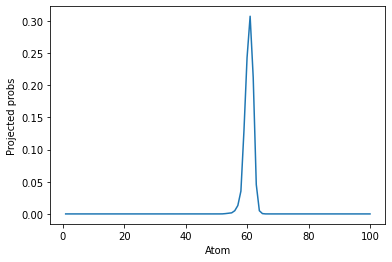

Episode 163\ Score: 42.35Errorneously low Reward = -30.07 Found! Doing nothing...
[1.1718312501907349, 0.9031187295913696, -30.06992530822754, 1.1910572052001953, 0.7385856509208679, 0.9536879062652588, 0.3548901081085205, 1.0054875612258911, 1.277430534362793, 0.8333184123039246, 0.9038541913032532, 0.27116698026657104]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.33 Found! Doing nothing...
[-1.0, 0.9822156429290771, -30.326929092407227, 1.236166000366211, 0.8611689805984497, 0.9822127819061279, 0.4877713918685913, 1.095885992050171, 1.2534235715866089, 0.6804413199424744, 1.1088656187057495, 0.7087039947509766]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.37 Found! Doing nothing...
[0.06258399039506912, 1.0282021760940552, -30.372089385986328, 1.292362093925476, 0.7935410141944885, 1.1597068309783936, 0.8395379185676575, 1.0359324216842651, -1.0, 0.5503212809562683, 1.0602985620498657, 0.7544959783554077]
SKIPPING TRAINING OF THIS TIMESTEP
Erro

Errorneously low Reward = -33.76 Found! Doing nothing...
[0.5996459722518921, 0.14835287630558014, -33.75741958618164, 1.063431978225708, 0.8733344078063965, 1.4930527210235596, 0.811433732509613, 0.44445857405662537, 1.1233246326446533, 1.0462262630462646, 1.2919058799743652, 0.7423514127731323]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.90 Found! Doing nothing...
[0.5751986503601074, 0.06644437462091446, -33.900272369384766, 1.127314805984497, 0.9784011244773865, 1.867634892463684, 0.6917388439178467, 0.33991941809654236, 1.2295823097229004, 1.1263569593429565, 1.1918258666992188, 0.805449366569519]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -34.12 Found! Doing nothing...
[0.6479437947273254, 0.020934466272592545, -34.124629974365234, 1.2867122888565063, 0.929193913936615, 1.4288448095321655, 0.7697907090187073, 0.3480480909347534, 1.2537531852722168, 1.1884608268737793, 1.418424367904663, 0.8286477327346802]
SKIPPING TRAINING OF THIS TIMESTEP


Errorneously low Reward = -37.36 Found! Doing nothing...
[1.1255112886428833, 1.0690522193908691, -37.358863830566406, 0.6253482699394226, 1.6013306379318237, 0.9984421133995056, 0.5204242467880249, 1.0582705736160278, 0.8877492547035217, 1.0201661586761475, 0.29981788992881775, 1.2421053647994995]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -37.48 Found! Doing nothing...
[0.9313063025474548, 0.955855667591095, -37.47793960571289, 0.5191754698753357, 1.4403773546218872, 0.8606569766998291, 0.5161893367767334, 1.0286600589752197, -1.0, 1.0876848697662354, 0.28181204199790955, 1.1867499351501465]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -37.57 Found! Doing nothing...
[0.9902295470237732, 1.0544403791427612, -37.573158264160156, 0.6082460284233093, 1.4362019300460815, 0.8172819018363953, 0.5475162267684937, 1.055872917175293, 0.10448680073022842, 1.028213620185852, 0.19553156197071075, 1.353259563446045]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously 

Errorneously low Reward = -40.60 Found! Doing nothing...
[1.059256672859192, 1.4761021137237549, -40.6026725769043, 1.2366372346878052, 1.2668424844741821, 0.06758037209510803, -0.016133492812514305, 0.9794259071350098, 0.9814839363098145, 1.0705161094665527, 0.9903796911239624, 1.1409331560134888]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -40.68 Found! Doing nothing...
[1.0510705709457397, 1.571110486984253, -40.677215576171875, 1.2719736099243164, 1.1947038173675537, 0.09772603213787079, -0.028276361525058746, 1.0943464040756226, 1.0050753355026245, 0.9995097517967224, 1.0752028226852417, 1.1026155948638916]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -40.87 Found! Doing nothing...
[1.2193390130996704, 1.5842074155807495, -40.868736267089844, 1.0796308517456055, 1.2729718685150146, 0.08962106704711914, -0.03137988597154617, 1.0592488050460815, 1.2813020944595337, 0.9740753769874573, 1.0064241886138916, 0.9670062065124512]
SKIPPING TRAINING OF THIS 

Errorneously low Reward = -43.86 Found! Doing nothing...
[1.4184560775756836, 0.8312154412269592, -43.85953140258789, 0.8775137066841125, 1.4507380723953247, 0.8524388670921326, 0.9996051788330078, 0.2534152865409851, 0.7853986024856567, 1.575726866722107, -0.07941275835037231, 0.5358592867851257]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -43.97 Found! Doing nothing...
[1.3672826290130615, 1.0357130765914917, -43.967559814453125, 0.6147304177284241, 1.2462190389633179, 0.9934599995613098, 0.8958736658096313, 0.27744701504707336, 0.9829999804496765, 1.3322101831436157, 0.35987627506256104, 0.5264440178871155]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -44.09 Found! Doing nothing...
[1.4833762645721436, 0.907385528087616, -44.085514068603516, 0.7958016395568848, 1.1312583684921265, 1.0998785495758057, 0.9419203400611877, 0.49857375025749207, 0.812942385673523, 1.0994492769241333, 0.46478575468063354, 0.6029855012893677]
SKIPPING TRAINING OF THIS TIMES

Errorneously low Reward = -46.93 Found! Doing nothing...
[1.1860071420669556, 0.10041418671607971, -46.92942428588867, 0.893325686454773, 1.487876534461975, 0.8872231841087341, 0.5518924593925476, 1.4131394624710083, 0.6985087394714355, 0.41928789019584656, 1.0205961465835571, 0.11788102239370346]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -46.96 Found! Doing nothing...
[1.2227967977523804, 0.07084589451551437, -46.962589263916016, 0.8952943682670593, 1.3239679336547852, 0.8871797323226929, 0.6831153035163879, 1.5012074708938599, 0.6444122791290283, 0.5437513589859009, 1.0009100437164307, 0.03797028213739395]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -47.06 Found! Doing nothing...
[1.2971781492233276, 0.22193899750709534, -47.05983352661133, 0.8376948237419128, 1.4119789600372314, 1.0178409814834595, 0.9475657343864441, 1.5229612588882446, 0.7778065204620361, 0.39480099081993103, 0.5919851660728455, 0.2902630567550659]
SKIPPING TRAINING OF THIS TIME

Errorneously low Reward = -49.92 Found! Doing nothing...
[1.259541630744934, 1.0444564819335938, -49.9180908203125, 0.7510746121406555, 1.1331110000610352, 1.2066388130187988, 0.5340137481689453, 1.1354634761810303, 1.057294487953186, 1.0089442729949951, 0.9532565474510193, 0.9287818074226379]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -50.02 Found! Doing nothing...
[1.290492057800293, 1.102879285812378, -50.01884460449219, 0.8315889239311218, 1.2857210636138916, 1.1710833311080933, 0.7149101495742798, 1.0127586126327515, 1.0763576030731201, 1.0982550382614136, 0.837275505065918, 0.9721615314483643]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -50.06 Found! Doing nothing...
[1.482008457183838, 1.0541610717773438, -50.05601501464844, 0.875975489616394, 1.1678171157836914, 1.3757537603378296, 0.8027316927909851, 0.9285745024681091, 1.048823595046997, 1.0093872547149658, 1.028173565864563, 1.135980486869812]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously

Errorneously low Reward = -52.95 Found! Doing nothing...
[1.3778014183044434, 1.4024748802185059, -52.952857971191406, 1.085740089416504, 0.4961875081062317, 0.48642855882644653, 0.5485574007034302, 1.197450041770935, 1.059340000152588, 1.001807689666748, 0.6431564092636108, 1.158747911453247]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -53.11 Found! Doing nothing...
[1.5060557126998901, 1.4059910774230957, -53.11458969116211, 1.19951593875885, 0.5653567910194397, 0.4504340887069702, 0.34163904190063477, 1.0854593515396118, 0.9389559626579285, 1.0002872943878174, 0.71381676197052, 1.4286617040634155]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -53.28 Found! Doing nothing...
[1.4358327388763428, 1.4344637393951416, -53.28173065185547, 0.985150933265686, 0.35711830854415894, 0.5878171920776367, 0.266885370016098, 1.1919569969177246, 1.2138854265213013, 0.9975379109382629, 0.9163032174110413, 1.2605046033859253]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneo

Errorneously low Reward = -56.33 Found! Doing nothing...
[1.0701948404312134, 1.547917366027832, -56.32527542114258, 0.9605053067207336, 0.8413113951683044, 0.7095209360122681, 0.09276267886161804, 0.41481053829193115, 0.596245288848877, 1.2288265228271484, 1.339043140411377, 0.5134026408195496]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -56.21 Found! Doing nothing...
[0.994392991065979, 1.4838905334472656, -56.20824432373047, 0.8643543124198914, 0.9102522134780884, 0.46208512783050537, 0.0597020722925663, 0.33143386244773865, 0.9830704927444458, 0.9835318326950073, 1.1344077587127686, 0.3496257960796356]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -56.31 Found! Doing nothing...
[1.4497826099395752, 1.3809398412704468, -56.30794906616211, 1.0063140392303467, 0.944991946220398, 0.24400798976421356, 0.09921648353338242, 0.31648725271224976, 1.0102779865264893, 1.155425786972046, 1.2017366886138916, 0.4441421926021576]
SKIPPING TRAINING OF THIS TIMESTEP


Errorneously low Reward = -59.44 Found! Doing nothing...
[0.8208937048912048, 1.3194856643676758, -59.440391540527344, 1.1370983123779297, 0.25617626309394836, 0.39852267503738403, 0.7516516447067261, 1.022448182106018, 1.2260186672210693, 1.511723279953003, 0.3421277403831482, 0.8814743161201477]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -59.54 Found! Doing nothing...
[0.7105593681335449, 1.2964236736297607, -59.543575286865234, 1.1231967210769653, 0.13994194567203522, 0.3873516023159027, 0.6878861784934998, 0.8514121174812317, 1.2455886602401733, 1.4741020202636719, 0.39142465591430664, 1.1874680519104004]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -59.63 Found! Doing nothing...
[0.19264842569828033, 1.3973252773284912, -59.63098907470703, 1.2614283561706543, 0.11087566614151001, 0.496188223361969, 0.5773574709892273, 0.8978954553604126, 1.2690420150756836, 1.6043521165847778, 0.36829403042793274, 1.2477692365646362]
SKIPPING TRAINING OF THIS TIME

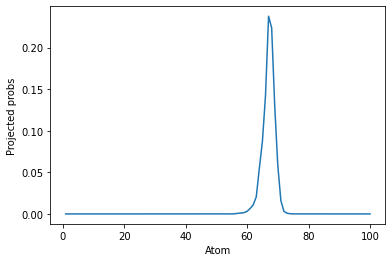

Errorneously low Reward = -30.06 Found! Doing nothing...
[1.2018616199493408, 1.3458209037780762, -30.06001091003418, 0.6362014412879944, 1.116303563117981, 1.2405924797058105, 1.193435549736023, 1.1668717861175537, 1.674452781677246, 1.158381462097168, 1.3750324249267578, 1.0308175086975098]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.15 Found! Doing nothing...
[1.244682788848877, 1.4579445123672485, -30.15499496459961, 0.4887460768222809, 1.2669025659561157, 0.9962021708488464, 1.0177654027938843, 1.1119613647460938, 1.5179835557937622, 1.0815986394882202, 1.4096736907958984, 0.9150159358978271]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.31 Found! Doing nothing...
[1.1000686883926392, 1.5755611658096313, -30.31132698059082, 0.9267848134040833, 1.633863091468811, 1.0438730716705322, -0.8138277530670166, 1.2247291803359985, 1.6622482538223267, 1.294740080833435, 1.5690279006958008, 0.9639033675193787]
SKIPPING TRAINING OF THIS TIMESTEP
Errorne

Errorneously low Reward = -33.80 Found! Doing nothing...
[0.831144392490387, 1.3837482929229736, -33.79987335205078, 1.7592437267303467, 0.9176353812217712, 1.6763256788253784, 1.1335656642913818, 1.4356380701065063, 0.7968888878822327, 0.3566614091396332, 1.2074437141418457, 1.2000148296356201]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.90 Found! Doing nothing...
[1.2260730266571045, 1.6222676038742065, -33.89799880981445, 1.5613980293273926, 1.0540391206741333, 1.4338352680206299, 1.0538479089736938, 1.261962890625, 0.8647187352180481, 0.38101857900619507, 1.2976592779159546, 1.2614574432373047]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.97 Found! Doing nothing...
[1.13253915309906, 1.6803282499313354, -33.97162628173828, 1.5302399396896362, 1.3553013801574707, 1.538578987121582, 1.0481003522872925, 1.2261227369308472, 0.6862414479255676, 0.590431809425354, 1.2809942960739136, 1.1291313171386719]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneou

Errorneously low Reward = -37.25 Found! Doing nothing...
[1.4257593154907227, 1.6210945844650269, -37.2463493347168, 1.3791821002960205, 1.0254333019256592, 1.642930030822754, 1.0854878425598145, 0.4335887134075165, 0.5312948822975159, 1.048315167427063, 0.865501880645752, 1.7469068765640259]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -37.39 Found! Doing nothing...
[1.3048489093780518, 1.3532465696334839, -37.390769958496094, 1.440538763999939, 1.1184375286102295, 1.6920599937438965, 1.1829416751861572, 0.44416543841362, 0.44424551725387573, 1.1316015720367432, 0.9072606563568115, 1.424102783203125]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -37.52 Found! Doing nothing...
[1.4910143613815308, 1.6082526445388794, -37.52490234375, 1.4131779670715332, 1.0832046270370483, 1.7011666297912598, 1.0023553371429443, 0.5505675077438354, 0.47421184182167053, 1.1665754318237305, 0.8939895033836365, 1.0431575775146484]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneou

Errorneously low Reward = -40.69 Found! Doing nothing...
[0.09361210465431213, 0.2941943407058716, -40.69226837158203, 0.5297636985778809, 1.184741497039795, 1.2220488786697388, 0.7863047122955322, 1.0419909954071045, 1.5116771459579468, 0.39820340275764465, 1.527992606163025, 0.4219094514846802]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -40.80 Found! Doing nothing...
[0.10512854903936386, 0.4529123902320862, -40.80390548706055, 0.47484785318374634, 1.5405659675598145, 1.3232699632644653, 0.6503861546516418, 1.0913342237472534, 1.7818377017974854, 0.4188259243965149, 1.480875849723816, 0.5052713751792908]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -40.94 Found! Doing nothing...
[0.36146801710128784, 0.2751014232635498, -40.93888854980469, 0.4293631613254547, 1.648444414138794, 1.329479694366455, 0.5904171466827393, 1.15662682056427, 1.5265370607376099, 0.42257848381996155, 1.5325714349746704, 0.43038487434387207]
SKIPPING TRAINING OF THIS TIMESTEP
E

Errorneously low Reward = -43.95 Found! Doing nothing...
[1.280261516571045, 0.9411448240280151, -43.94562911987305, 1.2613083124160767, 1.1173816919326782, 1.011760950088501, 0.9072885513305664, 1.3888593912124634, 1.568605899810791, 1.078060269355774, 1.6370012760162354, 1.1842269897460938]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -44.17 Found! Doing nothing...
[1.1232801675796509, 1.0757991075515747, -44.16938018798828, 1.1816785335540771, 1.0806621313095093, 0.9715595841407776, 1.1100910902023315, 1.3025699853897095, 1.4982326030731201, 1.2084786891937256, 1.650636076927185, 1.134765625]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -44.23 Found! Doing nothing...
[1.4115967750549316, 1.0871682167053223, -44.234947204589844, -0.6922823786735535, 1.064272403717041, 1.1330015659332275, 1.160722255706787, 1.330797791481018, 1.435722827911377, 1.0458052158355713, 1.5734807252883911, 1.1246873140335083]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously lo

Errorneously low Reward = -47.23 Found! Doing nothing...
[1.1148639917373657, 1.0623410940170288, -47.227684020996094, 0.5945748686790466, 1.4476147890090942, 1.3094919919967651, 0.44114258885383606, 0.695641815662384, 1.706105351448059, 1.240761399269104, 0.43825992941856384, 1.0717945098876953]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -47.30 Found! Doing nothing...
[1.3819857835769653, 0.912750780582428, -47.30051803588867, 0.5733347535133362, 1.517325758934021, 1.3578802347183228, 0.36038675904273987, 0.7577311992645264, 1.5361541509628296, 1.2525240182876587, 0.4117434322834015, 1.210490345954895]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -47.42 Found! Doing nothing...
[1.416473150253296, 1.0742745399475098, -47.42158508300781, 0.6182895302772522, 1.7073477506637573, 1.3771114349365234, 0.34074878692626953, 0.8322075605392456, 1.4969123601913452, 1.3212378025054932, 0.3081948757171631, 1.4054230451583862]
SKIPPING TRAINING OF THIS TIMESTEP
Err

Errorneously low Reward = -50.19 Found! Doing nothing...
[0.7176335453987122, 1.3743999004364014, -50.194278717041016, 0.800979733467102, 1.780817985534668, 0.9149765372276306, 0.6388141512870789, 0.6731314659118652, 0.4057023823261261, 1.048384666442871, 1.1768245697021484, 1.565382957458496]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -50.28 Found! Doing nothing...
[0.9566534161567688, 1.2013274431228638, -50.282936096191406, -0.8910191655158997, 2.011125087738037, 0.9280361533164978, 0.7959699630737305, 0.6932085752487183, 0.8394398093223572, 1.1790188550949097, 1.2080155611038208, 1.385225534439087]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -50.34 Found! Doing nothing...
[0.7347979545593262, 1.3841615915298462, -50.336856842041016, 0.10929836332798004, 2.1079468727111816, 0.8803666234016418, 0.8044565320014954, 0.941388726234436, 0.839946448802948, 1.299312949180603, 1.1933810710906982, 1.569611668586731]
SKIPPING TRAINING OF THIS TIMESTEP
Errorn

Errorneously low Reward = -53.44 Found! Doing nothing...
[0.0830952525138855, 0.15374968945980072, -53.43881607055664, 1.2982800006866455, 1.7305883169174194, 0.4839549660682678, 1.3507428169250488, 1.340316653251648, 0.8117105960845947, 1.5860682725906372, 1.2284060716629028, 1.5379866361618042]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -53.53 Found! Doing nothing...
[0.034641142934560776, -0.040658045560121536, -53.52787780761719, 1.3203527927398682, 1.8934730291366577, 0.5101603269577026, -0.7503032088279724, 1.3597642183303833, 0.840886116027832, 1.9378952980041504, 0.9645494222640991, 1.5396289825439453]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -53.61 Found! Doing nothing...
[-0.043973714113235474, 0.07443005591630936, -53.60776138305664, 1.4238768815994263, 1.795640230178833, 0.45384082198143005, 0.13634157180786133, 1.3465737104415894, 0.8914567828178406, 1.9386324882507324, 0.9869986772537231, 1.5243146419525146]
SKIPPING TRAINING OF THIS 

Errorneously low Reward = -56.46 Found! Doing nothing...
[1.4801372289657593, 1.1391500234603882, -56.45791244506836, 0.1463252604007721, 1.5977648496627808, 1.4034346342086792, 1.0144985914230347, 1.3060145378112793, 0.7584035396575928, 0.7545393705368042, 1.470771074295044, 1.328611135482788]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -56.63 Found! Doing nothing...
[1.314087152481079, 0.9822064638137817, -56.62611389160156, 0.22509266436100006, 1.6414053440093994, 1.293789029121399, 0.9646868705749512, 1.3512619733810425, 0.720729649066925, 0.9561169743537903, 1.3972489833831787, 1.3163416385650635]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -56.71 Found! Doing nothing...
[1.3541802167892456, 1.0622364282608032, -56.708465576171875, 0.5844824910163879, 1.6485936641693115, 1.292070984840393, 0.9696771502494812, 1.3432948589324951, 0.5904625654220581, 1.01091468334198, 1.5016027688980103, 1.26585054397583]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneou

Errorneously low Reward = -59.58 Found! Doing nothing...
[-0.0034188898280262947, 0.8184727430343628, -59.58208084106445, 1.2260839939117432, 0.7303891181945801, 1.1825298070907593, 0.5661513805389404, 1.1777300834655762, 1.2414913177490234, 0.1533963531255722, 1.509360671043396, -0.03733300417661667]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -59.70 Found! Doing nothing...
[0.10368841886520386, 0.9602122902870178, -59.70486068725586, 1.1937673091888428, 0.6844896674156189, 1.103318214416504, 0.7058555483818054, 1.2700482606887817, 1.1473355293273926, 0.32847774028778076, 1.3796902894973755, 0.4418378472328186]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -59.82 Found! Doing nothing...
[0.5242717862129211, 0.8244542479515076, -59.820648193359375, 1.2243043184280396, 0.669437825679779, 1.1105103492736816, 0.6317467093467712, 1.1842694282531738, 1.1259667873382568, 0.4013445973396301, 1.3624228239059448, 0.4160914123058319]
SKIPPING TRAINING OF THIS TIME

Errorneously low Reward = -62.41 Found! Doing nothing...
[1.3957533836364746, 0.19692063331604004, -62.40864181518555, 2.0095906257629395, 1.09381902217865, 1.5575878620147705, 0.4827733039855957, 1.3556809425354004, 1.2022186517715454, 1.2670769691467285, 0.8902454972267151, 1.2583054304122925]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -62.51 Found! Doing nothing...
[1.361147403717041, 0.012385115958750248, -62.51166534423828, 1.9181629419326782, 1.049917459487915, 1.5845167636871338, 0.4620678722858429, 1.469223976135254, 1.2138280868530273, 1.1685371398925781, 1.053938388824463, 0.9054915308952332]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -62.66 Found! Doing nothing...
[1.3309968709945679, 0.1490231454372406, -62.65766143798828, 1.883139729499817, 0.9708155989646912, 1.3638992309570312, 0.5404670834541321, 1.5517250299453735, 1.353920340538025, 1.3280187845230103, 1.044490933418274, 1.0619581937789917]
SKIPPING TRAINING OF THIS TIMESTEP
Errorne

Errorneously low Reward = -65.26 Found! Doing nothing...
[1.2333564758300781, 0.7194840908050537, -65.25526428222656, 1.4393806457519531, 1.1706171035766602, 1.099881649017334, 1.0209081172943115, 1.4400726556777954, 1.0445741415023804, 1.0671418905258179, 0.06456086039543152, 0.5177094340324402]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -65.36 Found! Doing nothing...
[1.1449625492095947, 0.7403066754341125, -65.35987091064453, 1.4668670892715454, 1.082889437675476, 1.0596342086791992, 0.8200526833534241, 1.3463023900985718, 0.9505757689476013, 1.1013792753219604, 0.14800289273262024, 0.5609844326972961]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -65.47 Found! Doing nothing...
[1.3369554281234741, 0.7356526255607605, -65.46747589111328, 1.5486844778060913, 1.0901585817337036, 1.2434855699539185, 0.9420010447502136, 1.3262619972229004, 1.0975573062896729, 1.4091711044311523, 0.41832631826400757, 0.47138041257858276]
SKIPPING TRAINING OF THIS TIMESTEP

Errorneously low Reward = -68.31 Found! Doing nothing...
[0.49039432406425476, 1.2725443840026855, -68.30963134765625, 0.9620616436004639, 1.0229063034057617, 0.9809205532073975, 1.5391018390655518, 0.9527900815010071, 1.093869686126709, 1.4730277061462402, 1.3858401775360107, 1.2943646907806396]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -68.42 Found! Doing nothing...
[0.46830201148986816, 1.1218994855880737, -68.41532135009766, 0.8910731673240662, 1.0400553941726685, 1.2094584703445435, 1.3422263860702515, 1.1284070014953613, 0.9981657862663269, 1.4326714277267456, 1.2974326610565186, 1.2313421964645386]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -68.50 Found! Doing nothing...
[0.4525792598724365, 1.1240357160568237, -68.50303649902344, 0.9938169121742249, 0.8276615142822266, 1.3012686967849731, 1.354740858078003, 1.2492908239364624, 1.1441134214401245, 1.5386266708374023, 1.553770661354065, 1.2922654151916504]
SKIPPING TRAINING OF THIS TIMESTEP
Er

Errorneously low Reward = -71.36 Found! Doing nothing...
[1.1381045579910278, 1.2538683414459229, -71.35786437988281, 1.1813393831253052, 1.0223208665847778, 0.8431446552276611, 0.9113829135894775, 0.5299031734466553, 1.2110813856124878, -0.06318768858909607, 1.425135850906372, 0.8834941983222961]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -71.44 Found! Doing nothing...
[1.0205726623535156, 1.2528384923934937, -71.44432067871094, 1.1018741130828857, 1.1033546924591064, 0.780254602432251, 0.9041862487792969, 0.4550657272338867, 1.0336002111434937, 0.24734850227832794, 1.5169150829315186, 0.921471118927002]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -71.52 Found! Doing nothing...
[1.078554391860962, 1.102420449256897, -71.5237045288086, 1.171987771987915, 1.0701804161071777, 0.8620144724845886, 0.8462103605270386, 0.513492226600647, 1.142653226852417, 0.30935394763946533, 1.4322007894515991, 0.8373985886573792]
SKIPPING TRAINING OF THIS TIMESTEP
Errorn

Errorneously low Reward = -74.52 Found! Doing nothing...
[0.4418143928050995, 1.525756597518921, -74.51651000976562, 0.9118949174880981, 0.8493231534957886, 1.063693881034851, 0.8937353491783142, 0.5243099927902222, 0.07090137153863907, 1.1091418266296387, 1.8366681337356567, 1.0068755149841309]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -74.61 Found! Doing nothing...
[0.5307040214538574, 1.619071364402771, -74.61412048339844, 0.8502057194709778, 0.8663769960403442, 1.2115906476974487, 0.9697031378746033, 0.8731873631477356, 0.6006632447242737, 1.0716274976730347, 1.75811767578125, 0.9586941599845886]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -74.70 Found! Doing nothing...
[0.6526042819023132, 1.6923410892486572, -74.70040893554688, 0.6696539521217346, 0.6936644911766052, 1.1316251754760742, 0.9555644989013672, 1.336367130279541, 0.8658981323242188, 1.1398917436599731, 1.78104829788208, 1.1565688848495483]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneo

Errorneously low Reward = -77.54 Found! Doing nothing...
[0.8830264806747437, 1.197513222694397, -77.53575134277344, 0.9511335492134094, 1.0064889192581177, 0.85672926902771, 1.2883503437042236, -1.0, 1.1341800689697266, 0.05723195523023605, 1.9516175985336304, 1.3022866249084473]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -77.63 Found! Doing nothing...
[0.9270537495613098, 1.1781177520751953, -77.6317138671875, 0.9987911581993103, 1.0897589921951294, 0.8059136867523193, 1.050169587135315, 0.09534908831119537, 1.3125656843185425, 0.10495968163013458, 1.316994309425354, 1.4584599733352661]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -77.74 Found! Doing nothing...
[1.0977082252502441, 0.9084027409553528, -77.73521423339844, 0.9084693193435669, 1.0839753150939941, 0.876733660697937, 1.1187254190444946, 0.02515794150531292, 1.5219110250473022, 0.06247672438621521, 1.3580293655395508, 1.6700536012649536]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low 

Errorneously low Reward = -80.64 Found! Doing nothing...
[0.5969952344894409, 1.0087192058563232, -80.63634490966797, 1.3290776014328003, 0.9761897921562195, 1.2818121910095215, 1.4617133140563965, 1.0554730892181396, 1.6534563302993774, 1.360134482383728, 1.696198582649231, 1.3651748895645142]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -80.75 Found! Doing nothing...
[0.6682398915290833, 1.0410537719726562, -80.74909210205078, 1.4925633668899536, 1.106506109237671, 1.2911072969436646, 1.5426523685455322, 0.8427919149398804, 1.565027117729187, 1.34071683883667, 1.7555909156799316, -0.579603374004364]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -80.75 Found! Doing nothing...
[0.8582211136817932, 0.9781859517097473, -80.75467681884766, 1.6643377542495728, 1.1446000337600708, 1.210334300994873, 1.6991827487945557, 1.0789357423782349, 1.4851899147033691, 1.4412901401519775, 2.1349754333496094, 0.015153936110436916]
SKIPPING TRAINING OF THIS TIMESTEP
Errorn

Errorneously low Reward = -83.57 Found! Doing nothing...
[1.4201629161834717, 1.4021257162094116, -83.5710220336914, 0.9902708530426025, 1.359114170074463, 0.9418407082557678, 0.34232965111732483, 1.4301903247833252, 1.2590655088424683, 1.8062106370925903, 0.07670348882675171, 0.8513805270195007]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -83.61 Found! Doing nothing...
[1.4333752393722534, 1.4665900468826294, -83.60662841796875, 1.1201993227005005, 1.3681399822235107, 0.8829808235168457, 0.5269178152084351, 1.3809490203857422, 1.0862525701522827, 1.8667151927947998, 0.3031306564807892, 0.8007290959358215]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -83.72 Found! Doing nothing...
[1.4461687803268433, 1.055458664894104, -83.71794891357422, 1.2290096282958984, 1.4312599897384644, 0.7781070470809937, 0.5996743440628052, 1.3914134502410889, 1.3054325580596924, 2.021427631378174, 0.15097880363464355, 0.8081034421920776]
SKIPPING TRAINING OF THIS TIMESTEP
Er

Episode 180: 	Actor Loss: -19.01 	Critic Loss: 2.21 
		Average Score: 40.71

SCORES (this eps):  [ 66.73833988   2.75438013  18.67539163  74.11574915  74.53733485
 144.11070407   7.4754706   56.8151677   34.50478299  25.48747476
  78.92958223 218.49359037] 



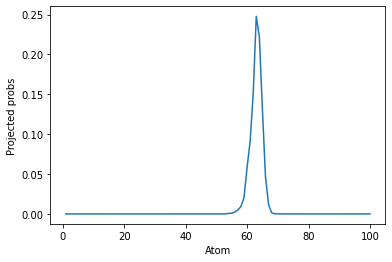

Episode 190: 	Actor Loss: -19.29 	Critic Loss: 2.20 
		Average Score: 73.46

SCORES (this eps):  [5.54601864e+00 9.56051358e+01 1.68141618e-01 2.27684985e+02
 3.50767104e+00 1.67236427e+01 9.73504961e+01 6.75386353e+00
 8.70531217e+01 8.88465348e+01 1.39271464e+00 3.38101851e+01] 



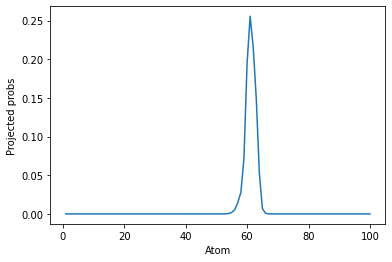

Episode 197\ Score: 91.21Errorneously low Reward = -30.05 Found! Doing nothing...
[1.2329959869384766, 1.4284757375717163, -30.051250457763672, 1.1684552431106567, 1.080532193183899, 1.1633244752883911, 1.687677264213562, 0.6486618518829346, 1.0086338520050049, 0.755825936794281, 0.9199772477149963, 1.4196289777755737]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.22 Found! Doing nothing...
[1.3711451292037964, 1.5515213012695312, -30.22279930114746, 1.2306281328201294, 1.2664403915405273, 1.1515034437179565, 2.020808219909668, 0.6794655323028564, 1.012261152267456, 0.7611815929412842, 1.0112409591674805, 1.3161190748214722]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.27 Found! Doing nothing...
[1.839874505996704, 1.5101763010025024, -30.27088737487793, 1.2011151313781738, 1.2554875612258911, 1.1353394985198975, 2.006105899810791, 0.5870220065116882, 1.0465046167373657, 0.8498815894126892, 1.1339863538742065, 1.019111156463623]
SKIPPING TRAINING 

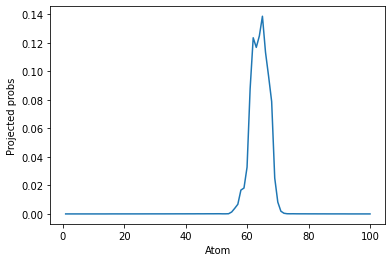

Episode 210: 	Actor Loss: -20.04 	Critic Loss: 2.25 
		Average Score: 79.41

SCORES (this eps):  [-1.44286761e-02  2.06971458e+01  1.03974359e+02  5.39702181e+00
  2.84204331e+02  7.11722189e+01  2.37273248e+02  8.82559545e+00
  4.28996441e+01  1.51803368e+02  2.00672768e+02  7.20738472e+00] 



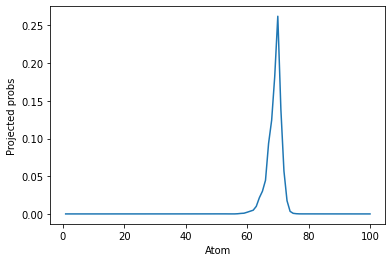

Episode 211\ Score: 137.62NaN Reward Found! Skipping this episode.
Episode 212\ Score: 58.82
NaN found in states. Skipping this episode.
Episode 220: 	Actor Loss: -20.43 	Critic Loss: 2.27 
		Average Score: 75.88

SCORES (this eps):  [101.47573486   0.28819348 183.20132915  73.28614967  84.07007609
  16.54148875  50.0790328   19.75127896  65.33933765  34.91083647
  33.50168524  16.34179594] 



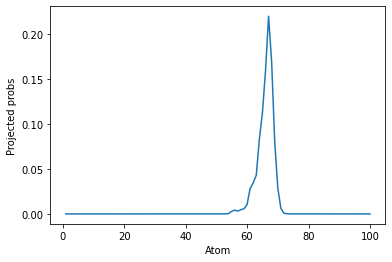

Errorneously low Reward = -30.06 Found! Doing nothing...
[1.8977612257003784, 0.07542283087968826, -30.05647850036621, 0.7564966082572937, 1.1315101385116577, 1.8117387294769287, 1.1887362003326416, 1.6749495267868042, 1.628644585609436, 1.3927714824676514, 1.120681643486023, 1.013933539390564]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.21 Found! Doing nothing...
[1.725630283355713, 0.5486851930618286, -30.206146240234375, 0.973272979259491, 1.1430743932724, 1.837145447731018, 1.0914939641952515, 1.6767117977142334, 1.6617276668548584, 1.2885874509811401, 0.969935417175293, 1.0894439220428467]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.39 Found! Doing nothing...
[1.5130141973495483, 0.519011914730072, -30.385379791259766, 0.9548143148422241, 1.0590832233428955, 1.854595422744751, 1.2513785362243652, 1.5698819160461426, 1.8219735622406006, 1.3218754529953003, 1.158459186553955, 1.128475546836853]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously

Errorneously low Reward = -33.83 Found! Doing nothing...
[0.267226904630661, 1.2686328887939453, -33.82563018798828, 1.421776533126831, 1.356778860092163, 1.2003285884857178, 1.7044100761413574, 0.697137176990509, 0.4481731951236725, 1.3322879076004028, 1.091700792312622, 1.597252368927002]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.91 Found! Doing nothing...
[0.2851330041885376, 1.3705964088439941, -33.90797424316406, 1.404950737953186, 1.3096129894256592, 1.249508023262024, 1.7098497152328491, 0.8437901735305786, 0.5447214841842651, 1.5784356594085693, 1.0785794258117676, 1.9334242343902588]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -34.06 Found! Doing nothing...
[0.7348477840423584, 1.4156967401504517, -34.06205749511719, 1.4917426109313965, 1.2163658142089844, 1.0217313766479492, 1.7284901142120361, 1.1022393703460693, 0.5740810036659241, 1.7658382654190063, 1.1292415857315063, 2.0980749130249023]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneou

Errorneously low Reward = -38.15 Found! Doing nothing...
[1.0251902341842651, 1.3995797634124756, -38.14966583251953, 1.3327784538269043, 1.259045124053955, 0.23085346817970276, 1.1956895589828491, 1.3696680068969727, 0.6700766086578369, 1.6571037769317627, 1.5555012226104736, 1.517953634262085]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -38.22 Found! Doing nothing...
[1.0834523439407349, 1.6054258346557617, -38.21979904174805, 1.358106255531311, 1.506451964378357, 0.6711695790290833, 1.1137458086013794, 1.2848435640335083, 0.7264478802680969, 1.5772594213485718, 1.5653318166732788, 1.76246178150177]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -38.36 Found! Doing nothing...
[1.1825189590454102, 1.6676031351089478, -38.36494064331055, 1.3123869895935059, 1.3715823888778687, 1.0873839855194092, 0.9610787630081177, 1.398835301399231, 0.7048020958900452, 1.6496180295944214, 1.6903235912322998, 1.902774453163147]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneo

Errorneously low Reward = -41.56 Found! Doing nothing...
[1.5391203165054321, 0.7783839702606201, -41.55845642089844, 1.7526432275772095, 0.8193095326423645, 1.4626508951187134, 0.39503899216651917, 1.4099674224853516, 0.3284682631492615, 1.4008935689926147, 0.02233152836561203, 1.1908296346664429]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -41.66 Found! Doing nothing...
[1.5060807466506958, 0.899145781993866, -41.66349411010742, 1.8961433172225952, 0.6911522150039673, 1.4559768438339233, 0.43802252411842346, 1.5106050968170166, 0.34875431656837463, 1.188399076461792, 0.05352984741330147, 1.5087946653366089]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -41.72 Found! Doing nothing...
[1.3636587858200073, 0.8417857885360718, -41.717769622802734, 1.8490651845932007, 0.7444763779640198, 1.3858035802841187, 0.4223538339138031, 1.308353304862976, 0.3388376832008362, 1.1507009267807007, 0.11742845922708511, 1.3589717149734497]
SKIPPING TRAINING OF THIS TIMEST

Errorneously low Reward = -44.84 Found! Doing nothing...
[1.5476545095443726, 0.8279816508293152, -44.83839797973633, 0.8488754630088806, 1.1196458339691162, 1.3118923902511597, 1.1815786361694336, 0.8770995736122131, 1.398772120475769, 0.5343887209892273, 0.9170050621032715, 1.3067516088485718]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -44.93 Found! Doing nothing...
[1.4577893018722534, 0.9517881274223328, -44.92578887939453, 1.0086498260498047, 1.246572494506836, 1.3228381872177124, 1.4253121614456177, 0.9203690886497498, 1.4325618743896484, 0.5839595794677734, 0.9794032573699951, 1.2659555673599243]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -45.00 Found! Doing nothing...
[1.4216779470443726, 1.1341936588287354, -44.99767303466797, 1.1335278749465942, 1.1739463806152344, -1.0, 1.3355144262313843, 0.9262284636497498, 1.4535917043685913, 0.5238990187644958, 0.9474076628684998, 1.0711010694503784]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low 

Errorneously low Reward = -47.86 Found! Doing nothing...
[0.16575606167316437, 1.7446836233139038, -47.857322692871094, 1.403945803642273, 1.579325556755066, 1.3644404411315918, 2.123840808868408, 0.3037720024585724, 1.5950908660888672, 1.319645881652832, 2.0238170623779297, 1.2286367416381836]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -47.97 Found! Doing nothing...
[0.0688077062368393, 1.9004331827163696, -47.97481918334961, 1.0714894533157349, 1.6879249811172485, 1.3314310312271118, 2.1606879234313965, 0.35277655720710754, 1.0810163021087646, 1.328033685684204, 1.9149625301361084, 1.2399228811264038]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -48.12 Found! Doing nothing...
[0.09569138288497925, 1.7020245790481567, -48.11536407470703, 1.038487434387207, 1.5494358539581299, 1.296570897102356, 2.2863082885742188, 0.25520792603492737, 1.1771317720413208, 1.2849470376968384, 1.8884104490280151, 1.2401238679885864]
SKIPPING TRAINING OF THIS TIMESTEP
Err

Errorneously low Reward = -51.02 Found! Doing nothing...
[0.31585729122161865, 1.6814038753509521, -51.0235481262207, 1.6750696897506714, 1.4162309169769287, 1.5016086101531982, 0.3439062535762787, 1.2509392499923706, 0.06475856900215149, 1.870854377746582, 0.2693454921245575, 1.2671327590942383]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -51.07 Found! Doing nothing...
[0.37686046957969666, 1.708714485168457, -51.073848724365234, 1.638014793395996, 1.4112801551818848, 1.6195356845855713, 0.2865791916847229, 1.3324382305145264, 0.048445552587509155, 1.8551026582717896, 0.4539136588573456, 1.2908481359481812]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -51.15 Found! Doing nothing...
[0.34996291995048523, 1.921454668045044, -51.145999908447266, 1.576667308807373, 1.4391509294509888, 1.4292280673980713, 0.3748188018798828, 1.4242401123046875, 0.05094074457883835, 2.014423131942749, 0.616833508014679, 1.466950535774231]
SKIPPING TRAINING OF THIS TIMESTEP
E

Errorneously low Reward = -54.02 Found! Doing nothing...
[0.8463765382766724, 1.561751127243042, -54.01904296875, 0.8016548156738281, 0.5493954420089722, 1.7332535982131958, 0.8316890001296997, 1.6245017051696777, 1.0948699712753296, 0.8456339240074158, 1.6345349550247192, 0.41848233342170715]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -54.09 Found! Doing nothing...
[0.9699696898460388, 1.6721854209899902, -54.08501052856445, 0.8860295414924622, 0.6140457391738892, 1.7347490787506104, 0.8113011717796326, 1.8601950407028198, 1.210249662399292, 0.876538872718811, 1.6257625818252563, 0.4065724015235901]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -54.26 Found! Doing nothing...
[1.1108397245407104, 1.786908507347107, -54.25990676879883, 0.836166501045227, 0.8381944298744202, 1.8468468189239502, 0.7713561654090881, 1.6930484771728516, 1.0829579830169678, 0.8317581415176392, 1.4988065958023071, 0.577427327632904]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneou

Errorneously low Reward = -57.07 Found! Doing nothing...
[1.5385057926177979, 1.2842258214950562, -57.07484817504883, 0.7610524296760559, 0.228749617934227, 1.2304332256317139, 1.652140498161316, 1.4555308818817139, 1.1745370626449585, 0.21857693791389465, 0.6792317032814026, 0.37318751215934753]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -57.17 Found! Doing nothing...
[1.7399741411209106, 1.0860848426818848, -57.16507339477539, 0.5344213247299194, 0.44941994547843933, 1.374812126159668, 1.4766690731048584, 1.3748209476470947, 1.292224407196045, 0.38872408866882324, 0.6764876842498779, 0.3943023979663849]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -57.27 Found! Doing nothing...
[1.894730806350708, 1.0792945623397827, -57.273048400878906, 0.5234904885292053, 0.35580235719680786, 1.2460589408874512, 1.390944004058838, -0.7730730772018433, 1.16957688331604, 0.3158677816390991, 0.7250802516937256, 0.4162399172782898]
SKIPPING TRAINING OF THIS TIMESTEP
Er

Errorneously low Reward = -60.23 Found! Doing nothing...
[1.319046139717102, 0.12867513298988342, -60.22716522216797, 0.7081714272499084, 1.299534559249878, 1.0982937812805176, 1.72037935256958, 1.146835207939148, 1.6684961318969727, 0.4138610363006592, 1.822878360748291, 0.9302425980567932]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -60.34 Found! Doing nothing...
[1.6540497541427612, 0.07392854988574982, -60.34329605102539, 0.632957935333252, 1.2646576166152954, 0.9621983170509338, 1.8738675117492676, 1.2565345764160156, 1.639042615890503, 0.41085413098335266, 1.8224502801895142, 0.9990555047988892]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -60.43 Found! Doing nothing...
[1.6899144649505615, 0.06090575456619263, -60.43282699584961, 0.5334210395812988, 1.1682595014572144, 0.8426287174224854, 1.7098193168640137, 1.0805095434188843, 1.6692531108856201, 0.3795170187950134, 1.7633270025253296, 1.0148283243179321]
SKIPPING TRAINING OF THIS TIMESTEP
Error

Errorneously low Reward = -63.49 Found! Doing nothing...
[0.7487533688545227, 0.5013005137443542, -63.49317169189453, 0.9212963581085205, 1.2786791324615479, 0.09743905812501907, 1.0723026990890503, 0.7048550248146057, 0.040503986179828644, 1.585838794708252, 1.7876970767974854, 1.2942463159561157]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -63.53 Found! Doing nothing...
[0.8955358862876892, 0.7351968288421631, -63.531715393066406, 0.7858923673629761, 1.235350251197815, 0.5627281069755554, 1.2157076597213745, 0.7242779731750488, 0.024996308609843254, 1.6785914897918701, 1.72320556640625, 1.1790258884429932]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -63.70 Found! Doing nothing...
[0.8109649419784546, 1.1541426181793213, -63.69514846801758, 0.779768705368042, 1.2368310689926147, 0.40101420879364014, 1.0300389528274536, 0.7790427803993225, 0.3966098725795746, 1.478887915611267, 1.9123607873916626, 1.103546380996704]
SKIPPING TRAINING OF THIS TIMESTEP
E

Errorneously low Reward = -66.51 Found! Doing nothing...
[1.2662975788116455, 1.6607651710510254, -66.5076675415039, 0.4248199462890625, 1.1770741939544678, 1.2631943225860596, 1.737223744392395, 1.21767258644104, 1.0324581861495972, 1.6216706037521362, 0.5843058824539185, 0.3380986750125885]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -66.56 Found! Doing nothing...
[1.136818289756775, 1.3364050388336182, -66.56459045410156, 0.5868637561798096, 1.1975843906402588, 1.1040772199630737, 1.185628056526184, 1.2911211252212524, 1.1651073694229126, 1.8449842929840088, 0.5504240393638611, 0.5313052535057068]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -66.69 Found! Doing nothing...
[1.251253604888916, 1.450751543045044, -66.69026184082031, 0.5078924894332886, 1.073959231376648, 1.3611966371536255, 1.3636460304260254, 1.443246603012085, 1.2101516723632812, 1.7676708698272705, 0.8048037886619568, 0.6623771786689758]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneousl

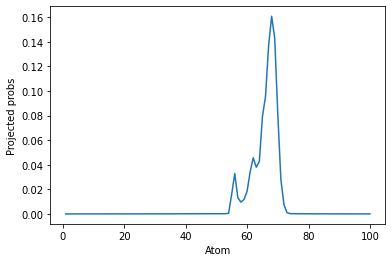

Episode 235\ Score: 54.21

==== An exception occurred: 

====== ACTOR WEIGHTS ===== 

Actor/bn0.weight Parameter containing:
tensor([6.6533e-01, 9.9610e-01, 5.0337e-01, 9.2884e-01, 7.5009e-01, 7.1867e-01,
        6.6785e-01, 7.7637e-01, 8.8700e-01, 7.6231e-01, 4.1498e-04, 6.1009e-01,
        5.8779e-01, 3.8625e-01, 2.9189e-01, 2.8322e-01, 3.2636e-01, 4.1498e-04,
        6.7274e-01, 7.4540e-01, 4.8610e-01, 3.1225e-01, 2.8947e-01, 3.7104e-01,
        4.1591e-01, 4.0530e-01, 3.3878e-01, 3.0762e-01, 3.3947e-01, 4.1498e-04,
        2.9667e-01, 4.0197e-01, 5.0625e-01, 5.8498e-01, 3.5546e-01, 3.6291e-01,
        3.5195e-01, 3.8557e-01, 4.2360e-01, 4.1343e-01, 4.7662e-01, 3.2828e-01,
        4.1498e-04, 4.1498e-04, 3.7435e-01, 4.1498e-04, 6.7208e-01, 7.1061e-01,
        4.6534e-01, 3.6992e-01, 2.8857e-01, 4.0026e-01, 3.4636e-01, 4.2426e-01,
        3.4374e-01, 3.2587e-01, 3.2939e-01, 4.1498e-04, 3.3017e-01, 3.9260e-01,
        5.3280e-01, 5.9444e-01, 3.7649e-01, 3.5559e-01, 3.1129e-01, 4.1503e

Actor/bn2.bias Parameter containing:
tensor([-7.5846e-03,  3.2687e-02, -2.0768e-02,  2.8298e-02,  6.1162e-03,
        -1.8450e-02,  7.8044e-02, -3.1610e-02, -1.7409e-02,  3.8909e-02,
         6.2705e-05,  7.6331e-03, -5.5565e-02, -4.6842e-02, -3.9607e-02,
        -3.6925e-02, -3.0502e-02, -4.0867e-02, -7.3276e-02, -4.1787e-02,
         4.1277e-03, -7.3219e-02, -2.1918e-03, -3.7422e-02, -3.6458e-02,
        -5.7178e-02, -5.3611e-02, -1.5019e-02, -6.9809e-02, -6.5115e-02,
         2.1703e-02, -8.0199e-03, -5.1873e-02, -5.6769e-03, -3.6345e-02,
        -2.5292e-02, -3.0706e-02, -2.0787e-02, -5.3645e-03, -3.9469e-02,
        -4.5715e-02,  3.9599e-02, -3.4206e-02, -3.9460e-02, -2.8430e-03,
        -4.1993e-02, -6.0749e-02, -2.0966e-02, -3.7052e-02, -1.1328e-02,
        -9.4974e-02, -2.6614e-02, -4.3163e-02,  1.2390e-02, -3.2929e-02,
        -4.3561e-02, -7.9141e-02, -2.2793e-02, -5.5445e-02, -1.6548e-02,
        -2.9753e-02,  8.5450e-03, -8.7604e-02, -4.8556e-03, -3.7749e-02,
        -3.243

Critic/bn1.bias Parameter containing:
tensor([-1.5255e-02, -3.1028e-02, -1.2316e-01,  2.1742e-01,  1.0626e-01,
         1.8188e-02,  3.4436e-03, -5.9884e-02, -2.7692e-02,  4.7275e-02,
        -3.6386e-02, -1.5643e-03, -4.6494e-03,  1.2849e-02, -9.3945e-02,
         8.2901e-02, -9.2087e-02,  1.6560e-01,  1.7364e-01,  8.0725e-02,
         2.3298e-02, -7.9550e-03,  1.4909e-01, -1.0461e-02,  3.6672e-02,
         1.6030e-01,  6.8693e-03, -6.3662e-02, -2.0803e-02,  9.6752e-02,
        -1.4190e-02,  7.3504e-02,  6.4137e-02, -1.3176e-03, -7.3713e-02,
         7.0292e-03,  9.7978e-02,  7.0680e-02,  9.3012e-03,  4.4672e-02,
        -7.1226e-02, -1.8392e-02,  1.6215e-01,  8.3958e-02,  4.0041e-02,
        -5.5419e-02,  7.0239e-02, -3.8380e-03, -6.7394e-02, -1.3264e-02,
        -1.9493e-02, -2.1288e-02,  1.2829e-02,  1.6302e-01,  5.2596e-02,
        -4.9004e-02,  2.5183e-02,  3.7366e-02,  2.5956e-01,  1.4516e-01,
         2.4946e-02,  1.3369e-01, -1.4538e-01, -1.1079e-01, -7.8886e-03,
        -6.58

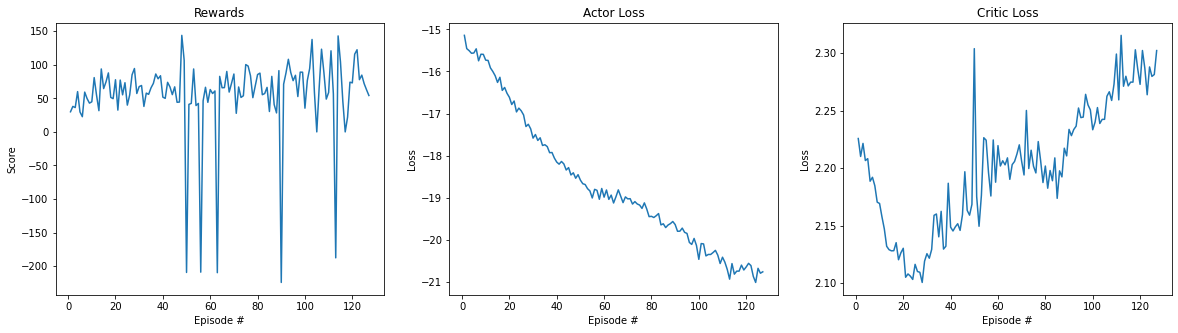

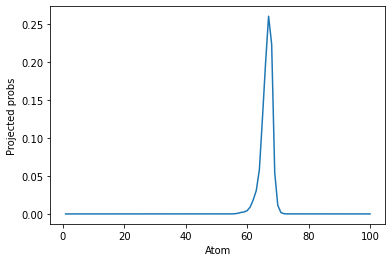

[29.95022301018859,
 37.95616706010575,
 36.23665939554727,
 59.98717900776925,
 29.750664287712425,
 22.633656651557732,
 59.24729846557602,
 49.662874955606334,
 42.858608540419176,
 44.80639254045673,
 80.84388728486374,
 54.60161709819416,
 31.59972265129909,
 93.7256923172002,
 64.511593852425,
 74.52959652551606,
 87.82947916813039,
 51.355254740376644,
 49.48222788586281,
 77.64403517063086,
 32.436366265484445,
 77.17835118675914,
 55.198706281837076,
 73.24008533606927,
 39.887884391316526,
 55.059997723631874,
 85.08216317479189,
 94.38479503748628,
 57.20706677510558,
 67.44238016622451,
 69.08032317537193,
 37.924897997019194,
 57.73994262912311,
 55.935036844806746,
 65.60116448788904,
 72.25755361195964,
 86.21273533798133,
 79.06549250660464,
 83.63128329596172,
 51.73391046274143,
 49.963957412401214,
 73.80981164464417,
 66.93830871659641,
 55.49547842517495,
 67.07047949995224,
 44.10140232377065,
 44.416115533560514,
 143.75299995493455,
 106.7454736601406,
 -209.272

In [75]:
##################
# Continue training 
##################

# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=100000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 7.5e-6                     # 10x less
params.lr_critic = 2.5e-5                    # 10x less
params.vmin = -75
params.vmax = 75
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size =2048
params.gradient_clip = 0.25                # 1/4 original
params.optimizer_eps = 1e-5
#params.action_noise_theta = 0.075          # 1/2 original
#params.action_noise_sigma = 0.1            # 1/2 original
        
params.restart_training = False
params.eps_to_resume_from = 101
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_75_longest'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_75_longest'
params.actor_weights_filename_to_resume = 'checkpoint_actor_ep90.pth'
params.critic_weights_filename_to_resume = 'checkpoint_critic_ep90.pth'

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

# Most Promising Trial...


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  7.5e-05
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -20
VMAX:  20
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 10: 	Actor Loss: -0.50 	Critic Loss: 3.68 
		Average Score: 3.34

SCORES (this eps):  [ 1.61548068 -0.35740259 13.52871148  0.62774484  3.53232696  3.4216947
  3.28859452  3.77623643 -1.46907796  2.70320766  0.92321209  3.13372918] 



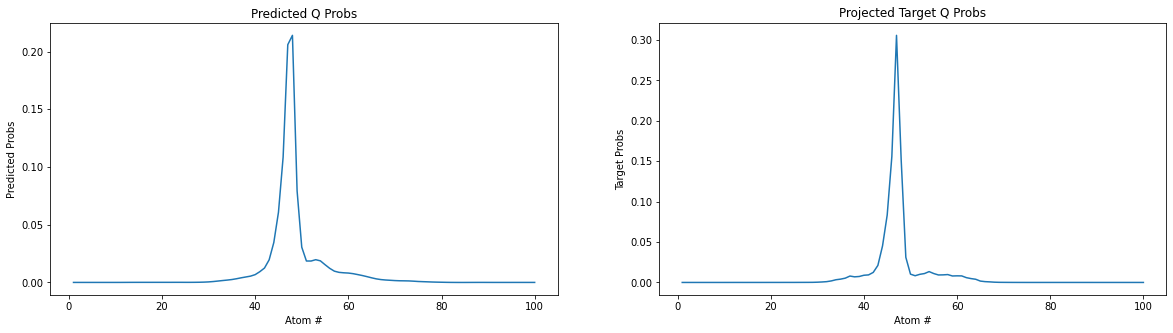

Episode 20: 	Actor Loss: -1.41 	Critic Loss: 2.76 
		Average Score: 14.86

SCORES (this eps):  [10.14124228 43.80392713 21.578935   39.51550158  0.70189627 59.48765092
 20.20361899 10.25448426 81.95658878 24.72920356  0.11200213 27.36971373] 



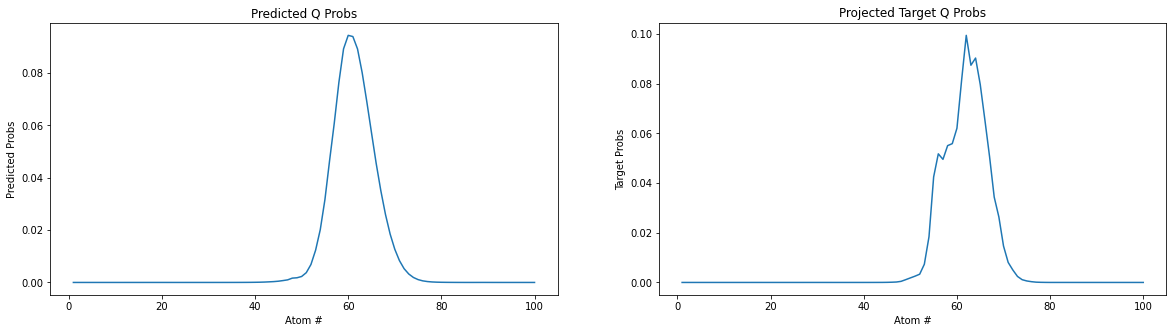

Errorneously low Reward = -30.03 Found! Doing nothing...
[0.7193507552146912, 0.20838749408721924, -30.028573989868164, 0.714328944683075, 0.2856188714504242, 0.52939373254776, 0.43156322836875916, 0.049803175032138824, 0.4390779435634613, 0.0018337653018534184, 0.5177909135818481, 0.1616913080215454]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.19 Found! Doing nothing...
[0.77120441198349, 0.3289368152618408, -30.191009521484375, 0.6844272613525391, 0.5226967334747314, 0.5586229562759399, 0.4083869159221649, 0.1541798710823059, 0.44296762347221375, 0.2089805006980896, 0.7062007784843445, -0.10533375293016434]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -30.35 Found! Doing nothing...
[0.7415562868118286, 0.0952952429652214, -30.345882415771484, 0.6226892471313477, 0.48814451694488525, 0.8572558164596558, 0.2684550881385803, -0.009835476987063885, 0.46137022972106934, -0.13059964776039124, 0.555828869342804, 0.0830218642950058]
SKIPPING TRAINING OF T

Errorneously low Reward = -33.41 Found! Doing nothing...
[0.36798837780952454, 0.27266228199005127, -33.41469192504883, 0.25613442063331604, 0.09428401291370392, 0.7486212849617004, 0.46890583634376526, 0.3372463583946228, 0.06848515570163727, 0.7394905686378479, -0.14378273487091064, 0.6592321991920471]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.56 Found! Doing nothing...
[0.5671384334564209, 0.21485358476638794, -33.557281494140625, 0.28336626291275024, 0.12669262290000916, 0.6349624395370483, 0.5892246961593628, 0.4756786823272705, 0.07627084851264954, 0.6853488087654114, 0.2931041121482849, 0.7466068863868713]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -33.70 Found! Doing nothing...
[0.3736901879310608, 0.24597352743148804, -33.70496368408203, 0.14519742131233215, 0.1143171638250351, 0.8689847588539124, 0.5984970331192017, 0.3429867625236511, 0.13397414982318878, 0.618182361125946, 0.03849552944302559, 0.5452378392219543]
SKIPPING TRAINING OF

Errorneously low Reward = -37.00 Found! Doing nothing...
[0.003999599255621433, 0.7805919647216797, -37.001033782958984, -0.1300845593214035, 0.4744182825088501, 0.19503918290138245, 0.7274689078330994, -0.06688457727432251, -0.07208691537380219, 0.6878684759140015, 0.5174430012702942, 0.8124907612800598]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -37.08 Found! Doing nothing...
[-0.014894334599375725, 0.7571449875831604, -37.079627990722656, -0.03733767941594124, 0.26889514923095703, -0.03140687197446823, 0.48215252161026, -0.10056095570325851, -0.08989517390727997, 0.6044008135795593, 0.5020660161972046, 0.8224911689758301]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -37.22 Found! Doing nothing...
[-1.0690994262695312, 0.6943960189819336, -37.217506408691406, -0.08765989542007446, 0.3950853943824768, -1.0, 0.41299697756767273, -0.2320389598608017, 0.009583215229213238, 0.6048927903175354, 0.6044839024543762, 0.7458606362342834]
SKIPPING TRAINING OF T

Errorneously low Reward = -40.19 Found! Doing nothing...
[0.1828891932964325, 0.5002838969230652, -40.18684768676758, 0.5579028725624084, 1.0030927658081055, 0.2839949131011963, 0.756481945514679, 0.18421389162540436, 0.40216678380966187, 0.5864870548248291, 0.5133515000343323, 0.5903032422065735]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -40.28 Found! Doing nothing...
[0.11123241484165192, 0.2978407144546509, -40.283905029296875, 0.5511882901191711, 0.8243502974510193, 0.2112864851951599, 0.8993358016014099, 0.2716483175754547, 0.6121839284896851, 0.7388728260993958, 0.6294311881065369, 0.49240797758102417]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -40.42 Found! Doing nothing...
[0.18466034531593323, 0.6545270085334778, -40.41647720336914, 0.3688884675502777, 0.4061795473098755, 0.5558544993400574, 0.8258465528488159, 0.3556181490421295, 0.5142937898635864, 0.4936580955982208, 0.7382907867431641, 0.8399580121040344]
SKIPPING TRAINING OF THIS TIMES

Errorneously low Reward = -43.11 Found! Doing nothing...
[0.13528919219970703, -1.0058541297912598, -43.1073112487793, 0.12240393459796906, 0.07155561447143555, 0.8293530941009521, 0.2138383984565735, 0.785866379737854, 0.36599352955818176, 0.02999815344810486, 0.10462326556444168, 0.23801955580711365]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -43.22 Found! Doing nothing...
[-0.038785867393016815, 0.08830390125513077, -43.224098205566406, 0.09830261766910553, 0.41473740339279175, 0.7069872617721558, 0.303272545337677, 0.5660896897315979, 0.555471658706665, -0.0712299570441246, 0.029364274814724922, 0.21770931780338287]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -43.36 Found! Doing nothing...
[-0.05671556293964386, 0.12531901895999908, -43.362823486328125, -0.09990338981151581, 0.19567695260047913, 0.9198111295700073, 0.2327433079481125, 0.6852580904960632, 0.26719486713409424, 0.021655961871147156, 0.019885018467903137, 0.13166701793670654]
SKIPPING

Errorneously low Reward = -46.07 Found! Doing nothing...
[0.3843391537666321, 0.7762764692306519, -46.06818389892578, 0.881375253200531, -0.007190319709479809, 0.40222078561782837, 0.34393417835235596, 0.4280618727207184, 0.07381512224674225, -0.661873996257782, 0.5258710980415344, 0.7937475442886353]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -46.22 Found! Doing nothing...
[0.3218037784099579, 0.632274329662323, -46.22179412841797, 0.7188119888305664, 0.021195756271481514, 0.17003008723258972, 0.41317668557167053, 0.33724719285964966, 0.1057334691286087, -1.0, 0.5109489560127258, 0.8664038181304932]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -46.28 Found! Doing nothing...
[0.23456870019435883, 0.723039984703064, -46.27852249145508, 0.6729953289031982, -0.04667436331510544, 0.2996630072593689, 0.27317002415657043, 0.09949401021003723, 0.19359120726585388, 0.06162566691637039, 0.7775325775146484, 0.719621479511261]
SKIPPING TRAINING OF THIS TIMESTEP
E

Errorneously low Reward = -48.86 Found! Doing nothing...
[0.44891902804374695, 0.860626220703125, -48.86405944824219, 0.30791762471199036, 0.31948354840278625, 0.4554150402545929, -0.154720738530159, 0.4824225902557373, 0.29030853509902954, 0.24558082222938538, 0.6745988726615906, 0.5369518995285034]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -48.95 Found! Doing nothing...
[0.5873392820358276, 0.2736286222934723, -48.948062896728516, 0.09836403280496597, -0.26538464426994324, 0.5458441972732544, -0.05823584645986557, 0.7927488088607788, 0.6156960725784302, 0.31177762150764465, 0.7452171444892883, 0.2772451341152191]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -48.99 Found! Doing nothing...
[0.47036921977996826, 0.5598841309547424, -48.98950958251953, 0.024045580998063087, 0.0328754298388958, 0.5035330057144165, -0.05706815794110298, 0.7150415778160095, 0.2671879827976227, 0.23241382837295532, 0.29414433240890503, 0.25398093461990356]
SKIPPING TRAINING

Errorneously low Reward = -51.93 Found! Doing nothing...
[-0.07914121448993683, 0.2995242178440094, -51.934486389160156, 0.2622590959072113, 0.3240199685096741, 0.20202600955963135, 0.573022723197937, 0.4743410348892212, 0.14737346768379211, 0.2813119888305664, 0.09195183217525482, 0.3698045611381531]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -51.97 Found! Doing nothing...
[0.07912316918373108, 0.2731592655181885, -51.97322463989258, 0.31656336784362793, 0.22668784856796265, 0.16101811826229095, 0.6553565859794617, 0.2035527229309082, -0.04370142146945, -0.024365706369280815, 0.05312731862068176, 0.3505241870880127]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -52.13 Found! Doing nothing...
[0.07082116603851318, 0.36851051449775696, -52.130069732666016, 0.2811203598976135, 0.27097561955451965, 0.13874204456806183, 0.6503597497940063, 0.54018634557724, 0.22709153592586517, 0.3216024935245514, -0.06343425810337067, 0.5104719400405884]
SKIPPING TRAINING 

Errorneously low Reward = -54.69 Found! Doing nothing...
[0.5924859642982483, -0.02487986907362938, -54.68720626831055, 0.2599338889122009, 0.6010575294494629, -0.024813465774059296, 0.478111207485199, 0.06805280596017838, 0.28260135650634766, -0.021725600585341454, 0.7907772064208984, -0.03828674182295799]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -54.81 Found! Doing nothing...
[0.7466645240783691, 0.06760641932487488, -54.81414031982422, 0.4835614264011383, 0.43634629249572754, -0.016999712213873863, 0.5196928977966309, 0.04432123154401779, 0.6485192179679871, 0.05793891102075577, 0.8183786273002625, 0.0010179774835705757]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -54.94 Found! Doing nothing...
[0.7534276247024536, -0.06878730654716492, -54.937835693359375, 0.32496678829193115, 0.7878651022911072, -0.17834046483039856, 0.40067192912101746, 0.00011201202869415283, 0.2774146497249603, -0.1185595914721489, 0.43496131896972656, 0.13826590776443481]
S

Errorneously low Reward = -57.91 Found! Doing nothing...
[1.0958925485610962, 0.10638240724802017, -57.91316604614258, 0.624330461025238, 0.4229990839958191, -0.19073306024074554, 0.7788509130477905, -0.035182274878025055, 0.6867943406105042, 0.6518248915672302, 0.44545823335647583, 0.7563906311988831]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -57.95 Found! Doing nothing...
[0.7241178154945374, 0.39474791288375854, -57.946128845214844, 0.24445803463459015, 0.49659866094589233, -0.047739382833242416, 0.5670445561408997, 0.03490699827671051, 0.9561033248901367, 0.6614643931388855, 0.1004023402929306, 0.64234858751297]
SKIPPING TRAINING OF THIS TIMESTEP
Errorneously low Reward = -58.02 Found! Doing nothing...
[0.488045334815979, 0.4268944263458252, -58.02042007446289, 0.024901341646909714, 0.5676290988922119, -0.1244790107011795, 0.4427409768104553, 0.09534118324518204, 0.7650147080421448, 0.8971800208091736, -0.18916913866996765, 0.5740088820457458]
SKIPPING TRAINING O

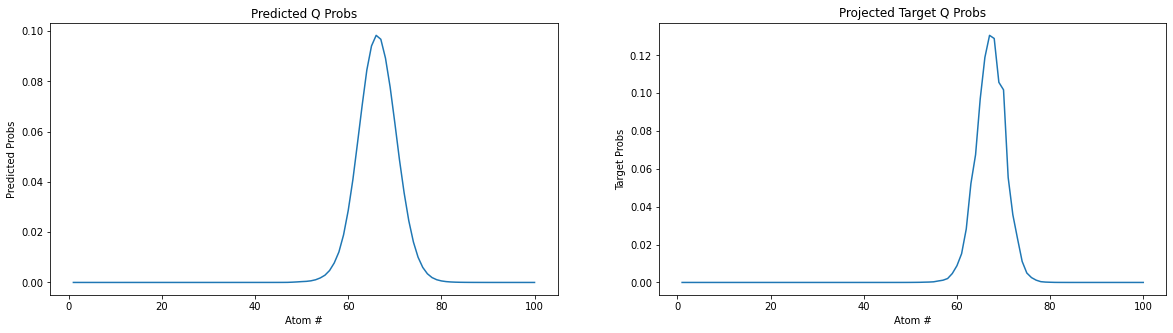

Episode 40: 	Actor Loss: -5.66 	Critic Loss: 2.84 
		Average Score: 58.85

SCORES (this eps):  [ 16.60027783 170.94151313  91.44809509  49.27159769  11.75344092
  17.56757512 212.07433193 102.38780222  30.50459278  36.0933179
  37.09826575  25.40501013] 



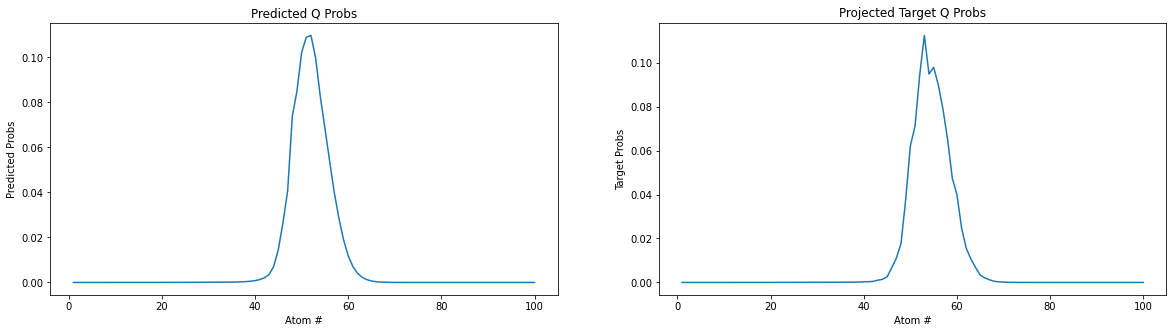

Episode 50: 	Actor Loss: -6.66 	Critic Loss: 2.85 
		Average Score: 58.77

SCORES (this eps):  [  7.26422555  81.7730232   46.63899788 131.69610837  27.87363089
  35.18622905  65.87935948  44.23398846  47.80929988 222.15689025
  21.07363975  24.11973215] 



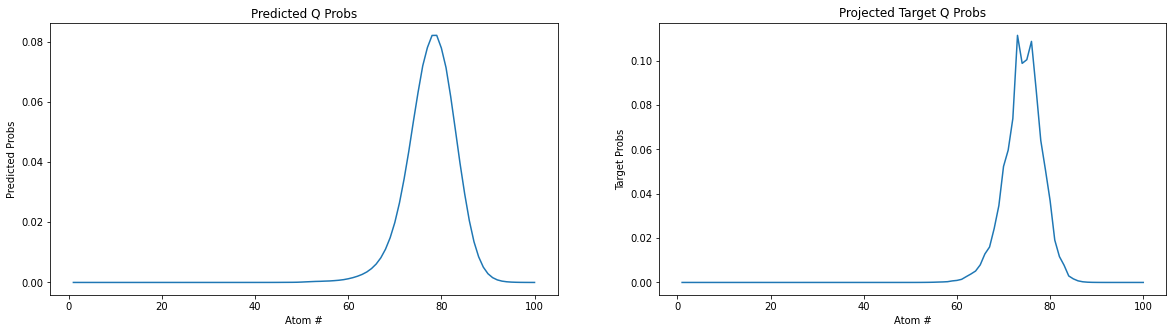

Episode 60: 	Actor Loss: -6.97 	Critic Loss: 2.82 
		Average Score: 86.45

SCORES (this eps):  [ 65.75060241  40.49184044  29.98064602  16.46119041  43.6343016
  91.44003    154.78376966  54.2159718  100.96772251  50.45468377
 182.93741991 380.36961918] 



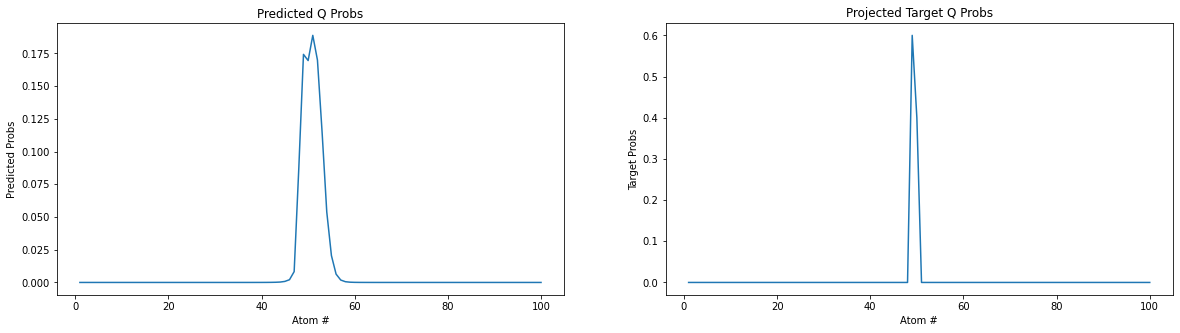

Episode 70: 	Actor Loss: -7.17 	Critic Loss: 2.79 
		Average Score: 120.27

SCORES (this eps):  [ 38.77959548 229.24879171 201.7158951  200.14738628   6.9597092
   4.8437297  125.84793402 274.70345121  30.3874327  303.24193031
  73.58748538  40.87461666] 



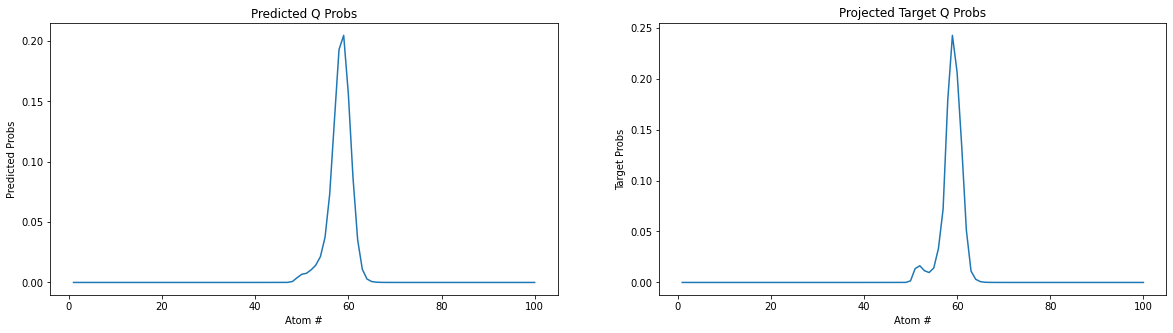

Episode 80: 	Actor Loss: -7.45 	Critic Loss: 2.76 
		Average Score: 129.97

SCORES (this eps):  [7.88159932e+01 1.71503744e+02 1.55677724e+01 2.86365336e+02
 2.10896535e+02 1.68059830e+02 2.58605267e+02 3.22322669e+01
 3.23564847e+01 9.47773322e+01 2.73461238e+02 2.10558124e-01] 



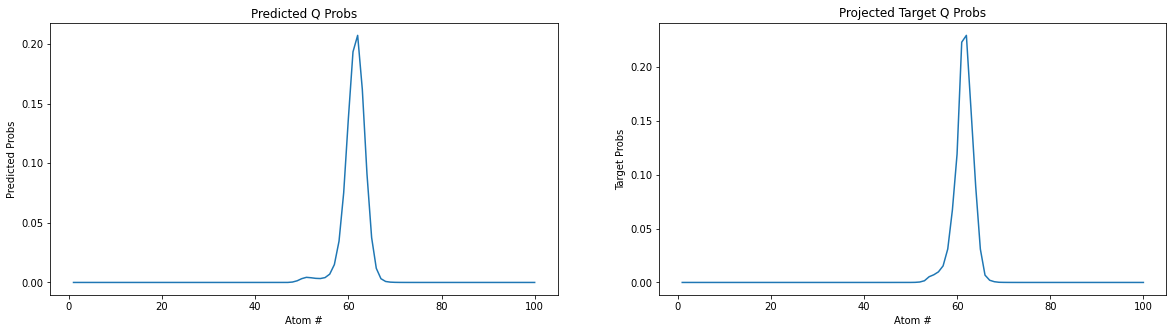

Episode 90: 	Actor Loss: -7.80 	Critic Loss: 2.75 
		Average Score: 143.71

SCORES (this eps):  [ 80.9843589  186.2888937  169.39676608 118.28111955 109.64583568
  71.70126587 146.16409955 208.42943791  33.45074505 201.80992161
 164.71756953  58.26373314] 



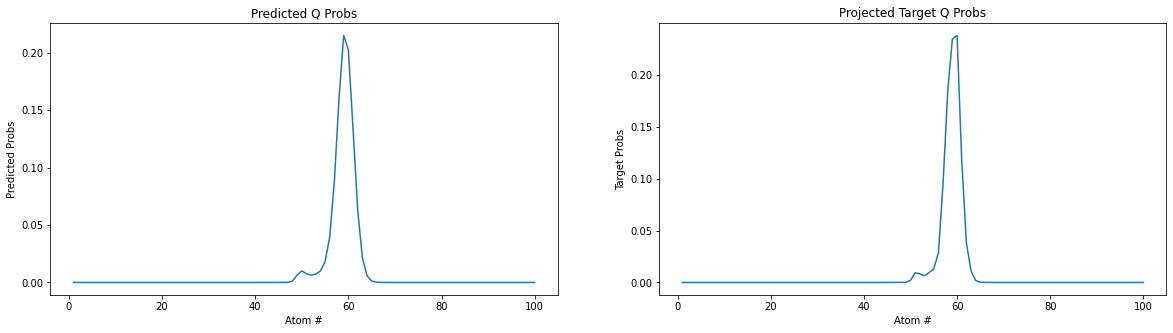

Episode 100: 	Actor Loss: -8.45 	Critic Loss: 2.71 
		Average Score: 156.13

SCORES (this eps):  [148.37847262  42.71312705  10.36620187 234.18154306 199.54876218
  66.88544621  51.57793662 185.25393446  97.59171337 108.60948373
 251.88329825  46.86493956] 



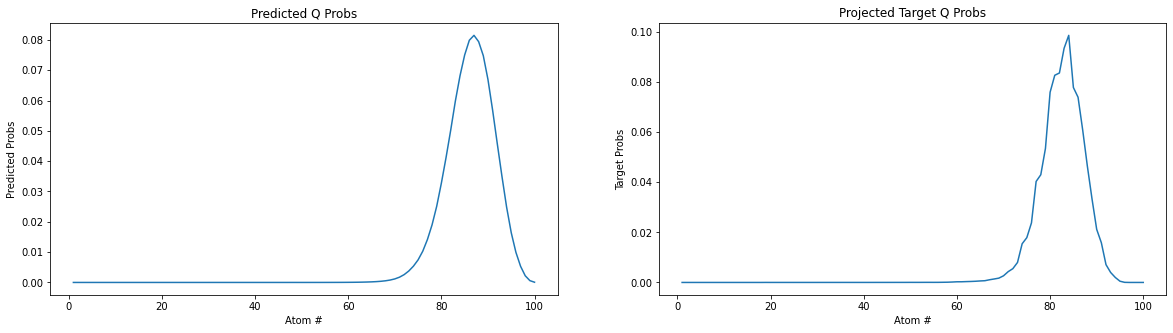

Episode 102\ Score: 200.74NaN Reward Found! Skipping this episode.
Episode 105\ Score: 160.09NaN Reward Found! Skipping this episode.
Episode 110: 	Actor Loss: -8.87 	Critic Loss: 2.65 
		Average Score: 233.01

SCORES (this eps):  [512.54192303 746.62161352 381.99839249 726.16830967 386.5314932
 154.87815831 125.59937186  87.44000224 400.54083727 396.58883113
 653.3024981  341.18248215] 



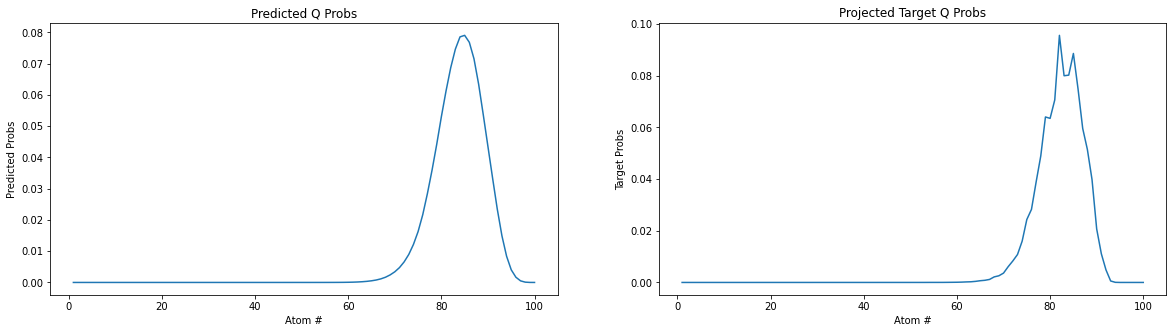

Episode 120: 	Actor Loss: -9.29 	Critic Loss: 2.56 
		Average Score: 280.50

SCORES (this eps):  [104.80735707 188.16679544 349.28627878 401.96137273  66.28823825
 113.67750973 132.27979932 144.303558   356.59891531 371.97073566
 161.13319199 415.42393337] 



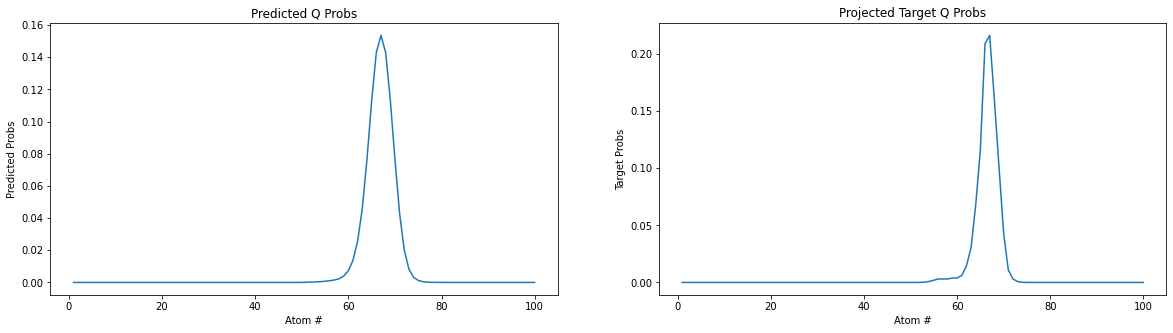

Episode 130: 	Actor Loss: -9.69 	Critic Loss: 2.48 
		Average Score: 352.84

SCORES (this eps):  [663.32984596  64.17541513 440.0332797  427.29282712 334.00594468
 455.93895725 383.11730843 273.77071166 361.34201362  29.06309609
 496.98233266 630.6526522 ] 



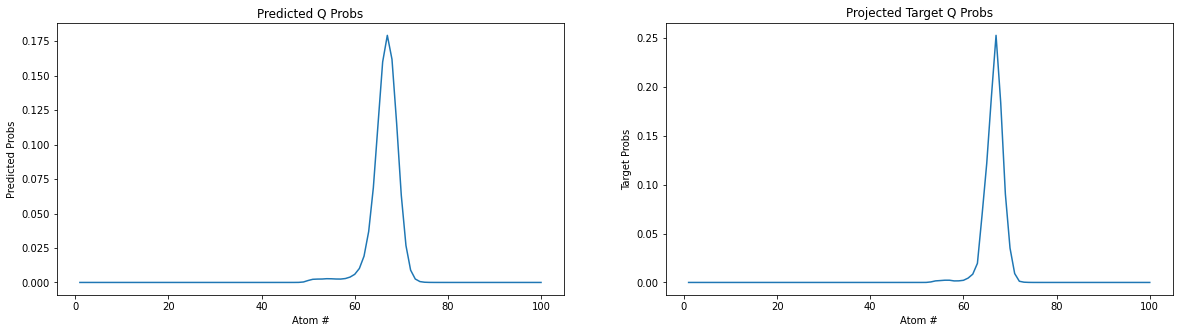

Episode 140: 	Actor Loss: -10.25 	Critic Loss: 2.44 
		Average Score: 393.01

SCORES (this eps):  [277.08211309 696.60789915 853.76807908 475.16020811 561.98974614
 166.21837329 228.63775835   9.05094328 341.46938347 622.50709993
 344.64422185 148.0642968 ] 



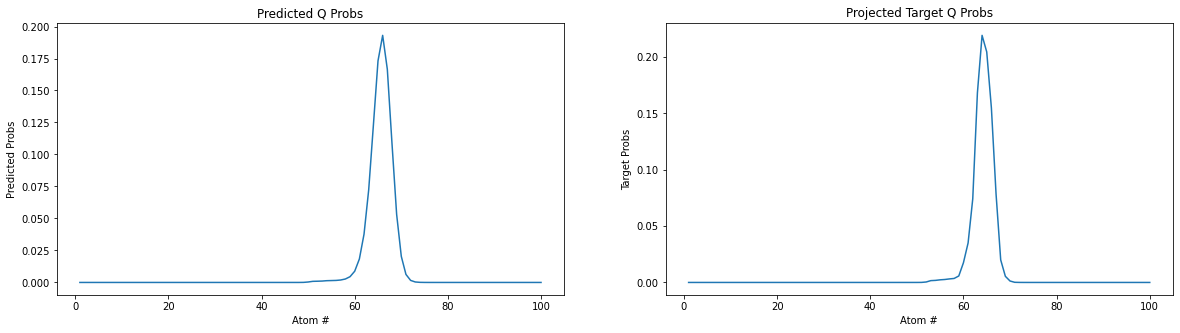

Episode 150: 	Actor Loss: -10.98 	Critic Loss: 2.37 
		Average Score: 393.83

SCORES (this eps):  [4.75967260e+02 4.25093993e+02 4.39900905e-02 3.11014643e+02
 6.35559330e+01 6.49815060e+02 4.97312583e-02 3.22480700e+02
 6.88652915e+02 5.33705384e+02 4.43277650e+02 3.21482763e+02] 



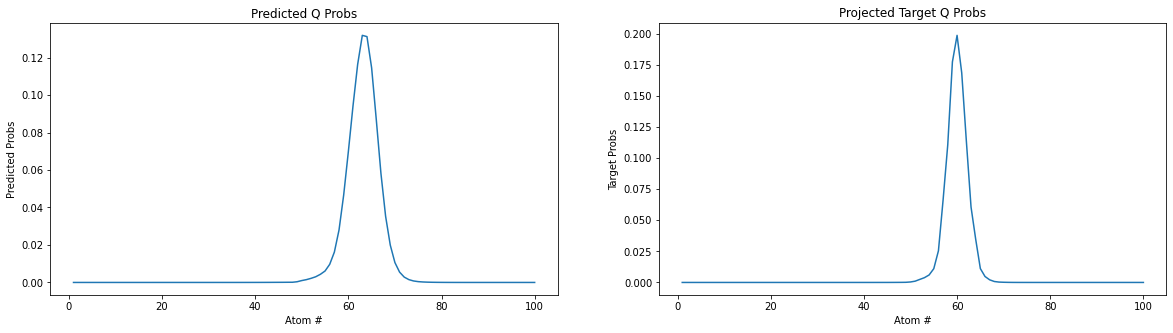

Episode 156\ Score: 356.04
NaN found in states. Skipping this episode.
Episode 158\ Score: 312.11

scripts\d4pg_agent.py:190: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  if self.params.gradient_clip != 0:
scripts\d4pg_agent.py:183: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  if self.params.gradient_clip != 0:



NaN found in actions. Skipping this episode.
Episode 159\ Score: 200.71
NaN found in states. Skipping this episode.


==== An exception occurred: The histogram is empty, please file a bug report.


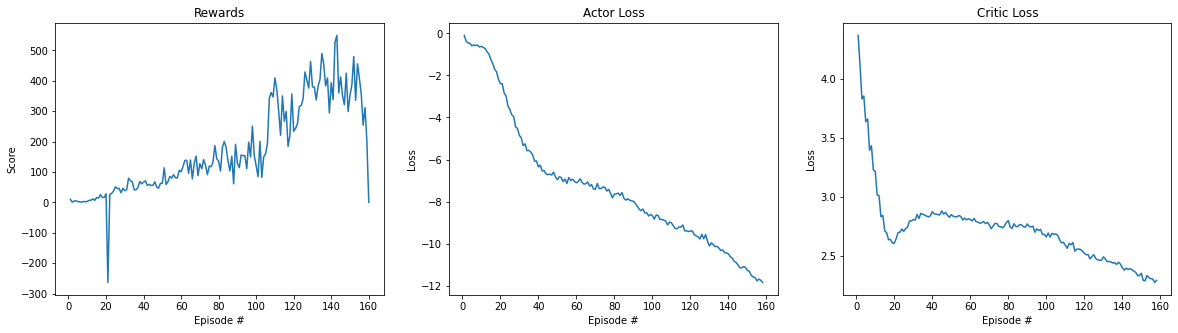

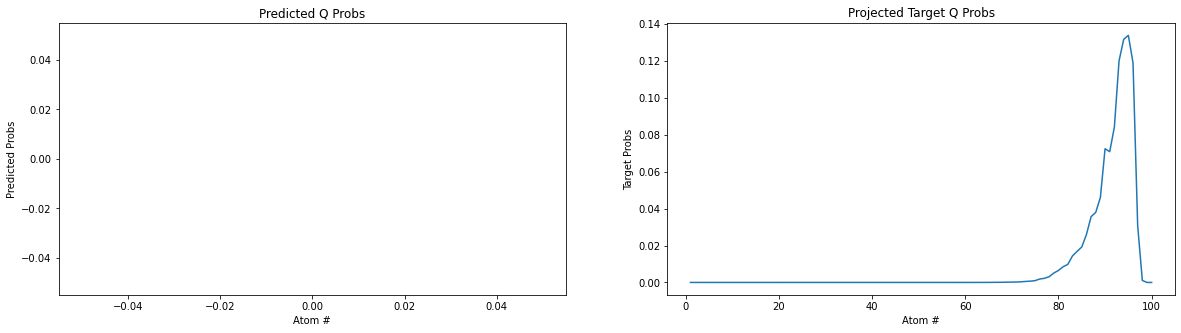

[10.006208759839259,
 0.6927560487141212,
 4.513657602035285,
 5.161256049458946,
 2.677329396867814,
 1.6826039369334467,
 0.7182172630370284,
 2.8087012026420175,
 2.2336933772069947,
 2.8937048331426922,
 6.710165596940594,
 6.995524524827488,
 11.46014858968556,
 6.7393444155653315,
 15.976354544749483,
 14.23434771822455,
 25.431862290017307,
 16.775707862572744,
 15.919067139582088,
 28.321230386946507,
 -263.60618237245944,
 25.882569548654526,
 29.795170813779503,
 37.05836238153279,
 51.13970345596317,
 45.5592146248091,
 45.68576993063713,
 31.74399447363491,
 46.41755447583273,
 38.67211124347523,
 41.541447105812644,
 79.63723223066093,
 71.30552811039767,
 67.85035896732977,
 41.38594673989186,
 41.37962480566057,
 49.00982562332259,
 68.698324403939,
 60.90014324382355,
 66.76215170805033,
 70.84011432509578,
 55.88465253620719,
 58.918420143512776,
 55.752823616700574,
 55.96791436536781,
 67.77322338151862,
 50.47424563665603,
 46.68408714617059,
 62.412828215766545,
 6

In [60]:
# 2 layers network instead...

##################
# Vmax = -Vmin = 20
##################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 7.5e-5 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 1.0        # TEST: Don't clip
#params.optimizer_eps = 1e-5
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_20_longest_refactor'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_20_longest_refactor'
params.num_atoms = 100
params.vmin = -20
params.vmax = 20


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  7.5e-05
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -20
VMAX:  20
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 100008 / 100000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 150: 	Actor Loss: -11.85 	Critic Loss: 2.32 
		Average Score: 367.14

SCORES (this eps):  [261.18360032 412.77802987 277.24058859 458.37755818 912.19120815
 141.68922607 602.64148138 446.48702437 339.7058582  331.40671346
 529.70027061  25.00617805] 



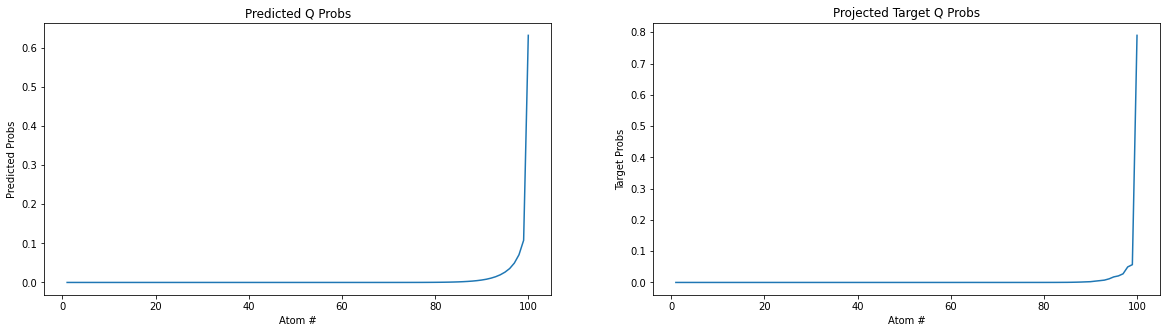

Episode 160: 	Actor Loss: -12.96 	Critic Loss: 2.11 
		Average Score: 317.84

SCORES (this eps):  [202.68143955 283.54640597 128.80977118 614.11863677 233.50220956
  99.88880437 601.65975526 178.4079153  325.7864346  711.09127721
 259.81666167 160.90739424] 



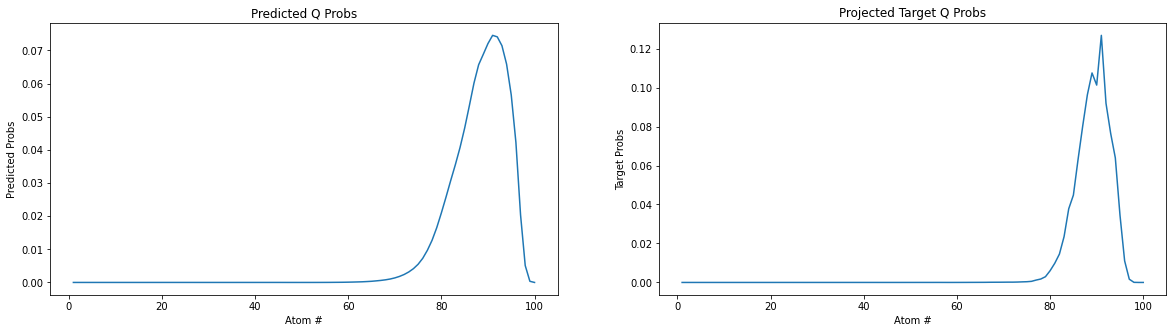

Episode 170: 	Actor Loss: -13.90 	Critic Loss: 2.10 
		Average Score: 318.95

SCORES (this eps):  [ 72.63120745 395.43105802 293.50738489 641.50589936 604.49539131
 633.45162708 553.3960089  126.66531478 157.85062044 211.02305445
 576.47521212 113.04629331] 



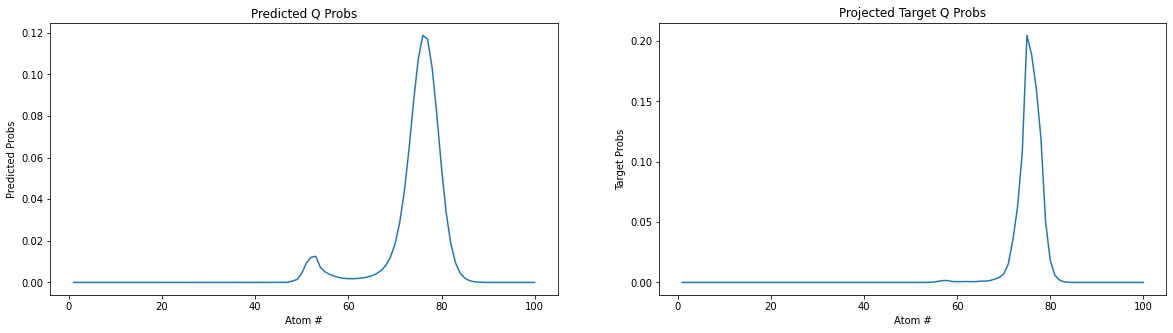

Episode 177\ Score: 411.79NaN Reward Found! Skipping this episode.
Episode 180: 	Actor Loss: -14.41 	Critic Loss: 2.15 
		Average Score: 371.92

SCORES (this eps):  [393.83948016 290.82710659 483.78285809 241.74137497  85.7194071
 151.11065117 443.8714513  307.64317045 414.43268955 760.22028899
  92.69101903 800.63899087] 



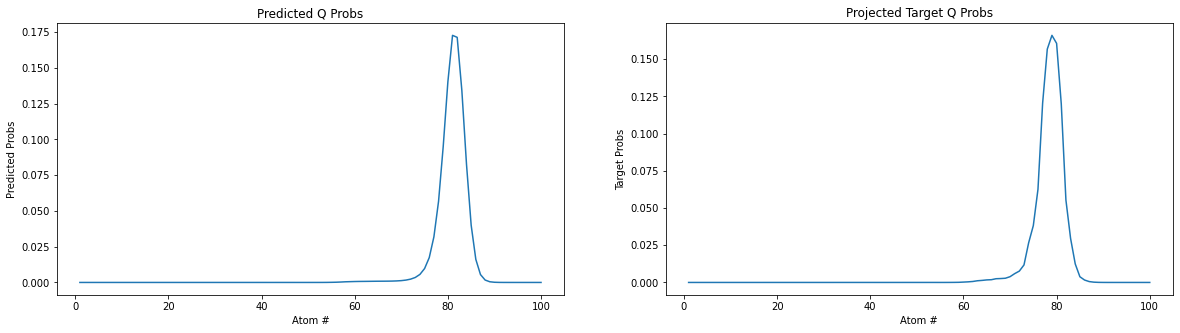

Episode 190: 	Actor Loss: -14.81 	Critic Loss: 2.17 
		Average Score: 365.49

SCORES (this eps):  [231.13112759 694.97484009 752.16384622  95.12584743 702.37600212
 401.54529236 509.83413992 522.76799618 491.59810226 157.7649866
 143.50427214 111.40515339] 



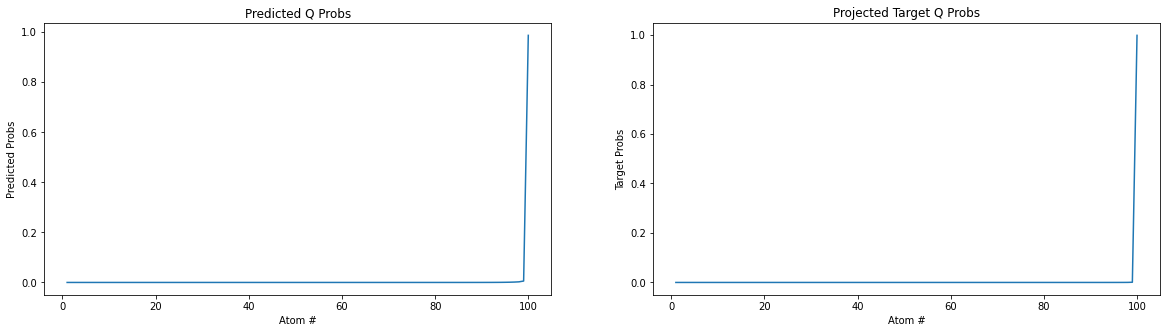

Episode 200: 	Actor Loss: -15.16 	Critic Loss: 2.19 
		Average Score: 347.15

SCORES (this eps):  [ 383.25522126   57.44796906  996.35912794  169.69033685 1056.76148013
  431.32748583  336.95132477  443.02970274   49.2083463   139.91528486
   63.73934682  235.33702979] 



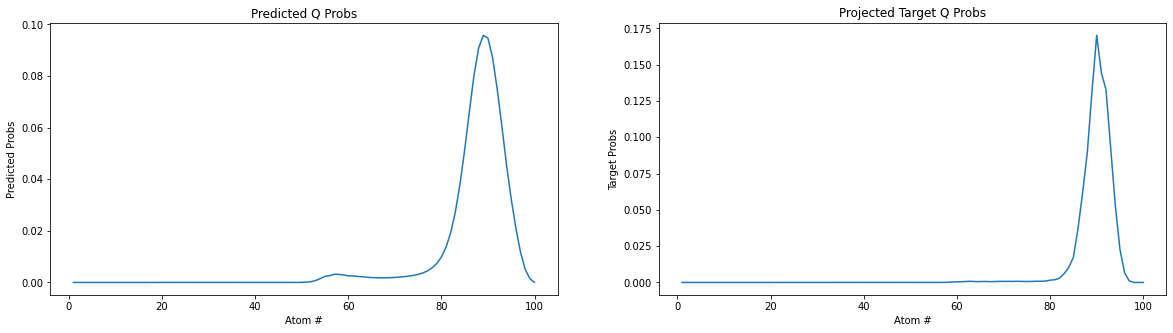

Episode 210: 	Actor Loss: -15.45 	Critic Loss: 2.17 
		Average Score: 382.49

SCORES (this eps):  [9.10255352e+02 1.02905020e-01 3.17439971e+02 3.18386913e+02
 1.75752754e+02 1.52137207e+02 1.93211555e+02 7.48085082e-02
 5.56441339e+02 9.01692439e+02 8.47783247e+01 1.31363791e+02] 



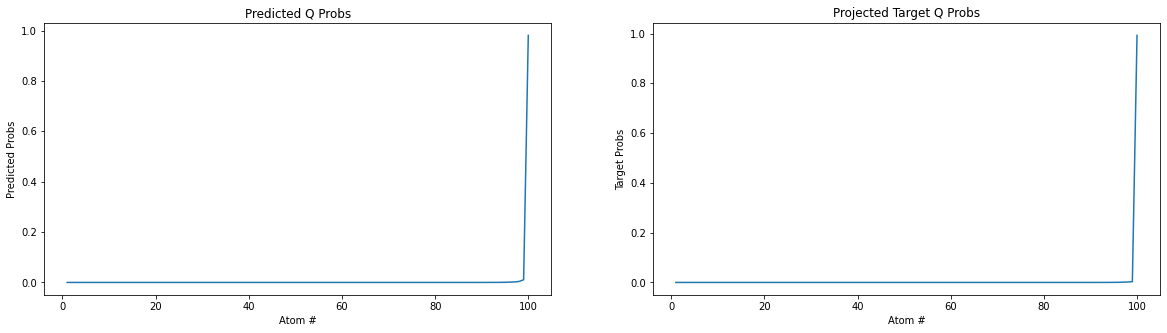

Episode 220: 	Actor Loss: -15.61 	Critic Loss: 2.14 
		Average Score: 420.63

SCORES (this eps):  [923.44266585 185.91607336 242.67320854 461.60212794 452.49861544
 286.09804404  26.81614854 132.64505136 151.92952163  84.20266302
 647.66872053  99.71931116] 



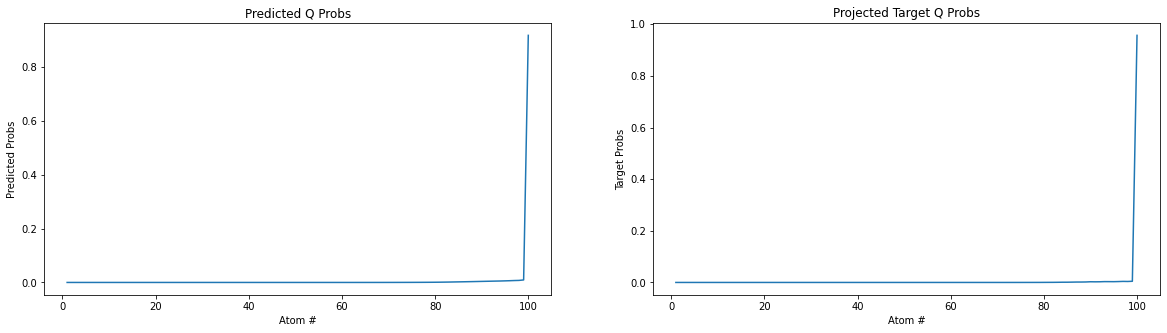

Episode 230: 	Actor Loss: -15.82 	Critic Loss: 2.11 
		Average Score: 409.05

SCORES (this eps):  [ 148.91115554  603.41379663  627.48314302  216.92647758  266.04255139
  899.01148952  266.03960715  112.21341403  781.27700518 1013.95160199
  856.38203383  307.0131473 ] 



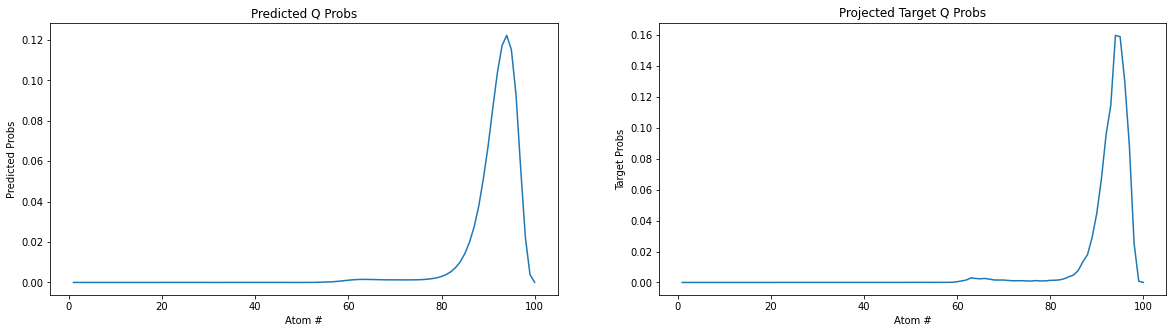

Episode 240: 	Actor Loss: -16.15 	Critic Loss: 2.02 
		Average Score: 410.33

SCORES (this eps):  [126.49596724 405.28793587 325.86298572  59.4899912  611.43944408
 357.03700199 977.69602915 763.82600022 295.77809891 920.19474071
 526.98753879 120.11485923] 



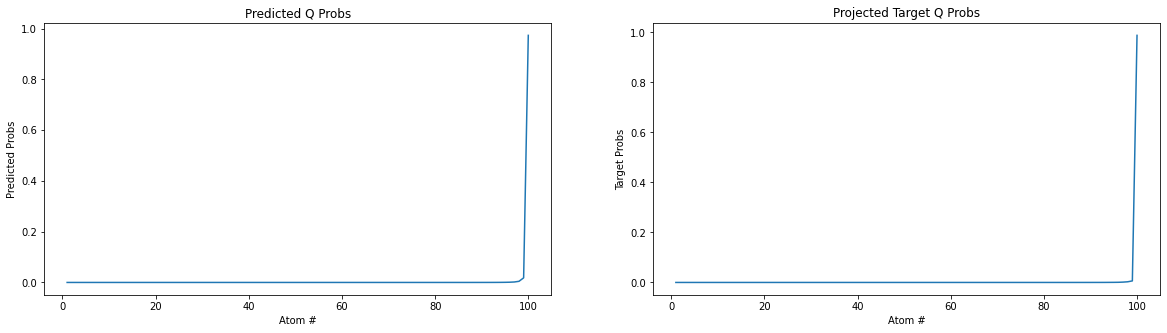

Episode 250: 	Actor Loss: -16.43 	Critic Loss: 1.98 
		Average Score: 388.47

SCORES (this eps):  [286.29229525 327.06271812 775.53147691 434.50937112 760.69823344
 272.28738562 205.92251665 212.67119034 136.99157272 315.72761232
 301.71265341 366.59995388] 



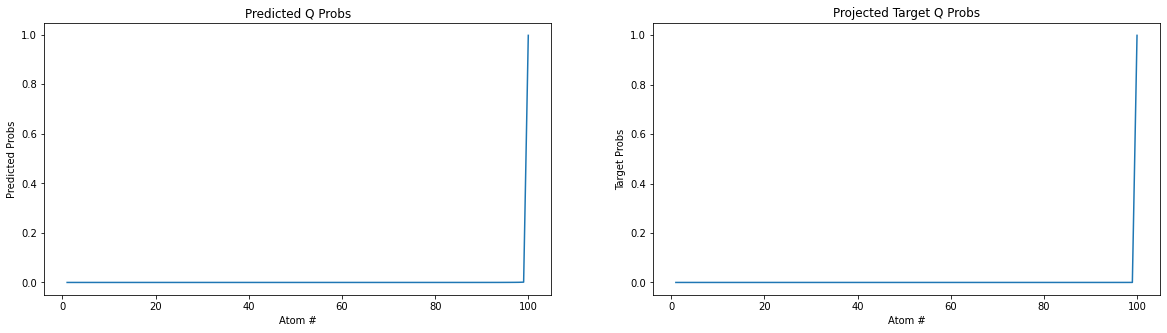

Episode 260: 	Actor Loss: -16.68 	Critic Loss: 1.88 
		Average Score: 384.90

SCORES (this eps):  [ 84.12343381 963.61348571 473.47494616  87.76075843 429.51709507
  27.71650694 295.9210079   12.05282615  10.66367099 303.15485886
  12.81914752 475.83923587] 



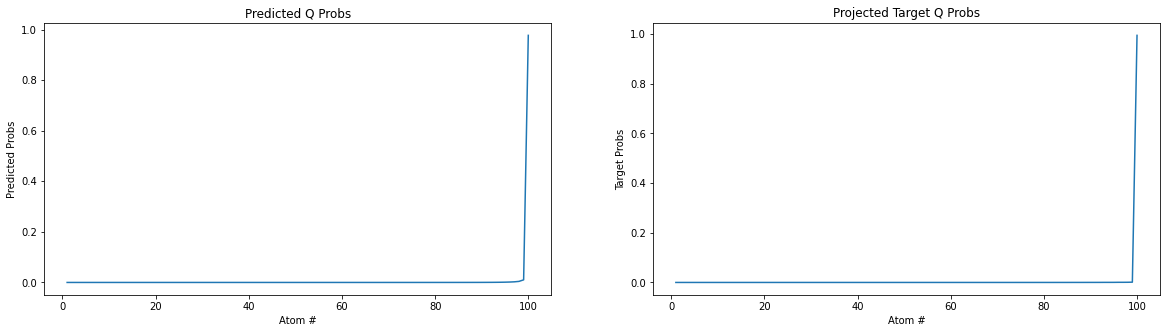

Episode 270: 	Actor Loss: -16.93 	Critic Loss: 1.78 
		Average Score: 496.07

SCORES (this eps):  [ 217.96806133  135.18761992   92.00076607  950.13737746 1120.68086713
    4.71545557 1010.36535397  199.18013298  123.67930208  219.21409286
  132.62171776   57.31064043] 



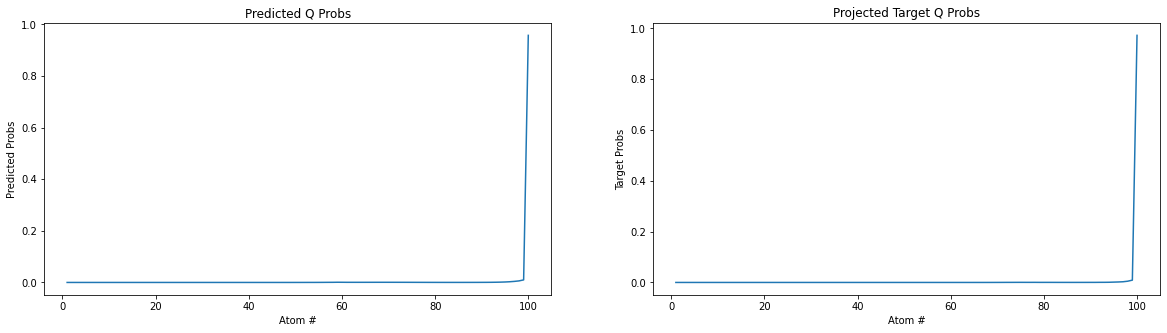

Episode 280: 	Actor Loss: -17.14 	Critic Loss: 1.61 
		Average Score: 488.67

SCORES (this eps):  [  96.16533158  643.46975318  139.65564352  253.7870052   807.30904495
  149.57755003  311.53710684  241.22111587 1041.23677325  764.3943015
  480.10213678    8.77977694] 



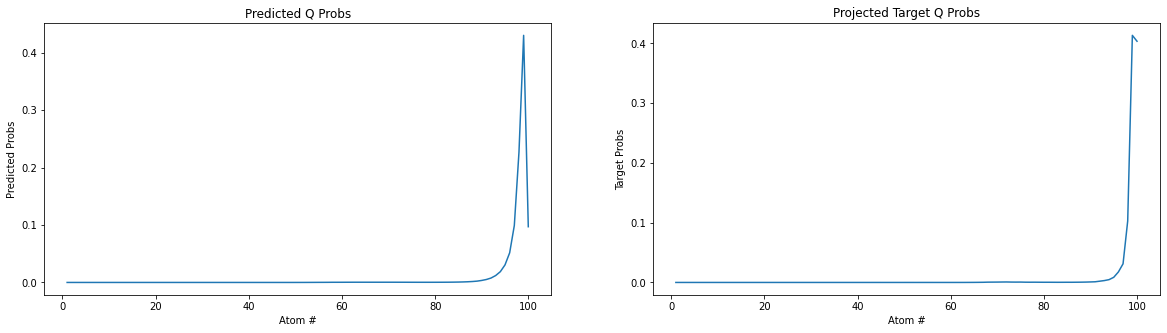

Episode 290: 	Actor Loss: -17.25 	Critic Loss: 1.57 
		Average Score: 428.57

SCORES (this eps):  [  46.7122588   252.90090946  392.15825732  165.79356106   35.19840907
    4.37244993 1095.17058986  454.36160442 1033.46688722  895.29800386
  330.31217587  697.75695334] 



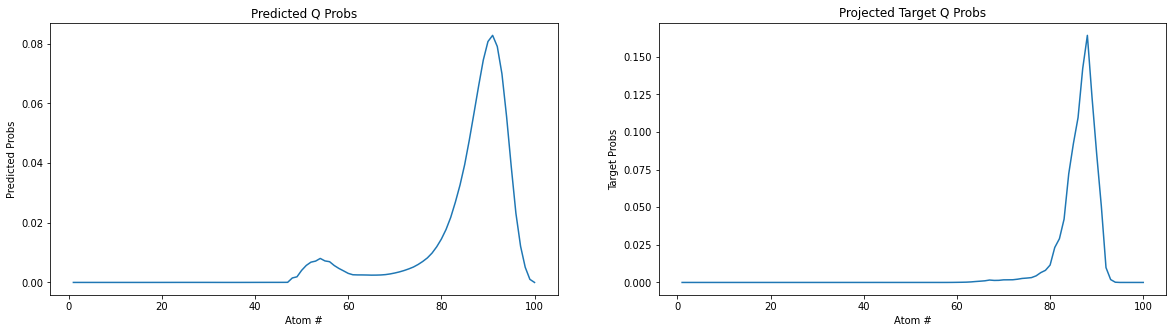

Episode 300: 	Actor Loss: -17.36 	Critic Loss: 1.54 
		Average Score: 492.52

SCORES (this eps):  [  70.49870648 1020.76199591  850.86937656  289.92313633  928.140478
 1068.01386932  981.86996488   17.09146384   38.44236927 1070.77050536
  411.60350106   91.66575513] 



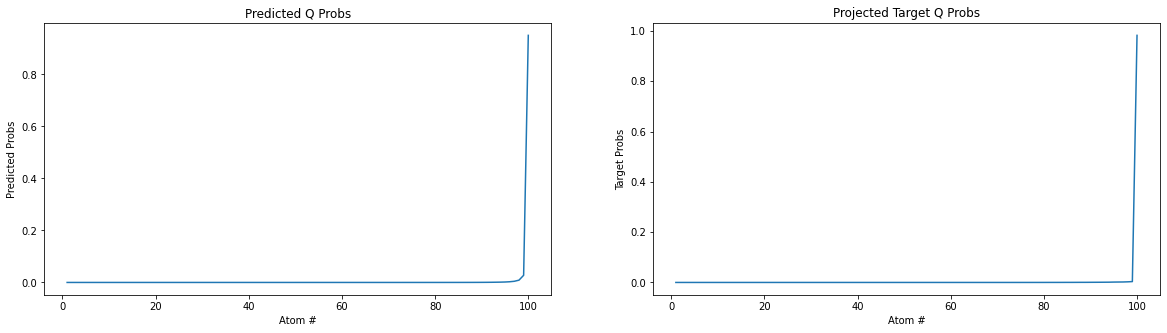

Episode 310: 	Actor Loss: -17.51 	Critic Loss: 1.43 
		Average Score: 485.07

SCORES (this eps):  [201.11185153 189.38688348 166.19181409 103.54395724 450.28747537
 878.84786392  51.20437656 561.96414356 273.94613442 321.73274495
  40.46592711 312.85890474] 



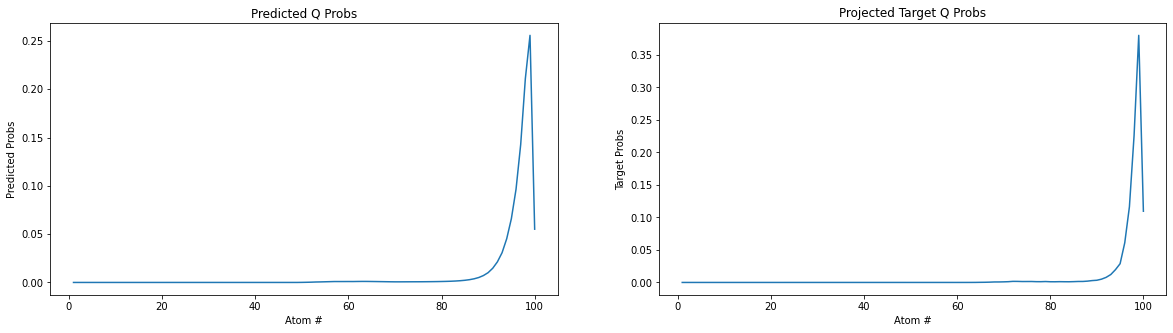

Episode 315\ Score: 400.18NaN Reward Found! Skipping this episode.
Episode 316\ Score: 555.99

KeyboardInterrupt: 

In [9]:
##################
# Continue training 
##################

# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=100000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 7.5e-5 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 0.5        # TEST: Don't clip
#params.optimizer_eps = 1e-5
params.num_atoms = 100
params.vmin = -20
params.vmax = 20
#params.action_noise_theta = 0.075          # 1/2 original
#params.action_noise_sigma = 0.1            # 1/2 original
        
params.restart_training = False
params.eps_to_resume_from = 141
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_20_longest_refactor'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_20_longest_refactor'
params.actor_weights_filename_to_resume = 'checkpoint_actor_ep140.pth'
params.critic_weights_filename_to_resume = 'checkpoint_critic_ep140.pth'

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  7.5e-05
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  15
VMIN:  -20
VMAX:  20
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 100008 / 100000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 150: 	Actor Loss: -18.26 	Critic Loss: 0.99 
		Average Score: 512.59

SCORES (this eps):  [5.09756359e+02 8.42388869e+02 7.53518611e+02 1.02405901e+03
 2.15777809e+02 8.23898418e-02 1.05994029e+03 2.45666583e+01
 7.18904181e+02 2.05226795e+01 2.37405545e+01 5.99863846e+02] 



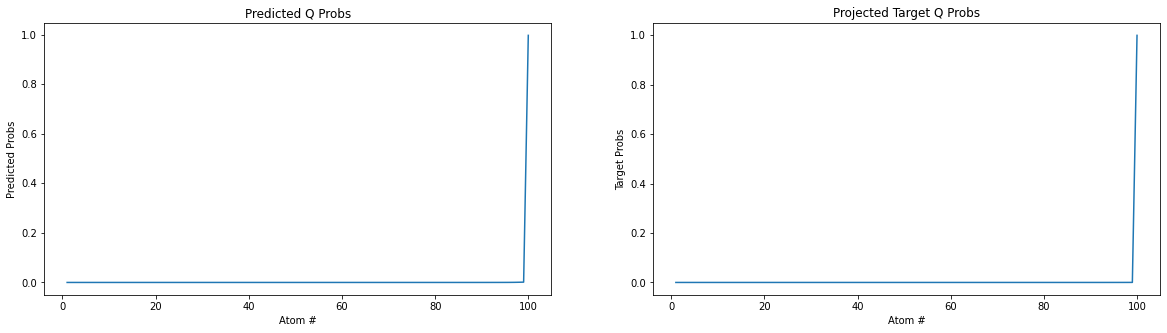

Episode 160: 	Actor Loss: -17.93 	Critic Loss: 0.89 
		Average Score: 550.22

SCORES (this eps):  [ 781.9297665  1082.11697333   13.78202754  836.46846969 1001.80219076
  751.9714749    92.91388832   65.10610879  164.0599737   359.06808362
  182.92907132  421.06198803] 



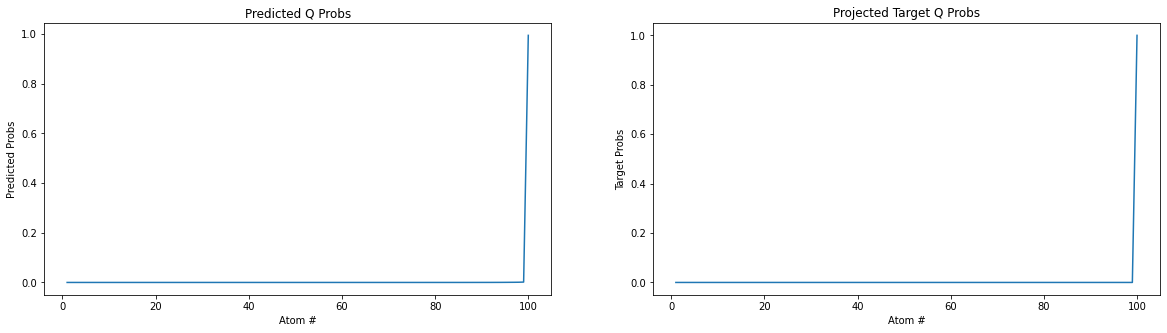

Episode 170: 	Actor Loss: -17.71 	Critic Loss: 1.00 
		Average Score: 500.07

SCORES (this eps):  [ 980.24317004 1012.06803942  108.85958578 1041.76909328  937.79078405
  370.45697005  808.15721924  465.42077354   67.36272373  511.93951885
  891.80954059 1100.97892969] 



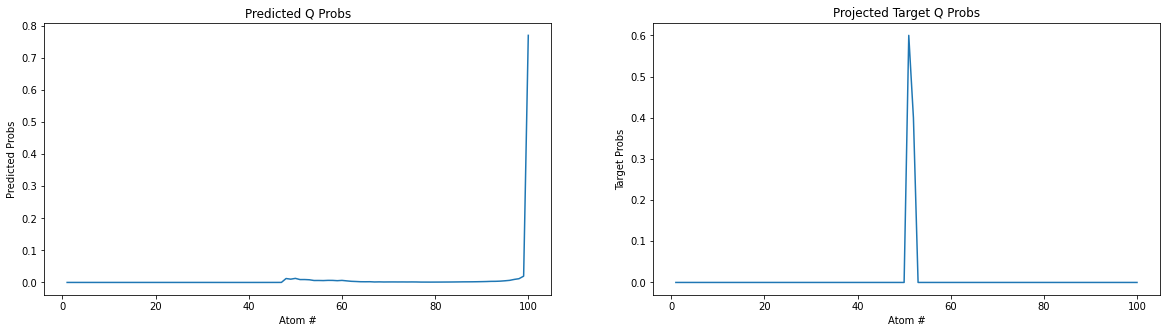

Episode 180: 	Actor Loss: -17.63 	Critic Loss: 1.08 
		Average Score: 590.12

SCORES (this eps):  [  11.49908751  934.68701246  269.8003899   430.51142222  629.89920637
  714.63560169  334.22030663   39.71066425  163.10561319  266.65820553
  891.88342793 1040.05486772] 



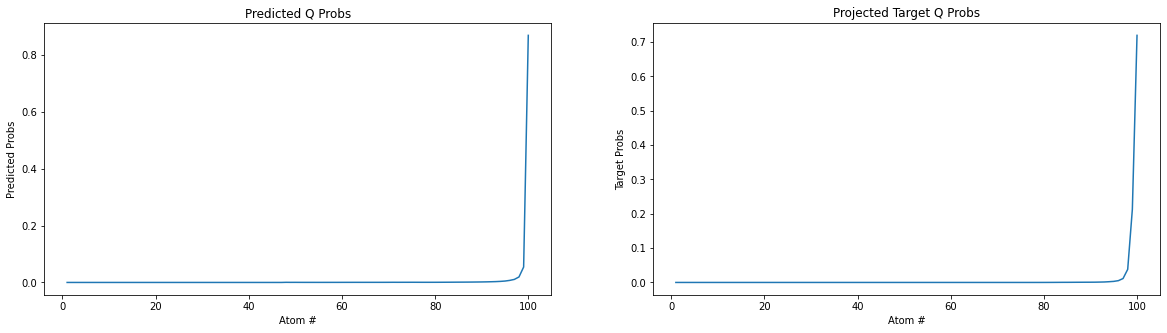

Episode 190: 	Actor Loss: -17.67 	Critic Loss: 1.11 
		Average Score: 617.59

SCORES (this eps):  [ 293.05563299  916.20398127  919.63129767  965.32733842  788.86924376
 1007.31932377  629.88759281  290.82817939  956.99400608  361.12048949
   18.83076666   95.70212503] 



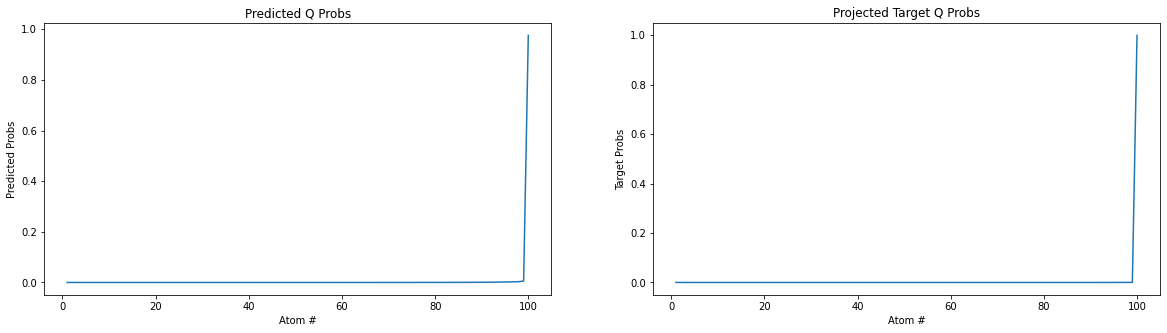


NaN found in states. Skipping this episode.
Episode 191\ Score: 238.05

scripts\d4pg_agent.py:190: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), self.params.gradient_clip)    # ADDED: Gradient Clipping to prevent exploding grad issue



NaN found in actions. Skipping this episode.
Episode 192\ Score: 8.16
NaN found in states. Skipping this episode.
Episode 193\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 194\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 195\ Score: 0.00
NaN found in actions. Skipping this episode.
Episode 196\ Score: 0.00
NaN found in states. Skipping this episode.
Episode 197\ Score: 0.00
NaN found in actions. Skipping this episode.


scripts\d4pg_agent.py:183: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), self.params.gradient_clip)    # ADDED: Gradient Clipping to prevent exploding grad issue


ValueError: The histogram is empty, please file a bug report.

In [11]:
##################
# Continue training 
##################

# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=10000
params.max_t = 1000
params.print_every = 10
params.save_every = 10
params.log_weights_every = 10
params.prefill_memory_qty=100000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 7.5e-5 
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95             # Instead of 0.9
params.batch_size =2048
params.gradient_clip = 0.5        # TEST: Don't clip
#params.optimizer_eps = 1e-5
params.num_atoms = 100
params.vmin = -20
params.vmax = 20
params.action_noise_theta = 0.075          # 1/2 original
params.action_noise_sigma = 0.1            # 1/2 original
params.n_step_bootstrap = 15    # NEW!
        
params.restart_training = False
params.eps_to_resume_from = 141
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/v_eqauls_20_longest_refactor'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/v_eqauls_20_longest_refactor'
params.actor_weights_filename_to_resume = 'checkpoint_actor_ep300.pth'
params.critic_weights_filename_to_resume = 'checkpoint_critic_ep300.pth'

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [17]:
# load the weights from file
params = Params()
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
agent.actor_local.load_state_dict(torch.load('weights/saved/refactored_512_512_512_V_20/checkpoint_actor_ep300.pth'))
agent.critic_local.load_state_dict(torch.load('weights/saved/refactored_512_512_512_V_20/checkpoint_critic_ep300.pth'))
max_t = 1000
score = np.zeros(len(env_info.agents))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
states = env_info.vector_observations                # get the current state
score = 0                                              # initialize the score
for i in range(max_t):
    # Perform actions from each agent's policy network (clipped actions [0, -1])
    actions = [ agent.act(state, add_noise=False) for state in states ]  
    actions = np.stack(actions)      
    env_info = env.step(actions)[brain_name]  # send the action to the environment 
    next_states = env_info.vector_observations       # get the next state
    rewards = env_info.rewards                       # get the reward
    dones = env_info.local_done                      # see if episode has finished
    states = next_states                             # roll over the state to next time step
    
    # update the score
    score += np.array(rewards)                       
    score = np.where(dones, 0, score)
    
    # exit loop if episode finished (NOTE: Agents auto-restart upon done)
    #if all(dones):                                   
    #    break
    
print("Mean Score: {}".format(score.mean()))


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  300000
BATCH_SIZE:  128
HIDDEN_SIZES (ACTOR):  (512, 512, 512)
HIDDEN_SIZES (CRITIC):  (512, 512, 512)
GAMMA:  0.99
TAU:  0.001
LR_ACTOR:  0.0005
LR_CRITIC:  0.001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  350
N_STEP_BOOTSTRAP:  5
VMIN:  -0.01
VMAX:  20
NUM_ATOMS:  100

Mean Score: 1088.789627775356


When finished, you can close the environment.

In [ ]:
# env.close()